# Developmental conservation of peaks

The paper _The hourglass model of evolutionary conservation during embryogenesis
extends to developmental enhancers with signatures of positive selection_ claims that regulatory regions expressed mid-development are most conserved between _Drosophila melanogaster_ and _Drosophila virilis_. However coincidentally this stage also has the most peaks called for both species. Could it be that the number of peaks called is the responsible for the observed conservation? Could it be that if we call more peaks, we cover more of the genome, so the chance that it is a peak in both species gets higher?

In this notebook we'll show that the number of peaks called determines the conservation, and that **TP3 is not the most conserved stage**.

In [1]:
import random
import itertools

import pyfaidx
import pyranges
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,8)})
plt.rcParams['svg.fonttype'] = 'none'

# note that we import some utility functions here
from util import pyranges2psl, jaccard_peaks, get_peaks

In [2]:
timepoints = ["TP1", "TP2", "TP3", "TP4", "TP5"]
assemblies = ["dm6", "droVir3"]
assembly2species = {
    "dm6": "D. melanogaster",
    "droVir3": "D. virilis"
}
promoter_distance = 0
overlap_distance = 0
species2assembly = {v: k for k, v in assembly2species.items()}

samples = pd.read_table("/vol/rerun_dm6/samples_dm6.tsv")

onehots = dict()
peak_types = dict()
replicate_enhancers = {assembly: {} for assembly in assemblies}

for assembly in assemblies:
    # read the one hot peaks
    onehots[assembly] = pd.read_table(f"/vol/rerun_dm6/results/counts/macs2/{assembly}_onehotpeaks.tsv", comment="#", index_col=0)

    # read the peak types
    peak_types[assembly] = pd.DataFrame(index=onehots[assembly].index, columns=["peak type"])
    peak_types[assembly].values[:] = "enhancer"

    # find the closest promoter in the gtf
    df = pyranges.PyRanges(pd.DataFrame(onehots[assembly].reset_index()["index"].str.split("[:-]").to_list(), columns=["Chromosome", "Start", "End"]))
    gtf = pyranges.read_gtf(f"/vol/rerun_dm6/genomes/{assembly}/{assembly}.annotation.gtf")

    if assembly == "dm6":
        tss = gtf.features.tss()
    else:
        tss = gtf[gtf.Feature == "start_codon"]
    
    distances = df.nearest(tss)
    distances = distances[distances.df["Distance"] <= promoter_distance]

    # and put it in the peak types table
    proms = distances.df["Chromosome"].astype(str) + ":" + distances.df["Start"].astype(str) + "-" + distances.df["End"].astype(str)
    peak_types[assembly].loc[proms] = "promoter"
    
    for i, row in samples[samples["assembly"] == assembly].iterrows():
        name = row.biological_replicates.split("_")[1] + "_" + row.descriptive_name.split("_")[-1]
        peaks = pyranges.read_bed(f"/vol/rerun_dm6/results_dm6/macs2/{row.assembly}-{row.loc['sample']}_peaks.narrowPeak")

        distances = peaks.nearest(tss)
        distances = distances[distances.df["Distance"] <= promoter_distance]
        # make a copy with chr, start, end so that we remove all the distance-related stuff
        distances = pyranges.PyRanges(distances.df[["Chromosome", "Start", "End"]])
        replicate_enhancers[assembly][name] = distances

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other w

In [3]:
tp_specific_enhancers = {assembly: {} for assembly in assemblies}

for assembly in assemblies:
    for TP in timepoints:
        for rep0 in ["rep1", "rep2"]:
            for rep1, rep2, rep3, rep4 in itertools.product(*[["rep1", "rep2"], ["rep1", "rep2"], ["rep1", "rep2"], ["rep1", "rep2"]]):
                other_tps = list(sorted(set(timepoints) - {TP}, key=lambda x: x[-1]))
                print(assembly, TP, rep0)

                tp_enhancers = replicate_enhancers[assembly][TP + "_" + rep0]
                other_enhancers = pyranges.concat([
                    replicate_enhancers[assembly][other_tps[0] + "_" + rep1],
                    replicate_enhancers[assembly][other_tps[1] + "_" + rep2],
                    replicate_enhancers[assembly][other_tps[2] + "_" + rep3],
                    replicate_enhancers[assembly][other_tps[3] + "_" + rep4],
                ])
                nearest = tp_enhancers.nearest(other_enhancers)
                nearest = nearest[nearest.Distance > overlap_distance]

                # make a copy again for storing
                nearest = pyranges.PyRanges(nearest.df[["Chromosome", "Start", "End"]])
                tp_specific_enhancers[assembly][TP, rep0, rep1, rep2, rep3, rep4] = nearest
        

dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep1
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP1 rep2
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep1
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP2 rep2
dm6 TP3 rep1
dm6 TP3 rep1
dm6 TP3 rep1
dm6 TP3 rep1
dm6 TP3 rep1
dm6 TP3 rep1
dm6 TP3 rep1
dm6 TP3 rep1
dm6 TP3 rep1
dm6 TP3 rep1
dm6 TP3 rep1
dm6 TP3 rep1
dm6 TP3 rep1

In [4]:
number_of_enhancers = []

for assembly in assemblies:
    for TP in timepoints:
        number_of_enhancers.append([assembly2species[assembly], TP, "rep1", replicate_enhancers[assembly][TP + "_rep1"].df.shape[0]])
        number_of_enhancers.append([assembly2species[assembly], TP, "rep2", replicate_enhancers[assembly][TP + "_rep2"].df.shape[0]])
        
number_of_enhancers = pd.DataFrame(number_of_enhancers, columns=["species", "time point", "replicate", "nr enhancers"])

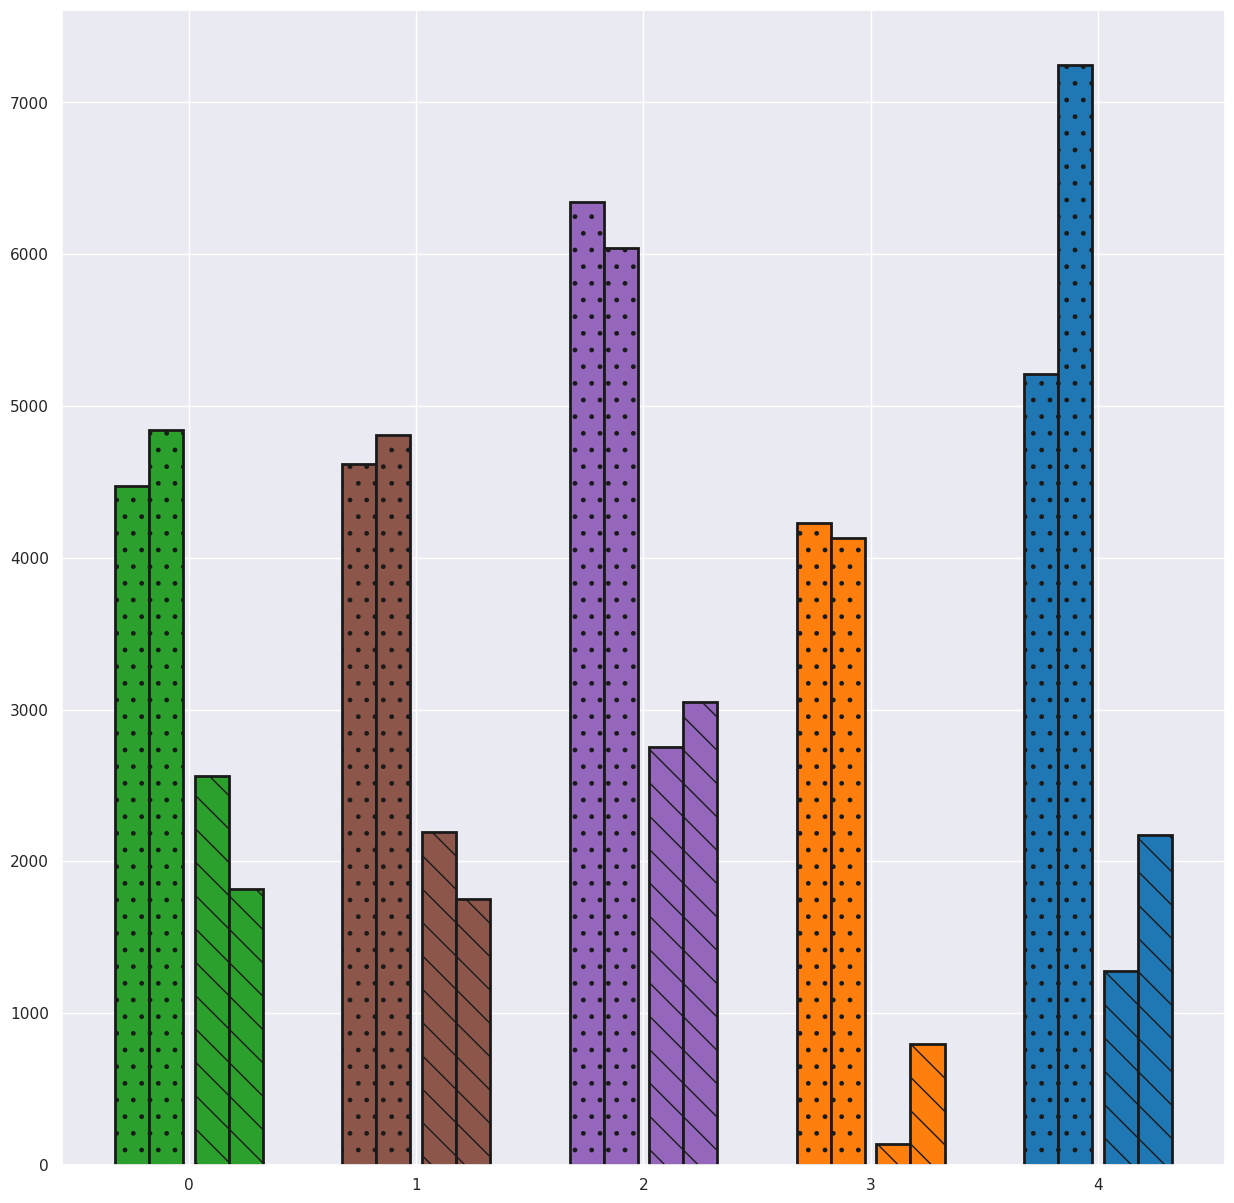

In [5]:
linewidth=2
f, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=1) #, sharey=True)

width = 0.15
diff = 0.05
idxs = np.arange(5, dtype=float) - 2 * width - diff / 2

axs = []
for assembly in ["dm6", "droVir3"]:
    for rep in ["rep1", "rep2"]:
        data = number_of_enhancers.loc[(number_of_enhancers.species==assembly2species[assembly]) & (number_of_enhancers.replicate==rep)]["nr enhancers"]
        _ax = ax.bar(idxs, data, width=width, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")
        axs.append(_ax)
        idxs += width
    idxs += diff

for i, bar in enumerate([patch for _ax in axs for patch in _ax.patches]):
    if i >= 10:
        bar.set_hatch("\\")
    else:
        bar.set_hatch(".")


In [6]:
within_species_jaccard = []
number_timepoint_specific = []

for assembly in assemblies:
    for TP in timepoints:
            for rep1, rep2, rep3, rep4, rep5 in itertools.product(*[["rep1", "rep2"], ["rep1", "rep2"], ["rep1", "rep2"], ["rep1", "rep2"], ["rep1", "rep2"]]):
                reps = set(["rep1", "rep2"])

                tp_rep1 = tp_specific_enhancers[assembly][(TP, rep1, rep2, rep3, rep4, rep5)]
                tp_rep2 = tp_specific_enhancers[assembly][(TP, 
                                                           (reps - {rep1}).pop(), 
                                                           (reps - {rep2}).pop(),
                                                           (reps - {rep3}).pop(),
                                                           (reps - {rep4}).pop(),
                                                           (reps - {rep5}).pop())
                                                         ]
        
                number_timepoint_specific.append([assembly2species[assembly], TP, rep1, rep2, rep3, rep4, rep5, tp_rep1.df.shape[0]])
                number_timepoint_specific.append([assembly2species[assembly], TP, (reps - {rep1}).pop(), (reps - {rep2}).pop(), (reps - {rep3}).pop(), (reps - {rep4}).pop(), (reps - {rep5}).pop(), tp_rep2.df.shape[0]])

                
                nearest = tp_rep1.nearest(tp_rep2)

                overlap = nearest[nearest.Distance <= overlap_distance]
                jaccard = overlap.df.shape[0] / (tp_rep1.df.shape[0] + tp_rep2.df.shape[0] - overlap.df.shape[0])
                within_species_jaccard.append([assembly2species[assembly], TP, rep1, rep2, rep3, rep4, rep5, jaccard])

within_species_jaccard = pd.DataFrame(within_species_jaccard, columns=["species", "time point", "rep1", "rep2", "rep3", "rep4", "rep5", "jaccard"])
number_timepoint_specific = pd.DataFrame(number_timepoint_specific, columns=["species", "time point", "rep1", "rep2", "rep3", "rep4", "rep5", "time point specific enhancers"]).drop_duplicates()
within_species_jaccard = within_species_jaccard[within_species_jaccard["rep1"] == "rep1"]
number_timepoint_specific = number_timepoint_specific[number_timepoint_specific["rep1"] == "rep1"]
within_species_jaccard

,species,time point,rep1,rep2,rep3,rep4,rep5,jaccard
0,D. melanogaster,TP1,rep1,rep1,rep1,rep1,rep1,0.286765
1,D. melanogaster,TP1,rep1,rep1,rep1,rep1,rep2,0.275618
2,D. melanogaster,TP1,rep1,rep1,rep1,rep2,rep1,0.287823
3,D. melanogaster,TP1,rep1,rep1,rep1,rep2,rep2,0.280576
4,D. melanogaster,TP1,rep1,rep1,rep2,rep1,rep1,0.246057
...,...,...,...,...,...,...,...,...
299,D. virilis,TP5,rep1,rep2,rep1,rep2,rep2,0.210526
300,D. virilis,TP5,rep1,rep2,rep2,rep1,rep1,0.209375
301,D. virilis,TP5,rep1,rep2,rep2,rep1,rep2,0.210692
302,D. virilis,TP5,rep1,rep2,rep2,rep2,rep1,0.219672


In [7]:
number_timepoint_specific[(number_timepoint_specific["time point"] == "TP1") & (number_timepoint_specific["species"] == "D. melanogaster")]

,species,time point,rep1,rep2,rep3,rep4,rep5,time point specific enhancers
0,D. melanogaster,TP1,rep1,rep1,rep1,rep1,rep1,231
2,D. melanogaster,TP1,rep1,rep1,rep1,rep1,rep2,158
4,D. melanogaster,TP1,rep1,rep1,rep1,rep2,rep1,229
6,D. melanogaster,TP1,rep1,rep1,rep1,rep2,rep2,158
8,D. melanogaster,TP1,rep1,rep1,rep2,rep1,rep1,283
10,D. melanogaster,TP1,rep1,rep1,rep2,rep1,rep2,172
12,D. melanogaster,TP1,rep1,rep1,rep2,rep2,rep1,280
14,D. melanogaster,TP1,rep1,rep1,rep2,rep2,rep2,172
16,D. melanogaster,TP1,rep1,rep2,rep1,rep1,rep1,200
18,D. melanogaster,TP1,rep1,rep2,rep1,rep1,rep2,145


/tmp/ipykernel_128147/1391931375.py:11: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  ax = sns.swarmplot(
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-

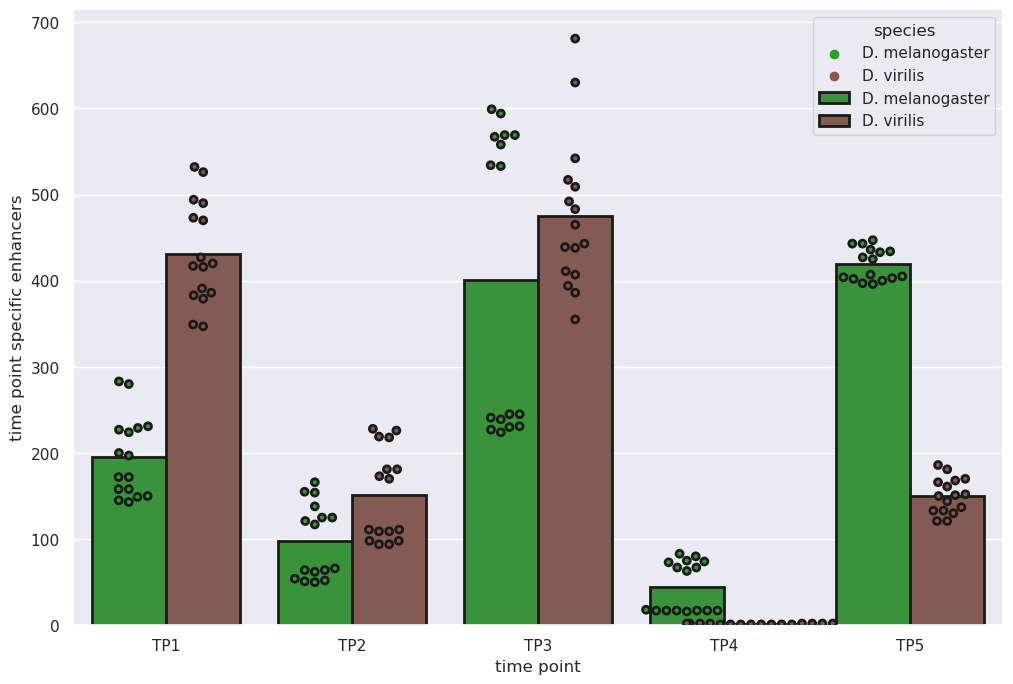

In [8]:
ax = sns.barplot(
    x="time point",
    y="time point specific enhancers",
    hue="species",
    data=number_timepoint_specific, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
    linewidth=linewidth,
    errorbar=None,
    edgecolor="k",
)
ax = sns.swarmplot(
    x="time point",
    y="time point specific enhancers",
    hue="species",
    data=number_timepoint_specific, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
    linewidth=linewidth,
    dodge=True,
    edgecolor="k",
)

/tmp/ipykernel_128147/3267028379.py:11: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  ax = sns.swarmplot(


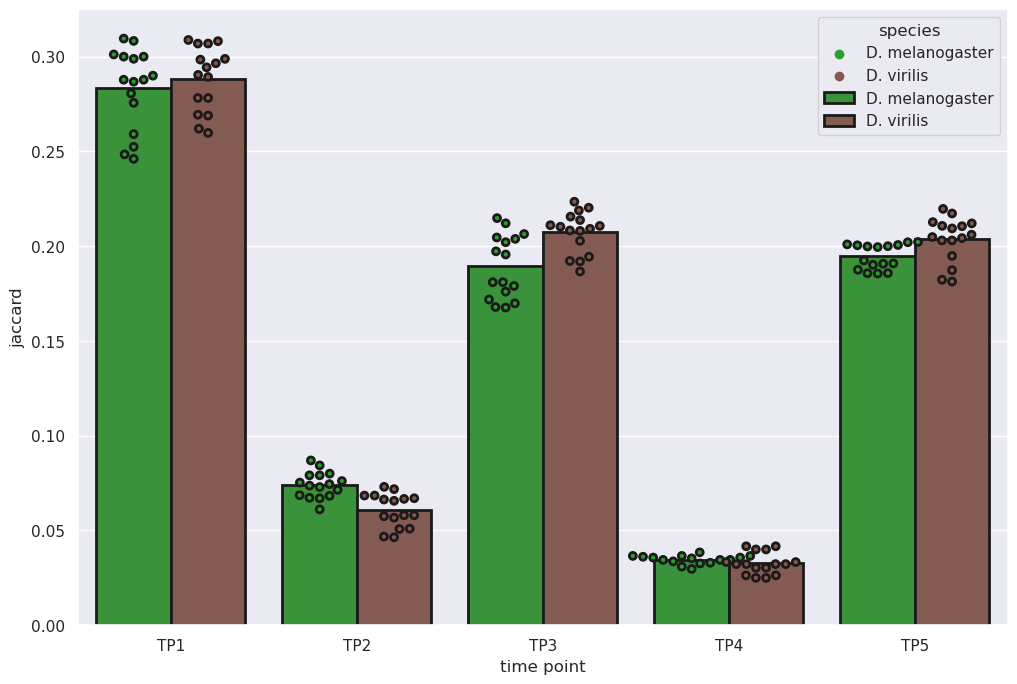

In [9]:
ax = sns.barplot(
    x="time point",
    y="jaccard",
    hue="species",
    data=within_species_jaccard, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
    linewidth=linewidth,
    errorbar=None,
    edgecolor="k",
)
ax = sns.swarmplot(
    x="time point",
    y="jaccard",
    hue="species",
    data=within_species_jaccard, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
    linewidth=linewidth,
    dodge=True,
    edgecolor="k",
)

In [10]:
within_species_jaccard

,species,time point,rep1,rep2,rep3,rep4,rep5,jaccard
0,D. melanogaster,TP1,rep1,rep1,rep1,rep1,rep1,0.286765
1,D. melanogaster,TP1,rep1,rep1,rep1,rep1,rep2,0.275618
2,D. melanogaster,TP1,rep1,rep1,rep1,rep2,rep1,0.287823
3,D. melanogaster,TP1,rep1,rep1,rep1,rep2,rep2,0.280576
4,D. melanogaster,TP1,rep1,rep1,rep2,rep1,rep1,0.246057
...,...,...,...,...,...,...,...,...
299,D. virilis,TP5,rep1,rep2,rep1,rep2,rep2,0.210526
300,D. virilis,TP5,rep1,rep2,rep2,rep1,rep1,0.209375
301,D. virilis,TP5,rep1,rep2,rep2,rep1,rep2,0.210692
302,D. virilis,TP5,rep1,rep2,rep2,rep2,rep1,0.219672


In [11]:
promoters = {
    assembly: set(df[df["peak type"] == "promoter"].index) for assembly, df in peak_types.items()
}
enhancers = {
    assembly: set(df[df["peak type"] == "enhancer"].index) for assembly, df in peak_types.items()
}

In [12]:
df = distances.df
df.Chromosome.astype(str) + ":" + df.Start.astype(str) + ":" + df.End.astype(str)

0              scaffold_9476:6098:6557
1           scaffold_10322:57437:58153
2           scaffold_10322:63666:64062
3           scaffold_10322:69627:70172
4           scaffold_10322:76223:76582
                     ...              
2167    scaffold_13324:2635744:2636127
2168    scaffold_13324:2664780:2665471
2169    scaffold_13324:2672144:2672680
2170    scaffold_13324:2808514:2809029
2171    scaffold_13324:2819435:2820998
Length: 2172, dtype: object

In [13]:
df

,Chromosome,Start,End
0,scaffold_9476,6098,6557
1,scaffold_10322,57437,58153
2,scaffold_10322,63666,64062
3,scaffold_10322,69627,70172
4,scaffold_10322,76223,76582
...,...,...,...
2167,scaffold_13324,2635744,2636127
2168,scaffold_13324,2664780,2665471
2169,scaffold_13324,2672144,2672680
2170,scaffold_13324,2808514,2809029


In [14]:
bedfiles = {assembly: {tp: [] for tp in timepoints} for assembly in assemblies}

for i, assembly in enumerate(assemblies):
    for j, row in samples[samples["assembly"] == assembly].iterrows():
        tp = row.biological_replicates.split("_")[1]
        bedfiles[assembly][tp].append(f"/vol/rerun_dm6/results_dm6/macs2/{row.assembly}-{row.loc['sample']}_peaks.narrowPeak")

bedfiles_dm6 = [
    [bedfiles["dm6"][timepoint][0] for timepoint in timepoints],
    [bedfiles["dm6"][timepoint][1] for timepoint in timepoints]
]
bedfiles_dvir = [
    [bedfiles["droVir3"][timepoint][0] for timepoint in timepoints],
    [bedfiles["droVir3"][timepoint][1] for timepoint in timepoints]
]

tp_specific_dmel_rep1, tp_specific_dmel_rep2 = get_peaks(bedfiles_dm6, timepoint_specific=True)
tp_specific_dvir_rep1, tp_specific_dvir_rep2 = get_peaks(bedfiles_dvir, timepoint_specific=True)



In [15]:
number_of_enhancers

,species,time point,replicate,nr enhancers
0,D. melanogaster,TP1,rep1,4474
1,D. melanogaster,TP1,rep2,4842
2,D. melanogaster,TP2,rep1,4616
3,D. melanogaster,TP2,rep2,4806
4,D. melanogaster,TP3,rep1,6346
5,D. melanogaster,TP3,rep2,6041
6,D. melanogaster,TP4,rep1,4228
7,D. melanogaster,TP4,rep2,4127
8,D. melanogaster,TP5,rep1,5213
9,D. melanogaster,TP5,rep2,7248


In [16]:
def jaccard_same_species(rep1, rep2, timepoints=["TP1", "TP2", "TP3", "TP4", "TP5"]):
    res = {}
    
    for tp in timepoints:
        _rep1 = pyranges.PyRanges(rep1[tp].df[["Chromosome", "Start", "End"]])
        _rep2 = pyranges.PyRanges(rep2[tp].df[["Chromosome", "Start", "End"]])
        
        nearest = _rep1.nearest(_rep2)
        overlap = nearest[nearest.Distance == 0]
        
        nr_rep1 = _rep1.df.shape[0]
        nr_rep2 = _rep2.df.shape[0]
        intersect = overlap.df.shape[0]
        
        jaccard = (intersect / (nr_rep1 + nr_rep2 - intersect))
        res[tp] = jaccard
    return res

jaccard_same_species(tp_specific_dmel_rep1, tp_specific_dmel_rep2)

{'TP1': 0.3361986628462273,
 'TP2': 0.1935279187817259,
 'TP3': 0.2810340985067974,
 'TP4': 0.04893617021276596,
 'TP5': 0.17134449977365324}

# original data

In [17]:
####
# We start with finding all the timepoint specific peaks
####
bedfiles = [
    [f"../data/fly_peaks/all_enhancers/dmel{timepoint_dmel}_IDR_0.05_enhancer.bed" for timepoint_dmel in ["24", "68", "1012", "1416", "1820"]],
    [f"../data/fly_peaks/all_enhancers/dvir{timepoint_dvir}_IDR_0.05_enhancer.bed" for timepoint_dvir in ["25", "710", "1417", "1922", "2528"]]
]
tp_specific_dmel, tp_specific_dvir = get_peaks(bedfiles, timepoint_specific=True)

####
# Now we want to find all overlapping/orthologous time point specific enhancers
####
# use pyranges2psl util to convert our peaks to a psl file for pslmap
psl_original = "../data/fly_peaks/droVir3_peaks_original.psl"
pyranges2psl(tp_specific_dvir, psl_original, "../data/fly_peaks/droVir3.fa.gz")

# use pslmap to find all orthologous time point specific peaks
!pslMap -chainMapFile {psl_original} ../data/fly_peaks/dm6.droVir3.all.chain ../data/fly_peaks/dvir2dmel_peaks_original.psl

# read the conversions from pslmap
peak_conversion_original = pd.read_table("../data/fly_peaks/dvir2dmel_peaks_original.psl", header=None)

# only keep one-to-one orthologs
peak_conversion_original = peak_conversion_original.drop_duplicates(subset=[9], keep=False)

# Original result

We followed the steps described in the paper and can roughly reproduce the original results of the paper.

In [18]:
timepoints=["TP1", "TP2", "TP3", "TP4", "TP5"]

original_res = jaccard_peaks(tp_specific_dmel, tp_specific_dvir, peak_conversion_original, timepoints=timepoints)
original_res = {k: [v] for k, v in original_res.items()}

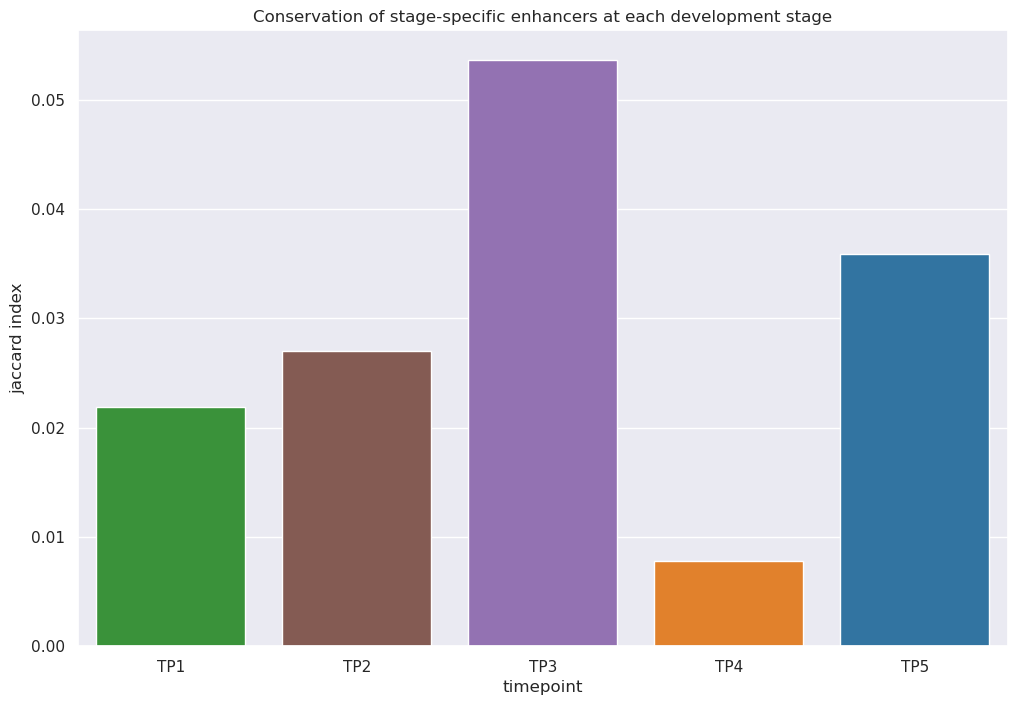

In [19]:
sns.set(rc={'figure.figsize':(12,8)})
df = pd.DataFrame.from_dict(original_res, )
df = pd.melt(df)
df.columns = ["timepoint", "jaccard index"]

ax = sns.barplot(
    x="timepoint", 
    y="jaccard index",
    data=df, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
).set(title="Conservation of stage-specific enhancers at each development stage")


# The number of peaks dominate the pattern

In [20]:
####
# read the enhancer peak files again
####
all_dmel, all_dvir = get_peaks(bedfiles, timepoint_specific=False)

In [21]:
####
# We convert the peaks into onehot format
# This way we can easily shuffle whether peaks are present or not
# We only keep peaks that are not present in **all** time points
####

def nearest_keep_missing(gr1, gr2):
    """
    https://github.com/biocore-ntnu/pyranges/pull/263#issuecomment-1100074299
    """
    r = gr1.nearest(gr2)
    df = r.df
    chroms_missing = set(gr1.chromosomes).difference(gr2.chromosomes)
    n = gr1.nearest(gr2)
    missing_gr = pyranges.concat([gr1[c] for c in chroms_missing])
    missing_gr_double = missing_gr.join(missing_gr)

    double_columns = [c for c in missing_gr_double.columns if c.endswith("_b")]

    missing_gr_double.Start_b = -1
    missing_gr_double.End_b = -1
    missing_gr_double.Strand_b = "."

    result = pyranges.concat([n,  missing_gr_double])    
    
    return result

onehot_peaks = {}
for species, ranges in zip(["dmel", "dvir"], [all_dmel, all_dvir]):
    all_peaks = pyranges.PyRanges(pd.concat([x.df for x in ranges.values()])).merge()
    index = all_peaks.df["Chromosome"] + ":" + all_peaks.df["Start"].astype(str) + "-" + all_peaks.df["End"].astype(str)
    setattr(all_peaks, "index", index)
    all_peaks = all_peaks.sort(by="index")
    for tp, df in ranges.items():
        setattr(all_peaks, tp, nearest_keep_missing(all_peaks, df).sort(by="index").df["Distance"] == 0)

    onehots = all_peaks.df.set_index("index")
    onehots = onehots[timepoints]
    onehot_peaks[species] = onehots

In [22]:
####
# Now we want to find all overlapping/orthologous 
####
# TODO
onehot_peaks_pyranges = pd.DataFrame(onehot_peaks["dvir"].index.str.split(r"[:-]").to_list())
onehot_peaks_pyranges.columns = ["Chromosome", "Start", "End"]
onehot_peaks_pyranges = pyranges.PyRanges(onehot_peaks_pyranges)
onehot_peaks_pyranges

# use pyranges2psl util to convert our peaks to a psl file for pslmap
psl_original = "../data/fly_peaks/droVir3_peaks_mergedenhancers.psl"
pyranges2psl({"fake_key": onehot_peaks_pyranges}, psl_original, "../data/fly_peaks/droVir3.fa.gz")

# use pslmap to find all orthologous time point specific peaks
!pslMap -chainMapFile {psl_original} ../data/fly_peaks/dm6.droVir3.all.chain ../data/fly_peaks/dvir2dmel__mergedenhancers.psl

# read the conversions from pslmap
peak_conversion_mergedenhancers = pd.read_table("../data/fly_peaks/dvir2dmel__mergedenhancers.psl", header=None)

# only keep one-to-one orthologs
peak_conversion_mergedenhancers = peak_conversion_mergedenhancers.drop_duplicates(subset=[9], keep=False)

In [23]:
nr_repeats = 1_000
timepoints = ["TP1", "TP2", "TP3", "TP4", "TP5"]

def sample_onehot(onehot_table):
    onehots = onehot_table.copy()

    res = dict()
    for tp in onehots.columns:
        onehots[tp] = onehots[tp].sample(frac=1).values
    # find the number of timepoint specific
    for tp in onehots.columns:
        indices = pd.DataFrame(onehots[(onehots[tp] == True) & (onehots.sum(axis=1) == 1)].index.str.split(r"[:-]").to_list())
        indices.columns = ["Chromosome", "Start", "End"]
        indices = pyranges.PyRanges(indices)
        res[tp] = indices
    
    return res

sampled_res_all_enh = {tp: [] for tp in timepoints}
for i in range(nr_repeats):
    enh_dmel = sample_onehot(onehot_peaks["dmel"])
    enh_dvir = sample_onehot(onehot_peaks["dvir"])
    
    res = jaccard_peaks(enh_dmel, enh_dvir, peak_conversion_mergedenhancers, timepoints=timepoints)
    for k, v in res.items():
        sampled_res_all_enh[k].append(v)

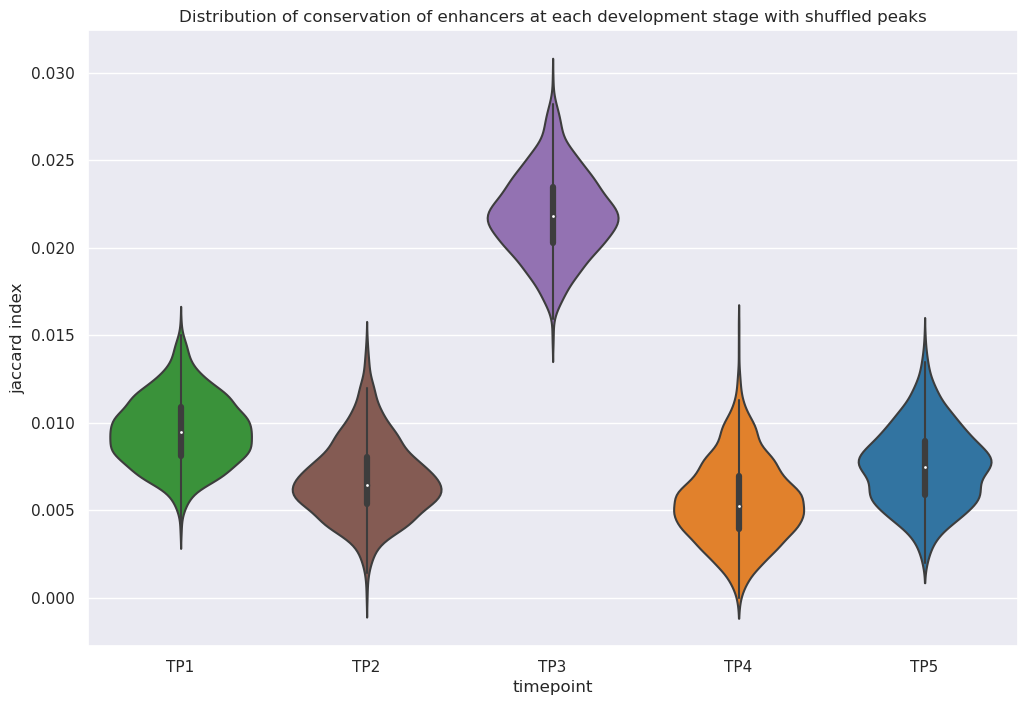

In [24]:
df = pd.melt(pd.DataFrame.from_dict(sampled_res_all_enh))
df.columns = ["timepoint", "jaccard index"]

# df["jaccard index"] = [original_res[tp][0] for tp in df["timepoint"]] - df["jaccard index"]
ax = sns.violinplot(
    x="timepoint", 
    y="jaccard index",
    data=df, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
).set(title="Distribution of conservation of enhancers at each development stage with shuffled peaks")

# Sampling of enhancers

The uneven number of peaks between different time points and species can introduce a bias. If we were to sample an equal amount of peaks for each combination then the comparison should be more fair. If we do this however, then TP3 does not seem to be more/less conserved than the other stages...

In [25]:
def subset_onehot(onehot_table, nr_peaks):
    onehots = onehot_table.copy()

    res = dict()
    for i, tp in enumerate(onehots.columns):
        subsetted_peaks = np.random.choice(np.where(onehots[tp])[0], nr_peaks, replace=False)
        onehots[tp] = False
        onehots.iloc[subsetted_peaks, i] = True

    # find the number of timepoint specific
    for tp in onehots.columns:
        indices = pd.DataFrame(onehots[(onehots[tp] == True) & (onehots.sum(axis=1) == 1)].index.str.split(r"[:-]").to_list())
        indices.columns = ["Chromosome", "Start", "End"]
        indices = pyranges.PyRanges(indices)
        res[tp] = indices
    
    return res


nr_peaks = 2_000
nr_repeats = 1_000
timepoints = ["TP1", "TP2", "TP3", "TP4", "TP5"]


sampled_res = {tp: [] for tp in timepoints}
for i in range(nr_repeats):
    enh_dmel = subset_onehot(onehot_peaks["dmel"], nr_peaks)
    enh_dvir = subset_onehot(onehot_peaks["dvir"], nr_peaks)
    
    res = jaccard_peaks(enh_dmel, enh_dvir, peak_conversion_mergedenhancers, timepoints=timepoints)
    for k, v in res.items():
        sampled_res[k].append(v)

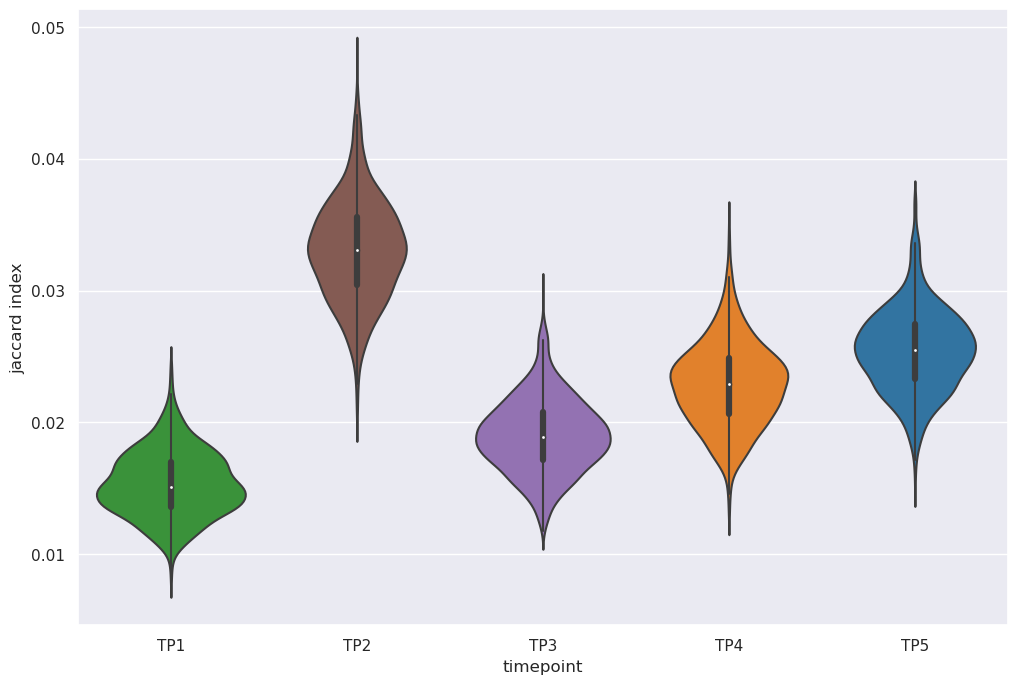

In [26]:
import seaborn as sns


sns.set(rc={'figure.figsize':(12,8)})
# sns.set_theme(style='white', font_scale=1.5)

df = pd.DataFrame.from_dict(sampled_res)
df = pd.melt(df)
df.columns = ["timepoint", "jaccard index"]

ax = sns.violinplot(
    x="timepoint", 
    y="jaccard index",
    data=df, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
)

# ax.set(title="Distribution of conservation of stage-specific enhancers at each development stage with equal number of peaks")


# ax = plt.subplot(111)
# ax.spines[['right', 'top']].set_visible(False)
# ax.set(xlabel='time point', ylabel="Jaccard index")
# plt.ylim(0)
# plt.savefig("/home/sande/Downloads/TEST.svg")

# Figure

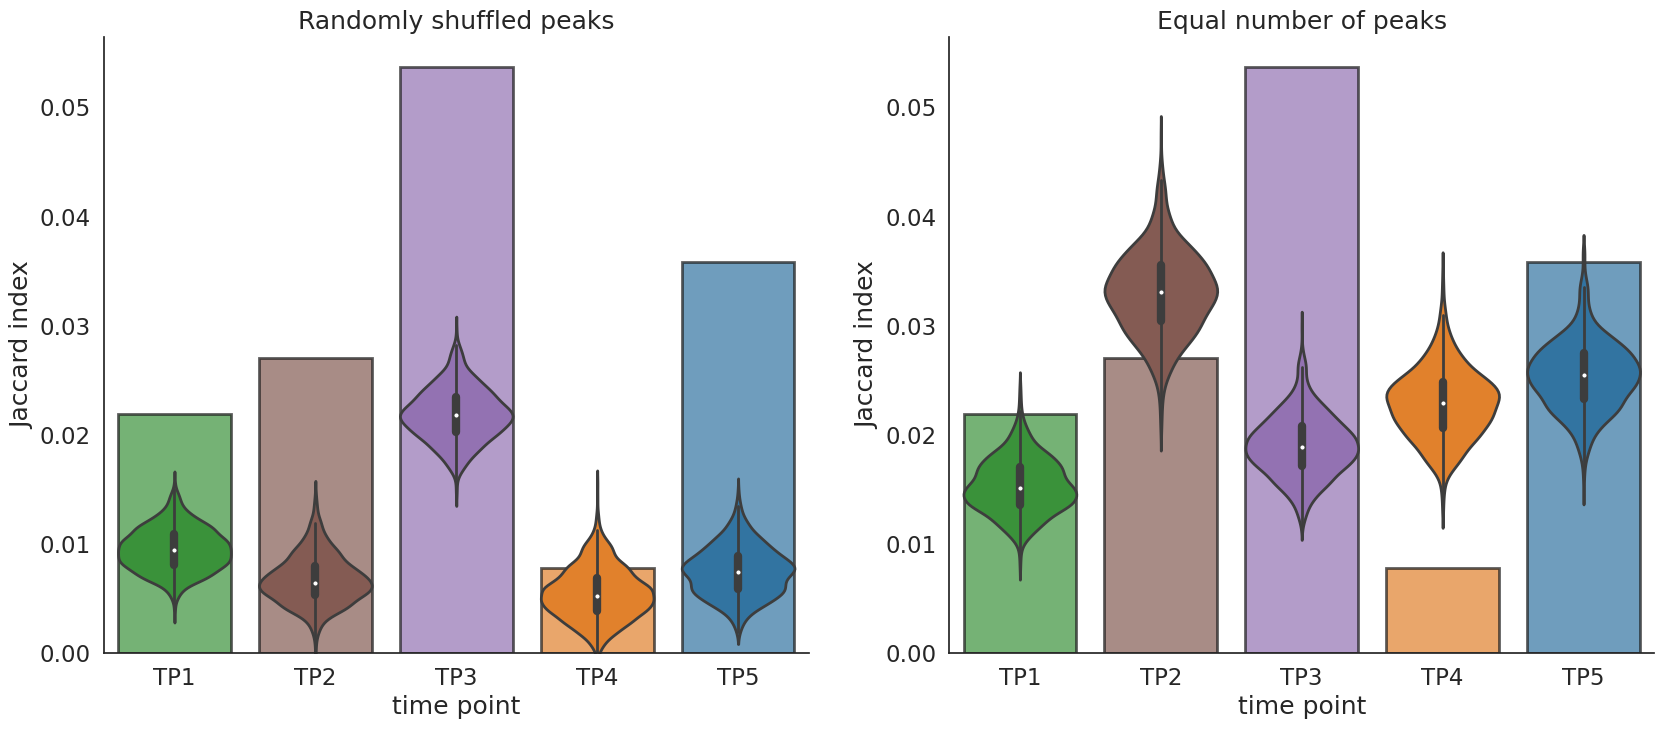

In [27]:
sns.set_theme(style='white', font_scale=1.5)
f, axs = plt.subplots(figsize=(20, 8), ncols=2, sharey=True)

for i, (df_sampling, explanation) in enumerate(zip(
    [sampled_res_all_enh, sampled_res],
    ["Randomly shuffled peaks", "Equal number of peaks"])):
    df = pd.DataFrame.from_dict(original_res, )
    df = pd.melt(df)
    df.columns = ["timepoint", "jaccard index"]

    linewidth=2

    ax = sns.barplot(
        x="timepoint",
        y="jaccard index",
        data=df, 
        palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
        linewidth=linewidth,
        edgecolor="k",
        alpha=0.7,
        ax=axs[i]
    )

    df = pd.melt(pd.DataFrame.from_dict(df_sampling))
    df.columns = ["timepoint", "jaccard index"]
    ax = sns.violinplot(
        x="timepoint", 
        y="jaccard index",
        data=df, 
        palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
        linewidth=linewidth,
        scale="width",
        ax=axs[i]
    )

    axs[i].spines[['right', 'top']].set_visible(False)
    axs[i].set(xlabel='time point', ylabel="Jaccard index")
    axs[i].set_ylim(0)
    axs[i].set_title(explanation)
    
    ax.yaxis.set_tick_params(labelbottom=True)
#     ax.xaxis.set_tick_params(labelbottom=True)
# plt.savefig("/home/sande/Downloads/TEST.svg")

/tmp/ipykernel_128147/3887035653.py:39: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax_1 = axs[1, 1].bar(data=within_species_jaccard.loc[within_species_jaccard.species=="D. melanogaster"].groupby("time point").mean().reset_index(), x="time point", height="jaccard", width=-width, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")
/tmp/ipykernel_128147/3887035653.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax_2 = axs[1, 1].bar(data=within_species_jaccard.loc[within_species_jaccard.species!="D. melanogaster"].groupby("time poin

0 True
1 False
2 True
3 False
4 True
5 False
6 True
7 False
8 True
9 False
0 True
1 False
2 True
3 False
4 True
5 False
6 True
7 False
8 True
9 False
0 True
1 False
2 True
3 False
4 True
5 False
6 True
7 False
8 True
9 False
0 True
1 False
2 True
3 False
4 True
5 False
6 True
7 False
8 True
9 False


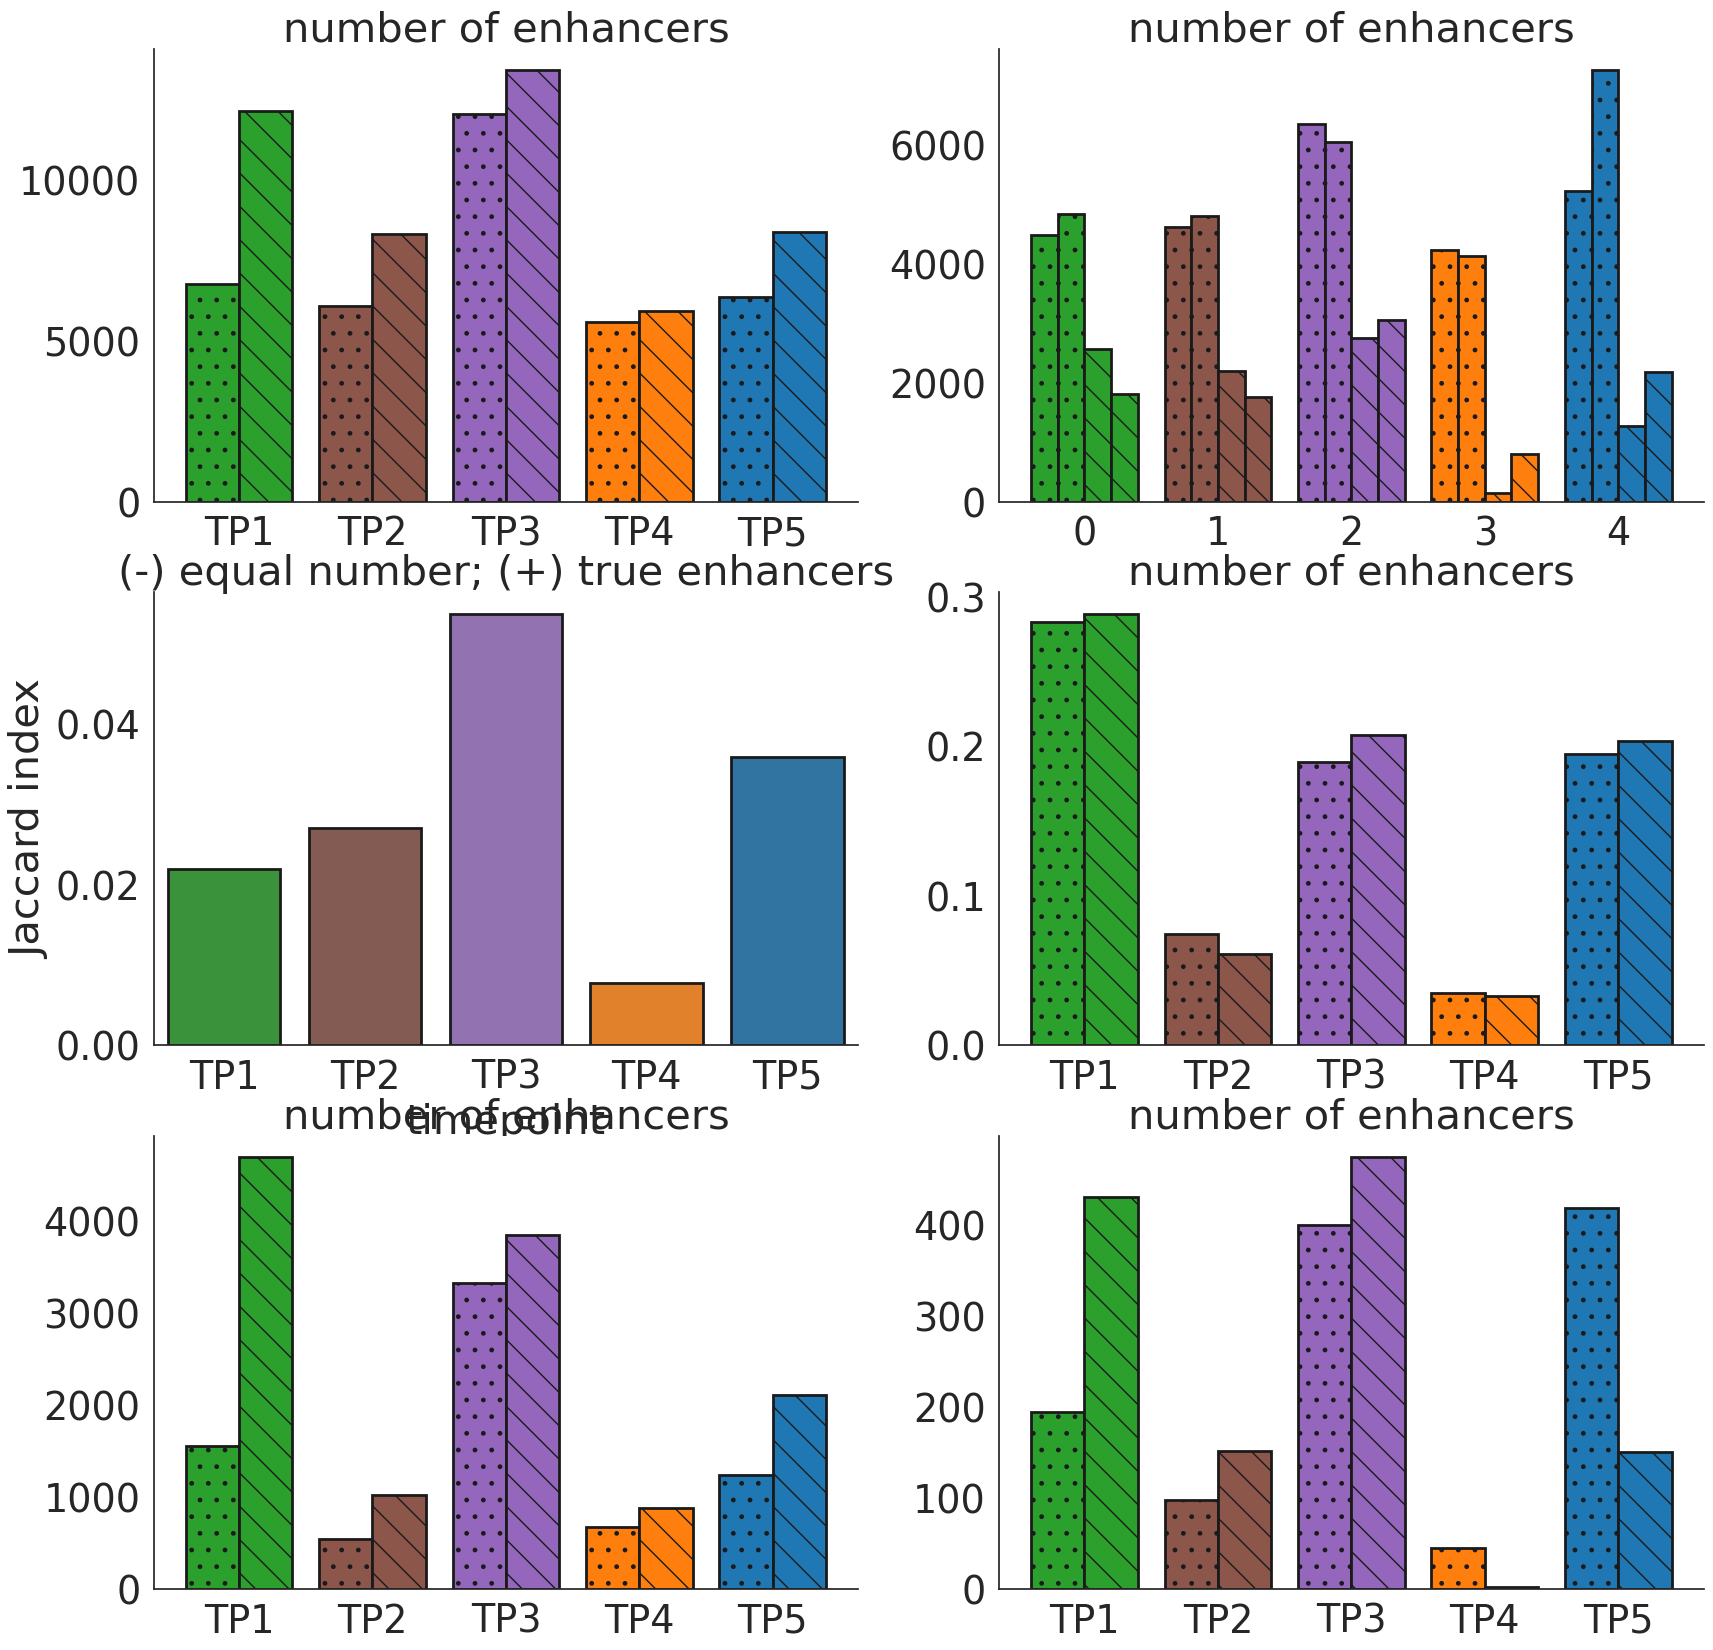

In [28]:
sns.set_theme(style='white', font_scale=2.5)
f, axs = plt.subplots(figsize=(20, 20), nrows=3, ncols=2)

# axs[0, 0].get_shared_y_axes().join(axs[0, 0], axs[0, 1])
# axs[1, 0].get_shared_y_axes().join(axs[1, 0], axs[1, 1])
# axs[2, 0].get_shared_y_axes().join(axs[2, 0], axs[2, 1])


linewidth=2

# within replicate
# number of enhancers
width = 0.4
diff = 0.00
idxs = np.arange(5, dtype=float) - 2 * width / 2 - diff / 2

patch_axs = []
for assembly in ["dm6", "droVir3"]:
    for rep in ["rep1", "rep2"]:
        data = number_of_enhancers.loc[(number_of_enhancers.species==assembly2species[assembly]) & (number_of_enhancers.replicate==rep)]["nr enhancers"]
        _ax = axs[0, 1].bar(idxs, data, width=width/2, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")
        patch_axs.append(_ax)
        idxs += width / 2
    idxs += diff

for i, bar in enumerate([patch for _ax in patch_axs for patch in _ax.patches]):
    if i >= 10:
        bar.set_hatch("\\")
    else:
        bar.set_hatch(".")

axs[0, 1].spines[['right', 'top']].set_visible(False)
axs[0, 1].set(
    title="number of enhancers", 
    ylim=0
)

# jaccard index
ax_1 = axs[1, 1].bar(data=within_species_jaccard.loc[within_species_jaccard.species=="D. melanogaster"].groupby("time point").mean().reset_index(), x="time point", height="jaccard", width=-width, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")
ax_2 = axs[1, 1].bar(data=within_species_jaccard.loc[within_species_jaccard.species!="D. melanogaster"].groupby("time point").mean().reset_index(), x="time point", height="jaccard", width=+width, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")

# ax = sns.violinplot(
#     x="time point",
#     y="jaccard",
#     hue="species",
#     data=within_species_jaccard, 
# #     palette=["k", "k"],
#     linewidth=linewidth,
#     dodge=True,
#     ax=axs[1, 1],
#     edgecolor="k",
# )

for i, bar in enumerate(ax_1.patches + ax_2.patches):
    print(i, i % 2 == 0)
    if i >= 5:
        bar.set_hatch("\\")
    else:
        bar.set_hatch(".")
    
axs[1, 1].spines[['right', 'top']].set_visible(False)
axs[1, 1].set(
    title="number of enhancers", 
    ylim=0
)


# number time point specific enhancers
ax_1 = axs[2, 1].bar(data=number_timepoint_specific.loc[number_timepoint_specific.species=="D. melanogaster"].groupby("time point").mean().reset_index(), x="time point", height="time point specific enhancers", width=-width, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")
ax_2 = axs[2, 1].bar(data=number_timepoint_specific.loc[number_timepoint_specific.species!="D. melanogaster"].groupby("time point").mean().reset_index(), x="time point", height="time point specific enhancers", width=+width, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")

# ax = sns.violinplot(
#     x="time point",
#     y="time point specific enhancers",
#     hue="species",
#     data=number_timepoint_specific, 
#     palette={"D. melanogaster": (0.1, 0.2, 0.5, 0.3), "D. virilis": (0.1, 0.2, 0.5, 0.3)},
#     alpha=0.5,
#     linewidth=linewidth,
#     dodge=True,
#     ax=axs[2, 1],
#     edgecolor="k",
# )

for i, bar in enumerate(ax_1.patches + ax_2.patches):
    print(i, i % 2 == 0)
    if i >= 5:
        bar.set_hatch("\\")
    else:
        bar.set_hatch(".")
    
axs[2, 1].spines[['right', 'top']].set_visible(False)
axs[2, 1].set(
    title="number of enhancers", 
    ylim=0
)

# Between species
# number of enhancers
enhancer_nr = pd.concat([
    pd.DataFrame([[len(open(f).readlines()) for f in bedfiles[0]], timepoints, ["drosophila melanogaster"] * 5]).T,
    pd.DataFrame([[len(open(f).readlines()) for f in bedfiles[1]], timepoints, ["drosophila virilis"] * 5]).T
])
enhancer_nr.columns = ["number of peaks", "timepoint", "species"]

ax_1 = axs[0, 0].bar(data=enhancer_nr.loc[enhancer_nr.species=="drosophila melanogaster"], x="timepoint", height="number of peaks", width=-0.4, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")
ax_2 = axs[0, 0].bar(data=enhancer_nr.loc[enhancer_nr.species!="drosophila melanogaster"], x="timepoint", height="number of peaks", width=0.4, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")

for i, bar in enumerate(ax_1.patches + ax_2.patches):
    print(i, i % 2 == 0)
    if i >= 5:
        bar.set_hatch("\\")
    else:
        bar.set_hatch(".")
    
axs[0, 0].spines[['right', 'top']].set_visible(False)
axs[0, 0].set(
    title="number of enhancers", 
    ylim=0
)

# final res
df = pd.DataFrame.from_dict(original_res).melt(var_name="timepoint", value_name="Jaccard index")

ax = sns.barplot(
    x="timepoint",
    y="Jaccard index",
    data=df, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
    linewidth=linewidth,
    edgecolor="k",
    ax=axs[1, 0]
)


axs[1, 0].spines[['right', 'top']].set_visible(False)
axs[1, 0].set(
#     title="Original result (proportion conserved enhancers)", 
    title="(-) equal number; (+) true enhancers",
    ylim=0
)

# number of tp-specific enhancers
df = pd.concat([
    pd.DataFrame([[tp_specific_dmel[tp].df.shape[0] for tp in timepoints], timepoints, ["drosophila melanogaster"] * 5]).T,
    pd.DataFrame([[tp_specific_dvir[tp].df.shape[0] for tp in timepoints], timepoints, ["drosophila virilis"] * 5]).T,
])
df.columns = ["number of tp-specific enhancers", "timepoint", "species"]

ax_1 = axs[2, 0].bar(data=df.loc[df.species=="drosophila melanogaster"], x="timepoint", height="number of tp-specific enhancers", width=-0.4, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")
ax_2 = axs[2, 0].bar(data=df.loc[df.species!="drosophila melanogaster"], x="timepoint", height="number of tp-specific enhancers", width=0.4, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")

for i, bar in enumerate(ax_1.patches + ax_2.patches):
    print(i, i % 2 == 0)
    if i >= 5:
        bar.set_hatch("\\")
    else:
        bar.set_hatch(".")
    
axs[2, 0].spines[['right', 'top']].set_visible(False)
axs[2, 0].set(
    title="number of enhancers", 
    ylim=0
)

plt.savefig("../imgs/fly_peaks_together.svg")

/tmp/ipykernel_128147/23876430.py:3: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1].get_shared_y_axes().join(axs[0], axs[1])


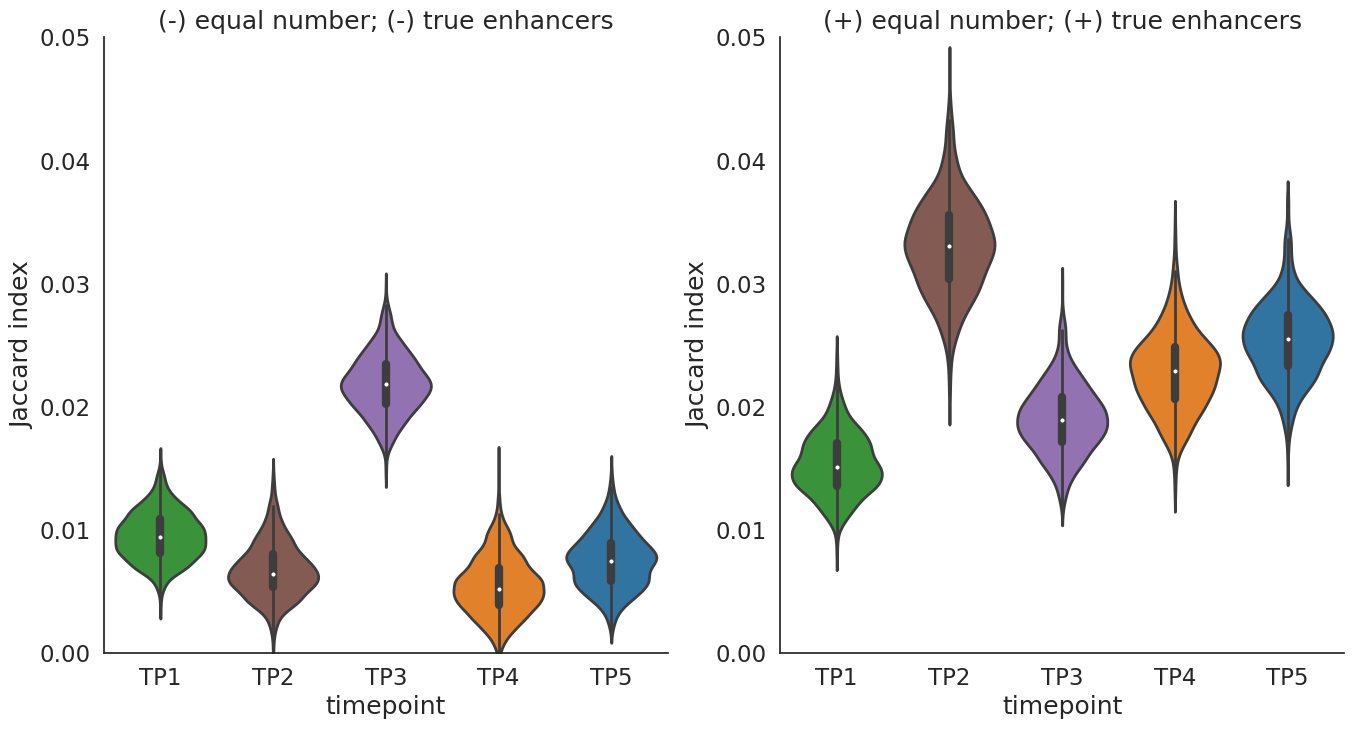

In [29]:
sns.set_theme(style='white', font_scale=1.5)
f, axs = plt.subplots(figsize=(16, 8), nrows=1, ncols=2) #, sharey=True)
axs[1].get_shared_y_axes().join(axs[0], axs[1])


linewidth=2


# dsadsadsda
df = pd.DataFrame.from_dict(sampled_res_all_enh).melt(var_name="timepoint", value_name="Jaccard index")

ax = sns.violinplot(
    x="timepoint", 
    y="Jaccard index",
    data=df, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
    linewidth=linewidth,
    scale="width",
    ax=axs[0]
)

axs[0].spines[['right', 'top']].set_visible(False)
axs[0].set(
#     title="Randomly shuffled peaks", 
    title="(-) equal number; (-) true enhancers",
#     ylabel="",
    ylim=0
)
ax.yaxis.set_tick_params(labelbottom=True)


# equal number of peaks
df = pd.DataFrame.from_dict(sampled_res).melt(var_name="timepoint", value_name="Jaccard index")
ax = sns.violinplot(
    x="timepoint", 
    y="Jaccard index",
    data=df, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
    linewidth=linewidth,
    scale="width",
    ax=axs[1]
)

axs[1].spines[['right', 'top']].set_visible(False)
axs[1].set(
    title="(+) equal number; (+) true enhancers",
    #     title="equally sampled number of TP-specific enhancers", 
#     ylabel="",
    ylim=[0, 0.05]
)
ax.yaxis.set_tick_params(labelbottom=True)
plt.savefig("../imgs/fly_shuffle.svg")

/tmp/ipykernel_128147/4037341897.py:4: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0, 1].get_shared_y_axes().join(axs[0, 1], axs[1, 0], axs[1, 1])


0 True
1 False
2 True
3 False
4 True
5 False
6 True
7 False
8 True
9 False


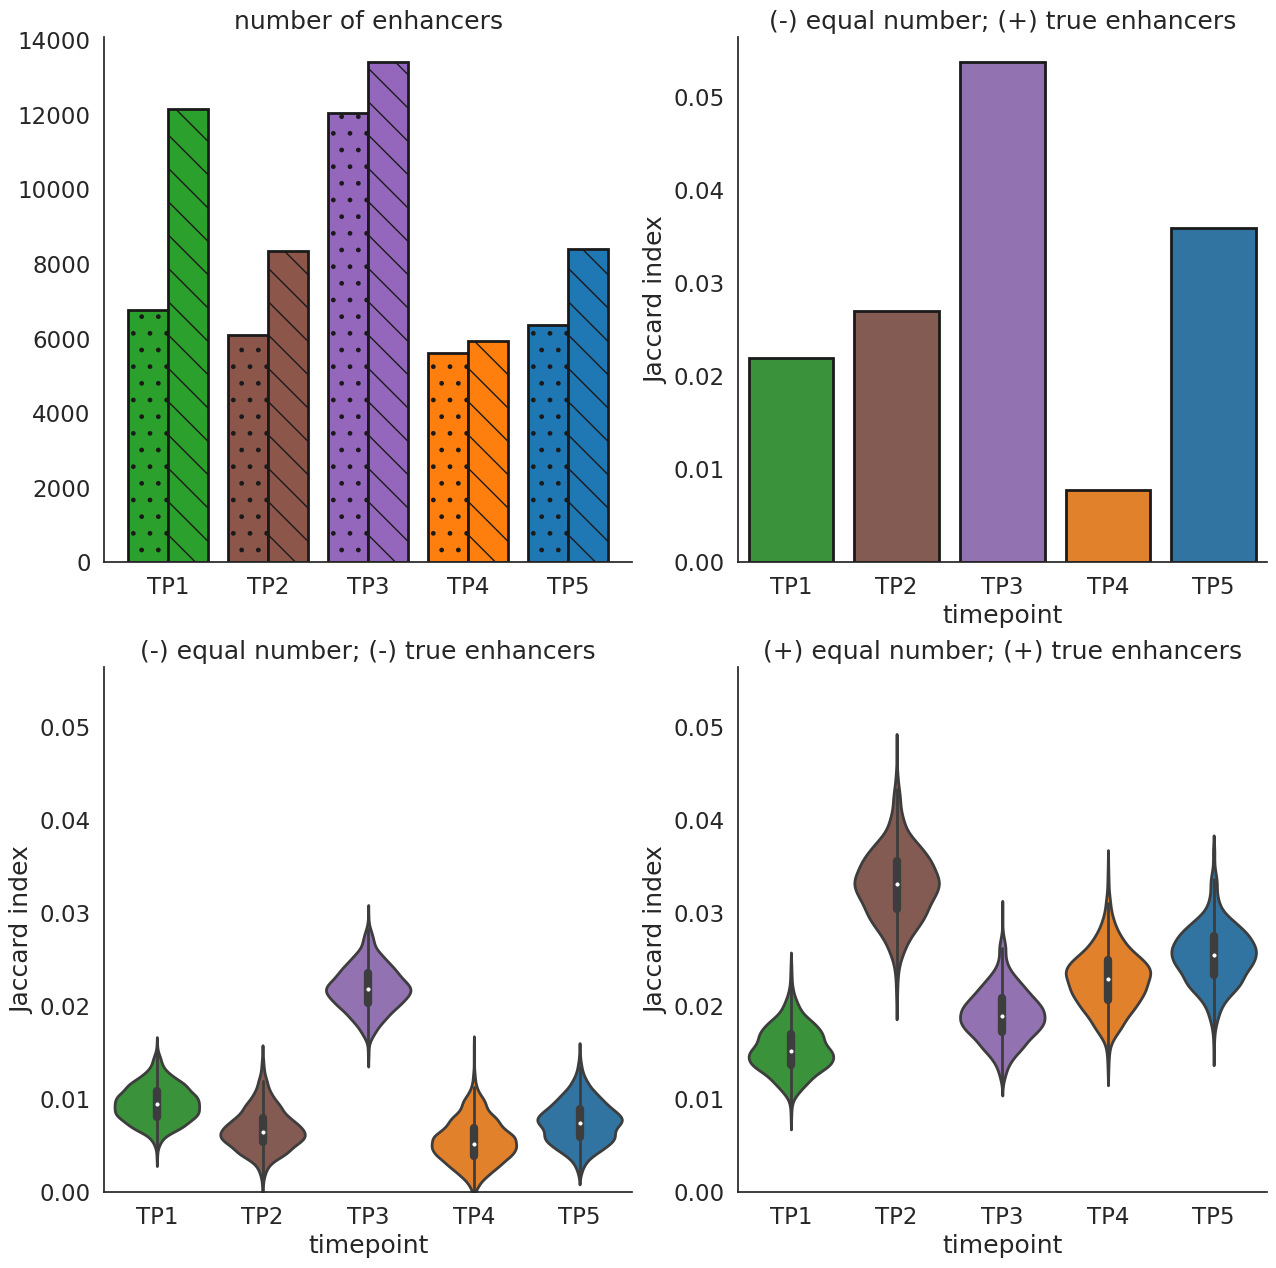

In [30]:
sns.set_theme(style='white', font_scale=1.5)
# f, axs = plt.subplots(figsize=(25, 6), ncols=3, sharey=True)
f, axs = plt.subplots(figsize=(15, 15), nrows=2, ncols=2) #, sharey=True)
axs[0, 1].get_shared_y_axes().join(axs[0, 1], axs[1, 0], axs[1, 1])


linewidth=2

# number of peaks
df = pd.concat([
    pd.DataFrame([[len(open(f).readlines()) for f in bedfiles[0]], timepoints, ["drosophila melanogaster"] * 5]).T,
    pd.DataFrame([[len(open(f).readlines()) for f in bedfiles[1]], timepoints, ["drosophila virilis"] * 5]).T
])
df.columns = ["number of peaks", "timepoint", "species"]

ax_1 = axs[0, 0].bar(data=df.loc[df.species=="drosophila melanogaster"], x="timepoint", height="number of peaks", width=-0.4, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")
ax_2 = axs[0, 0].bar(data=df.loc[df.species!="drosophila melanogaster"], x="timepoint", height="number of peaks", width=0.4, align='edge', color=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"], linewidth=linewidth, edgecolor="k")

for i, bar in enumerate(ax_1.patches + ax_2.patches):
    print(i, i % 2 == 0)
    if i >= 5:
        bar.set_hatch("\\")
    else:
        bar.set_hatch(".")
    
axs[0, 0].spines[['right', 'top']].set_visible(False)
axs[0, 0].set(
    title="number of enhancers", 
    ylim=0
)

# original result
df = pd.DataFrame.from_dict(original_res).melt(var_name="timepoint", value_name="Jaccard index")

ax = sns.barplot(
    x="timepoint",
    y="Jaccard index",
    data=df, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
    linewidth=linewidth,
    edgecolor="k",
    ax=axs[0, 1]
)


axs[0, 1].spines[['right', 'top']].set_visible(False)
axs[0, 1].set(
#     title="Original result (proportion conserved enhancers)", 
    title="(-) equal number; (+) true enhancers",
    ylim=0
)


# dsadsadsda
df = pd.DataFrame.from_dict(sampled_res_all_enh).melt(var_name="timepoint", value_name="Jaccard index")

ax = sns.violinplot(
    x="timepoint", 
    y="Jaccard index",
    data=df, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
    linewidth=linewidth,
    scale="width",
    ax=axs[1, 0]
)

axs[1, 0].spines[['right', 'top']].set_visible(False)
axs[1, 0].set(
#     title="Randomly shuffled peaks", 
    title="(-) equal number; (-) true enhancers",
#     ylabel="",
    ylim=0
)
ax.yaxis.set_tick_params(labelbottom=True)


# equal number of peaks
df = pd.DataFrame.from_dict(sampled_res).melt(var_name="timepoint", value_name="Jaccard index")
ax = sns.violinplot(
    x="timepoint", 
    y="Jaccard index",
    data=df, 
    palette=["tab:green", "tab:brown", "tab:purple", "tab:orange", "tab:blue"],
    linewidth=linewidth,
    scale="width",
    ax=axs[1, 1]
)

axs[1, 1].spines[['right', 'top']].set_visible(False)
axs[1, 1].set(
    title="(+) equal number; (+) true enhancers",
    #     title="equally sampled number of TP-specific enhancers", 
#     ylabel="",
    ylim=0
)
ax.yaxis.set_tick_params(labelbottom=True)

plt.savefig("../imgs/fly_peaks.svg")

In [31]:
# timepoints=["TP1", "TP2", "TP3", "TP4", "TP5"]
# enhancers = {
#     assembly: df[df["peak type"] == "enhancer"].index.to_list() for assembly, df in peak_types.items()
# }

# number_of_peaks = []
# reps = {
#     "TP1": {0, 5},
#     "TP2": {1, 6},
#     "TP3": {2, 7},
#     "TP4": {3, 8},
#     "TP5": {4, 9},
# }

# for assembly in ["dm6", "droVir3"]:
#     onehots = pd.read_table(f"/vol/rerun_dm6/results_dm6/counts/macs2/{assembly}_onehotpeaks.tsv", comment="#", index_col=0)
#     onehots = onehots.loc[enhancers[assembly]]
#     print(onehots.sum(axis="rows").sum())



In [32]:
assemblies = ["dm6", "droVir3"]

onehots = dict()
peak_types = dict()
for assembly in assemblies:
    # read the one hot peaks
    onehots[assembly] = pd.read_table(f"/vol/rerun_dm6/results/counts/macs2/{assembly}_onehotpeaks.tsv", comment="#", index_col=0)

    # read the peak types
    peak_types[assembly] = pd.DataFrame(index=onehots[assembly].index, columns=["peak type"])
    peak_types[assembly].values[:] = "enhancer"

    # find the closest promoter in the gtf
    df = pyranges.PyRanges(pd.DataFrame(onehots[assembly].reset_index()["index"].str.split("[:-]").to_list(), columns=["Chromosome", "Start", "End"]))
    gtf = pyranges.read_gtf(f"/vol/rerun_dm6/genomes/{assembly}/{assembly}.annotation.gtf")

    if assembly == "dm6":
        tss = gtf.features.tss()
    else:
        tss = gtf[gtf.Feature == "start_codon"]
    
    distances = df.nearest(tss)
    distances = distances[distances.df["Distance"] < 1000]

    # and put it in the peak types table
    proms = distances.df["Chromosome"].astype(str) + ":" + distances.df["Start"].astype(str) + "-" + distances.df["End"].astype(str)
    peak_types[assembly].loc[proms] = "promoter"

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


In [40]:
# peak_types["droVir3"][peak_types["droVir3"]["peak type"] == "enhancer"]

In [41]:
molten = dict()

for assembly in assemblies:
    onehot = onehots[assembly]
    peak_type = peak_types[assembly]
    molten[assembly] = onehot.melt(ignore_index=False, var_name="timepoint", value_name="presence")
    molten[assembly]["peak type"] = "enhancer"
    molten[assembly]["peak type"].loc[peak_type[peak_type["peak type"] == "promoter"].index] = "promoter"

/tmp/ipykernel_101757/3940119451.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molten[assembly]["peak type"].loc[peak_type[peak_type["peak type"] == "promoter"].index] = "promoter"
/tmp/ipykernel_101757/3940119451.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molten[assembly]["peak type"].loc[peak_type[peak_type["peak type"] == "promoter"].index] = "promoter"


In [42]:
molten

{'dm6':                                 timepoint  presence peak type
 chr2L:5856-5857                  m_2_rep1         1  enhancer
 chr2L:6726-6727                  m_2_rep1         1  enhancer
 chr2L:7862-7863                  m_2_rep1         1  enhancer
 chr2L:8436-8437                  m_2_rep1         0  enhancer
 chr2L:16367-16368                m_2_rep1         0  enhancer
 ...                                   ...       ...       ...
 chrY_DS485764v1_random:942-943  m_18_rep1         0  enhancer
 chrY_DS485888v1_random:197-198  m_18_rep1         1  enhancer
 chrY_DS485927v1_random:281-282  m_18_rep1         1  enhancer
 chrY_DS485963v1_random:103-104  m_18_rep1         1  enhancer
 chrY_DS485975v1_random:619-620  m_18_rep1         1  enhancer
 
 [148305 rows x 3 columns],
 'droVir3':                           timepoint  presence peak type
 scaffold_10:1417-1418      v_2_rep1         1  enhancer
 scaffold_10019:850-851     v_2_rep1         1  enhancer
 scaffold_10019:2476-2477

<AxesSubplot: ylabel='timepoint'>

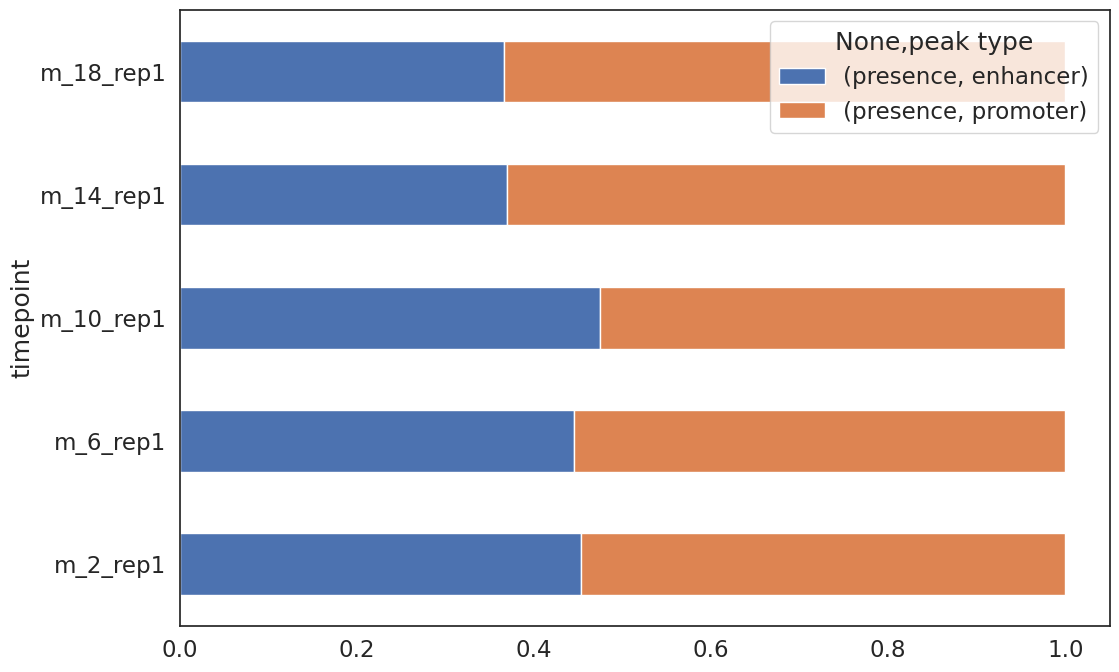

In [43]:
assembly = "dm6"

tps = {
    "dm6": ["m_2_rep1", "m_6_rep1", "m_10_rep1", "m_14_rep1", "m_18_rep1"],
    "droVir3": ["v_2_rep1", "v_7_rep1", "v_14_rep1", "v_19_rep1", "v_25_rep1"]
}

data = molten[assembly].groupby(["timepoint", "peak type"]).sum()
data = (data / data.groupby(level=0).sum())
data = data.reset_index()
data.pivot(index="timepoint", columns=["peak type"]).loc[tps[assembly]].plot.barh(stacked=True)


In [44]:
counts = dict()

for assembly in assemblies:
    counts[assembly] = pd.read_table(f"/vol/rerun_dm6/results/counts/macs2/{assembly}_raw_technical_reps.tsv", comment="#", index_col=0)
counts


{'dm6':                                  m_2_rep1  m_6_rep1  m_10_rep1  m_14_rep1  \
 chr2L:5756-5956                     218.0      73.0       87.0       66.0   
 chr2L:6626-6826                     110.0      26.0       47.0       27.0   
 chr2L:7762-7962                      95.0      21.0       45.0       28.0   
 chr2L:8336-8536                      77.0      33.0       46.0       63.0   
 chr2L:16267-16467                    46.0      28.0       85.0      102.0   
 ...                                   ...       ...        ...        ...   
 chrY_DS485764v1_random:842-1042      82.0      60.0       74.0       72.0   
 chrY_DS485888v1_random:97-297       105.0      86.0       81.0       50.0   
 chrY_DS485927v1_random:181-381      170.0     107.0      157.0      148.0   
 chrY_DS485963v1_random:3-203        117.0      75.0       95.0       83.0   
 chrY_DS485975v1_random:519-719      237.0     154.0      177.0      183.0   
 
                                  m_18_rep1  
 chr2L:57

In [21]:
molten = dict()

for assembly in assemblies:
    molten[assembly] = counts[assembly].melt(ignore_index=False, var_name="timepoint", value_name="presence")
    molten[assembly]["peak type"] = "enhancer"
    peak_type = peak_types[assembly]

    promoter_index = [f"{chrom}:{int(start)-100}-{int(stop)+99}" for chrom, start, stop in peak_type[peak_type["peak type"] == "promoter"].index.str.split("[:-]").to_list()]

    # promoter_index = set(promoter_index) & set(molten.index)
    molten[assembly]["peak type"].loc[promoter_index] = "promoter"
molten

/tmp/ipykernel_5458/2342901323.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molten[assembly]["peak type"].loc[promoter_index] = "promoter"
/tmp/ipykernel_5458/2342901323.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molten[assembly]["peak type"].loc[promoter_index] = "promoter"


{'dm6':                                  timepoint  presence peak type
 chr2L:5756-5956                   m_2_rep1     218.0  enhancer
 chr2L:6626-6826                   m_2_rep1     110.0  enhancer
 chr2L:7762-7962                   m_2_rep1      95.0  enhancer
 chr2L:8336-8536                   m_2_rep1      77.0  enhancer
 chr2L:16267-16467                 m_2_rep1      46.0  enhancer
 ...                                    ...       ...       ...
 chrY_DS485764v1_random:842-1042  m_18_rep1      40.0  enhancer
 chrY_DS485888v1_random:97-297    m_18_rep1      54.0  enhancer
 chrY_DS485927v1_random:181-381   m_18_rep1     100.0  enhancer
 chrY_DS485963v1_random:3-203     m_18_rep1      55.0  enhancer
 chrY_DS485975v1_random:519-719   m_18_rep1     134.0  enhancer
 
 [148290 rows x 3 columns],
 'droVir3':                           timepoint  presence peak type
 scaffold_10:1317-1517      v_2_rep1      70.0  enhancer
 scaffold_10019:750-950     v_2_rep1      62.0  enhancer
 scaffold_100

<AxesSubplot: ylabel='timepoint'>

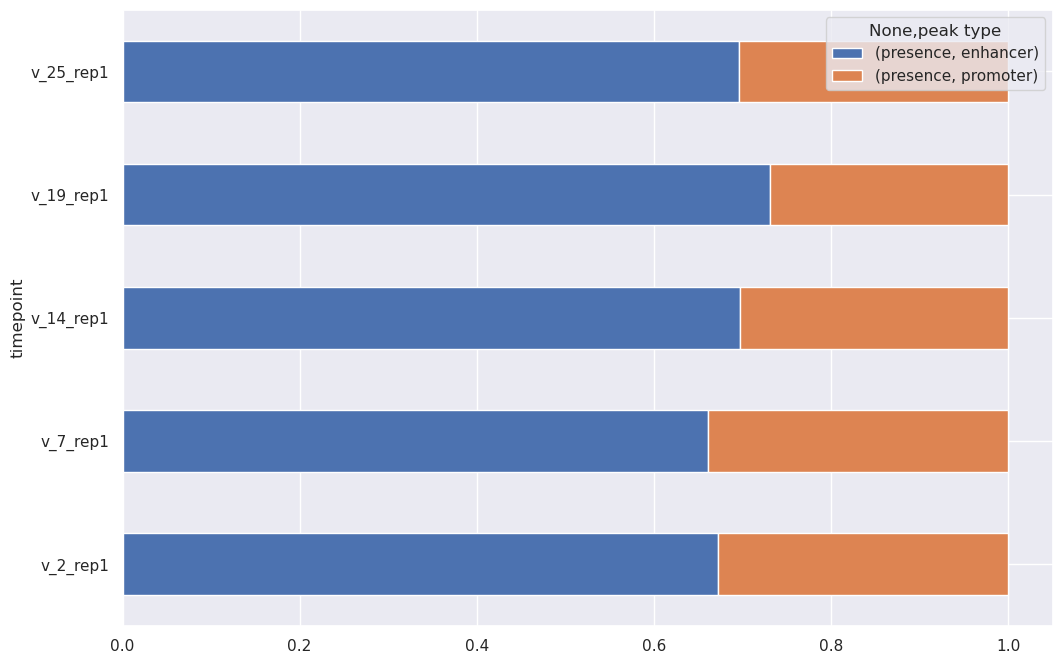

In [22]:
assembly = "droVir3"

data = molten[assembly].groupby(["timepoint", "peak type"]).sum()
total_reads = {
    "m_2_rep1": 17127326,
    "m_6_rep1": 11574733,
    "m_10_rep1": 19327562,
    "m_14_rep1": 14820338,
    "m_18_rep1": 11417275
}

# data = data.reset_index().pivot(index="timepoint", columns=["peak type"])
# data.columns = [x[1] for x in data.columns]
# data = data.loc[total_reads.keys()]
# # data["a not peak"] = [total-peak for total, peak in zip(total_reads.values(), data.sum(axis="columns"))]
# data = data.reset_index()
# data = data.melt(id_vars=["timepoint"], var_name="peak type", value_name="count")
data = data.groupby(["timepoint", "peak type"]).sum()

data = (data / data.groupby(level=0).sum()).reset_index()
data.pivot(index="timepoint", columns=["peak type"]).loc[tps[assembly]].plot.barh(stacked=True)

In [23]:
values_enhancer = dict()
values_promotor = dict()
for assembly in ["dm6", "droVir3"]:
    data = molten[assembly].groupby(["timepoint", "peak type"]).sum()
    data = (data / data.groupby(level=0).sum())
    values_enhancer[assembly] = list(data.loc[[[tp, "enhancer"] for tp in tps[assembly]]].values[:, 0] * 100)
    values_promotor[assembly] = list(data.loc[[[tp, "promoter"] for tp in tps[assembly]]].values[:, 0] * 100)
values_enhancer

{'dm6': [47.658878609723175,
  47.5551520663507,
  46.98697393282325,
  46.24533869857929,
  42.41675263118672],
 'droVir3': [67.20385278573808,
  66.07836577553118,
  69.74690410181711,
  73.08561104805976,
  69.56971171505988]}

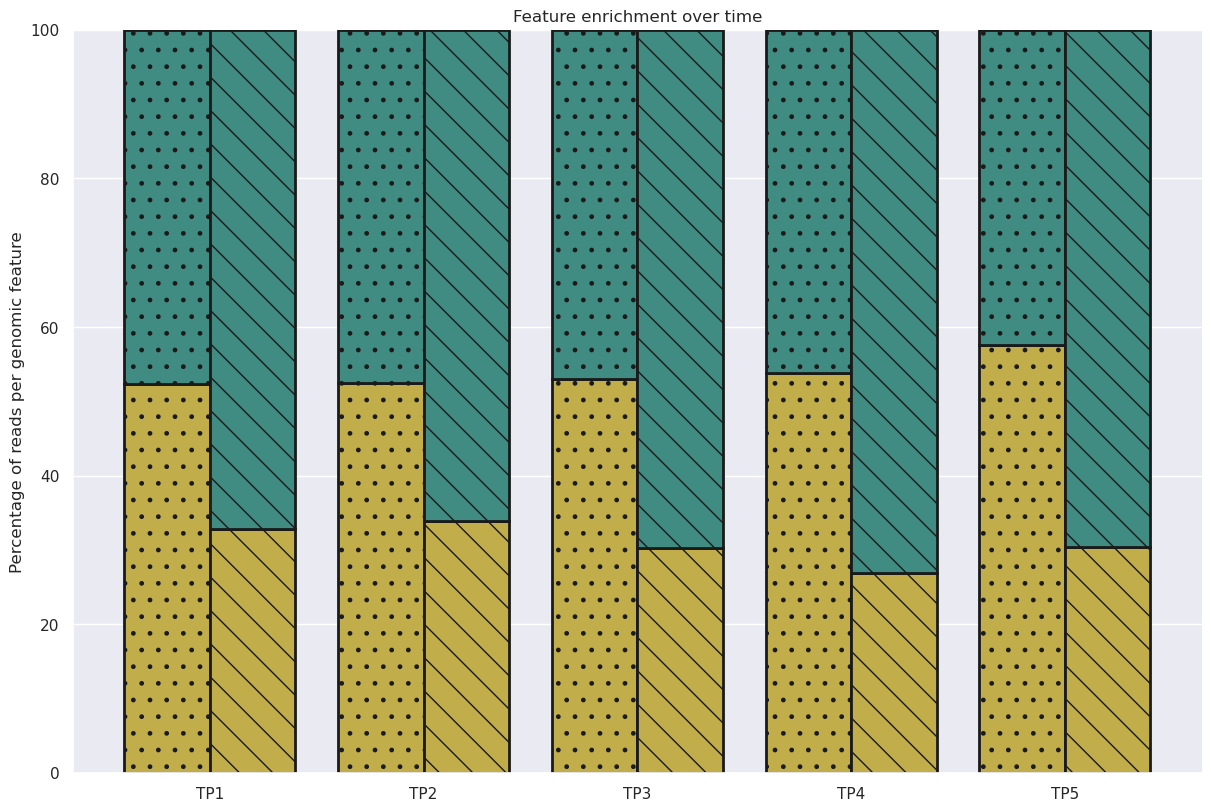

In [24]:
timepoints = ["TP1", "TP2", "TP3", "TP4", "TP5"]
linewidth=2
x = np.arange(len(timepoints))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')


for assembly in assemblies:
    enhancer_measure = values_enhancer[assembly]
    promoter_measure = values_promotor[assembly]
    offset = width * multiplier
    c1 = "#c2ad4b"
    c2 = "#418c82"
    rects = ax.bar(x + offset, promoter_measure, width, label="promoter", linewidth=linewidth, edgecolor="k", color=c1)
    rects = ax.bar(x + offset, enhancer_measure, width, bottom=promoter_measure, label="enhancer", linewidth=linewidth, edgecolor="k", color=c2)
    multiplier += 1

for i, bar in enumerate(ax.patches):
    if i >= 10:
        bar.set_hatch("\\")
    else:
        bar.set_hatch(".")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of reads per genomic feature')
ax.set_title("Feature enrichment over time")
ax.set_xticks(x + 0.5 * width, timepoints)
# ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 100)
ax.spines[['right', 'top']].set_visible(False)
plt.savefig("../imgs/feature_enrichment.svg")

In [62]:
timepoints=["TP1", "TP2", "TP3", "TP4", "TP5"]
enhancers = {
    assembly: df[df["peak type"] == "enhancer"].index.to_list() for assembly, df in peak_types.items()
}

final_res = []

for assembly in ["dm6", "droVir3"]:
    onehots = pd.read_table(f"/vol/rerun_dm6/results_dm6/counts/macs2/{assembly}_onehotpeaks.tsv", comment="#", index_col=0)
    onehots = onehots.loc[enhancers[assembly]]
    reps = {
        "TP1": {0, 5},
        "TP2": {1, 6},
        "TP3": {2, 7},
        "TP4": {3, 8},
        "TP5": {4, 9},
    }

    tp1 = 0
    for tp2, tp3, tp4, tp5 in itertools.product(*[reps["TP2"], reps["TP3"], reps["TP4"], reps["TP5"]]):
        first_half = [tp1, tp2, tp3, tp4, tp5]
        second_half = [
            (reps["TP1"] - set([tp1])).pop(),
            (reps["TP2"] - set([tp2])).pop(),
            (reps["TP3"] - set([tp3])).pop(),
            (reps["TP4"] - set([tp4])).pop(),
            (reps["TP5"] - set([tp5])).pop(),
        ]

        first_half = onehots.iloc[:, [i for i in first_half]]
        second_half = onehots.iloc[:, [i for i in second_half]]
        first_half = first_half.loc[first_half.sum(axis="columns") == 1]
        second_half = second_half.loc[second_half.sum(axis="columns") == 1]
        for i, TP in enumerate(timepoints):
            rep1 = first_half.iloc[:, i]
            rep2 = second_half.iloc[:, i]

            rep1 = set(rep1[rep1 == 1].index)
            rep2 = set(rep2[rep2 == 1].index)
            
#             rep1 = rep1.intersection()
#             rep2 = rep2.intersection(enhancers[assembly])
            
            total = len(rep1) + len(rep2)
            final_res.append((assembly, TP, len(rep1.intersection(rep2)) / (total - len(rep1.intersection(rep2)))))

df = pd.DataFrame(final_res, columns=["assembly", "time point", "jaccard"])

KeyError: "['chr2L:5856-5857', 'chr2L:6726-6727', 'chr2L:7862-7863', 'chr2L:8436-8437', 'chr2L:16367-16368', 'chr2L:19798-19799', 'chr2L:27237-27238', 'chr2L:34105-34106', 'chr2L:35753-35754', 'chr2L:40579-40580', 'chr2L:42121-42122', 'chr2L:43405-43406', 'chr2L:53257-53258', 'chr2L:57719-57720', 'chr2L:58154-58155', 'chr2L:80296-80297', 'chr2L:85920-85921', 'chr2L:90284-90285', 'chr2L:91039-91040', 'chr2L:91566-91567', 'chr2L:93107-93108', 'chr2L:124735-124736', 'chr2L:125577-125578', 'chr2L:137419-137420', 'chr2L:138322-138323', 'chr2L:168279-168280', 'chr2L:169628-169629', 'chr2L:170513-170514', 'chr2L:171807-171808', 'chr2L:179284-179285', 'chr2L:181143-181144', 'chr2L:195871-195872', 'chr2L:225022-225023', 'chr2L:230936-230937', 'chr2L:244512-244513', 'chr2L:246913-246914', 'chr2L:247657-247658', 'chr2L:307243-307244', 'chr2L:315254-315255', 'chr2L:346858-346859', 'chr2L:347742-347743', 'chr2L:368906-368907', 'chr2L:369416-369417', 'chr2L:371769-371770', 'chr2L:372341-372342', 'chr2L:373841-373842', 'chr2L:376838-376839', 'chr2L:379144-379145', 'chr2L:385483-385484', 'chr2L:388024-388025', 'chr2L:389806-389807', 'chr2L:390695-390696', 'chr2L:392780-392781', 'chr2L:430057-430058', 'chr2L:437541-437542', 'chr2L:440818-440819', 'chr2L:441476-441477', 'chr2L:442575-442576', 'chr2L:447246-447247', 'chr2L:467905-467906', 'chr2L:469313-469314', 'chr2L:470260-470261', 'chr2L:482344-482345', 'chr2L:482788-482789', 'chr2L:483895-483896', 'chr2L:484765-484766', 'chr2L:485458-485459', 'chr2L:485934-485935', 'chr2L:496522-496523', 'chr2L:497734-497735', 'chr2L:498503-498504', 'chr2L:505213-505214', 'chr2L:507294-507295', 'chr2L:510806-510807', 'chr2L:511965-511966', 'chr2L:514510-514511', 'chr2L:516570-516571', 'chr2L:518503-518504', 'chr2L:519665-519666', 'chr2L:521223-521224', 'chr2L:522302-522303', 'chr2L:531561-531562', 'chr2L:540968-540969', 'chr2L:548237-548238', 'chr2L:585492-585493', 'chr2L:589871-589872', 'chr2L:591687-591688', 'chr2L:597944-597945', 'chr2L:599744-599745', 'chr2L:626848-626849', 'chr2L:667599-667600', 'chr2L:680062-680063', 'chr2L:682679-682680', 'chr2L:683673-683674', 'chr2L:686109-686110', 'chr2L:696349-696350', 'chr2L:698396-698397', 'chr2L:701903-701904', 'chr2L:704995-704996', 'chr2L:708375-708376', 'chr2L:713641-713642', 'chr2L:736926-736927', 'chr2L:740235-740236', 'chr2L:745960-745961', 'chr2L:765503-765504', 'chr2L:768323-768324', 'chr2L:808762-808763', 'chr2L:827324-827325', 'chr2L:827910-827911', 'chr2L:833291-833292', 'chr2L:837990-837991', 'chr2L:839481-839482', 'chr2L:840209-840210', 'chr2L:845687-845688', 'chr2L:847863-847864', 'chr2L:882316-882317', 'chr2L:893875-893876', 'chr2L:918970-918971', 'chr2L:937314-937315', 'chr2L:949078-949079', 'chr2L:955173-955174', 'chr2L:974334-974335', 'chr2L:984767-984768', 'chr2L:1006684-1006685', 'chr2L:1007986-1007987', 'chr2L:1024308-1024309', 'chr2L:1038874-1038875', 'chr2L:1049569-1049570', 'chr2L:1056807-1056808', 'chr2L:1058962-1058963', 'chr2L:1062590-1062591', 'chr2L:1063234-1063235', 'chr2L:1064718-1064719', 'chr2L:1066405-1066406', 'chr2L:1068285-1068286', 'chr2L:1071422-1071423', 'chr2L:1072027-1072028', 'chr2L:1074444-1074445', 'chr2L:1082850-1082851', 'chr2L:1086990-1086991', 'chr2L:1117069-1117070', 'chr2L:1122747-1122748', 'chr2L:1123696-1123697', 'chr2L:1125630-1125631', 'chr2L:1162595-1162596', 'chr2L:1187499-1187500', 'chr2L:1208133-1208134', 'chr2L:1211786-1211787', 'chr2L:1229671-1229672', 'chr2L:1233499-1233500', 'chr2L:1236402-1236403', 'chr2L:1243942-1243943', 'chr2L:1247524-1247525', 'chr2L:1252260-1252261', 'chr2L:1258038-1258039', 'chr2L:1264913-1264914', 'chr2L:1271531-1271532', 'chr2L:1272158-1272159', 'chr2L:1280099-1280100', 'chr2L:1282230-1282231', 'chr2L:1299432-1299433', 'chr2L:1304211-1304212', 'chr2L:1307204-1307205', 'chr2L:1307959-1307960', 'chr2L:1312241-1312242', 'chr2L:1320474-1320475', 'chr2L:1326000-1326001', 'chr2L:1372631-1372632', 'chr2L:1386245-1386246', 'chr2L:1390328-1390329', 'chr2L:1396716-1396717', 'chr2L:1398310-1398311', 'chr2L:1399618-1399619', 'chr2L:1403218-1403219', 'chr2L:1405171-1405172', 'chr2L:1407579-1407580', 'chr2L:1411138-1411139', 'chr2L:1414859-1414860', 'chr2L:1418362-1418363', 'chr2L:1421760-1421761', 'chr2L:1427229-1427230', 'chr2L:1430525-1430526', 'chr2L:1434968-1434969', 'chr2L:1436332-1436333', 'chr2L:1437856-1437857', 'chr2L:1439904-1439905', 'chr2L:1441091-1441092', 'chr2L:1443858-1443859', 'chr2L:1445443-1445444', 'chr2L:1446505-1446506', 'chr2L:1448336-1448337', 'chr2L:1452135-1452136', 'chr2L:1452918-1452919', 'chr2L:1460995-1460996', 'chr2L:1462071-1462072', 'chr2L:1463464-1463465', 'chr2L:1471349-1471350', 'chr2L:1473348-1473349', 'chr2L:1476657-1476658', 'chr2L:1478663-1478664', 'chr2L:1486258-1486259', 'chr2L:1504572-1504573', 'chr2L:1508423-1508424', 'chr2L:1510466-1510467', 'chr2L:1525402-1525403', 'chr2L:1526054-1526055', 'chr2L:1529293-1529294', 'chr2L:1541080-1541081', 'chr2L:1542067-1542068', 'chr2L:1544149-1544150', 'chr2L:1548246-1548247', 'chr2L:1556847-1556848', 'chr2L:1559733-1559734', 'chr2L:1560301-1560302', 'chr2L:1561760-1561761', 'chr2L:1568012-1568013', 'chr2L:1568515-1568516', 'chr2L:1569090-1569091', 'chr2L:1570170-1570171', 'chr2L:1573932-1573933', 'chr2L:1579190-1579191', 'chr2L:1579785-1579786', 'chr2L:1584901-1584902', 'chr2L:1590178-1590179', 'chr2L:1618112-1618113', 'chr2L:1618959-1618960', 'chr2L:1619612-1619613', 'chr2L:1620750-1620751', 'chr2L:1628078-1628079', 'chr2L:1630746-1630747', 'chr2L:1633058-1633059', 'chr2L:1636641-1636642', 'chr2L:1637350-1637351', 'chr2L:1638529-1638530', 'chr2L:1639289-1639290', 'chr2L:1643712-1643713', 'chr2L:1648930-1648931', 'chr2L:1649943-1649944', 'chr2L:1654489-1654490', 'chr2L:1657299-1657300', 'chr2L:1658302-1658303', 'chr2L:1658871-1658872', 'chr2L:1663225-1663226', 'chr2L:1663732-1663733', 'chr2L:1669824-1669825', 'chr2L:1670454-1670455', 'chr2L:1671357-1671358', 'chr2L:1672452-1672453', 'chr2L:1687440-1687441', 'chr2L:1693153-1693154', 'chr2L:1693782-1693783', 'chr2L:1698734-1698735', 'chr2L:1703821-1703822', 'chr2L:1719646-1719647', 'chr2L:1721162-1721163', 'chr2L:1722472-1722473', 'chr2L:1723308-1723309', 'chr2L:1743762-1743763', 'chr2L:1747515-1747516', 'chr2L:1763754-1763755', 'chr2L:1768546-1768547', 'chr2L:1774389-1774390', 'chr2L:1776306-1776307', 'chr2L:1786677-1786678', 'chr2L:1788128-1788129', 'chr2L:1788696-1788697', 'chr2L:1812488-1812489', 'chr2L:1813321-1813322', 'chr2L:1817681-1817682', 'chr2L:1828958-1828959', 'chr2L:1838173-1838174', 'chr2L:1860870-1860871', 'chr2L:1873912-1873913', 'chr2L:1877168-1877169', 'chr2L:1879359-1879360', 'chr2L:1886698-1886699', 'chr2L:1903340-1903341', 'chr2L:1904014-1904015', 'chr2L:1909966-1909967', 'chr2L:1920311-1920312', 'chr2L:1926414-1926415', 'chr2L:1930858-1930859', 'chr2L:1938208-1938209', 'chr2L:1958392-1958393', 'chr2L:1959990-1959991', 'chr2L:1961121-1961122', 'chr2L:1962152-1962153', 'chr2L:1967442-1967443', 'chr2L:1972913-1972914', 'chr2L:1979461-1979462', 'chr2L:2013285-2013286', 'chr2L:2031684-2031685', 'chr2L:2032471-2032472', 'chr2L:2087887-2087888', 'chr2L:2098774-2098775', 'chr2L:2127661-2127662', 'chr2L:2132514-2132515', 'chr2L:2134000-2134001', 'chr2L:2162562-2162563', 'chr2L:2163113-2163114', 'chr2L:2163822-2163823', 'chr2L:2165142-2165143', 'chr2L:2165895-2165896', 'chr2L:2167078-2167079', 'chr2L:2168387-2168388', 'chr2L:2171563-2171564', 'chr2L:2173699-2173700', 'chr2L:2175599-2175600', 'chr2L:2177425-2177426', 'chr2L:2180880-2180881', 'chr2L:2183201-2183202', 'chr2L:2202160-2202161', 'chr2L:2203501-2203502', 'chr2L:2291883-2291884', 'chr2L:2302254-2302255', 'chr2L:2317435-2317436', 'chr2L:2335100-2335101', 'chr2L:2355963-2355964', 'chr2L:2388715-2388716', 'chr2L:2389318-2389319', 'chr2L:2392821-2392822', 'chr2L:2412846-2412847', 'chr2L:2433822-2433823', 'chr2L:2439390-2439391', 'chr2L:2442694-2442695', 'chr2L:2447632-2447633', 'chr2L:2448099-2448100', 'chr2L:2448678-2448679', 'chr2L:2456970-2456971', 'chr2L:2460587-2460588', 'chr2L:2461537-2461538', 'chr2L:2462530-2462531', 'chr2L:2463265-2463266', 'chr2L:2468161-2468162', 'chr2L:2470847-2470848', 'chr2L:2474247-2474248', 'chr2L:2476435-2476436', 'chr2L:2483956-2483957', 'chr2L:2486094-2486095', 'chr2L:2494733-2494734', 'chr2L:2530367-2530368', 'chr2L:2595707-2595708', 'chr2L:2607103-2607104', 'chr2L:2607656-2607657', 'chr2L:2612240-2612241', 'chr2L:2622248-2622249', 'chr2L:2629944-2629945', 'chr2L:2637130-2637131', 'chr2L:2642711-2642712', 'chr2L:2650123-2650124', 'chr2L:2676652-2676653', 'chr2L:2685730-2685731', 'chr2L:2690467-2690468', 'chr2L:2704507-2704508', 'chr2L:2706658-2706659', 'chr2L:2724635-2724636', 'chr2L:2727647-2727648', 'chr2L:2728070-2728071', 'chr2L:2732085-2732086', 'chr2L:2746253-2746254', 'chr2L:2779712-2779713', 'chr2L:2801407-2801408', 'chr2L:2801857-2801858', 'chr2L:2822794-2822795', 'chr2L:2834122-2834123', 'chr2L:2858258-2858259', 'chr2L:2866011-2866012', 'chr2L:2872298-2872299', 'chr2L:2873007-2873008', 'chr2L:2891366-2891367', 'chr2L:2894327-2894328', 'chr2L:2897311-2897312', 'chr2L:2898389-2898390', 'chr2L:2900248-2900249', 'chr2L:2900762-2900763', 'chr2L:2906367-2906368', 'chr2L:2907912-2907913', 'chr2L:2908934-2908935', 'chr2L:2909689-2909690', 'chr2L:2918430-2918431', 'chr2L:2921015-2921016', 'chr2L:2924504-2924505', 'chr2L:2925268-2925269', 'chr2L:2929980-2929981', 'chr2L:2930773-2930774', 'chr2L:2935946-2935947', 'chr2L:3000640-3000641', 'chr2L:3004098-3004099', 'chr2L:3005205-3005206', 'chr2L:3005724-3005725', 'chr2L:3006438-3006439', 'chr2L:3008296-3008297', 'chr2L:3021690-3021691', 'chr2L:3045320-3045321', 'chr2L:3058021-3058022', 'chr2L:3058636-3058637', 'chr2L:3059328-3059329', 'chr2L:3078890-3078891', 'chr2L:3079671-3079672', 'chr2L:3080452-3080453', 'chr2L:3082938-3082939', 'chr2L:3083679-3083680', 'chr2L:3084718-3084719', 'chr2L:3088476-3088477', 'chr2L:3093385-3093386', 'chr2L:3101310-3101311', 'chr2L:3104377-3104378', 'chr2L:3106432-3106433', 'chr2L:3114584-3114585', 'chr2L:3116304-3116305', 'chr2L:3117676-3117677', 'chr2L:3122410-3122411', 'chr2L:3123736-3123737', 'chr2L:3124840-3124841', 'chr2L:3130687-3130688', 'chr2L:3131885-3131886', 'chr2L:3132383-3132384', 'chr2L:3149082-3149083', 'chr2L:3151215-3151216', 'chr2L:3164735-3164736', 'chr2L:3165469-3165470', 'chr2L:3165963-3165964', 'chr2L:3169676-3169677', 'chr2L:3224059-3224060', 'chr2L:3231437-3231438', 'chr2L:3291171-3291172', 'chr2L:3298394-3298395', 'chr2L:3299315-3299316', 'chr2L:3302034-3302035', 'chr2L:3307837-3307838', 'chr2L:3338892-3338893', 'chr2L:3339752-3339753', 'chr2L:3346690-3346691', 'chr2L:3348581-3348582', 'chr2L:3356393-3356394', 'chr2L:3385600-3385601', 'chr2L:3394937-3394938', 'chr2L:3412190-3412191', 'chr2L:3413730-3413731', 'chr2L:3417873-3417874', 'chr2L:3435601-3435602', 'chr2L:3439497-3439498', 'chr2L:3441322-3441323', 'chr2L:3480069-3480070', 'chr2L:3505190-3505191', 'chr2L:3521506-3521507', 'chr2L:3532400-3532401', 'chr2L:3533098-3533099', 'chr2L:3533547-3533548', 'chr2L:3534363-3534364', 'chr2L:3541522-3541523', 'chr2L:3545446-3545447', 'chr2L:3549119-3549120', 'chr2L:3549908-3549909', 'chr2L:3550510-3550511', 'chr2L:3555648-3555649', 'chr2L:3559595-3559596', 'chr2L:3566433-3566434', 'chr2L:3569778-3569779', 'chr2L:3570763-3570764', 'chr2L:3571683-3571684', 'chr2L:3572930-3572931', 'chr2L:3573747-3573748', 'chr2L:3584165-3584166', 'chr2L:3591300-3591301', 'chr2L:3593661-3593662', 'chr2L:3594265-3594266', 'chr2L:3598870-3598871', 'chr2L:3599670-3599671', 'chr2L:3600755-3600756', 'chr2L:3602944-3602945', 'chr2L:3612261-3612262', 'chr2L:3613048-3613049', 'chr2L:3613775-3613776', 'chr2L:3617602-3617603', 'chr2L:3620381-3620382', 'chr2L:3624802-3624803', 'chr2L:3629010-3629011', 'chr2L:3631021-3631022', 'chr2L:3634060-3634061', 'chr2L:3641169-3641170', 'chr2L:3648299-3648300', 'chr2L:3649257-3649258', 'chr2L:3673723-3673724', 'chr2L:3675928-3675929', 'chr2L:3681798-3681799', 'chr2L:3682797-3682798', 'chr2L:3685694-3685695', 'chr2L:3686457-3686458', 'chr2L:3719505-3719506', 'chr2L:3724473-3724474', 'chr2L:3727248-3727249', 'chr2L:3737459-3737460', 'chr2L:3740638-3740639', 'chr2L:3748750-3748751', 'chr2L:3762924-3762925', 'chr2L:3773688-3773689', 'chr2L:3775818-3775819', 'chr2L:3776459-3776460', 'chr2L:3777070-3777071', 'chr2L:3781271-3781272', 'chr2L:3791729-3791730', 'chr2L:3795962-3795963', 'chr2L:3818871-3818872', 'chr2L:3820369-3820370', 'chr2L:3821506-3821507', 'chr2L:3822711-3822712', 'chr2L:3827609-3827610', 'chr2L:3828145-3828146', 'chr2L:3829426-3829427', 'chr2L:3832318-3832319', 'chr2L:3834001-3834002', 'chr2L:3835472-3835473', 'chr2L:3843070-3843071', 'chr2L:3849412-3849413', 'chr2L:3853413-3853414', 'chr2L:3856022-3856023', 'chr2L:3860788-3860789', 'chr2L:3877284-3877285', 'chr2L:3918821-3918822', 'chr2L:3933951-3933952', 'chr2L:3953750-3953751', 'chr2L:4017281-4017282', 'chr2L:4019949-4019950', 'chr2L:4022225-4022226', 'chr2L:4023672-4023673', 'chr2L:4028918-4028919', 'chr2L:4034616-4034617', 'chr2L:4038238-4038239', 'chr2L:4041156-4041157', 'chr2L:4042910-4042911', 'chr2L:4043364-4043365', 'chr2L:4045418-4045419', 'chr2L:4045937-4045938', 'chr2L:4051992-4051993', 'chr2L:4053394-4053395', 'chr2L:4053882-4053883', 'chr2L:4054936-4054937', 'chr2L:4055877-4055878', 'chr2L:4060883-4060884', 'chr2L:4063924-4063925', 'chr2L:4065040-4065041', 'chr2L:4070885-4070886', 'chr2L:4080840-4080841', 'chr2L:4084041-4084042', 'chr2L:4084742-4084743', 'chr2L:4089897-4089898', 'chr2L:4091095-4091096', 'chr2L:4092159-4092160', 'chr2L:4093671-4093672', 'chr2L:4094188-4094189', 'chr2L:4096696-4096697', 'chr2L:4118834-4118835', 'chr2L:4123771-4123772', 'chr2L:4124278-4124279', 'chr2L:4125534-4125535', 'chr2L:4128797-4128798', 'chr2L:4129484-4129485', 'chr2L:4132510-4132511', 'chr2L:4142627-4142628', 'chr2L:4153474-4153475', 'chr2L:4208870-4208871', 'chr2L:4211266-4211267', 'chr2L:4218694-4218695', 'chr2L:4219339-4219340', 'chr2L:4223384-4223385', 'chr2L:4224627-4224628', 'chr2L:4231062-4231063', 'chr2L:4237711-4237712', 'chr2L:4252915-4252916', 'chr2L:4253540-4253541', 'chr2L:4286823-4286824', 'chr2L:4310178-4310179', 'chr2L:4331962-4331963', 'chr2L:4335153-4335154', 'chr2L:4340465-4340466', 'chr2L:4344746-4344747', 'chr2L:4345878-4345879', 'chr2L:4354927-4354928', 'chr2L:4358183-4358184', 'chr2L:4365742-4365743', 'chr2L:4366144-4366145', 'chr2L:4366792-4366793', 'chr2L:4368864-4368865', 'chr2L:4370196-4370197', 'chr2L:4375293-4375294', 'chr2L:4375938-4375939', 'chr2L:4376712-4376713', 'chr2L:4377883-4377884', 'chr2L:4378552-4378553', 'chr2L:4389482-4389483', 'chr2L:4405130-4405131', 'chr2L:4409402-4409403', 'chr2L:4412260-4412261', 'chr2L:4418408-4418409', 'chr2L:4419072-4419073', 'chr2L:4419497-4419498', 'chr2L:4425664-4425665', 'chr2L:4475741-4475742', 'chr2L:4532930-4532931', 'chr2L:4533860-4533861', 'chr2L:4549737-4549738', 'chr2L:4571674-4571675', 'chr2L:4574056-4574057', 'chr2L:4574856-4574857', 'chr2L:4576710-4576711', 'chr2L:4581708-4581709', 'chr2L:4597675-4597676', 'chr2L:4598542-4598543', 'chr2L:4601457-4601458', 'chr2L:4609844-4609845', 'chr2L:4610569-4610570', 'chr2L:4627429-4627430', 'chr2L:4648860-4648861', 'chr2L:4661107-4661108', 'chr2L:4698743-4698744', 'chr2L:4717021-4717022', 'chr2L:4726205-4726206', 'chr2L:4760824-4760825', 'chr2L:4799010-4799011', 'chr2L:4800670-4800671', 'chr2L:4810300-4810301', 'chr2L:4810893-4810894', 'chr2L:4823859-4823860', 'chr2L:4863068-4863069', 'chr2L:4880469-4880470', 'chr2L:4886830-4886831', 'chr2L:4887747-4887748', 'chr2L:4896818-4896819', 'chr2L:4898387-4898388', 'chr2L:4900253-4900254', 'chr2L:4902410-4902411', 'chr2L:4905636-4905637', 'chr2L:4908493-4908494', 'chr2L:4988454-4988455', 'chr2L:5001388-5001389', 'chr2L:5024673-5024674', 'chr2L:5025766-5025767', 'chr2L:5073631-5073632', 'chr2L:5083228-5083229', 'chr2L:5087053-5087054', 'chr2L:5087475-5087476', 'chr2L:5105330-5105331', 'chr2L:5119774-5119775', 'chr2L:5138240-5138241', 'chr2L:5147687-5147688', 'chr2L:5150003-5150004', 'chr2L:5153843-5153844', 'chr2L:5180792-5180793', 'chr2L:5183999-5184000', 'chr2L:5185868-5185869', 'chr2L:5199034-5199035', 'chr2L:5221258-5221259', 'chr2L:5225692-5225693', 'chr2L:5227408-5227409', 'chr2L:5232417-5232418', 'chr2L:5233606-5233607', 'chr2L:5235137-5235138', 'chr2L:5238659-5238660', 'chr2L:5239960-5239961', 'chr2L:5240737-5240738', 'chr2L:5247168-5247169', 'chr2L:5247727-5247728', 'chr2L:5248778-5248779', 'chr2L:5256349-5256350', 'chr2L:5260356-5260357', 'chr2L:5261687-5261688', 'chr2L:5262806-5262807', 'chr2L:5291445-5291446', 'chr2L:5293127-5293128', 'chr2L:5301575-5301576', 'chr2L:5333121-5333122', 'chr2L:5341180-5341181', 'chr2L:5362538-5362539', 'chr2L:5366097-5366098', 'chr2L:5366575-5366576', 'chr2L:5367136-5367137', 'chr2L:5376648-5376649', 'chr2L:5377470-5377471', 'chr2L:5392171-5392172', 'chr2L:5392953-5392954', 'chr2L:5394677-5394678', 'chr2L:5395296-5395297', 'chr2L:5399213-5399214', 'chr2L:5400875-5400876', 'chr2L:5410528-5410529', 'chr2L:5414808-5414809', 'chr2L:5418316-5418317', 'chr2L:5421771-5421772', 'chr2L:5427381-5427382', 'chr2L:5430661-5430662', 'chr2L:5442856-5442857', 'chr2L:5443569-5443570', 'chr2L:5445707-5445708', 'chr2L:5446496-5446497', 'chr2L:5448382-5448383', 'chr2L:5452281-5452282', 'chr2L:5453115-5453116', 'chr2L:5455700-5455701', 'chr2L:5464882-5464883', 'chr2L:5468077-5468078', 'chr2L:5468884-5468885', 'chr2L:5474145-5474146', 'chr2L:5474845-5474846', 'chr2L:5476726-5476727', 'chr2L:5477606-5477607', 'chr2L:5489241-5489242', 'chr2L:5490143-5490144', 'chr2L:5495784-5495785', 'chr2L:5496702-5496703', 'chr2L:5500562-5500563', 'chr2L:5503092-5503093', 'chr2L:5505482-5505483', 'chr2L:5508295-5508296', 'chr2L:5510441-5510442', 'chr2L:5515111-5515112', 'chr2L:5564258-5564259', 'chr2L:5570139-5570140', 'chr2L:5577644-5577645', 'chr2L:5593942-5593943', 'chr2L:5609649-5609650', 'chr2L:5610159-5610160', 'chr2L:5612526-5612527', 'chr2L:5627553-5627554', 'chr2L:5644679-5644680', 'chr2L:5649586-5649587', 'chr2L:5677044-5677045', 'chr2L:5689143-5689144', 'chr2L:5725982-5725983', 'chr2L:5730933-5730934', 'chr2L:5739399-5739400', 'chr2L:5742528-5742529', 'chr2L:5743945-5743946', 'chr2L:5751239-5751240', 'chr2L:5754712-5754713', 'chr2L:5771377-5771378', 'chr2L:5777784-5777785', 'chr2L:5780765-5780766', 'chr2L:5781358-5781359', 'chr2L:5782881-5782882', 'chr2L:5785729-5785730', 'chr2L:5789450-5789451', 'chr2L:5790975-5790976', 'chr2L:5791451-5791452', 'chr2L:5854308-5854309', 'chr2L:5871095-5871096', 'chr2L:5874579-5874580', 'chr2L:5877739-5877740', 'chr2L:5890792-5890793', 'chr2L:5895513-5895514', 'chr2L:5903096-5903097', 'chr2L:5930182-5930183', 'chr2L:5934296-5934297', 'chr2L:5945938-5945939', 'chr2L:5954843-5954844', 'chr2L:5961782-5961783', 'chr2L:5972821-5972822', 'chr2L:5974074-5974075', 'chr2L:5975687-5975688', 'chr2L:5988397-5988398', 'chr2L:5988851-5988852', 'chr2L:6015064-6015065', 'chr2L:6022750-6022751', 'chr2L:6076271-6076272', 'chr2L:6077113-6077114', 'chr2L:6081428-6081429', 'chr2L:6085836-6085837', 'chr2L:6088544-6088545', 'chr2L:6089272-6089273', 'chr2L:6092596-6092597', 'chr2L:6104442-6104443', 'chr2L:6121758-6121759', 'chr2L:6156850-6156851', 'chr2L:6177427-6177428', 'chr2L:6184693-6184694', 'chr2L:6185364-6185365', 'chr2L:6186535-6186536', 'chr2L:6193099-6193100', 'chr2L:6194089-6194090', 'chr2L:6197973-6197974', 'chr2L:6202917-6202918', 'chr2L:6204924-6204925', 'chr2L:6211322-6211323', 'chr2L:6213829-6213830', 'chr2L:6216053-6216054', 'chr2L:6219550-6219551', 'chr2L:6228701-6228702', 'chr2L:6229501-6229502', 'chr2L:6234132-6234133', 'chr2L:6235042-6235043', 'chr2L:6236693-6236694', 'chr2L:6238632-6238633', 'chr2L:6241030-6241031', 'chr2L:6242282-6242283', 'chr2L:6243237-6243238', 'chr2L:6247712-6247713', 'chr2L:6250479-6250480', 'chr2L:6259772-6259773', 'chr2L:6268337-6268338', 'chr2L:6269279-6269280', 'chr2L:6274139-6274140', 'chr2L:6291868-6291869', 'chr2L:6316904-6316905', 'chr2L:6319329-6319330', 'chr2L:6330517-6330518', 'chr2L:6356991-6356992', 'chr2L:6379946-6379947', 'chr2L:6390662-6390663', 'chr2L:6461516-6461517', 'chr2L:6462480-6462481', 'chr2L:6463447-6463448', 'chr2L:6470466-6470467', 'chr2L:6479440-6479441', 'chr2L:6503139-6503140', 'chr2L:6504508-6504509', 'chr2L:6521027-6521028', 'chr2L:6522338-6522339', 'chr2L:6527156-6527157', 'chr2L:6532422-6532423', 'chr2L:6534328-6534329', 'chr2L:6544000-6544001', 'chr2L:6548223-6548224', 'chr2L:6550169-6550170', 'chr2L:6553393-6553394', 'chr2L:6553883-6553884', 'chr2L:6565163-6565164', 'chr2L:6596256-6596257', 'chr2L:6617487-6617488', 'chr2L:6644625-6644626', 'chr2L:6646501-6646502', 'chr2L:6691239-6691240', 'chr2L:6693717-6693718', 'chr2L:6694405-6694406', 'chr2L:6695653-6695654', 'chr2L:6696550-6696551', 'chr2L:6701855-6701856', 'chr2L:6705324-6705325', 'chr2L:6734648-6734649', 'chr2L:6750707-6750708', 'chr2L:6752913-6752914', 'chr2L:6757726-6757727', 'chr2L:6787864-6787865', 'chr2L:6792240-6792241', 'chr2L:6815022-6815023', 'chr2L:6817580-6817581', 'chr2L:6819257-6819258', 'chr2L:6826545-6826546', 'chr2L:6827725-6827726', 'chr2L:6828917-6828918', 'chr2L:6830105-6830106', 'chr2L:6830785-6830786', 'chr2L:6833826-6833827', 'chr2L:6836378-6836379', 'chr2L:6841715-6841716', 'chr2L:6843642-6843643', 'chr2L:6846847-6846848', 'chr2L:6847685-6847686', 'chr2L:6851217-6851218', 'chr2L:6868328-6868329', 'chr2L:6889476-6889477', 'chr2L:6927132-6927133', 'chr2L:6928998-6928999', 'chr2L:6937362-6937363', 'chr2L:6939937-6939938', 'chr2L:6966580-6966581', 'chr2L:6987070-6987071', 'chr2L:6990451-6990452', 'chr2L:6991347-6991348', 'chr2L:6998931-6998932', 'chr2L:7003186-7003187', 'chr2L:7004453-7004454', 'chr2L:7005652-7005653', 'chr2L:7006874-7006875', 'chr2L:7007724-7007725', 'chr2L:7029194-7029195', 'chr2L:7086725-7086726', 'chr2L:7089295-7089296', 'chr2L:7089800-7089801', 'chr2L:7115925-7115926', 'chr2L:7116484-7116485', 'chr2L:7119767-7119768', 'chr2L:7121269-7121270', 'chr2L:7122185-7122186', 'chr2L:7124222-7124223', 'chr2L:7125370-7125371', 'chr2L:7127463-7127464', 'chr2L:7136852-7136853', 'chr2L:7138703-7138704', 'chr2L:7147350-7147351', 'chr2L:7148665-7148666', 'chr2L:7150677-7150678', 'chr2L:7155418-7155419', 'chr2L:7158988-7158989', 'chr2L:7166844-7166845', 'chr2L:7187032-7187033', 'chr2L:7200004-7200005', 'chr2L:7202955-7202956', 'chr2L:7212066-7212067', 'chr2L:7213912-7213913', 'chr2L:7215067-7215068', 'chr2L:7218225-7218226', 'chr2L:7228831-7228832', 'chr2L:7243970-7243971', 'chr2L:7247693-7247694', 'chr2L:7254887-7254888', 'chr2L:7263055-7263056', 'chr2L:7265026-7265027', 'chr2L:7268024-7268025', 'chr2L:7268828-7268829', 'chr2L:7270835-7270836', 'chr2L:7272651-7272652', 'chr2L:7278491-7278492', 'chr2L:7281630-7281631', 'chr2L:7289119-7289120', 'chr2L:7289981-7289982', 'chr2L:7290602-7290603', 'chr2L:7293208-7293209', 'chr2L:7294205-7294206', 'chr2L:7294878-7294879', 'chr2L:7295735-7295736', 'chr2L:7296735-7296736', 'chr2L:7299371-7299372', 'chr2L:7300210-7300211', 'chr2L:7303575-7303576', 'chr2L:7304498-7304499', 'chr2L:7310364-7310365', 'chr2L:7310947-7310948', 'chr2L:7312332-7312333', 'chr2L:7313466-7313467', 'chr2L:7315758-7315759', 'chr2L:7316971-7316972', 'chr2L:7323831-7323832', 'chr2L:7330627-7330628', 'chr2L:7340360-7340361', 'chr2L:7341004-7341005', 'chr2L:7352795-7352796', 'chr2L:7353929-7353930', 'chr2L:7354811-7354812', 'chr2L:7355702-7355703', 'chr2L:7358930-7358931', 'chr2L:7367221-7367222', 'chr2L:7386759-7386760', 'chr2L:7406558-7406559', 'chr2L:7407847-7407848', 'chr2L:7418556-7418557', 'chr2L:7420163-7420164', 'chr2L:7421087-7421088', 'chr2L:7422582-7422583', 'chr2L:7432465-7432466', 'chr2L:7442370-7442371', 'chr2L:7452307-7452308', 'chr2L:7473384-7473385', 'chr2L:7477271-7477272', 'chr2L:7482128-7482129', 'chr2L:7483693-7483694', 'chr2L:7491408-7491409', 'chr2L:7494777-7494778', 'chr2L:7503229-7503230', 'chr2L:7503692-7503693', 'chr2L:7505800-7505801', 'chr2L:7506972-7506973', 'chr2L:7509599-7509600', 'chr2L:7511633-7511634', 'chr2L:7513270-7513271', 'chr2L:7515269-7515270', 'chr2L:7516542-7516543', 'chr2L:7518468-7518469', 'chr2L:7522657-7522658', 'chr2L:7525279-7525280', 'chr2L:7526353-7526354', 'chr2L:7527199-7527200', 'chr2L:7528072-7528073', 'chr2L:7532657-7532658', 'chr2L:7533112-7533113', 'chr2L:7535116-7535117', 'chr2L:7537136-7537137', 'chr2L:7538591-7538592', 'chr2L:7545715-7545716', 'chr2L:7547053-7547054', 'chr2L:7560670-7560671', 'chr2L:7565325-7565326', 'chr2L:7566509-7566510', 'chr2L:7568994-7568995', 'chr2L:7571706-7571707', 'chr2L:7572198-7572199', 'chr2L:7577809-7577810', 'chr2L:7585256-7585257', 'chr2L:7587234-7587235', 'chr2L:7589027-7589028', 'chr2L:7591101-7591102', 'chr2L:7591853-7591854', 'chr2L:7596788-7596789', 'chr2L:7597330-7597331', 'chr2L:7611310-7611311', 'chr2L:7616808-7616809', 'chr2L:7617536-7617537', 'chr2L:7619663-7619664', 'chr2L:7624652-7624653', 'chr2L:7626741-7626742', 'chr2L:7633164-7633165', 'chr2L:7641805-7641806', 'chr2L:7772163-7772164', 'chr2L:7775501-7775502', 'chr2L:7789251-7789252', 'chr2L:7809316-7809317', 'chr2L:7828965-7828966', 'chr2L:7836884-7836885', 'chr2L:7838810-7838811', 'chr2L:7843968-7843969', 'chr2L:7844625-7844626', 'chr2L:7850534-7850535', 'chr2L:7858316-7858317', 'chr2L:7862057-7862058', 'chr2L:7867409-7867410', 'chr2L:7868286-7868287', 'chr2L:7877098-7877099', 'chr2L:7877587-7877588', 'chr2L:7880650-7880651', 'chr2L:7900049-7900050', 'chr2L:7912829-7912830', 'chr2L:7913244-7913245', 'chr2L:7915209-7915210', 'chr2L:7925345-7925346', 'chr2L:7925840-7925841', 'chr2L:7926678-7926679', 'chr2L:7928113-7928114', 'chr2L:7933426-7933427', 'chr2L:7936608-7936609', 'chr2L:7940771-7940772', 'chr2L:7955869-7955870', 'chr2L:7956823-7956824', 'chr2L:7957531-7957532', 'chr2L:7961221-7961222', 'chr2L:7964233-7964234', 'chr2L:7966744-7966745', 'chr2L:7973425-7973426', 'chr2L:7974246-7974247', 'chr2L:8000880-8000881', 'chr2L:8001641-8001642', 'chr2L:8002165-8002166', 'chr2L:8025451-8025452', 'chr2L:8081063-8081064', 'chr2L:8081852-8081853', 'chr2L:8084879-8084880', 'chr2L:8087051-8087052', 'chr2L:8091133-8091134', 'chr2L:8093542-8093543', 'chr2L:8094593-8094594', 'chr2L:8099252-8099253', 'chr2L:8100877-8100878', 'chr2L:8104496-8104497', 'chr2L:8116855-8116856', 'chr2L:8134169-8134170', 'chr2L:8150802-8150803', 'chr2L:8166123-8166124', 'chr2L:8170421-8170422', 'chr2L:8171648-8171649', 'chr2L:8179870-8179871', 'chr2L:8187423-8187424', 'chr2L:8225472-8225473', 'chr2L:8229495-8229496', 'chr2L:8256175-8256176', 'chr2L:8266895-8266896', 'chr2L:8275785-8275786', 'chr2L:8276392-8276393', 'chr2L:8279557-8279558', 'chr2L:8280478-8280479', 'chr2L:8281983-8281984', 'chr2L:8285482-8285483', 'chr2L:8287530-8287531', 'chr2L:8288205-8288206', 'chr2L:8289952-8289953', 'chr2L:8292317-8292318', 'chr2L:8333635-8333636', 'chr2L:8350836-8350837', 'chr2L:8360920-8360921', 'chr2L:8361391-8361392', 'chr2L:8387307-8387308', 'chr2L:8409513-8409514', 'chr2L:8424225-8424226', 'chr2L:8425751-8425752', 'chr2L:8462263-8462264', 'chr2L:8468747-8468748', 'chr2L:8480903-8480904', 'chr2L:8495007-8495008', 'chr2L:8502637-8502638', 'chr2L:8510557-8510558', 'chr2L:8533928-8533929', 'chr2L:8534622-8534623', 'chr2L:8546288-8546289', 'chr2L:8554156-8554157', 'chr2L:8555758-8555759', 'chr2L:8556394-8556395', 'chr2L:8558079-8558080', 'chr2L:8558666-8558667', 'chr2L:8563430-8563431', 'chr2L:8570743-8570744', 'chr2L:8572720-8572721', 'chr2L:8574825-8574826', 'chr2L:8576730-8576731', 'chr2L:8577704-8577705', 'chr2L:8578683-8578684', 'chr2L:8580391-8580392', 'chr2L:8586108-8586109', 'chr2L:8588061-8588062', 'chr2L:8602055-8602056', 'chr2L:8603040-8603041', 'chr2L:8611361-8611362', 'chr2L:8612280-8612281', 'chr2L:8619967-8619968', 'chr2L:8620650-8620651', 'chr2L:8622412-8622413', 'chr2L:8625323-8625324', 'chr2L:8632880-8632881', 'chr2L:8654862-8654863', 'chr2L:8671637-8671638', 'chr2L:8674528-8674529', 'chr2L:8675702-8675703', 'chr2L:8694502-8694503', 'chr2L:8701821-8701822', 'chr2L:8715678-8715679', 'chr2L:8718200-8718201', 'chr2L:8746648-8746649', 'chr2L:8747685-8747686', 'chr2L:8760748-8760749', 'chr2L:8762772-8762773', 'chr2L:8763336-8763337', 'chr2L:8786865-8786866', 'chr2L:8787506-8787507', 'chr2L:8789338-8789339', 'chr2L:8790964-8790965', 'chr2L:8799243-8799244', 'chr2L:8800317-8800318', 'chr2L:8804309-8804310', 'chr2L:8809030-8809031', 'chr2L:8810015-8810016', 'chr2L:8811552-8811553', 'chr2L:8816138-8816139', 'chr2L:8822288-8822289', 'chr2L:8830933-8830934', 'chr2L:8831901-8831902', 'chr2L:8832609-8832610', 'chr2L:8836223-8836224', 'chr2L:8838490-8838491', 'chr2L:8840891-8840892', 'chr2L:8841979-8841980', 'chr2L:8843950-8843951', 'chr2L:8844883-8844884', 'chr2L:8846201-8846202', 'chr2L:8846977-8846978', 'chr2L:8848237-8848238', 'chr2L:8849433-8849434', 'chr2L:8854273-8854274', 'chr2L:8857819-8857820', 'chr2L:8861233-8861234', 'chr2L:8871814-8871815', 'chr2L:8872529-8872530', 'chr2L:8876042-8876043', 'chr2L:8877610-8877611', 'chr2L:8878367-8878368', 'chr2L:8879446-8879447', 'chr2L:8881415-8881416', 'chr2L:8884407-8884408', 'chr2L:8889687-8889688', 'chr2L:8917397-8917398', 'chr2L:8950123-8950124', 'chr2L:8952909-8952910', 'chr2L:8982568-8982569', 'chr2L:8983132-8983133', 'chr2L:8986438-8986439', 'chr2L:8987573-8987574', 'chr2L:9019586-9019587', 'chr2L:9022074-9022075', 'chr2L:9034807-9034808', 'chr2L:9039622-9039623', 'chr2L:9054702-9054703', 'chr2L:9056872-9056873', 'chr2L:9069368-9069369', 'chr2L:9069971-9069972', 'chr2L:9083047-9083048', 'chr2L:9090132-9090133', 'chr2L:9092058-9092059', 'chr2L:9120699-9120700', 'chr2L:9123003-9123004', 'chr2L:9127225-9127226', 'chr2L:9128747-9128748', 'chr2L:9130906-9130907', 'chr2L:9134354-9134355', 'chr2L:9135188-9135189', 'chr2L:9136862-9136863', 'chr2L:9138274-9138275', 'chr2L:9145085-9145086', 'chr2L:9145909-9145910', 'chr2L:9146565-9146566', 'chr2L:9148409-9148410', 'chr2L:9158528-9158529', 'chr2L:9160252-9160253', 'chr2L:9178672-9178673', 'chr2L:9179461-9179462', 'chr2L:9182749-9182750', 'chr2L:9186985-9186986', 'chr2L:9189528-9189529', 'chr2L:9190471-9190472', 'chr2L:9193840-9193841', 'chr2L:9198643-9198644', 'chr2L:9203587-9203588', 'chr2L:9207567-9207568', 'chr2L:9211611-9211612', 'chr2L:9213211-9213212', 'chr2L:9213757-9213758', 'chr2L:9214949-9214950', 'chr2L:9215450-9215451', 'chr2L:9224455-9224456', 'chr2L:9226394-9226395', 'chr2L:9228580-9228581', 'chr2L:9229958-9229959', 'chr2L:9231756-9231757', 'chr2L:9236609-9236610', 'chr2L:9237774-9237775', 'chr2L:9244497-9244498', 'chr2L:9271409-9271410', 'chr2L:9300441-9300442', 'chr2L:9301753-9301754', 'chr2L:9320210-9320211', 'chr2L:9360686-9360687', 'chr2L:9389260-9389261', 'chr2L:9420783-9420784', 'chr2L:9421712-9421713', 'chr2L:9424766-9424767', 'chr2L:9442965-9442966', 'chr2L:9446742-9446743', 'chr2L:9448581-9448582', 'chr2L:9451816-9451817', 'chr2L:9454548-9454549', 'chr2L:9455269-9455270', 'chr2L:9458108-9458109', 'chr2L:9458654-9458655', 'chr2L:9460309-9460310', 'chr2L:9464718-9464719', 'chr2L:9486367-9486368', 'chr2L:9490978-9490979', 'chr2L:9496570-9496571', 'chr2L:9497386-9497387', 'chr2L:9498704-9498705', 'chr2L:9501786-9501787', 'chr2L:9505641-9505642', 'chr2L:9508852-9508853', 'chr2L:9510071-9510072', 'chr2L:9510669-9510670', 'chr2L:9512496-9512497', 'chr2L:9513167-9513168', 'chr2L:9522942-9522943', 'chr2L:9525087-9525088', 'chr2L:9525800-9525801', 'chr2L:9538366-9538367', 'chr2L:9557892-9557893', 'chr2L:9583143-9583144', 'chr2L:9584304-9584305', 'chr2L:9593134-9593135', 'chr2L:9593860-9593861', 'chr2L:9594716-9594717', 'chr2L:9595445-9595446', 'chr2L:9602208-9602209', 'chr2L:9602792-9602793', 'chr2L:9606106-9606107', 'chr2L:9615031-9615032', 'chr2L:9620189-9620190', 'chr2L:9657625-9657626', 'chr2L:9660401-9660402', 'chr2L:9661132-9661133', 'chr2L:9672497-9672498', 'chr2L:9673146-9673147', 'chr2L:9681500-9681501', 'chr2L:9686239-9686240', 'chr2L:9691383-9691384', 'chr2L:9694173-9694174', 'chr2L:9707048-9707049', 'chr2L:9714234-9714235', 'chr2L:9721689-9721690', 'chr2L:9731458-9731459', 'chr2L:9732089-9732090', 'chr2L:9740385-9740386', 'chr2L:9744131-9744132', 'chr2L:9744876-9744877', 'chr2L:9753686-9753687', 'chr2L:9802497-9802498', 'chr2L:9809923-9809924', 'chr2L:9830296-9830297', 'chr2L:9834371-9834372', 'chr2L:9852287-9852288', 'chr2L:9853174-9853175', 'chr2L:9863824-9863825', 'chr2L:9868145-9868146', 'chr2L:9880000-9880001', 'chr2L:9882798-9882799', 'chr2L:9884415-9884416', 'chr2L:9907596-9907597', 'chr2L:9929293-9929294', 'chr2L:9943729-9943730', 'chr2L:9946267-9946268', 'chr2L:9969839-9969840', 'chr2L:9971590-9971591', 'chr2L:9982996-9982997', 'chr2L:9987316-9987317', 'chr2L:9988373-9988374', 'chr2L:9988779-9988780', 'chr2L:9989930-9989931', 'chr2L:9992642-9992643', 'chr2L:10034496-10034497', 'chr2L:10058941-10058942', 'chr2L:10118785-10118786', 'chr2L:10143497-10143498', 'chr2L:10147142-10147143', 'chr2L:10147783-10147784', 'chr2L:10149410-10149411', 'chr2L:10214404-10214405', 'chr2L:10230556-10230557', 'chr2L:10282598-10282599', 'chr2L:10318793-10318794', 'chr2L:10335124-10335125', 'chr2L:10467320-10467321', 'chr2L:10468606-10468607', 'chr2L:10469143-10469144', 'chr2L:10479990-10479991', 'chr2L:10496541-10496542', 'chr2L:10498399-10498400', 'chr2L:10499326-10499327', 'chr2L:10502397-10502398', 'chr2L:10503780-10503781', 'chr2L:10504986-10504987', 'chr2L:10521199-10521200', 'chr2L:10524643-10524644', 'chr2L:10526161-10526162', 'chr2L:10547517-10547518', 'chr2L:10548967-10548968', 'chr2L:10554015-10554016', 'chr2L:10554923-10554924', 'chr2L:10566146-10566147', 'chr2L:10571038-10571039', 'chr2L:10573406-10573407', 'chr2L:10583891-10583892', 'chr2L:10589648-10589649', 'chr2L:10590341-10590342', 'chr2L:10600929-10600930', 'chr2L:10601422-10601423', 'chr2L:10607408-10607409', 'chr2L:10607933-10607934', 'chr2L:10609013-10609014', 'chr2L:10609747-10609748', 'chr2L:10611603-10611604', 'chr2L:10614484-10614485', 'chr2L:10615226-10615227', 'chr2L:10616803-10616804', 'chr2L:10621020-10621021', 'chr2L:10637020-10637021', 'chr2L:10647959-10647960', 'chr2L:10649205-10649206', 'chr2L:10654710-10654711', 'chr2L:10663173-10663174', 'chr2L:10663894-10663895', 'chr2L:10665371-10665372', 'chr2L:10685928-10685929', 'chr2L:10692002-10692003', 'chr2L:10711109-10711110', 'chr2L:10749715-10749716', 'chr2L:10774242-10774243', 'chr2L:10781523-10781524', 'chr2L:10782290-10782291', 'chr2L:10792726-10792727', 'chr2L:10822684-10822685', 'chr2L:10866843-10866844', 'chr2L:10920159-10920160', 'chr2L:10983382-10983383', 'chr2L:10986258-10986259', 'chr2L:10998462-10998463', 'chr2L:11014264-11014265', 'chr2L:11023843-11023844', 'chr2L:11027666-11027667', 'chr2L:11037508-11037509', 'chr2L:11038336-11038337', 'chr2L:11039048-11039049', 'chr2L:11039882-11039883', 'chr2L:11045300-11045301', 'chr2L:11049243-11049244', 'chr2L:11050748-11050749', 'chr2L:11061362-11061363', 'chr2L:11065813-11065814', 'chr2L:11069304-11069305', 'chr2L:11101987-11101988', 'chr2L:11168899-11168900', 'chr2L:11175644-11175645', 'chr2L:11186074-11186075', 'chr2L:11186524-11186525', 'chr2L:11189010-11189011', 'chr2L:11194460-11194461', 'chr2L:11196621-11196622', 'chr2L:11200287-11200288', 'chr2L:11202455-11202456', 'chr2L:11209422-11209423', 'chr2L:11219081-11219082', 'chr2L:11221412-11221413', 'chr2L:11224801-11224802', 'chr2L:11225490-11225491', 'chr2L:11228228-11228229', 'chr2L:11229657-11229658', 'chr2L:11242741-11242742', 'chr2L:11244432-11244433', 'chr2L:11247947-11247948', 'chr2L:11248390-11248391', 'chr2L:11249611-11249612', 'chr2L:11250394-11250395', 'chr2L:11261802-11261803', 'chr2L:11289889-11289890', 'chr2L:11294038-11294039', 'chr2L:11296672-11296673', 'chr2L:11300862-11300863', 'chr2L:11310649-11310650', 'chr2L:11322945-11322946', 'chr2L:11325091-11325092', 'chr2L:11327697-11327698', 'chr2L:11337009-11337010', 'chr2L:11341615-11341616', 'chr2L:11345157-11345158', 'chr2L:11346492-11346493', 'chr2L:11347373-11347374', 'chr2L:11349855-11349856', 'chr2L:11350869-11350870', 'chr2L:11352133-11352134', 'chr2L:11357160-11357161', 'chr2L:11363071-11363072', 'chr2L:11363567-11363568', 'chr2L:11376761-11376762', 'chr2L:11394907-11394908', 'chr2L:11400905-11400906', 'chr2L:11401590-11401591', 'chr2L:11404210-11404211', 'chr2L:11405450-11405451', 'chr2L:11411257-11411258', 'chr2L:11414150-11414151', 'chr2L:11415543-11415544', 'chr2L:11417204-11417205', 'chr2L:11418969-11418970', 'chr2L:11420513-11420514', 'chr2L:11433317-11433318', 'chr2L:11433807-11433808', 'chr2L:11450612-11450613', 'chr2L:11453402-11453403', 'chr2L:11455613-11455614', 'chr2L:11456995-11456996', 'chr2L:11458738-11458739', 'chr2L:11460580-11460581', 'chr2L:11468382-11468383', 'chr2L:11474563-11474564', 'chr2L:11475195-11475196', 'chr2L:11482648-11482649', 'chr2L:11488920-11488921', 'chr2L:11491390-11491391', 'chr2L:11494590-11494591', 'chr2L:11502819-11502820', 'chr2L:11504915-11504916', 'chr2L:11552455-11552456', 'chr2L:11576453-11576454', 'chr2L:11594170-11594171', 'chr2L:11595252-11595253', 'chr2L:11599654-11599655', 'chr2L:11607207-11607208', 'chr2L:11607997-11607998', 'chr2L:11613059-11613060', 'chr2L:11625185-11625186', 'chr2L:11633970-11633971', 'chr2L:11666328-11666329', 'chr2L:11712500-11712501', 'chr2L:11731266-11731267', 'chr2L:11740760-11740761', 'chr2L:11756841-11756842', 'chr2L:11764965-11764966', 'chr2L:11804936-11804937', 'chr2L:11807023-11807024', 'chr2L:11816426-11816427', 'chr2L:11845696-11845697', 'chr2L:11856986-11856987', 'chr2L:11860150-11860151', 'chr2L:11879099-11879100', 'chr2L:11901620-11901621', 'chr2L:11902264-11902265', 'chr2L:11903603-11903604', 'chr2L:11904347-11904348', 'chr2L:11932055-11932056', 'chr2L:11942458-11942459', 'chr2L:11943024-11943025', 'chr2L:11948990-11948991', 'chr2L:11955993-11955994', 'chr2L:11957460-11957461', 'chr2L:11960848-11960849', 'chr2L:11961552-11961553', 'chr2L:11963986-11963987', 'chr2L:11965661-11965662', 'chr2L:11969037-11969038', 'chr2L:11973486-11973487', 'chr2L:11976728-11976729', 'chr2L:12026396-12026397', 'chr2L:12087643-12087644', 'chr2L:12123598-12123599', 'chr2L:12125073-12125074', 'chr2L:12134810-12134811', 'chr2L:12157532-12157533', 'chr2L:12199956-12199957', 'chr2L:12252353-12252354', 'chr2L:12275543-12275544', 'chr2L:12288802-12288803', 'chr2L:12292983-12292984', 'chr2L:12299636-12299637', 'chr2L:12310426-12310427', 'chr2L:12319556-12319557', 'chr2L:12335988-12335989', 'chr2L:12341877-12341878', 'chr2L:12359878-12359879', 'chr2L:12372632-12372633', 'chr2L:12378092-12378093', 'chr2L:12415262-12415263', 'chr2L:12416274-12416275', 'chr2L:12455234-12455235', 'chr2L:12457428-12457429', 'chr2L:12458788-12458789', 'chr2L:12464147-12464148', 'chr2L:12465663-12465664', 'chr2L:12466775-12466776', 'chr2L:12467701-12467702', 'chr2L:12473873-12473874', 'chr2L:12474493-12474494', 'chr2L:12475430-12475431', 'chr2L:12476704-12476705', 'chr2L:12478638-12478639', 'chr2L:12489751-12489752', 'chr2L:12498709-12498710', 'chr2L:12501467-12501468', 'chr2L:12513658-12513659', 'chr2L:12514349-12514350', 'chr2L:12520449-12520450', 'chr2L:12521195-12521196', 'chr2L:12524179-12524180', 'chr2L:12529710-12529711', 'chr2L:12534378-12534379', 'chr2L:12535934-12535935', 'chr2L:12545495-12545496', 'chr2L:12557312-12557313', 'chr2L:12566733-12566734', 'chr2L:12568030-12568031', 'chr2L:12569253-12569254', 'chr2L:12569671-12569672', 'chr2L:12575188-12575189', 'chr2L:12579263-12579264', 'chr2L:12580160-12580161', 'chr2L:12589191-12589192', 'chr2L:12594095-12594096', 'chr2L:12602961-12602962', 'chr2L:12603488-12603489', 'chr2L:12607524-12607525', 'chr2L:12609090-12609091', 'chr2L:12613259-12613260', 'chr2L:12614984-12614985', 'chr2L:12616190-12616191', 'chr2L:12616760-12616761', 'chr2L:12623270-12623271', 'chr2L:12629015-12629016', 'chr2L:12632866-12632867', 'chr2L:12633320-12633321', 'chr2L:12639169-12639170', 'chr2L:12641864-12641865', 'chr2L:12644229-12644230', 'chr2L:12647791-12647792', 'chr2L:12655935-12655936', 'chr2L:12660513-12660514', 'chr2L:12661650-12661651', 'chr2L:12662894-12662895', 'chr2L:12666410-12666411', 'chr2L:12671785-12671786', 'chr2L:12674571-12674572', 'chr2L:12682070-12682071', 'chr2L:12682918-12682919', 'chr2L:12687000-12687001', 'chr2L:12689518-12689519', 'chr2L:12708875-12708876', 'chr2L:12720687-12720688', 'chr2L:12730847-12730848', 'chr2L:12759099-12759100', 'chr2L:12780032-12780033', 'chr2L:12811870-12811871', 'chr2L:12824533-12824534', 'chr2L:12830968-12830969', 'chr2L:12834627-12834628', 'chr2L:12835064-12835065', 'chr2L:12838101-12838102', 'chr2L:12843586-12843587', 'chr2L:12849596-12849597', 'chr2L:12854702-12854703', 'chr2L:12861569-12861570', 'chr2L:12863275-12863276', 'chr2L:12863813-12863814', 'chr2L:12868067-12868068', 'chr2L:12868524-12868525', 'chr2L:12873102-12873103', 'chr2L:12876934-12876935', 'chr2L:12878677-12878678', 'chr2L:12890321-12890322', 'chr2L:12896007-12896008', 'chr2L:12899633-12899634', 'chr2L:12901197-12901198', 'chr2L:12949732-12949733', 'chr2L:12987328-12987329', 'chr2L:13014432-13014433', 'chr2L:13036072-13036073', 'chr2L:13039901-13039902', 'chr2L:13044213-13044214', 'chr2L:13051110-13051111', 'chr2L:13052956-13052957', 'chr2L:13066726-13066727', 'chr2L:13068512-13068513', 'chr2L:13073789-13073790', 'chr2L:13074229-13074230', 'chr2L:13074860-13074861', 'chr2L:13079623-13079624', 'chr2L:13084065-13084066', 'chr2L:13085072-13085073', 'chr2L:13095836-13095837', 'chr2L:13098370-13098371', 'chr2L:13101635-13101636', 'chr2L:13113293-13113294', 'chr2L:13121883-13121884', 'chr2L:13122688-13122689', 'chr2L:13127223-13127224', 'chr2L:13140941-13140942', 'chr2L:13145027-13145028', 'chr2L:13190794-13190795', 'chr2L:13205356-13205357', 'chr2L:13206271-13206272', 'chr2L:13250317-13250318', 'chr2L:13254682-13254683', 'chr2L:13272745-13272746', 'chr2L:13274732-13274733', 'chr2L:13303536-13303537', 'chr2L:13332992-13332993', 'chr2L:13341400-13341401', 'chr2L:13349531-13349532', 'chr2L:13363144-13363145', 'chr2L:13421248-13421249', 'chr2L:13436958-13436959', 'chr2L:13473952-13473953', 'chr2L:13500599-13500600', 'chr2L:13511491-13511492', 'chr2L:13512869-13512870', 'chr2L:13513493-13513494', 'chr2L:13514423-13514424', 'chr2L:13515600-13515601', 'chr2L:13545825-13545826', 'chr2L:13554783-13554784', 'chr2L:13555749-13555750', 'chr2L:13565605-13565606', 'chr2L:13567858-13567859', 'chr2L:13570251-13570252', 'chr2L:13570908-13570909', 'chr2L:13572672-13572673', 'chr2L:13576560-13576561', 'chr2L:13577167-13577168', 'chr2L:13591568-13591569', 'chr2L:13613366-13613367', 'chr2L:13622938-13622939', 'chr2L:13666782-13666783', 'chr2L:13680137-13680138', 'chr2L:13698321-13698322', 'chr2L:13704680-13704681', 'chr2L:13706654-13706655', 'chr2L:13732408-13732409', 'chr2L:13740913-13740914', 'chr2L:13751806-13751807', 'chr2L:13802459-13802460', 'chr2L:13804892-13804893', 'chr2L:13837691-13837692', 'chr2L:13851281-13851282', 'chr2L:13862792-13862793', 'chr2L:13863708-13863709', 'chr2L:13867898-13867899', 'chr2L:13868728-13868729', 'chr2L:13869577-13869578', 'chr2L:13870992-13870993', 'chr2L:13876468-13876469', 'chr2L:13877180-13877181', 'chr2L:13881665-13881666', 'chr2L:13883856-13883857', 'chr2L:13885413-13885414', 'chr2L:13885962-13885963', 'chr2L:13886570-13886571', 'chr2L:13887164-13887165', 'chr2L:13898715-13898716', 'chr2L:13918450-13918451', 'chr2L:13919268-13919269', 'chr2L:13919865-13919866', 'chr2L:13921625-13921626', 'chr2L:13929877-13929878', 'chr2L:13949932-13949933', 'chr2L:13960642-13960643', 'chr2L:13986955-13986956', 'chr2L:14010643-14010644', 'chr2L:14011699-14011700', 'chr2L:14015260-14015261', 'chr2L:14025242-14025243', 'chr2L:14025922-14025923', 'chr2L:14032792-14032793', 'chr2L:14043884-14043885', 'chr2L:14046124-14046125', 'chr2L:14050054-14050055', 'chr2L:14062914-14062915', 'chr2L:14077473-14077474', 'chr2L:14085363-14085364', 'chr2L:14094781-14094782', 'chr2L:14095926-14095927', 'chr2L:14107312-14107313', 'chr2L:14113501-14113502', 'chr2L:14116226-14116227', 'chr2L:14120863-14120864', 'chr2L:14123191-14123192', 'chr2L:14124156-14124157', 'chr2L:14126371-14126372', 'chr2L:14133378-14133379', 'chr2L:14136459-14136460', 'chr2L:14138013-14138014', 'chr2L:14138892-14138893', 'chr2L:14141196-14141197', 'chr2L:14146699-14146700', 'chr2L:14161024-14161025', 'chr2L:14169627-14169628', 'chr2L:14183200-14183201', 'chr2L:14184429-14184430', 'chr2L:14204131-14204132', 'chr2L:14207261-14207262', 'chr2L:14207692-14207693', 'chr2L:14210519-14210520', 'chr2L:14211562-14211563', 'chr2L:14212560-14212561', 'chr2L:14216758-14216759', 'chr2L:14219053-14219054', 'chr2L:14221461-14221462', 'chr2L:14222365-14222366', 'chr2L:14226474-14226475', 'chr2L:14230653-14230654', 'chr2L:14238125-14238126', 'chr2L:14243336-14243337', 'chr2L:14244513-14244514', 'chr2L:14245219-14245220', 'chr2L:14245912-14245913', 'chr2L:14249356-14249357', 'chr2L:14251952-14251953', 'chr2L:14252683-14252684', 'chr2L:14257944-14257945', 'chr2L:14258644-14258645', 'chr2L:14261062-14261063', 'chr2L:14265204-14265205', 'chr2L:14266386-14266387', 'chr2L:14268794-14268795', 'chr2L:14279935-14279936', 'chr2L:14280603-14280604', 'chr2L:14283319-14283320', 'chr2L:14284878-14284879', 'chr2L:14288062-14288063', 'chr2L:14292594-14292595', 'chr2L:14293040-14293041', 'chr2L:14299366-14299367', 'chr2L:14308345-14308346', 'chr2L:14318227-14318228', 'chr2L:14319149-14319150', 'chr2L:14336033-14336034', 'chr2L:14336686-14336687', 'chr2L:14374174-14374175', 'chr2L:14376649-14376650', 'chr2L:14377361-14377362', 'chr2L:14378192-14378193', 'chr2L:14380079-14380080', 'chr2L:14384044-14384045', 'chr2L:14388403-14388404', 'chr2L:14390245-14390246', 'chr2L:14394524-14394525', 'chr2L:14396411-14396412', 'chr2L:14398099-14398100', 'chr2L:14403826-14403827', 'chr2L:14422462-14422463', 'chr2L:14423651-14423652', 'chr2L:14432702-14432703', 'chr2L:14434729-14434730', 'chr2L:14436083-14436084', 'chr2L:14439023-14439024', 'chr2L:14439912-14439913', 'chr2L:14442619-14442620', 'chr2L:14443948-14443949', 'chr2L:14444988-14444989', 'chr2L:14445740-14445741', 'chr2L:14446329-14446330', 'chr2L:14447776-14447777', 'chr2L:14454350-14454351', 'chr2L:14455744-14455745', 'chr2L:14459554-14459555', 'chr2L:14461847-14461848', 'chr2L:14462612-14462613', 'chr2L:14463136-14463137', 'chr2L:14464851-14464852', 'chr2L:14470993-14470994', 'chr2L:14472519-14472520', 'chr2L:14473398-14473399', 'chr2L:14474485-14474486', 'chr2L:14475461-14475462', 'chr2L:14476797-14476798', 'chr2L:14477876-14477877', 'chr2L:14479007-14479008', 'chr2L:14480001-14480002', 'chr2L:14482133-14482134', 'chr2L:14483695-14483696', 'chr2L:14495848-14495849', 'chr2L:14499877-14499878', 'chr2L:14502945-14502946', 'chr2L:14505217-14505218', 'chr2L:14505663-14505664', 'chr2L:14508956-14508957', 'chr2L:14513313-14513314', 'chr2L:14515426-14515427', 'chr2L:14517524-14517525', 'chr2L:14518431-14518432', 'chr2L:14519225-14519226', 'chr2L:14519776-14519777', 'chr2L:14522076-14522077', 'chr2L:14527537-14527538', 'chr2L:14529197-14529198', 'chr2L:14529891-14529892', 'chr2L:14530602-14530603', 'chr2L:14537276-14537277', 'chr2L:14537983-14537984', 'chr2L:14539839-14539840', 'chr2L:14540353-14540354', 'chr2L:14546861-14546862', 'chr2L:14547415-14547416', 'chr2L:14554579-14554580', 'chr2L:14557093-14557094', 'chr2L:14561920-14561921', 'chr2L:14562671-14562672', 'chr2L:14566903-14566904', 'chr2L:14570322-14570323', 'chr2L:14571078-14571079', 'chr2L:14571885-14571886', 'chr2L:14572888-14572889', 'chr2L:14578199-14578200', 'chr2L:14579616-14579617', 'chr2L:14581100-14581101', 'chr2L:14585485-14585486', 'chr2L:14587093-14587094', 'chr2L:14589960-14589961', 'chr2L:14598841-14598842', 'chr2L:14599529-14599530', 'chr2L:14600281-14600282', 'chr2L:14605203-14605204', 'chr2L:14623847-14623848', 'chr2L:14627641-14627642', 'chr2L:14636132-14636133', 'chr2L:14640507-14640508', 'chr2L:14641781-14641782', 'chr2L:14642422-14642423', 'chr2L:14652155-14652156', 'chr2L:14655397-14655398', 'chr2L:14656366-14656367', 'chr2L:14667729-14667730', 'chr2L:14673559-14673560', 'chr2L:14674600-14674601', 'chr2L:14675129-14675130', 'chr2L:14676292-14676293', 'chr2L:14679909-14679910', 'chr2L:14682186-14682187', 'chr2L:14683119-14683120', 'chr2L:14683826-14683827', 'chr2L:14685241-14685242', 'chr2L:14685964-14685965', 'chr2L:14687224-14687225', 'chr2L:14699104-14699105', 'chr2L:14699735-14699736', 'chr2L:14706410-14706411', 'chr2L:14727509-14727510', 'chr2L:14729151-14729152', 'chr2L:14734149-14734150', 'chr2L:14776476-14776477', 'chr2L:14797738-14797739', 'chr2L:14812191-14812192', 'chr2L:14815296-14815297', 'chr2L:14827606-14827607', 'chr2L:14831365-14831366', 'chr2L:14844234-14844235', 'chr2L:14895744-14895745', 'chr2L:14948782-14948783', 'chr2L:14954508-14954509', 'chr2L:14966759-14966760', 'chr2L:14979727-14979728', 'chr2L:14982741-14982742', 'chr2L:14995782-14995783', 'chr2L:15013682-15013683', 'chr2L:15024571-15024572', 'chr2L:15029052-15029053', 'chr2L:15042449-15042450', 'chr2L:15044028-15044029', 'chr2L:15054895-15054896', 'chr2L:15065816-15065817', 'chr2L:15096929-15096930', 'chr2L:15107315-15107316', 'chr2L:15118527-15118528', 'chr2L:15121276-15121277', 'chr2L:15151612-15151613', 'chr2L:15168903-15168904', 'chr2L:15228749-15228750', 'chr2L:15274015-15274016', 'chr2L:15288802-15288803', 'chr2L:15307035-15307036', 'chr2L:15309863-15309864', 'chr2L:15310489-15310490', 'chr2L:15311090-15311091', 'chr2L:15312436-15312437', 'chr2L:15313798-15313799', 'chr2L:15315300-15315301', 'chr2L:15317495-15317496', 'chr2L:15320062-15320063', 'chr2L:15323443-15323444', 'chr2L:15324103-15324104', 'chr2L:15324642-15324643', 'chr2L:15326153-15326154', 'chr2L:15327156-15327157', 'chr2L:15332772-15332773', 'chr2L:15339754-15339755', 'chr2L:15341417-15341418', 'chr2L:15348154-15348155', 'chr2L:15352341-15352342', 'chr2L:15364585-15364586', 'chr2L:15369890-15369891', 'chr2L:15370480-15370481', 'chr2L:15371497-15371498', 'chr2L:15372180-15372181', 'chr2L:15385334-15385335', 'chr2L:15386001-15386002', 'chr2L:15386520-15386521', 'chr2L:15408318-15408319', 'chr2L:15416162-15416163', 'chr2L:15416847-15416848', 'chr2L:15427102-15427103', 'chr2L:15429778-15429779', 'chr2L:15430758-15430759', 'chr2L:15438886-15438887', 'chr2L:15442710-15442711', 'chr2L:15445618-15445619', 'chr2L:15454070-15454071', 'chr2L:15455229-15455230', 'chr2L:15457793-15457794', 'chr2L:15465062-15465063', 'chr2L:15470815-15470816', 'chr2L:15471708-15471709', 'chr2L:15479949-15479950', 'chr2L:15480817-15480818', 'chr2L:15481525-15481526', 'chr2L:15490633-15490634', 'chr2L:15492207-15492208', 'chr2L:15500304-15500305', 'chr2L:15501184-15501185', 'chr2L:15504732-15504733', 'chr2L:15523577-15523578', 'chr2L:15557161-15557162', 'chr2L:15643974-15643975', 'chr2L:15652974-15652975', 'chr2L:15733415-15733416', 'chr2L:15734062-15734063', 'chr2L:15736076-15736077', 'chr2L:15739205-15739206', 'chr2L:15741741-15741742', 'chr2L:15743269-15743270', 'chr2L:15743942-15743943', 'chr2L:15760827-15760828', 'chr2L:15775206-15775207', 'chr2L:15778158-15778159', 'chr2L:15807311-15807312', 'chr2L:15807767-15807768', 'chr2L:15843308-15843309', 'chr2L:15845331-15845332', 'chr2L:15856929-15856930', 'chr2L:15871052-15871053', 'chr2L:15909098-15909099', 'chr2L:15910221-15910222', 'chr2L:15913591-15913592', 'chr2L:15954522-15954523', 'chr2L:16008242-16008243', 'chr2L:16017466-16017467', 'chr2L:16069182-16069183', 'chr2L:16069930-16069931', 'chr2L:16071870-16071871', 'chr2L:16085803-16085804', 'chr2L:16111761-16111762', 'chr2L:16131821-16131822', 'chr2L:16148699-16148700', 'chr2L:16150989-16150990', 'chr2L:16151852-16151853', 'chr2L:16162302-16162303', 'chr2L:16166845-16166846', 'chr2L:16188434-16188435', 'chr2L:16198375-16198376', 'chr2L:16204297-16204298', 'chr2L:16213691-16213692', 'chr2L:16223956-16223957', 'chr2L:16224916-16224917', 'chr2L:16225446-16225447', 'chr2L:16225970-16225971', 'chr2L:16226664-16226665', 'chr2L:16234224-16234225', 'chr2L:16235020-16235021', 'chr2L:16263837-16263838', 'chr2L:16265112-16265113', 'chr2L:16272254-16272255', 'chr2L:16275320-16275321', 'chr2L:16277111-16277112', 'chr2L:16278138-16278139', 'chr2L:16280130-16280131', 'chr2L:16281579-16281580', 'chr2L:16282185-16282186', 'chr2L:16283037-16283038', 'chr2L:16289620-16289621', 'chr2L:16315195-16315196', 'chr2L:16319842-16319843', 'chr2L:16321459-16321460', 'chr2L:16333778-16333779', 'chr2L:16351570-16351571', 'chr2L:16353995-16353996', 'chr2L:16367442-16367443', 'chr2L:16381156-16381157', 'chr2L:16389524-16389525', 'chr2L:16404110-16404111', 'chr2L:16409226-16409227', 'chr2L:16412664-16412665', 'chr2L:16413846-16413847', 'chr2L:16415829-16415830', 'chr2L:16422848-16422849', 'chr2L:16439417-16439418', 'chr2L:16456686-16456687', 'chr2L:16458023-16458024', 'chr2L:16459486-16459487', 'chr2L:16463792-16463793', 'chr2L:16476677-16476678', 'chr2L:16477750-16477751', 'chr2L:16487023-16487024', 'chr2L:16492927-16492928', 'chr2L:16499690-16499691', 'chr2L:16500475-16500476', 'chr2L:16507820-16507821', 'chr2L:16511499-16511500', 'chr2L:16521418-16521419', 'chr2L:16526319-16526320', 'chr2L:16536733-16536734', 'chr2L:16541216-16541217', 'chr2L:16548323-16548324', 'chr2L:16555311-16555312', 'chr2L:16568446-16568447', 'chr2L:16588064-16588065', 'chr2L:16588751-16588752', 'chr2L:16594789-16594790', 'chr2L:16600312-16600313', 'chr2L:16611033-16611034', 'chr2L:16613161-16613162', 'chr2L:16619350-16619351', 'chr2L:16620288-16620289', 'chr2L:16620922-16620923', 'chr2L:16621699-16621700', 'chr2L:16625511-16625512', 'chr2L:16626126-16626127', 'chr2L:16632068-16632069', 'chr2L:16637552-16637553', 'chr2L:16638265-16638266', 'chr2L:16639001-16639002', 'chr2L:16651741-16651742', 'chr2L:16686810-16686811', 'chr2L:16689940-16689941', 'chr2L:16690566-16690567', 'chr2L:16691629-16691630', 'chr2L:16701864-16701865', 'chr2L:16703261-16703262', 'chr2L:16704040-16704041', 'chr2L:16706895-16706896', 'chr2L:16708241-16708242', 'chr2L:16709485-16709486', 'chr2L:16710249-16710250', 'chr2L:16714196-16714197', 'chr2L:16718841-16718842', 'chr2L:16746306-16746307', 'chr2L:16752749-16752750', 'chr2L:16755358-16755359', 'chr2L:16770946-16770947', 'chr2L:16773324-16773325', 'chr2L:16784127-16784128', 'chr2L:16787742-16787743', 'chr2L:16801875-16801876', 'chr2L:16818334-16818335', 'chr2L:16836160-16836161', 'chr2L:16850662-16850663', 'chr2L:16855658-16855659', 'chr2L:16862658-16862659', 'chr2L:16875174-16875175', 'chr2L:16883098-16883099', 'chr2L:16886551-16886552', 'chr2L:16938396-16938397', 'chr2L:16947758-16947759', 'chr2L:17004370-17004371', 'chr2L:17006714-17006715', 'chr2L:17041841-17041842', 'chr2L:17081831-17081832', 'chr2L:17101133-17101134', 'chr2L:17102554-17102555', 'chr2L:17141269-17141270', 'chr2L:17205231-17205232', 'chr2L:17207504-17207505', 'chr2L:17217749-17217750', 'chr2L:17220558-17220559', 'chr2L:17221685-17221686', 'chr2L:17227233-17227234', 'chr2L:17227970-17227971', 'chr2L:17228542-17228543', 'chr2L:17242614-17242615', 'chr2L:17243211-17243212', 'chr2L:17244647-17244648', 'chr2L:17248778-17248779', 'chr2L:17249671-17249672', 'chr2L:17252176-17252177', 'chr2L:17255098-17255099', 'chr2L:17258488-17258489', 'chr2L:17261843-17261844', 'chr2L:17262536-17262537', 'chr2L:17263568-17263569', 'chr2L:17264384-17264385', 'chr2L:17266709-17266710', 'chr2L:17268309-17268310', 'chr2L:17269936-17269937', 'chr2L:17270810-17270811', 'chr2L:17296379-17296380', 'chr2L:17307991-17307992', 'chr2L:17328082-17328083', 'chr2L:17341106-17341107', 'chr2L:17368715-17368716', 'chr2L:17369716-17369717', 'chr2L:17378605-17378606', 'chr2L:17380011-17380012', 'chr2L:17382807-17382808', 'chr2L:17390975-17390976', 'chr2L:17395241-17395242', 'chr2L:17420621-17420622', 'chr2L:17421964-17421965', 'chr2L:17422437-17422438', 'chr2L:17431060-17431061', 'chr2L:17465178-17465179', 'chr2L:17466274-17466275', 'chr2L:17466706-17466707', 'chr2L:17490686-17490687', 'chr2L:17495942-17495943', 'chr2L:17514065-17514066', 'chr2L:17514548-17514549', 'chr2L:17515537-17515538', 'chr2L:17534100-17534101', 'chr2L:17535608-17535609', 'chr2L:17536123-17536124', 'chr2L:17536887-17536888', 'chr2L:17542926-17542927', 'chr2L:17558651-17558652', 'chr2L:17559718-17559719', 'chr2L:17564934-17564935', 'chr2L:17587397-17587398', 'chr2L:17603432-17603433', 'chr2L:17608628-17608629', 'chr2L:17614631-17614632', 'chr2L:17615437-17615438', 'chr2L:17621379-17621380', 'chr2L:17646043-17646044', 'chr2L:17651396-17651397', 'chr2L:17684782-17684783', 'chr2L:17702346-17702347', 'chr2L:17711944-17711945', 'chr2L:17715541-17715542', 'chr2L:17715972-17715973', 'chr2L:17722164-17722165', 'chr2L:17723265-17723266', 'chr2L:17724086-17724087', 'chr2L:17732553-17732554', 'chr2L:17734819-17734820', 'chr2L:17735830-17735831', 'chr2L:17740648-17740649', 'chr2L:17741630-17741631', 'chr2L:17743098-17743099', 'chr2L:17747034-17747035', 'chr2L:17747597-17747598', 'chr2L:17748926-17748927', 'chr2L:17751270-17751271', 'chr2L:17754212-17754213', 'chr2L:17755791-17755792', 'chr2L:17763248-17763249', 'chr2L:17765681-17765682', 'chr2L:17768675-17768676', 'chr2L:17779398-17779399', 'chr2L:17781800-17781801', 'chr2L:17784839-17784840', 'chr2L:17834705-17834706', 'chr2L:17848728-17848729', 'chr2L:17855253-17855254', 'chr2L:17861510-17861511', 'chr2L:17921322-17921323', 'chr2L:17936878-17936879', 'chr2L:17944235-17944236', 'chr2L:17989229-17989230', 'chr2L:18001095-18001096', 'chr2L:18004904-18004905', 'chr2L:18005437-18005438', 'chr2L:18015853-18015854', 'chr2L:18030930-18030931', 'chr2L:18061816-18061817', 'chr2L:18062318-18062319', 'chr2L:18063376-18063377', 'chr2L:18065302-18065303', 'chr2L:18106407-18106408', 'chr2L:18121517-18121518', 'chr2L:18136731-18136732', 'chr2L:18141879-18141880', 'chr2L:18143202-18143203', 'chr2L:18148859-18148860', 'chr2L:18150582-18150583', 'chr2L:18202172-18202173', 'chr2L:18214393-18214394', 'chr2L:18220805-18220806', 'chr2L:18233038-18233039', 'chr2L:18238265-18238266', 'chr2L:18266744-18266745', 'chr2L:18298172-18298173', 'chr2L:18303024-18303025', 'chr2L:18304815-18304816', 'chr2L:18305519-18305520', 'chr2L:18307359-18307360', 'chr2L:18312119-18312120', 'chr2L:18321174-18321175', 'chr2L:18325143-18325144', 'chr2L:18327357-18327358', 'chr2L:18328861-18328862', 'chr2L:18335797-18335798', 'chr2L:18336778-18336779', 'chr2L:18343648-18343649', 'chr2L:18345650-18345651', 'chr2L:18349864-18349865', 'chr2L:18351868-18351869', 'chr2L:18352530-18352531', 'chr2L:18355774-18355775', 'chr2L:18360574-18360575', 'chr2L:18361322-18361323', 'chr2L:18369182-18369183', 'chr2L:18369718-18369719', 'chr2L:18370950-18370951', 'chr2L:18375087-18375088', 'chr2L:18386090-18386091', 'chr2L:18387900-18387901', 'chr2L:18395413-18395414', 'chr2L:18441568-18441569', 'chr2L:18444925-18444926', 'chr2L:18457445-18457446', 'chr2L:18460122-18460123', 'chr2L:18465955-18465956', 'chr2L:18475914-18475915', 'chr2L:18477325-18477326', 'chr2L:18477797-18477798', 'chr2L:18480732-18480733', 'chr2L:18482824-18482825', 'chr2L:18486925-18486926', 'chr2L:18497045-18497046', 'chr2L:18497863-18497864', 'chr2L:18499752-18499753', 'chr2L:18505306-18505307', 'chr2L:18505926-18505927', 'chr2L:18506662-18506663', 'chr2L:18507339-18507340', 'chr2L:18513594-18513595', 'chr2L:18519060-18519061', 'chr2L:18532622-18532623', 'chr2L:18535473-18535474', 'chr2L:18537259-18537260', 'chr2L:18552435-18552436', 'chr2L:18558356-18558357', 'chr2L:18561884-18561885', 'chr2L:18566451-18566452', 'chr2L:18568801-18568802', 'chr2L:18570037-18570038', 'chr2L:18574291-18574292', 'chr2L:18576426-18576427', 'chr2L:18578734-18578735', 'chr2L:18580303-18580304', 'chr2L:18598421-18598422', 'chr2L:18599284-18599285', 'chr2L:18620463-18620464', 'chr2L:18621359-18621360', 'chr2L:18622138-18622139', 'chr2L:18624570-18624571', 'chr2L:18625673-18625674', 'chr2L:18627110-18627111', 'chr2L:18629308-18629309', 'chr2L:18630862-18630863', 'chr2L:18639369-18639370', 'chr2L:18640541-18640542', 'chr2L:18645055-18645056', 'chr2L:18647426-18647427', 'chr2L:18648212-18648213', 'chr2L:18656832-18656833', 'chr2L:18665405-18665406', 'chr2L:18666127-18666128', 'chr2L:18683561-18683562', 'chr2L:18694121-18694122', 'chr2L:18717331-18717332', 'chr2L:18725217-18725218', 'chr2L:18737466-18737467', 'chr2L:18738605-18738606', 'chr2L:18753573-18753574', 'chr2L:18766911-18766912', 'chr2L:18768413-18768414', 'chr2L:18775522-18775523', 'chr2L:18776803-18776804', 'chr2L:18777583-18777584', 'chr2L:18778743-18778744', 'chr2L:18783860-18783861', 'chr2L:18785188-18785189', 'chr2L:18788991-18788992', 'chr2L:18789963-18789964', 'chr2L:18801833-18801834', 'chr2L:18802851-18802852', 'chr2L:18803455-18803456', 'chr2L:18808223-18808224', 'chr2L:18808915-18808916', 'chr2L:18809610-18809611', 'chr2L:18815247-18815248', 'chr2L:18816420-18816421', 'chr2L:18821851-18821852', 'chr2L:18847070-18847071', 'chr2L:18864864-18864865', 'chr2L:18870199-18870200', 'chr2L:18871452-18871453', 'chr2L:18872197-18872198', 'chr2L:18875436-18875437', 'chr2L:18882924-18882925', 'chr2L:18887125-18887126', 'chr2L:18887907-18887908', 'chr2L:18890452-18890453', 'chr2L:18891843-18891844', 'chr2L:18894907-18894908', 'chr2L:18895588-18895589', 'chr2L:18897374-18897375', 'chr2L:18898907-18898908', 'chr2L:18912289-18912290', 'chr2L:18913931-18913932', 'chr2L:18914813-18914814', 'chr2L:18917407-18917408', 'chr2L:18917817-18917818', 'chr2L:18920413-18920414', 'chr2L:18921163-18921164', 'chr2L:18922377-18922378', 'chr2L:18924849-18924850', 'chr2L:18926188-18926189', 'chr2L:18928144-18928145', 'chr2L:18930703-18930704', 'chr2L:18933805-18933806', 'chr2L:18936334-18936335', 'chr2L:18939592-18939593', 'chr2L:18947727-18947728', 'chr2L:18965546-18965547', 'chr2L:18966087-18966088', 'chr2L:18976928-18976929', 'chr2L:18980864-18980865', 'chr2L:18981668-18981669', 'chr2L:18983171-18983172', 'chr2L:18983860-18983861', 'chr2L:18985639-18985640', 'chr2L:18999273-18999274', 'chr2L:19013081-19013082', 'chr2L:19014167-19014168', 'chr2L:19015019-19015020', 'chr2L:19015772-19015773', 'chr2L:19036560-19036561', 'chr2L:19037354-19037355', 'chr2L:19058023-19058024', 'chr2L:19077150-19077151', 'chr2L:19089548-19089549', 'chr2L:19090142-19090143', 'chr2L:19090987-19090988', 'chr2L:19094087-19094088', 'chr2L:19096646-19096647', 'chr2L:19097624-19097625', 'chr2L:19098629-19098630', 'chr2L:19103349-19103350', 'chr2L:19121618-19121619', 'chr2L:19136515-19136516', 'chr2L:19137089-19137090', 'chr2L:19138058-19138059', 'chr2L:19139006-19139007', 'chr2L:19139925-19139926', 'chr2L:19142310-19142311', 'chr2L:19146129-19146130', 'chr2L:19155129-19155130', 'chr2L:19156393-19156394', 'chr2L:19157033-19157034', 'chr2L:19161566-19161567', 'chr2L:19162570-19162571', 'chr2L:19166988-19166989', 'chr2L:19175288-19175289', 'chr2L:19191832-19191833', 'chr2L:19196462-19196463', 'chr2L:19197096-19197097', 'chr2L:19199832-19199833', 'chr2L:19203055-19203056', 'chr2L:19204783-19204784', 'chr2L:19209319-19209320', 'chr2L:19220191-19220192', 'chr2L:19221373-19221374', 'chr2L:19222626-19222627', 'chr2L:19226258-19226259', 'chr2L:19229554-19229555', 'chr2L:19231493-19231494', 'chr2L:19234191-19234192', 'chr2L:19236202-19236203', 'chr2L:19237487-19237488', 'chr2L:19247238-19247239', 'chr2L:19256607-19256608', 'chr2L:19260464-19260465', 'chr2L:19273915-19273916', 'chr2L:19275172-19275173', 'chr2L:19287454-19287455', 'chr2L:19296994-19296995', 'chr2L:19304957-19304958', 'chr2L:19305435-19305436', 'chr2L:19309679-19309680', 'chr2L:19312606-19312607', 'chr2L:19313662-19313663', 'chr2L:19319880-19319881', 'chr2L:19320947-19320948', 'chr2L:19324805-19324806', 'chr2L:19329415-19329416', 'chr2L:19334028-19334029', 'chr2L:19336255-19336256', 'chr2L:19337003-19337004', 'chr2L:19341353-19341354', 'chr2L:19342480-19342481', 'chr2L:19344519-19344520', 'chr2L:19357793-19357794', 'chr2L:19358966-19358967', 'chr2L:19360041-19360042', 'chr2L:19360563-19360564', 'chr2L:19362067-19362068', 'chr2L:19374184-19374185', 'chr2L:19376690-19376691', 'chr2L:19378098-19378099', 'chr2L:19378774-19378775', 'chr2L:19406163-19406164', 'chr2L:19413058-19413059', 'chr2L:19433794-19433795', 'chr2L:19434468-19434469', 'chr2L:19458032-19458033', 'chr2L:19458620-19458621', 'chr2L:19459575-19459576', 'chr2L:19463072-19463073', 'chr2L:19475412-19475413', 'chr2L:19479834-19479835', 'chr2L:19482563-19482564', 'chr2L:19483045-19483046', 'chr2L:19506588-19506589', 'chr2L:19561697-19561698', 'chr2L:19590537-19590538', 'chr2L:19597203-19597204', 'chr2L:19599552-19599553', 'chr2L:19602253-19602254', 'chr2L:19636097-19636098', 'chr2L:19639140-19639141', 'chr2L:19643742-19643743', 'chr2L:19649692-19649693', 'chr2L:19674290-19674291', 'chr2L:19702387-19702388', 'chr2L:19703375-19703376', 'chr2L:19713304-19713305', 'chr2L:19717630-19717631', 'chr2L:19741204-19741205', 'chr2L:19742368-19742369', 'chr2L:19755233-19755234', 'chr2L:19765601-19765602', 'chr2L:19772579-19772580', 'chr2L:19776936-19776937', 'chr2L:19783263-19783264', 'chr2L:19784194-19784195', 'chr2L:19785113-19785114', 'chr2L:19790498-19790499', 'chr2L:19799788-19799789', 'chr2L:19800364-19800365', 'chr2L:19802065-19802066', 'chr2L:19807194-19807195', 'chr2L:19819066-19819067', 'chr2L:19820058-19820059', 'chr2L:19820835-19820836', 'chr2L:19829585-19829586', 'chr2L:19831343-19831344', 'chr2L:19835700-19835701', 'chr2L:19836840-19836841', 'chr2L:19846572-19846573', 'chr2L:19847235-19847236', 'chr2L:19847854-19847855', 'chr2L:19852948-19852949', 'chr2L:19854824-19854825', 'chr2L:19859979-19859980', 'chr2L:19864289-19864290', 'chr2L:19869509-19869510', 'chr2L:19877231-19877232', 'chr2L:19877823-19877824', 'chr2L:19887639-19887640', 'chr2L:19888353-19888354', 'chr2L:19889529-19889530', 'chr2L:19897159-19897160', 'chr2L:19899083-19899084', 'chr2L:19903031-19903032', 'chr2L:19903988-19903989', 'chr2L:19915391-19915392', 'chr2L:19924037-19924038', 'chr2L:19930065-19930066', 'chr2L:19932647-19932648', 'chr2L:19936927-19936928', 'chr2L:19938101-19938102', 'chr2L:19940218-19940219', 'chr2L:19941708-19941709', 'chr2L:19942640-19942641', 'chr2L:19944498-19944499', 'chr2L:19944968-19944969', 'chr2L:19948402-19948403', 'chr2L:19949471-19949472', 'chr2L:19951653-19951654', 'chr2L:19986028-19986029', 'chr2L:19987657-19987658', 'chr2L:19988933-19988934', 'chr2L:19992722-19992723', 'chr2L:20004609-20004610', 'chr2L:20005133-20005134', 'chr2L:20011178-20011179', 'chr2L:20018458-20018459', 'chr2L:20024482-20024483', 'chr2L:20029970-20029971', 'chr2L:20036633-20036634', 'chr2L:20062730-20062731', 'chr2L:20067994-20067995', 'chr2L:20078217-20078218', 'chr2L:20086800-20086801', 'chr2L:20110656-20110657', 'chr2L:20116003-20116004', 'chr2L:20121210-20121211', 'chr2L:20128506-20128507', 'chr2L:20129374-20129375', 'chr2L:20148587-20148588', 'chr2L:20149616-20149617', 'chr2L:20165058-20165059', 'chr2L:20166022-20166023', 'chr2L:20170136-20170137', 'chr2L:20172357-20172358', 'chr2L:20176078-20176079', 'chr2L:20201161-20201162', 'chr2L:20205222-20205223', 'chr2L:20213655-20213656', 'chr2L:20223481-20223482', 'chr2L:20230040-20230041', 'chr2L:20237029-20237030', 'chr2L:20242838-20242839', 'chr2L:20287525-20287526', 'chr2L:20290900-20290901', 'chr2L:20313399-20313400', 'chr2L:20315072-20315073', 'chr2L:20316411-20316412', 'chr2L:20322166-20322167', 'chr2L:20325540-20325541', 'chr2L:20326697-20326698', 'chr2L:20333232-20333233', 'chr2L:20338062-20338063', 'chr2L:20347422-20347423', 'chr2L:20352442-20352443', 'chr2L:20355205-20355206', 'chr2L:20367577-20367578', 'chr2L:20368926-20368927', 'chr2L:20371762-20371763', 'chr2L:20375241-20375242', 'chr2L:20379628-20379629', 'chr2L:20384770-20384771', 'chr2L:20385517-20385518', 'chr2L:20390270-20390271', 'chr2L:20397230-20397231', 'chr2L:20400914-20400915', 'chr2L:20481273-20481274', 'chr2L:20482844-20482845', 'chr2L:20526645-20526646', 'chr2L:20527059-20527060', 'chr2L:20548525-20548526', 'chr2L:20568018-20568019', 'chr2L:20585926-20585927', 'chr2L:20587768-20587769', 'chr2L:20590183-20590184', 'chr2L:20629994-20629995', 'chr2L:20638588-20638589', 'chr2L:20674160-20674161', 'chr2L:20684754-20684755', 'chr2L:20698270-20698271', 'chr2L:20701087-20701088', 'chr2L:20706130-20706131', 'chr2L:20716232-20716233', 'chr2L:20720207-20720208', 'chr2L:20739889-20739890', 'chr2L:20749049-20749050', 'chr2L:20750509-20750510', 'chr2L:20761621-20761622', 'chr2L:20768681-20768682', 'chr2L:20773742-20773743', 'chr2L:20774695-20774696', 'chr2L:20778608-20778609', 'chr2L:20780391-20780392', 'chr2L:20783301-20783302', 'chr2L:20799177-20799178', 'chr2L:20800702-20800703', 'chr2L:20802775-20802776', 'chr2L:20803861-20803862', 'chr2L:20805864-20805865', 'chr2L:20808175-20808176', 'chr2L:20808617-20808618', 'chr2L:20839238-20839239', 'chr2L:20854367-20854368', 'chr2L:20879260-20879261', 'chr2L:20879803-20879804', 'chr2L:20884001-20884002', 'chr2L:20888831-20888832', 'chr2L:20897140-20897141', 'chr2L:20897556-20897557', 'chr2L:20898129-20898130', 'chr2L:20904631-20904632', 'chr2L:20905597-20905598', 'chr2L:20907471-20907472', 'chr2L:20935571-20935572', 'chr2L:20936268-20936269', 'chr2L:20937473-20937474', 'chr2L:20940503-20940504', 'chr2L:20945118-20945119', 'chr2L:20950701-20950702', 'chr2L:20951185-20951186', 'chr2L:20952249-20952250', 'chr2L:20956527-20956528', 'chr2L:20957350-20957351', 'chr2L:20960575-20960576', 'chr2L:20961521-20961522', 'chr2L:20965260-20965261', 'chr2L:20970140-20970141', 'chr2L:20971113-20971114', 'chr2L:20972195-20972196', 'chr2L:20974223-20974224', 'chr2L:20975292-20975293', 'chr2L:20975894-20975895', 'chr2L:20982203-20982204', 'chr2L:20982901-20982902', 'chr2L:20983688-20983689', 'chr2L:20987976-20987977', 'chr2L:20988812-20988813', 'chr2L:20994150-20994151', 'chr2L:20994963-20994964', 'chr2L:20996045-20996046', 'chr2L:21000629-21000630', 'chr2L:21001515-21001516', 'chr2L:21002279-21002280', 'chr2L:21007700-21007701', 'chr2L:21008502-21008503', 'chr2L:21009865-21009866', 'chr2L:21011645-21011646', 'chr2L:21013114-21013115', 'chr2L:21014738-21014739', 'chr2L:21016566-21016567', 'chr2L:21017995-21017996', 'chr2L:21019919-21019920', 'chr2L:21024498-21024499', 'chr2L:21027035-21027036', 'chr2L:21028275-21028276', 'chr2L:21033506-21033507', 'chr2L:21036106-21036107', 'chr2L:21039910-21039911', 'chr2L:21040982-21040983', 'chr2L:21042232-21042233', 'chr2L:21046821-21046822', 'chr2L:21058288-21058289', 'chr2L:21062768-21062769', 'chr2L:21095710-21095711', 'chr2L:21109218-21109219', 'chr2L:21109808-21109809', 'chr2L:21118765-21118766', 'chr2L:21130159-21130160', 'chr2L:21134915-21134916', 'chr2L:21151271-21151272', 'chr2L:21154059-21154060', 'chr2L:21187716-21187717', 'chr2L:21189384-21189385', 'chr2L:21191073-21191074', 'chr2L:21196412-21196413', 'chr2L:21244232-21244233', 'chr2L:21245434-21245435', 'chr2L:21250933-21250934', 'chr2L:21251991-21251992', 'chr2L:21252736-21252737', 'chr2L:21268411-21268412', 'chr2L:21269656-21269657', 'chr2L:21275159-21275160', 'chr2L:21277409-21277410', 'chr2L:21280407-21280408', 'chr2L:21283340-21283341', 'chr2L:21284003-21284004', 'chr2L:21289118-21289119', 'chr2L:21293452-21293453', 'chr2L:21308145-21308146', 'chr2L:21313133-21313134', 'chr2L:21316827-21316828', 'chr2L:21324632-21324633', 'chr2L:21329536-21329537', 'chr2L:21345987-21345988', 'chr2L:21359090-21359091', 'chr2L:21367503-21367504', 'chr2L:21368095-21368096', 'chr2L:21374963-21374964', 'chr2L:21378222-21378223', 'chr2L:21381497-21381498', 'chr2L:21397400-21397401', 'chr2L:21400557-21400558', 'chr2L:21401622-21401623', 'chr2L:21413876-21413877', 'chr2L:21553536-21553537', 'chr2L:21558656-21558657', 'chr2L:21559728-21559729', 'chr2L:21570450-21570451', 'chr2L:21584918-21584919', 'chr2L:21609079-21609080', 'chr2L:21610670-21610671', 'chr2L:21611467-21611468', 'chr2L:21616462-21616463', 'chr2L:21621408-21621409', 'chr2L:21634865-21634866', 'chr2L:21650758-21650759', 'chr2L:21660829-21660830', 'chr2L:21691458-21691459', 'chr2L:21699770-21699771', 'chr2L:21708340-21708341', 'chr2L:21711182-21711183', 'chr2L:21719896-21719897', 'chr2L:21722210-21722211', 'chr2L:21724789-21724790', 'chr2L:21734326-21734327', 'chr2L:21738773-21738774', 'chr2L:21739332-21739333', 'chr2L:21741656-21741657', 'chr2L:21748864-21748865', 'chr2L:21770363-21770364', 'chr2L:21774996-21774997', 'chr2L:21776420-21776421', 'chr2L:21782294-21782295', 'chr2L:21785213-21785214', 'chr2L:21786972-21786973', 'chr2L:21789589-21789590', 'chr2L:21804497-21804498', 'chr2L:21806499-21806500', 'chr2L:21810238-21810239', 'chr2L:21822825-21822826', 'chr2L:21843870-21843871', 'chr2L:21847057-21847058', 'chr2L:21847787-21847788', 'chr2L:21848901-21848902', 'chr2L:21850016-21850017', 'chr2L:21851608-21851609', 'chr2L:21853567-21853568', 'chr2L:21860819-21860820', 'chr2L:21863900-21863901', 'chr2L:21871939-21871940', 'chr2L:21873968-21873969', 'chr2L:21876210-21876211', 'chr2L:21879124-21879125', 'chr2L:21885711-21885712', 'chr2L:21886521-21886522', 'chr2L:21887787-21887788', 'chr2L:21893099-21893100', 'chr2L:21899412-21899413', 'chr2L:21901837-21901838', 'chr2L:21909730-21909731', 'chr2L:21912736-21912737', 'chr2L:21917772-21917773', 'chr2L:21933344-21933345', 'chr2L:21935972-21935973', 'chr2L:21947617-21947618', 'chr2L:21961679-21961680', 'chr2L:21966013-21966014', 'chr2L:21973639-21973640', 'chr2L:21976412-21976413', 'chr2L:21977502-21977503', 'chr2L:21978338-21978339', 'chr2L:21996152-21996153', 'chr2L:21998096-21998097', 'chr2L:22024596-22024597', 'chr2L:22028974-22028975', 'chr2L:22041416-22041417', 'chr2L:22046203-22046204', 'chr2L:22051186-22051187', 'chr2L:22052765-22052766', 'chr2L:22056370-22056371', 'chr2L:22075448-22075449', 'chr2L:22086308-22086309', 'chr2L:22096429-22096430', 'chr2L:22113081-22113082', 'chr2L:22117257-22117258', 'chr2L:22117874-22117875', 'chr2L:22118685-22118686', 'chr2L:22142833-22142834', 'chr2L:22145767-22145768', 'chr2L:22146461-22146462', 'chr2L:22148888-22148889', 'chr2L:22179715-22179716', 'chr2L:22189320-22189321', 'chr2L:22190513-22190514', 'chr2L:22194775-22194776', 'chr2L:22227038-22227039', 'chr2L:22227878-22227879', 'chr2L:22255595-22255596', 'chr2L:22256881-22256882', 'chr2L:22281322-22281323', 'chr2L:22282693-22282694', 'chr2L:22293522-22293523', 'chr2L:22305380-22305381', 'chr2L:22336052-22336053', 'chr2L:22361730-22361731', 'chr2L:22364025-22364026', 'chr2L:22366935-22366936', 'chr2L:22390288-22390289', 'chr2L:22391046-22391047', 'chr2L:22400375-22400376', 'chr2L:22548873-22548874', 'chr2L:22551883-22551884', 'chr2L:22572527-22572528', 'chr2L:22574483-22574484', 'chr2L:22600305-22600306', 'chr2L:22628577-22628578', 'chr2L:22629518-22629519', 'chr2L:22631915-22631916', 'chr2L:22641399-22641400', 'chr2L:22643391-22643392', 'chr2L:22644135-22644136', 'chr2L:22644638-22644639', 'chr2L:22645068-22645069', 'chr2L:22647209-22647210', 'chr2L:22660352-22660353', 'chr2L:22661463-22661464', 'chr2L:22663270-22663271', 'chr2L:22666066-22666067', 'chr2L:22672995-22672996', 'chr2L:22673505-22673506', 'chr2L:22674691-22674692', 'chr2L:22675870-22675871', 'chr2L:22685448-22685449', 'chr2L:22688071-22688072', 'chr2L:22690719-22690720', 'chr2L:22697787-22697788', 'chr2L:22700326-22700327', 'chr2L:22704705-22704706', 'chr2L:22705788-22705789', 'chr2L:22707481-22707482', 'chr2L:22708999-22709000', 'chr2L:22737844-22737845', 'chr2L:22746760-22746761', 'chr2L:22758296-22758297', 'chr2L:22762177-22762178', 'chr2L:22920482-22920483', 'chr2L:22921182-22921183', 'chr2L:22922971-22922972', 'chr2L:22979939-22979940', 'chr2L:22993724-22993725', 'chr2L:22996633-22996634', 'chr2L:23011015-23011016', 'chr2L:23023454-23023455', 'chr2L:23028326-23028327', 'chr2L:23029349-23029350', 'chr2L:23032069-23032070', 'chr2L:23034577-23034578', 'chr2L:23048877-23048878', 'chr2L:23065346-23065347', 'chr2L:23075622-23075623', 'chr2L:23086368-23086369', 'chr2L:23087155-23087156', 'chr2L:23133885-23133886', 'chr2L:23162655-23162656', 'chr2L:23164687-23164688', 'chr2L:23179865-23179866', 'chr2L:23191990-23191991', 'chr2L:23309366-23309367', 'chr2L:23315220-23315221', 'chr2L:23332216-23332217', 'chr2L:23333119-23333120', 'chr2L:23389450-23389451', 'chr2L:23390277-23390278', 'chr2L:23400615-23400616', 'chr2L:23401505-23401506', 'chr2L:23449253-23449254', 'chr2R:19111-19112', 'chr2R:33962-33963', 'chr2R:40055-40056', 'chr2R:52407-52408', 'chr2R:112841-112842', 'chr2R:134045-134046', 'chr2R:137192-137193', 'chr2R:138655-138656', 'chr2R:399858-399859', 'chr2R:492563-492564', 'chr2R:493169-493170', 'chr2R:544643-544644', 'chr2R:564318-564319', 'chr2R:614629-614630', 'chr2R:615171-615172', 'chr2R:616099-616100', 'chr2R:617943-617944', 'chr2R:622059-622060', 'chr2R:623207-623208', 'chr2R:624295-624296', 'chr2R:715689-715690', 'chr2R:729303-729304', 'chr2R:730570-730571', 'chr2R:953230-953231', 'chr2R:954216-954217', 'chr2R:968719-968720', 'chr2R:982321-982322', 'chr2R:1025273-1025274', 'chr2R:1068343-1068344', 'chr2R:1073509-1073510', 'chr2R:1077986-1077987', 'chr2R:1081469-1081470', 'chr2R:1089369-1089370', 'chr2R:1097915-1097916', 'chr2R:1104742-1104743', 'chr2R:1223911-1223912', 'chr2R:1225651-1225652', 'chr2R:1234237-1234238', 'chr2R:1243579-1243580', 'chr2R:1253346-1253347', 'chr2R:1266676-1266677', 'chr2R:1317738-1317739', 'chr2R:1318728-1318729', 'chr2R:1319233-1319234', 'chr2R:1335871-1335872', 'chr2R:1337542-1337543', 'chr2R:1338923-1338924', 'chr2R:1340202-1340203', 'chr2R:1350700-1350701', 'chr2R:1353041-1353042', 'chr2R:1353591-1353592', 'chr2R:1358751-1358752', 'chr2R:1359557-1359558', 'chr2R:1364775-1364776', 'chr2R:1366431-1366432', 'chr2R:1374455-1374456', 'chr2R:1394118-1394119', 'chr2R:1440948-1440949', 'chr2R:1442002-1442003', 'chr2R:1444212-1444213', 'chr2R:1450807-1450808', 'chr2R:1530371-1530372', 'chr2R:1531435-1531436', 'chr2R:1536994-1536995', 'chr2R:1602972-1602973', 'chr2R:1625501-1625502', 'chr2R:1633218-1633219', 'chr2R:1635364-1635365', 'chr2R:1636060-1636061', 'chr2R:1636941-1636942', 'chr2R:1638234-1638235', 'chr2R:1683495-1683496', 'chr2R:1747917-1747918', 'chr2R:1749029-1749030', 'chr2R:1763530-1763531', 'chr2R:1771265-1771266', 'chr2R:1879109-1879110', 'chr2R:1880908-1880909', 'chr2R:1891998-1891999', 'chr2R:1892626-1892627', 'chr2R:1927424-1927425', 'chr2R:1960850-1960851', 'chr2R:1989604-1989605', 'chr2R:1999290-1999291', 'chr2R:2079838-2079839', 'chr2R:2108827-2108828', 'chr2R:2109426-2109427', 'chr2R:2110290-2110291', 'chr2R:2124211-2124212', 'chr2R:2243087-2243088', 'chr2R:2254236-2254237', 'chr2R:2266796-2266797', 'chr2R:2421860-2421861', 'chr2R:2426469-2426470', 'chr2R:2427046-2427047', 'chr2R:2428026-2428027', 'chr2R:2496673-2496674', 'chr2R:2549695-2549696', 'chr2R:2562700-2562701', 'chr2R:2567835-2567836', 'chr2R:2589696-2589697', 'chr2R:2591490-2591491', 'chr2R:2594582-2594583', 'chr2R:2738378-2738379', 'chr2R:2739108-2739109', 'chr2R:2740278-2740279', 'chr2R:2742469-2742470', 'chr2R:2743129-2743130', 'chr2R:2771070-2771071', 'chr2R:2771995-2771996', 'chr2R:2773047-2773048', 'chr2R:2785183-2785184', 'chr2R:2816218-2816219', 'chr2R:2830096-2830097', 'chr2R:2831050-2831051', 'chr2R:2832339-2832340', 'chr2R:2843649-2843650', 'chr2R:2848162-2848163', 'chr2R:2853330-2853331', 'chr2R:2856645-2856646', 'chr2R:2864925-2864926', 'chr2R:2865861-2865862', 'chr2R:2874860-2874861', 'chr2R:2879441-2879442', 'chr2R:2938813-2938814', 'chr2R:2944997-2944998', 'chr2R:2947754-2947755', 'chr2R:2952710-2952711', 'chr2R:3003546-3003547', 'chr2R:3021918-3021919', 'chr2R:3029298-3029299', 'chr2R:3065147-3065148', 'chr2R:3142664-3142665', 'chr2R:3147078-3147079', 'chr2R:3290732-3290733', 'chr2R:3291846-3291847', 'chr2R:3382458-3382459', 'chr2R:3383236-3383237', 'chr2R:3383932-3383933', 'chr2R:3489816-3489817', 'chr2R:3490414-3490415', 'chr2R:3491617-3491618', 'chr2R:3492833-3492834', 'chr2R:3497193-3497194', 'chr2R:3500705-3500706', 'chr2R:3501286-3501287', 'chr2R:3502525-3502526', 'chr2R:3504052-3504053', 'chr2R:3514944-3514945', 'chr2R:3516456-3516457', 'chr2R:3517226-3517227', 'chr2R:3518689-3518690', 'chr2R:3581952-3581953', 'chr2R:3585495-3585496', 'chr2R:3593690-3593691', 'chr2R:3600962-3600963', 'chr2R:3651808-3651809', 'chr2R:3652636-3652637', 'chr2R:3693171-3693172', 'chr2R:3822785-3822786', 'chr2R:3843793-3843794', 'chr2R:3867550-3867551', 'chr2R:3897520-3897521', 'chr2R:3904362-3904363', 'chr2R:3905188-3905189', 'chr2R:3908640-3908641', 'chr2R:3915357-3915358', 'chr2R:3928773-3928774', 'chr2R:3934645-3934646', 'chr2R:3940055-3940056', 'chr2R:3941751-3941752', 'chr2R:4027359-4027360', 'chr2R:4044192-4044193', 'chr2R:4092749-4092750', 'chr2R:4122632-4122633', 'chr2R:4124665-4124666', 'chr2R:4138176-4138177', 'chr2R:4163969-4163970', 'chr2R:4172205-4172206', 'chr2R:4186524-4186525', 'chr2R:4192504-4192505', 'chr2R:4192973-4192974', 'chr2R:4194757-4194758', 'chr2R:4205479-4205480', 'chr2R:4206296-4206297', 'chr2R:4206769-4206770', 'chr2R:4222227-4222228', 'chr2R:4223983-4223984', 'chr2R:4225131-4225132', 'chr2R:4235183-4235184', 'chr2R:4245050-4245051', 'chr2R:4247920-4247921', 'chr2R:4260389-4260390', 'chr2R:4260971-4260972', 'chr2R:4261673-4261674', 'chr2R:4262520-4262521', 'chr2R:4268886-4268887', 'chr2R:4269980-4269981', 'chr2R:4270889-4270890', 'chr2R:4271898-4271899', 'chr2R:4272566-4272567', 'chr2R:4286070-4286071', 'chr2R:4297268-4297269', 'chr2R:4309497-4309498', 'chr2R:4375553-4375554', 'chr2R:4378683-4378684', 'chr2R:4389632-4389633', 'chr2R:4395950-4395951', 'chr2R:4397038-4397039', 'chr2R:4412154-4412155', 'chr2R:4413260-4413261', 'chr2R:4413804-4413805', 'chr2R:4426450-4426451', 'chr2R:4472665-4472666', 'chr2R:4515448-4515449', 'chr2R:4534202-4534203', 'chr2R:4538643-4538644', 'chr2R:4544699-4544700', 'chr2R:4549880-4549881', 'chr2R:4550588-4550589', 'chr2R:4551445-4551446', 'chr2R:4562649-4562650', 'chr2R:4594003-4594004', 'chr2R:4599640-4599641', 'chr2R:4610317-4610318', 'chr2R:4612093-4612094', 'chr2R:4614154-4614155', 'chr2R:4615456-4615457', 'chr2R:4620174-4620175', 'chr2R:4627525-4627526', 'chr2R:4628154-4628155', 'chr2R:4633815-4633816', 'chr2R:4649625-4649626', 'chr2R:4658613-4658614', 'chr2R:4676721-4676722', 'chr2R:4678259-4678260', 'chr2R:4698689-4698690', 'chr2R:4701747-4701748', 'chr2R:4707842-4707843', 'chr2R:4708597-4708598', 'chr2R:4713725-4713726', 'chr2R:4720604-4720605', 'chr2R:4746329-4746330', 'chr2R:4779788-4779789', 'chr2R:4780855-4780856', 'chr2R:4797295-4797296', 'chr2R:4816108-4816109', 'chr2R:4816547-4816548', 'chr2R:4823227-4823228', 'chr2R:4827353-4827354', 'chr2R:4830332-4830333', 'chr2R:4832103-4832104', 'chr2R:4906223-4906224', 'chr2R:4936515-4936516', 'chr2R:4943522-4943523', 'chr2R:4945757-4945758', 'chr2R:5013453-5013454', 'chr2R:5086013-5086014', 'chr2R:5088470-5088471', 'chr2R:5110851-5110852', 'chr2R:5111927-5111928', 'chr2R:5112869-5112870', 'chr2R:5114049-5114050', 'chr2R:5114634-5114635', 'chr2R:5116498-5116499', 'chr2R:5125834-5125835', 'chr2R:5129661-5129662', 'chr2R:5138949-5138950', 'chr2R:5140078-5140079', 'chr2R:5141248-5141249', 'chr2R:5145916-5145917', 'chr2R:5150395-5150396', 'chr2R:5155979-5155980', 'chr2R:5160834-5160835', 'chr2R:5172790-5172791', 'chr2R:5184156-5184157', 'chr2R:5185703-5185704', 'chr2R:5186805-5186806', 'chr2R:5200619-5200620', 'chr2R:5204828-5204829', 'chr2R:5224053-5224054', 'chr2R:5224929-5224930', 'chr2R:5235485-5235486', 'chr2R:5240272-5240273', 'chr2R:5241704-5241705', 'chr2R:5257119-5257120', 'chr2R:5260664-5260665', 'chr2R:5264714-5264715', 'chr2R:5265129-5265130', 'chr2R:5266436-5266437', 'chr2R:5300613-5300614', 'chr2R:5301649-5301650', 'chr2R:5304211-5304212', 'chr2R:5306069-5306070', 'chr2R:5320666-5320667', 'chr2R:5333200-5333201', 'chr2R:5343552-5343553', 'chr2R:5344509-5344510', 'chr2R:5358203-5358204', 'chr2R:5361798-5361799', 'chr2R:5365882-5365883', 'chr2R:5373512-5373513', 'chr2R:5377673-5377674', 'chr2R:5398698-5398699', 'chr2R:5411943-5411944', 'chr2R:5417788-5417789', 'chr2R:5421705-5421706', 'chr2R:5422649-5422650', 'chr2R:5427280-5427281', 'chr2R:5494159-5494160', 'chr2R:5515175-5515176', 'chr2R:5533953-5533954', 'chr2R:5547991-5547992', 'chr2R:5610323-5610324', 'chr2R:5621283-5621284', 'chr2R:5640564-5640565', 'chr2R:5677165-5677166', 'chr2R:5677756-5677757', 'chr2R:5682705-5682706', 'chr2R:5684177-5684178', 'chr2R:5686516-5686517', 'chr2R:5693225-5693226', 'chr2R:5711452-5711453', 'chr2R:5713683-5713684', 'chr2R:5719091-5719092', 'chr2R:5732121-5732122', 'chr2R:5736762-5736763', 'chr2R:5737249-5737250', 'chr2R:5741839-5741840', 'chr2R:5742715-5742716', 'chr2R:5745387-5745388', 'chr2R:5749554-5749555', 'chr2R:5750991-5750992', 'chr2R:5753382-5753383', 'chr2R:5767816-5767817', 'chr2R:5773165-5773166', 'chr2R:5813640-5813641', 'chr2R:5815498-5815499', 'chr2R:5841394-5841395', 'chr2R:5850192-5850193', 'chr2R:5862808-5862809', 'chr2R:5882817-5882818', 'chr2R:5886061-5886062', 'chr2R:5890336-5890337', 'chr2R:5899974-5899975', 'chr2R:5900438-5900439', 'chr2R:5901180-5901181', 'chr2R:5938733-5938734', 'chr2R:5955287-5955288', 'chr2R:5985363-5985364', 'chr2R:5988514-5988515', 'chr2R:5990284-5990285', 'chr2R:5993992-5993993', 'chr2R:5995300-5995301', 'chr2R:5999533-5999534', 'chr2R:6002184-6002185', 'chr2R:6003429-6003430', 'chr2R:6007374-6007375', 'chr2R:6009546-6009547', 'chr2R:6013608-6013609', 'chr2R:6027080-6027081', 'chr2R:6033316-6033317', 'chr2R:6037792-6037793', 'chr2R:6055875-6055876', 'chr2R:6062401-6062402', 'chr2R:6070440-6070441', 'chr2R:6089147-6089148', 'chr2R:6090525-6090526', 'chr2R:6102692-6102693', 'chr2R:6103931-6103932', 'chr2R:6105102-6105103', 'chr2R:6110734-6110735', 'chr2R:6115508-6115509', 'chr2R:6116757-6116758', 'chr2R:6117881-6117882', 'chr2R:6119116-6119117', 'chr2R:6120546-6120547', 'chr2R:6125307-6125308', 'chr2R:6133640-6133641', 'chr2R:6134231-6134232', 'chr2R:6142322-6142323', 'chr2R:6144868-6144869', 'chr2R:6148063-6148064', 'chr2R:6151290-6151291', 'chr2R:6152687-6152688', 'chr2R:6153463-6153464', 'chr2R:6159880-6159881', 'chr2R:6161530-6161531', 'chr2R:6162496-6162497', 'chr2R:6166103-6166104', 'chr2R:6166941-6166942', 'chr2R:6171639-6171640', 'chr2R:6178653-6178654', 'chr2R:6190224-6190225', 'chr2R:6193160-6193161', 'chr2R:6194311-6194312', 'chr2R:6224057-6224058', 'chr2R:6227665-6227666', 'chr2R:6236024-6236025', 'chr2R:6247993-6247994', 'chr2R:6267383-6267384', 'chr2R:6268620-6268621', 'chr2R:6269349-6269350', 'chr2R:6271838-6271839', 'chr2R:6272769-6272770', 'chr2R:6273941-6273942', 'chr2R:6279938-6279939', 'chr2R:6288760-6288761', 'chr2R:6289687-6289688', 'chr2R:6324268-6324269', 'chr2R:6326851-6326852', 'chr2R:6460133-6460134', 'chr2R:6482263-6482264', 'chr2R:6483230-6483231', 'chr2R:6492599-6492600', 'chr2R:6494412-6494413', 'chr2R:6500376-6500377', 'chr2R:6504416-6504417', 'chr2R:6507518-6507519', 'chr2R:6511596-6511597', 'chr2R:6512597-6512598', 'chr2R:6515870-6515871', 'chr2R:6523949-6523950', 'chr2R:6524827-6524828', 'chr2R:6526741-6526742', 'chr2R:6528090-6528091', 'chr2R:6529879-6529880', 'chr2R:6531231-6531232', 'chr2R:6537858-6537859', 'chr2R:6538789-6538790', 'chr2R:6544005-6544006', 'chr2R:6545418-6545419', 'chr2R:6547149-6547150', 'chr2R:6547690-6547691', 'chr2R:6548905-6548906', 'chr2R:6553231-6553232', 'chr2R:6556110-6556111', 'chr2R:6558408-6558409', 'chr2R:6560218-6560219', 'chr2R:6562841-6562842', 'chr2R:6564767-6564768', 'chr2R:6567109-6567110', 'chr2R:6573402-6573403', 'chr2R:6579148-6579149', 'chr2R:6585209-6585210', 'chr2R:6586074-6586075', 'chr2R:6587168-6587169', 'chr2R:6589190-6589191', 'chr2R:6591206-6591207', 'chr2R:6592622-6592623', 'chr2R:6593140-6593141', 'chr2R:6594426-6594427', 'chr2R:6595109-6595110', 'chr2R:6595751-6595752', 'chr2R:6599648-6599649', 'chr2R:6602563-6602564', 'chr2R:6606090-6606091', 'chr2R:6607603-6607604', 'chr2R:6619040-6619041', 'chr2R:6622221-6622222', 'chr2R:6622729-6622730', 'chr2R:6627466-6627467', 'chr2R:6628529-6628530', 'chr2R:6630425-6630426', 'chr2R:6655140-6655141', 'chr2R:6701432-6701433', 'chr2R:6702255-6702256', 'chr2R:6713536-6713537', 'chr2R:6730511-6730512', 'chr2R:6735395-6735396', 'chr2R:6736422-6736423', 'chr2R:6760574-6760575', 'chr2R:6766114-6766115', 'chr2R:6779280-6779281', 'chr2R:6783920-6783921', 'chr2R:6787489-6787490', 'chr2R:6790544-6790545', 'chr2R:6805764-6805765', 'chr2R:6854308-6854309', 'chr2R:6865879-6865880', 'chr2R:6870145-6870146', 'chr2R:6871444-6871445', 'chr2R:6937041-6937042', 'chr2R:6938234-6938235', 'chr2R:6946786-6946787', 'chr2R:6947797-6947798', 'chr2R:6948354-6948355', 'chr2R:6961412-6961413', 'chr2R:6962334-6962335', 'chr2R:6963278-6963279', 'chr2R:6963957-6963958', 'chr2R:6964650-6964651', 'chr2R:6966029-6966030', 'chr2R:6966876-6966877', 'chr2R:6967440-6967441', 'chr2R:6970200-6970201', 'chr2R:6984322-6984323', 'chr2R:6994532-6994533', 'chr2R:6995091-6995092', 'chr2R:7008812-7008813', 'chr2R:7010563-7010564', 'chr2R:7014401-7014402', 'chr2R:7016086-7016087', 'chr2R:7030761-7030762', 'chr2R:7050823-7050824', 'chr2R:7070221-7070222', 'chr2R:7070973-7070974', 'chr2R:7078111-7078112', 'chr2R:7097318-7097319', 'chr2R:7112951-7112952', 'chr2R:7113435-7113436', 'chr2R:7117604-7117605', 'chr2R:7122280-7122281', 'chr2R:7139199-7139200', 'chr2R:7139772-7139773', 'chr2R:7141589-7141590', 'chr2R:7143485-7143486', 'chr2R:7164863-7164864', 'chr2R:7170032-7170033', 'chr2R:7171036-7171037', 'chr2R:7189073-7189074', 'chr2R:7190032-7190033', 'chr2R:7192018-7192019', 'chr2R:7202151-7202152', 'chr2R:7204449-7204450', 'chr2R:7206637-7206638', 'chr2R:7250929-7250930', 'chr2R:7252564-7252565', 'chr2R:7256598-7256599', 'chr2R:7257705-7257706', 'chr2R:7258843-7258844', 'chr2R:7271047-7271048', 'chr2R:7284378-7284379', 'chr2R:7285799-7285800', 'chr2R:7288645-7288646', 'chr2R:7290501-7290502', 'chr2R:7294288-7294289', 'chr2R:7295314-7295315', 'chr2R:7300832-7300833', 'chr2R:7317733-7317734', 'chr2R:7339711-7339712', 'chr2R:7352598-7352599', 'chr2R:7359974-7359975', 'chr2R:7367028-7367029', 'chr2R:7371289-7371290', 'chr2R:7372667-7372668', 'chr2R:7373176-7373177', 'chr2R:7374127-7374128', 'chr2R:7374963-7374964', 'chr2R:7380777-7380778', 'chr2R:7397697-7397698', 'chr2R:7405272-7405273', 'chr2R:7410845-7410846', 'chr2R:7439470-7439471', 'chr2R:7454137-7454138', 'chr2R:7457736-7457737', 'chr2R:7478755-7478756', 'chr2R:7479329-7479330', 'chr2R:7522099-7522100', 'chr2R:7547187-7547188', 'chr2R:7592898-7592899', 'chr2R:7597867-7597868', 'chr2R:7605077-7605078', 'chr2R:7616122-7616123', 'chr2R:7626526-7626527', 'chr2R:7629915-7629916', 'chr2R:7690190-7690191', 'chr2R:7691632-7691633', 'chr2R:7692934-7692935', 'chr2R:7694301-7694302', 'chr2R:7729879-7729880', 'chr2R:7747011-7747012', 'chr2R:7754109-7754110', 'chr2R:7754595-7754596', 'chr2R:7755961-7755962', 'chr2R:7766603-7766604', 'chr2R:7773493-7773494', 'chr2R:7773991-7773992', 'chr2R:7776685-7776686', 'chr2R:7779573-7779574', 'chr2R:7791720-7791721', 'chr2R:7814929-7814930', 'chr2R:7815570-7815571', 'chr2R:7822325-7822326', 'chr2R:7826660-7826661', 'chr2R:7839809-7839810', 'chr2R:7862182-7862183', 'chr2R:7868186-7868187', 'chr2R:7877989-7877990', 'chr2R:7888297-7888298', 'chr2R:7893978-7893979', 'chr2R:7895990-7895991', 'chr2R:7947953-7947954', 'chr2R:7952781-7952782', 'chr2R:7985842-7985843', 'chr2R:7996581-7996582', 'chr2R:8003777-8003778', 'chr2R:8024505-8024506', 'chr2R:8038026-8038027', 'chr2R:8039088-8039089', 'chr2R:8043231-8043232', 'chr2R:8044902-8044903', 'chr2R:8045660-8045661', 'chr2R:8046772-8046773', 'chr2R:8050345-8050346', 'chr2R:8051378-8051379', 'chr2R:8051976-8051977', 'chr2R:8052783-8052784', 'chr2R:8055398-8055399', 'chr2R:8060735-8060736', 'chr2R:8061531-8061532', 'chr2R:8062705-8062706', 'chr2R:8114015-8114016', 'chr2R:8115285-8115286', 'chr2R:8120756-8120757', 'chr2R:8121534-8121535', 'chr2R:8129724-8129725', 'chr2R:8137583-8137584', 'chr2R:8144029-8144030', 'chr2R:8150855-8150856', 'chr2R:8152195-8152196', 'chr2R:8155226-8155227', 'chr2R:8158553-8158554', 'chr2R:8183350-8183351', 'chr2R:8184232-8184233', 'chr2R:8190309-8190310', 'chr2R:8193447-8193448', 'chr2R:8196857-8196858', 'chr2R:8215818-8215819', 'chr2R:8226614-8226615', 'chr2R:8227218-8227219', 'chr2R:8233427-8233428', 'chr2R:8246908-8246909', 'chr2R:8248322-8248323', 'chr2R:8251692-8251693', 'chr2R:8272775-8272776', 'chr2R:8278626-8278627', 'chr2R:8288091-8288092', 'chr2R:8289123-8289124', 'chr2R:8293824-8293825', 'chr2R:8301720-8301721', 'chr2R:8315772-8315773', 'chr2R:8334025-8334026', 'chr2R:8335155-8335156', 'chr2R:8336204-8336205', 'chr2R:8342068-8342069', 'chr2R:8342781-8342782', 'chr2R:8383330-8383331', 'chr2R:8394535-8394536', 'chr2R:8396832-8396833', 'chr2R:8407948-8407949', 'chr2R:8413346-8413347', 'chr2R:8468841-8468842', 'chr2R:8475169-8475170', 'chr2R:8490321-8490322', 'chr2R:8498980-8498981', 'chr2R:8507928-8507929', 'chr2R:8510866-8510867', 'chr2R:8519059-8519060', 'chr2R:8547683-8547684', 'chr2R:8568495-8568496', 'chr2R:8569012-8569013', 'chr2R:8572766-8572767', 'chr2R:8601858-8601859', 'chr2R:8602921-8602922', 'chr2R:8603684-8603685', 'chr2R:8605564-8605565', 'chr2R:8607604-8607605', 'chr2R:8635473-8635474', 'chr2R:8636599-8636600', 'chr2R:8637254-8637255', 'chr2R:8638440-8638441', 'chr2R:8639987-8639988', 'chr2R:8641508-8641509', 'chr2R:8642190-8642191', 'chr2R:8643518-8643519', 'chr2R:8647914-8647915', 'chr2R:8652753-8652754', 'chr2R:8654929-8654930', 'chr2R:8655863-8655864', 'chr2R:8656848-8656849', 'chr2R:8657961-8657962', 'chr2R:8658893-8658894', 'chr2R:8667764-8667765', 'chr2R:8668994-8668995', 'chr2R:8682677-8682678', 'chr2R:8683189-8683190', 'chr2R:8686577-8686578', 'chr2R:8705521-8705522', 'chr2R:8715918-8715919', 'chr2R:8740211-8740212', 'chr2R:8746414-8746415', 'chr2R:8751997-8751998', 'chr2R:8755775-8755776', 'chr2R:8759793-8759794', 'chr2R:8770144-8770145', 'chr2R:8770683-8770684', 'chr2R:8788718-8788719', 'chr2R:8802169-8802170', 'chr2R:8811659-8811660', 'chr2R:8866475-8866476', 'chr2R:8888958-8888959', 'chr2R:8912300-8912301', 'chr2R:8938079-8938080', 'chr2R:8949104-8949105', 'chr2R:8977351-8977352', 'chr2R:8978195-8978196', 'chr2R:8992426-8992427', 'chr2R:8998228-8998229', 'chr2R:8999389-8999390', 'chr2R:8999988-8999989', 'chr2R:9036631-9036632', 'chr2R:9039602-9039603', 'chr2R:9045976-9045977', 'chr2R:9056298-9056299', 'chr2R:9070978-9070979', 'chr2R:9072348-9072349', 'chr2R:9073274-9073275', 'chr2R:9106932-9106933', 'chr2R:9130561-9130562', 'chr2R:9198907-9198908', 'chr2R:9200576-9200577', 'chr2R:9223489-9223490', 'chr2R:9230938-9230939', 'chr2R:9231450-9231451', 'chr2R:9278963-9278964', 'chr2R:9300139-9300140', 'chr2R:9303268-9303269', 'chr2R:9316305-9316306', 'chr2R:9340608-9340609', 'chr2R:9344079-9344080', 'chr2R:9369482-9369483', 'chr2R:9376580-9376581', 'chr2R:9401761-9401762', 'chr2R:9404551-9404552', 'chr2R:9405535-9405536', 'chr2R:9406755-9406756', 'chr2R:9416215-9416216', 'chr2R:9419856-9419857', 'chr2R:9420362-9420363', 'chr2R:9430744-9430745', 'chr2R:9431739-9431740', 'chr2R:9456633-9456634', 'chr2R:9469849-9469850', 'chr2R:9491035-9491036', 'chr2R:9506414-9506415', 'chr2R:9519564-9519565', 'chr2R:9522190-9522191', 'chr2R:9529702-9529703', 'chr2R:9530634-9530635', 'chr2R:9531346-9531347', 'chr2R:9541816-9541817', 'chr2R:9542771-9542772', 'chr2R:9543951-9543952', 'chr2R:9550228-9550229', 'chr2R:9558386-9558387', 'chr2R:9566382-9566383', 'chr2R:9567326-9567327', 'chr2R:9611566-9611567', 'chr2R:9646471-9646472', 'chr2R:9660058-9660059', 'chr2R:9661198-9661199', 'chr2R:9666324-9666325', 'chr2R:9668781-9668782', 'chr2R:9675671-9675672', 'chr2R:9677041-9677042', 'chr2R:9680793-9680794', 'chr2R:9692026-9692027', 'chr2R:9694759-9694760', 'chr2R:9699288-9699289', 'chr2R:9700215-9700216', 'chr2R:9702173-9702174', 'chr2R:9702952-9702953', 'chr2R:9709065-9709066', 'chr2R:9714222-9714223', 'chr2R:9714753-9714754', 'chr2R:9720154-9720155', 'chr2R:9749952-9749953', 'chr2R:9751059-9751060', 'chr2R:9773230-9773231', 'chr2R:9782930-9782931', 'chr2R:9795157-9795158', 'chr2R:9810833-9810834', 'chr2R:9814323-9814324', 'chr2R:9834991-9834992', 'chr2R:9857579-9857580', 'chr2R:9923275-9923276', 'chr2R:9926902-9926903', 'chr2R:9931772-9931773', 'chr2R:9933918-9933919', 'chr2R:9935380-9935381', 'chr2R:9936179-9936180', 'chr2R:9937837-9937838', 'chr2R:9938462-9938463', 'chr2R:9939843-9939844', 'chr2R:9941303-9941304', 'chr2R:9943001-9943002', 'chr2R:9948463-9948464', 'chr2R:9949558-9949559', 'chr2R:9955311-9955312', 'chr2R:9974143-9974144', 'chr2R:9975316-9975317', 'chr2R:9976350-9976351', 'chr2R:9977533-9977534', 'chr2R:9981746-9981747', 'chr2R:9986341-9986342', 'chr2R:9995622-9995623', 'chr2R:10000849-10000850', 'chr2R:10013588-10013589', 'chr2R:10018984-10018985', 'chr2R:10019945-10019946', 'chr2R:10034416-10034417', 'chr2R:10045894-10045895', 'chr2R:10059122-10059123', 'chr2R:10128295-10128296', 'chr2R:10130395-10130396', 'chr2R:10156192-10156193', 'chr2R:10160104-10160105', 'chr2R:10186687-10186688', 'chr2R:10203136-10203137', 'chr2R:10214110-10214111', 'chr2R:10217272-10217273', 'chr2R:10220461-10220462', 'chr2R:10225233-10225234', 'chr2R:10231242-10231243', 'chr2R:10236192-10236193', 'chr2R:10259691-10259692', 'chr2R:10270338-10270339', 'chr2R:10277470-10277471', 'chr2R:10286610-10286611', 'chr2R:10289914-10289915', 'chr2R:10292282-10292283', 'chr2R:10304294-10304295', 'chr2R:10314909-10314910', 'chr2R:10315981-10315982', 'chr2R:10319161-10319162', 'chr2R:10350168-10350169', 'chr2R:10363752-10363753', 'chr2R:10381978-10381979', 'chr2R:10383619-10383620', 'chr2R:10398718-10398719', 'chr2R:10432606-10432607', 'chr2R:10447071-10447072', 'chr2R:10453787-10453788', 'chr2R:10465823-10465824', 'chr2R:10467506-10467507', 'chr2R:10476640-10476641', 'chr2R:10492242-10492243', 'chr2R:10500781-10500782', 'chr2R:10501697-10501698', 'chr2R:10504248-10504249', 'chr2R:10510885-10510886', 'chr2R:10514335-10514336', 'chr2R:10517659-10517660', 'chr2R:10522545-10522546', 'chr2R:10528718-10528719', 'chr2R:10530707-10530708', 'chr2R:10538390-10538391', 'chr2R:10540585-10540586', 'chr2R:10545428-10545429', 'chr2R:10548451-10548452', 'chr2R:10551898-10551899', 'chr2R:10553091-10553092', 'chr2R:10555503-10555504', 'chr2R:10559022-10559023', 'chr2R:10559738-10559739', 'chr2R:10564345-10564346', 'chr2R:10566741-10566742', 'chr2R:10571306-10571307', 'chr2R:10575390-10575391', 'chr2R:10581820-10581821', 'chr2R:10596230-10596231', 'chr2R:10597088-10597089', 'chr2R:10598071-10598072', 'chr2R:10603121-10603122', 'chr2R:10604181-10604182', 'chr2R:10609941-10609942', 'chr2R:10639914-10639915', 'chr2R:10674644-10674645', 'chr2R:10675182-10675183', 'chr2R:10675688-10675689', 'chr2R:10676194-10676195', 'chr2R:10681071-10681072', 'chr2R:10681693-10681694', 'chr2R:10683051-10683052', 'chr2R:10685023-10685024', 'chr2R:10692092-10692093', 'chr2R:10746295-10746296', 'chr2R:10750012-10750013', 'chr2R:10750930-10750931', 'chr2R:10769270-10769271', 'chr2R:10771851-10771852', 'chr2R:10773421-10773422', 'chr2R:10778311-10778312', 'chr2R:10788888-10788889', 'chr2R:10795730-10795731', 'chr2R:10805250-10805251', 'chr2R:10833080-10833081', 'chr2R:10850025-10850026', 'chr2R:10864449-10864450', 'chr2R:10865839-10865840', 'chr2R:10866542-10866543', 'chr2R:10869090-10869091', 'chr2R:10871067-10871068', 'chr2R:10917067-10917068', 'chr2R:10918352-10918353', 'chr2R:10943589-10943590', 'chr2R:10974047-10974048', 'chr2R:10994141-10994142', 'chr2R:10995708-10995709', 'chr2R:10996852-10996853', 'chr2R:10998607-10998608', 'chr2R:10999438-10999439', 'chr2R:11008903-11008904', 'chr2R:11025656-11025657', 'chr2R:11036053-11036054', 'chr2R:11039098-11039099', 'chr2R:11042760-11042761', 'chr2R:11046257-11046258', 'chr2R:11047555-11047556', 'chr2R:11052053-11052054', 'chr2R:11053291-11053292', 'chr2R:11055880-11055881', 'chr2R:11056978-11056979', 'chr2R:11062684-11062685', 'chr2R:11065714-11065715', 'chr2R:11070594-11070595', 'chr2R:11071969-11071970', 'chr2R:11073095-11073096', 'chr2R:11074340-11074341', 'chr2R:11078396-11078397', 'chr2R:11082406-11082407', 'chr2R:11088240-11088241', 'chr2R:11090011-11090012', 'chr2R:11090585-11090586', 'chr2R:11091160-11091161', 'chr2R:11094813-11094814', 'chr2R:11099129-11099130', 'chr2R:11100645-11100646', 'chr2R:11101593-11101594', 'chr2R:11102650-11102651', 'chr2R:11103192-11103193', 'chr2R:11110026-11110027', 'chr2R:11110944-11110945', 'chr2R:11131508-11131509', 'chr2R:11134533-11134534', 'chr2R:11153347-11153348', 'chr2R:11175638-11175639', 'chr2R:11176771-11176772', 'chr2R:11178312-11178313', 'chr2R:11180907-11180908', 'chr2R:11184319-11184320', 'chr2R:11184893-11184894', 'chr2R:11185792-11185793', 'chr2R:11189448-11189449', 'chr2R:11190935-11190936', 'chr2R:11191715-11191716', 'chr2R:11194532-11194533', 'chr2R:11195260-11195261', 'chr2R:11196142-11196143', 'chr2R:11199787-11199788', 'chr2R:11202500-11202501', 'chr2R:11203497-11203498', 'chr2R:11206939-11206940', 'chr2R:11208567-11208568', 'chr2R:11216518-11216519', 'chr2R:11228755-11228756', 'chr2R:11231334-11231335', 'chr2R:11252313-11252314', 'chr2R:11263235-11263236', 'chr2R:11264056-11264057', 'chr2R:11280960-11280961', 'chr2R:11306063-11306064', 'chr2R:11322460-11322461', 'chr2R:11328293-11328294', 'chr2R:11343955-11343956', 'chr2R:11364756-11364757', 'chr2R:11372597-11372598', 'chr2R:11383092-11383093', 'chr2R:11394324-11394325', 'chr2R:11395924-11395925', 'chr2R:11398850-11398851', 'chr2R:11400508-11400509', 'chr2R:11401199-11401200', 'chr2R:11403652-11403653', 'chr2R:11408326-11408327', 'chr2R:11423633-11423634', 'chr2R:11444196-11444197', 'chr2R:11450695-11450696', 'chr2R:11455757-11455758', 'chr2R:11464698-11464699', 'chr2R:11469593-11469594', 'chr2R:11471047-11471048', 'chr2R:11472220-11472221', 'chr2R:11477868-11477869', 'chr2R:11479040-11479041', 'chr2R:11482875-11482876', 'chr2R:11483500-11483501', 'chr2R:11484384-11484385', 'chr2R:11486761-11486762', 'chr2R:11492101-11492102', 'chr2R:11494045-11494046', 'chr2R:11494770-11494771', 'chr2R:11496624-11496625', 'chr2R:11503054-11503055', 'chr2R:11504281-11504282', 'chr2R:11512109-11512110', 'chr2R:11512597-11512598', 'chr2R:11513290-11513291', 'chr2R:11514459-11514460', 'chr2R:11524980-11524981', 'chr2R:11525979-11525980', 'chr2R:11529636-11529637', 'chr2R:11532504-11532505', 'chr2R:11533396-11533397', 'chr2R:11535425-11535426', 'chr2R:11536183-11536184', 'chr2R:11537493-11537494', 'chr2R:11542139-11542140', 'chr2R:11546849-11546850', 'chr2R:11548902-11548903', 'chr2R:11552174-11552175', 'chr2R:11552936-11552937', 'chr2R:11555857-11555858', 'chr2R:11557707-11557708', 'chr2R:11559578-11559579', 'chr2R:11561057-11561058', 'chr2R:11563082-11563083', 'chr2R:11565805-11565806', 'chr2R:11567001-11567002', 'chr2R:11575724-11575725', 'chr2R:11578110-11578111', 'chr2R:11594419-11594420', 'chr2R:11595238-11595239', 'chr2R:11600170-11600171', 'chr2R:11601335-11601336', 'chr2R:11603511-11603512', 'chr2R:11609305-11609306', 'chr2R:11610469-11610470', 'chr2R:11613185-11613186', 'chr2R:11614406-11614407', 'chr2R:11628298-11628299', 'chr2R:11628983-11628984', 'chr2R:11629735-11629736', 'chr2R:11631041-11631042', 'chr2R:11635340-11635341', 'chr2R:11637642-11637643', 'chr2R:11638384-11638385', 'chr2R:11639639-11639640', 'chr2R:11649725-11649726', 'chr2R:11658031-11658032', 'chr2R:11659060-11659061', 'chr2R:11660649-11660650', 'chr2R:11661933-11661934', 'chr2R:11662849-11662850', 'chr2R:11698700-11698701', 'chr2R:11700932-11700933', 'chr2R:11708084-11708085', 'chr2R:11710365-11710366', 'chr2R:11713924-11713925', 'chr2R:11715751-11715752', 'chr2R:11716800-11716801', 'chr2R:11718127-11718128', 'chr2R:11721398-11721399', 'chr2R:11723602-11723603', 'chr2R:11724631-11724632', 'chr2R:11727011-11727012', 'chr2R:11731010-11731011', 'chr2R:11732057-11732058', 'chr2R:11740441-11740442', 'chr2R:11741381-11741382', 'chr2R:11742352-11742353', 'chr2R:11746365-11746366', 'chr2R:11748865-11748866', 'chr2R:11750306-11750307', 'chr2R:11758901-11758902', 'chr2R:11763343-11763344', 'chr2R:11765509-11765510', 'chr2R:11772966-11772967', 'chr2R:11775244-11775245', 'chr2R:11780435-11780436', 'chr2R:11784830-11784831', 'chr2R:11787132-11787133', 'chr2R:11791728-11791729', 'chr2R:11794320-11794321', 'chr2R:11795736-11795737', 'chr2R:11796278-11796279', 'chr2R:11797714-11797715', 'chr2R:11800237-11800238', 'chr2R:11804969-11804970', 'chr2R:11806934-11806935', 'chr2R:11810526-11810527', 'chr2R:11822500-11822501', 'chr2R:11838390-11838391', 'chr2R:11901986-11901987', 'chr2R:11907054-11907055', 'chr2R:11924131-11924132', 'chr2R:11931388-11931389', 'chr2R:11945623-11945624', 'chr2R:11948331-11948332', 'chr2R:11950928-11950929', 'chr2R:11953627-11953628', 'chr2R:11959436-11959437', 'chr2R:11961496-11961497', 'chr2R:11998448-11998449', 'chr2R:11999302-11999303', 'chr2R:12000982-12000983', 'chr2R:12007972-12007973', 'chr2R:12008997-12008998', 'chr2R:12011121-12011122', 'chr2R:12012628-12012629', 'chr2R:12017850-12017851', 'chr2R:12018511-12018512', 'chr2R:12021132-12021133', 'chr2R:12022407-12022408', 'chr2R:12066122-12066123', 'chr2R:12078469-12078470', 'chr2R:12087991-12087992', 'chr2R:12099389-12099390', 'chr2R:12100658-12100659', 'chr2R:12101892-12101893', 'chr2R:12110583-12110584', 'chr2R:12111357-12111358', 'chr2R:12113826-12113827', 'chr2R:12114521-12114522', 'chr2R:12121394-12121395', 'chr2R:12172918-12172919', 'chr2R:12209150-12209151', 'chr2R:12236117-12236118', 'chr2R:12249785-12249786', 'chr2R:12261565-12261566', 'chr2R:12263448-12263449', 'chr2R:12273366-12273367', 'chr2R:12274329-12274330', 'chr2R:12291810-12291811', 'chr2R:12334314-12334315', 'chr2R:12349011-12349012', 'chr2R:12390489-12390490', 'chr2R:12400964-12400965', 'chr2R:12403785-12403786', 'chr2R:12404663-12404664', 'chr2R:12438747-12438748', 'chr2R:12439880-12439881', 'chr2R:12455122-12455123', 'chr2R:12456322-12456323', 'chr2R:12458307-12458308', 'chr2R:12460615-12460616', 'chr2R:12461307-12461308', 'chr2R:12462148-12462149', 'chr2R:12462741-12462742', 'chr2R:12479575-12479576', 'chr2R:12480538-12480539', 'chr2R:12483707-12483708', 'chr2R:12497109-12497110', 'chr2R:12506184-12506185', 'chr2R:12508645-12508646', 'chr2R:12526051-12526052', 'chr2R:12532178-12532179', 'chr2R:12538381-12538382', 'chr2R:12538808-12538809', 'chr2R:12540533-12540534', 'chr2R:12541000-12541001', 'chr2R:12544607-12544608', 'chr2R:12548208-12548209', 'chr2R:12548917-12548918', 'chr2R:12554642-12554643', 'chr2R:12568552-12568553', 'chr2R:12574327-12574328', 'chr2R:12585834-12585835', 'chr2R:12597093-12597094', 'chr2R:12598132-12598133', 'chr2R:12599931-12599932', 'chr2R:12602401-12602402', 'chr2R:12605232-12605233', 'chr2R:12642868-12642869', 'chr2R:12649397-12649398', 'chr2R:12649902-12649903', 'chr2R:12668038-12668039', 'chr2R:12678027-12678028', 'chr2R:12702013-12702014', 'chr2R:12706418-12706419', 'chr2R:12716885-12716886', 'chr2R:12717431-12717432', 'chr2R:12721046-12721047', 'chr2R:12724683-12724684', 'chr2R:12725677-12725678', 'chr2R:12727369-12727370', 'chr2R:12728216-12728217', 'chr2R:12732536-12732537', 'chr2R:12743240-12743241', 'chr2R:12746063-12746064', 'chr2R:12748417-12748418', 'chr2R:12766203-12766204', 'chr2R:12776195-12776196', 'chr2R:12778344-12778345', 'chr2R:12797841-12797842', 'chr2R:12826785-12826786', 'chr2R:12843850-12843851', 'chr2R:12871503-12871504', 'chr2R:12887004-12887005', 'chr2R:12890717-12890718', 'chr2R:12895733-12895734', 'chr2R:12896447-12896448', 'chr2R:12913861-12913862', 'chr2R:12914859-12914860', 'chr2R:12925718-12925719', 'chr2R:12926642-12926643', 'chr2R:12927386-12927387', 'chr2R:12947933-12947934', 'chr2R:12956024-12956025', 'chr2R:12957860-12957861', 'chr2R:12958785-12958786', 'chr2R:12959716-12959717', 'chr2R:12965799-12965800', 'chr2R:12971038-12971039', 'chr2R:12971922-12971923', 'chr2R:12973114-12973115', 'chr2R:12990888-12990889', 'chr2R:12991843-12991844', 'chr2R:12998769-12998770', 'chr2R:13005110-13005111', 'chr2R:13006220-13006221', 'chr2R:13006693-13006694', 'chr2R:13008169-13008170', 'chr2R:13008642-13008643', 'chr2R:13011280-13011281', 'chr2R:13013132-13013133', 'chr2R:13014893-13014894', 'chr2R:13015785-13015786', 'chr2R:13019462-13019463', 'chr2R:13022393-13022394', 'chr2R:13028577-13028578', 'chr2R:13030003-13030004', 'chr2R:13032365-13032366', 'chr2R:13033132-13033133', 'chr2R:13035542-13035543', 'chr2R:13038946-13038947', 'chr2R:13042237-13042238', 'chr2R:13042834-13042835', 'chr2R:13055797-13055798', 'chr2R:13071268-13071269', 'chr2R:13073630-13073631', 'chr2R:13082018-13082019', 'chr2R:13087866-13087867', 'chr2R:13091269-13091270', 'chr2R:13098274-13098275', 'chr2R:13105581-13105582', 'chr2R:13106298-13106299', 'chr2R:13112745-13112746', 'chr2R:13126716-13126717', 'chr2R:13142306-13142307', 'chr2R:13145637-13145638', 'chr2R:13166739-13166740', 'chr2R:13174190-13174191', 'chr2R:13184102-13184103', 'chr2R:13192708-13192709', 'chr2R:13195068-13195069', 'chr2R:13196348-13196349', 'chr2R:13249740-13249741', 'chr2R:13271866-13271867', 'chr2R:13279552-13279553', 'chr2R:13280566-13280567', 'chr2R:13283401-13283402', 'chr2R:13304300-13304301', 'chr2R:13305594-13305595', 'chr2R:13308368-13308369', 'chr2R:13334966-13334967', 'chr2R:13342857-13342858', 'chr2R:13349517-13349518', 'chr2R:13369117-13369118', 'chr2R:13372369-13372370', 'chr2R:13375453-13375454', 'chr2R:13403834-13403835', 'chr2R:13430949-13430950', 'chr2R:13448047-13448048', 'chr2R:13465263-13465264', 'chr2R:13472290-13472291', 'chr2R:13473085-13473086', 'chr2R:13492400-13492401', 'chr2R:13493730-13493731', 'chr2R:13536099-13536100', 'chr2R:13536668-13536669', 'chr2R:13560979-13560980', 'chr2R:13563812-13563813', 'chr2R:13564771-13564772', 'chr2R:13566812-13566813', 'chr2R:13568854-13568855', 'chr2R:13570927-13570928', 'chr2R:13576428-13576429', 'chr2R:13576978-13576979', 'chr2R:13579838-13579839', 'chr2R:13584289-13584290', 'chr2R:13584751-13584752', 'chr2R:13586275-13586276', 'chr2R:13613976-13613977', 'chr2R:13614649-13614650', 'chr2R:13617794-13617795', 'chr2R:13620536-13620537', 'chr2R:13621418-13621419', 'chr2R:13627077-13627078', 'chr2R:13628495-13628496', 'chr2R:13629639-13629640', 'chr2R:13630599-13630600', 'chr2R:13632272-13632273', 'chr2R:13634770-13634771', 'chr2R:13635398-13635399', 'chr2R:13650965-13650966', 'chr2R:13661983-13661984', 'chr2R:13662410-13662411', 'chr2R:13670201-13670202', 'chr2R:13676320-13676321', 'chr2R:13681629-13681630', 'chr2R:13687092-13687093', 'chr2R:13716586-13716587', 'chr2R:13719545-13719546', 'chr2R:13723355-13723356', 'chr2R:13724365-13724366', 'chr2R:13747300-13747301', 'chr2R:13786511-13786512', 'chr2R:13788691-13788692', 'chr2R:13822272-13822273', 'chr2R:13822909-13822910', 'chr2R:13838310-13838311', 'chr2R:13896382-13896383', 'chr2R:13907985-13907986', 'chr2R:13909607-13909608', 'chr2R:13911964-13911965', 'chr2R:13918803-13918804', 'chr2R:13919929-13919930', 'chr2R:13924190-13924191', 'chr2R:13926843-13926844', 'chr2R:13934758-13934759', 'chr2R:13935835-13935836', 'chr2R:13939924-13939925', 'chr2R:13952768-13952769', 'chr2R:13966321-13966322', 'chr2R:13992550-13992551', 'chr2R:13993320-13993321', 'chr2R:13994342-13994343', 'chr2R:13995904-13995905', 'chr2R:13998778-13998779', 'chr2R:14000928-14000929', 'chr2R:14001941-14001942', 'chr2R:14003340-14003341', 'chr2R:14004545-14004546', 'chr2R:14007165-14007166', 'chr2R:14011951-14011952', 'chr2R:14017158-14017159', 'chr2R:14019865-14019866', 'chr2R:14024072-14024073', 'chr2R:14024771-14024772', 'chr2R:14027078-14027079', 'chr2R:14030299-14030300', 'chr2R:14034572-14034573', 'chr2R:14036033-14036034', 'chr2R:14037665-14037666', 'chr2R:14041243-14041244', 'chr2R:14044289-14044290', 'chr2R:14053124-14053125', 'chr2R:14054733-14054734', 'chr2R:14055157-14055158', 'chr2R:14071143-14071144', 'chr2R:14071916-14071917', 'chr2R:14073597-14073598', 'chr2R:14079330-14079331', 'chr2R:14088830-14088831', 'chr2R:14121105-14121106', 'chr2R:14124443-14124444', 'chr2R:14125001-14125002', 'chr2R:14126035-14126036', 'chr2R:14126631-14126632', 'chr2R:14127113-14127114', 'chr2R:14128792-14128793', 'chr2R:14129728-14129729', 'chr2R:14130276-14130277', 'chr2R:14131559-14131560', 'chr2R:14132407-14132408', 'chr2R:14148086-14148087', 'chr2R:14174874-14174875', 'chr2R:14175549-14175550', 'chr2R:14187253-14187254', 'chr2R:14196038-14196039', 'chr2R:14197399-14197400', 'chr2R:14208117-14208118', 'chr2R:14224201-14224202', 'chr2R:14226463-14226464', 'chr2R:14230150-14230151', 'chr2R:14231118-14231119', 'chr2R:14248496-14248497', 'chr2R:14260122-14260123', 'chr2R:14265803-14265804', 'chr2R:14280717-14280718', 'chr2R:14282289-14282290', 'chr2R:14284501-14284502', 'chr2R:14311600-14311601', 'chr2R:14312656-14312657', 'chr2R:14314628-14314629', 'chr2R:14315912-14315913', 'chr2R:14316823-14316824', 'chr2R:14318992-14318993', 'chr2R:14324770-14324771', 'chr2R:14334314-14334315', 'chr2R:14336094-14336095', 'chr2R:14346862-14346863', 'chr2R:14348351-14348352', 'chr2R:14426717-14426718', 'chr2R:14427186-14427187', 'chr2R:14429644-14429645', 'chr2R:14430945-14430946', 'chr2R:14437672-14437673', 'chr2R:14448151-14448152', 'chr2R:14449067-14449068', 'chr2R:14454129-14454130', 'chr2R:14456329-14456330', 'chr2R:14466891-14466892', 'chr2R:14477701-14477702', 'chr2R:14482426-14482427', 'chr2R:14485026-14485027', 'chr2R:14486641-14486642', 'chr2R:14488217-14488218', 'chr2R:14488820-14488821', 'chr2R:14490329-14490330', 'chr2R:14490998-14490999', 'chr2R:14494709-14494710', 'chr2R:14509693-14509694', 'chr2R:14512858-14512859', 'chr2R:14533127-14533128', 'chr2R:14535103-14535104', 'chr2R:14536149-14536150', 'chr2R:14543639-14543640', 'chr2R:14559648-14559649', 'chr2R:14570013-14570014', 'chr2R:14574342-14574343', 'chr2R:14577063-14577064', 'chr2R:14632874-14632875', 'chr2R:14636417-14636418', 'chr2R:14648475-14648476', 'chr2R:14649695-14649696', 'chr2R:14682010-14682011', 'chr2R:14687511-14687512', 'chr2R:14691151-14691152', 'chr2R:14695940-14695941', 'chr2R:14697385-14697386', 'chr2R:14699291-14699292', 'chr2R:14703960-14703961', 'chr2R:14705640-14705641', 'chr2R:14706384-14706385', 'chr2R:14715950-14715951', 'chr2R:14721352-14721353', 'chr2R:14722595-14722596', 'chr2R:14764959-14764960', 'chr2R:14765640-14765641', 'chr2R:14767136-14767137', 'chr2R:14777978-14777979', 'chr2R:14779892-14779893', 'chr2R:14786754-14786755', 'chr2R:14788476-14788477', 'chr2R:14791871-14791872', 'chr2R:14792973-14792974', 'chr2R:14800308-14800309', 'chr2R:14801531-14801532', 'chr2R:14805159-14805160', 'chr2R:14814437-14814438', 'chr2R:14815221-14815222', 'chr2R:14816200-14816201', 'chr2R:14817309-14817310', 'chr2R:14829382-14829383', 'chr2R:14837453-14837454', 'chr2R:14884671-14884672', 'chr2R:14885206-14885207', 'chr2R:14915487-14915488', 'chr2R:14918836-14918837', 'chr2R:14919614-14919615', 'chr2R:14920113-14920114', 'chr2R:14954504-14954505', 'chr2R:14964676-14964677', 'chr2R:14967670-14967671', 'chr2R:14974592-14974593', 'chr2R:14977016-14977017', 'chr2R:14982419-14982420', 'chr2R:14983076-14983077', 'chr2R:14984833-14984834', 'chr2R:14986848-14986849', 'chr2R:14996317-14996318', 'chr2R:15001129-15001130', 'chr2R:15002130-15002131', 'chr2R:15002833-15002834', 'chr2R:15009180-15009181', 'chr2R:15027618-15027619', 'chr2R:15030210-15030211', 'chr2R:15032940-15032941', 'chr2R:15034079-15034080', 'chr2R:15035362-15035363', 'chr2R:15041041-15041042', 'chr2R:15043971-15043972', 'chr2R:15045281-15045282', 'chr2R:15053971-15053972', 'chr2R:15055050-15055051', 'chr2R:15072822-15072823', 'chr2R:15073443-15073444', 'chr2R:15096134-15096135', 'chr2R:15099854-15099855', 'chr2R:15102552-15102553', 'chr2R:15110650-15110651', 'chr2R:15117595-15117596', 'chr2R:15118347-15118348', 'chr2R:15118926-15118927', 'chr2R:15131000-15131001', 'chr2R:15131789-15131790', 'chr2R:15133144-15133145', 'chr2R:15135507-15135508', 'chr2R:15136551-15136552', 'chr2R:15137320-15137321', 'chr2R:15146602-15146603', 'chr2R:15176693-15176694', 'chr2R:15187210-15187211', 'chr2R:15198920-15198921', 'chr2R:15205205-15205206', 'chr2R:15245101-15245102', 'chr2R:15245827-15245828', 'chr2R:15247666-15247667', 'chr2R:15325133-15325134', 'chr2R:15329334-15329335', 'chr2R:15332877-15332878', 'chr2R:15352524-15352525', 'chr2R:15353578-15353579', 'chr2R:15354677-15354678', 'chr2R:15356151-15356152', 'chr2R:15359730-15359731', 'chr2R:15360929-15360930', 'chr2R:15361561-15361562', 'chr2R:15362691-15362692', 'chr2R:15363963-15363964', 'chr2R:15378797-15378798', 'chr2R:15390273-15390274', 'chr2R:15409989-15409990', 'chr2R:15465928-15465929', 'chr2R:15470224-15470225', 'chr2R:15471646-15471647', 'chr2R:15475169-15475170', 'chr2R:15475720-15475721', 'chr2R:15477869-15477870', 'chr2R:15478373-15478374', 'chr2R:15480384-15480385', 'chr2R:15485663-15485664', 'chr2R:15491476-15491477', 'chr2R:15491903-15491904', 'chr2R:15493898-15493899', 'chr2R:15528940-15528941', 'chr2R:15530418-15530419', 'chr2R:15552065-15552066', 'chr2R:15600403-15600404', 'chr2R:15601447-15601448', 'chr2R:15602086-15602087', 'chr2R:15611061-15611062', 'chr2R:15614994-15614995', 'chr2R:15619633-15619634', 'chr2R:15666913-15666914', 'chr2R:15667474-15667475', 'chr2R:15671741-15671742', 'chr2R:15698182-15698183', 'chr2R:15717722-15717723', 'chr2R:15720426-15720427', 'chr2R:15724966-15724967', 'chr2R:15726017-15726018', 'chr2R:15733387-15733388', 'chr2R:15734257-15734258', 'chr2R:15739369-15739370', 'chr2R:15740240-15740241', 'chr2R:15741120-15741121', 'chr2R:15744185-15744186', 'chr2R:15744938-15744939', 'chr2R:15746992-15746993', 'chr2R:15750409-15750410', 'chr2R:15750969-15750970', 'chr2R:15752461-15752462', 'chr2R:15754917-15754918', 'chr2R:15755589-15755590', 'chr2R:15756632-15756633', 'chr2R:15760238-15760239', 'chr2R:15762438-15762439', 'chr2R:15781308-15781309', 'chr2R:15790755-15790756', 'chr2R:15795370-15795371', 'chr2R:15797110-15797111', 'chr2R:15797683-15797684', 'chr2R:15802368-15802369', 'chr2R:15807119-15807120', 'chr2R:15808745-15808746', 'chr2R:15811583-15811584', 'chr2R:15813565-15813566', 'chr2R:15818655-15818656', 'chr2R:15823748-15823749', 'chr2R:15829045-15829046', 'chr2R:15841886-15841887', 'chr2R:15843561-15843562', 'chr2R:15850743-15850744', 'chr2R:15851452-15851453', 'chr2R:15864021-15864022', 'chr2R:15866261-15866262', 'chr2R:15875718-15875719', 'chr2R:15878748-15878749', 'chr2R:15886814-15886815', 'chr2R:15892244-15892245', 'chr2R:15898177-15898178', 'chr2R:15899378-15899379', 'chr2R:15899909-15899910', 'chr2R:15900914-15900915', 'chr2R:15903957-15903958', 'chr2R:15905510-15905511', 'chr2R:15908489-15908490', 'chr2R:15910493-15910494', 'chr2R:15912137-15912138', 'chr2R:15913328-15913329', 'chr2R:15913782-15913783', 'chr2R:15919543-15919544', 'chr2R:15920540-15920541', 'chr2R:15930271-15930272', 'chr2R:15984597-15984598', 'chr2R:16020009-16020010', 'chr2R:16020503-16020504', 'chr2R:16034286-16034287', 'chr2R:16056638-16056639', 'chr2R:16071007-16071008', 'chr2R:16086933-16086934', 'chr2R:16091360-16091361', 'chr2R:16092273-16092274', 'chr2R:16095599-16095600', 'chr2R:16096603-16096604', 'chr2R:16097327-16097328', 'chr2R:16129135-16129136', 'chr2R:16130253-16130254', 'chr2R:16134218-16134219', 'chr2R:16135669-16135670', 'chr2R:16155930-16155931', 'chr2R:16160092-16160093', 'chr2R:16161664-16161665', 'chr2R:16207603-16207604', 'chr2R:16211794-16211795', 'chr2R:16214233-16214234', 'chr2R:16218512-16218513', 'chr2R:16219600-16219601', 'chr2R:16220043-16220044', 'chr2R:16250801-16250802', 'chr2R:16270541-16270542', 'chr2R:16310826-16310827', 'chr2R:16328041-16328042', 'chr2R:16331272-16331273', 'chr2R:16331939-16331940', 'chr2R:16369783-16369784', 'chr2R:16370655-16370656', 'chr2R:16371433-16371434', 'chr2R:16372169-16372170', 'chr2R:16377369-16377370', 'chr2R:16391358-16391359', 'chr2R:16392854-16392855', 'chr2R:16393665-16393666', 'chr2R:16394241-16394242', 'chr2R:16403720-16403721', 'chr2R:16406252-16406253', 'chr2R:16407242-16407243', 'chr2R:16408864-16408865', 'chr2R:16412938-16412939', 'chr2R:16422243-16422244', 'chr2R:16427715-16427716', 'chr2R:16430464-16430465', 'chr2R:16433552-16433553', 'chr2R:16454434-16454435', 'chr2R:16456936-16456937', 'chr2R:16460235-16460236', 'chr2R:16479823-16479824', 'chr2R:16493350-16493351', 'chr2R:16502379-16502380', 'chr2R:16515027-16515028', 'chr2R:16519243-16519244', 'chr2R:16519854-16519855', 'chr2R:16531464-16531465', 'chr2R:16546421-16546422', 'chr2R:16557768-16557769', 'chr2R:16591602-16591603', 'chr2R:16601055-16601056', 'chr2R:16601696-16601697', 'chr2R:16615338-16615339', 'chr2R:16616308-16616309', 'chr2R:16628004-16628005', 'chr2R:16635199-16635200', 'chr2R:16644061-16644062', 'chr2R:16660785-16660786', 'chr2R:16673093-16673094', 'chr2R:16676332-16676333', 'chr2R:16689635-16689636', 'chr2R:16698954-16698955', 'chr2R:16700102-16700103', 'chr2R:16709418-16709419', 'chr2R:16712032-16712033', 'chr2R:16713406-16713407', 'chr2R:16714083-16714084', 'chr2R:16721228-16721229', 'chr2R:16724954-16724955', 'chr2R:16725704-16725705', 'chr2R:16729502-16729503', 'chr2R:16764577-16764578', 'chr2R:16770089-16770090', 'chr2R:16784945-16784946', 'chr2R:16798947-16798948', 'chr2R:16800249-16800250', 'chr2R:16802622-16802623', 'chr2R:16806621-16806622', 'chr2R:16809227-16809228', 'chr2R:16813922-16813923', 'chr2R:16821752-16821753', 'chr2R:16832972-16832973', 'chr2R:16834561-16834562', 'chr2R:16835462-16835463', 'chr2R:16842721-16842722', 'chr2R:16847474-16847475', 'chr2R:16882477-16882478', 'chr2R:16886634-16886635', 'chr2R:16887503-16887504', 'chr2R:16891126-16891127', 'chr2R:16892022-16892023', 'chr2R:16896757-16896758', 'chr2R:16901623-16901624', 'chr2R:16940887-16940888', 'chr2R:16943843-16943844', 'chr2R:16972633-16972634', 'chr2R:17008358-17008359', 'chr2R:17028391-17028392', 'chr2R:17074562-17074563', 'chr2R:17078407-17078408', 'chr2R:17079388-17079389', 'chr2R:17083254-17083255', 'chr2R:17084301-17084302', 'chr2R:17085064-17085065', 'chr2R:17101410-17101411', 'chr2R:17110485-17110486', 'chr2R:17111159-17111160', 'chr2R:17142103-17142104', 'chr2R:17163645-17163646', 'chr2R:17192051-17192052', 'chr2R:17192881-17192882', 'chr2R:17232171-17232172', 'chr2R:17250288-17250289', 'chr2R:17264107-17264108', 'chr2R:17270126-17270127', 'chr2R:17272864-17272865', 'chr2R:17274179-17274180', 'chr2R:17279576-17279577', 'chr2R:17285254-17285255', 'chr2R:17286860-17286861', 'chr2R:17309553-17309554', 'chr2R:17310870-17310871', 'chr2R:17316910-17316911', 'chr2R:17318700-17318701', 'chr2R:17322406-17322407', 'chr2R:17324412-17324413', 'chr2R:17331212-17331213', 'chr2R:17333357-17333358', 'chr2R:17333803-17333804', 'chr2R:17334588-17334589', 'chr2R:17335908-17335909', 'chr2R:17338441-17338442', 'chr2R:17342453-17342454', 'chr2R:17343020-17343021', 'chr2R:17343669-17343670', 'chr2R:17348011-17348012', 'chr2R:17356038-17356039', 'chr2R:17359449-17359450', 'chr2R:17374156-17374157', 'chr2R:17377861-17377862', 'chr2R:17391774-17391775', 'chr2R:17392473-17392474', 'chr2R:17397552-17397553', 'chr2R:17399912-17399913', 'chr2R:17403413-17403414', 'chr2R:17435844-17435845', 'chr2R:17436672-17436673', 'chr2R:17439162-17439163', 'chr2R:17442938-17442939', 'chr2R:17450160-17450161', 'chr2R:17462196-17462197', 'chr2R:17496505-17496506', 'chr2R:17504835-17504836', 'chr2R:17529595-17529596', 'chr2R:17604630-17604631', 'chr2R:17621760-17621761', 'chr2R:17622623-17622624', 'chr2R:17624792-17624793', 'chr2R:17635585-17635586', 'chr2R:17636071-17636072', 'chr2R:17644169-17644170', 'chr2R:17650069-17650070', 'chr2R:17680380-17680381', 'chr2R:17681353-17681354', 'chr2R:17705701-17705702', 'chr2R:17711001-17711002', 'chr2R:17711764-17711765', 'chr2R:17753446-17753447', 'chr2R:17780294-17780295', 'chr2R:17784955-17784956', 'chr2R:17794372-17794373', 'chr2R:17795075-17795076', 'chr2R:17796255-17796256', 'chr2R:17804200-17804201', 'chr2R:17807208-17807209', 'chr2R:17825780-17825781', 'chr2R:17829853-17829854', 'chr2R:17830536-17830537', 'chr2R:17849073-17849074', 'chr2R:17857389-17857390', 'chr2R:17891746-17891747', 'chr2R:17893211-17893212', 'chr2R:17900686-17900687', 'chr2R:17926173-17926174', 'chr2R:17927348-17927349', 'chr2R:17988579-17988580', 'chr2R:17997960-17997961', 'chr2R:17998752-17998753', 'chr2R:18017107-18017108', 'chr2R:18026025-18026026', 'chr2R:18029113-18029114', 'chr2R:18033435-18033436', 'chr2R:18035501-18035502', 'chr2R:18060348-18060349', 'chr2R:18106913-18106914', 'chr2R:18116159-18116160', 'chr2R:18116752-18116753', 'chr2R:18193945-18193946', 'chr2R:18196687-18196688', 'chr2R:18199602-18199603', 'chr2R:18200240-18200241', 'chr2R:18202844-18202845', 'chr2R:18211174-18211175', 'chr2R:18212748-18212749', 'chr2R:18218330-18218331', 'chr2R:18220526-18220527', 'chr2R:18229880-18229881', 'chr2R:18236696-18236697', 'chr2R:18239035-18239036', 'chr2R:18239514-18239515', 'chr2R:18240374-18240375', 'chr2R:18242249-18242250', 'chr2R:18255201-18255202', 'chr2R:18258313-18258314', 'chr2R:18259578-18259579', 'chr2R:18263454-18263455', 'chr2R:18267892-18267893', 'chr2R:18273195-18273196', 'chr2R:18306336-18306337', 'chr2R:18307328-18307329', 'chr2R:18307816-18307817', 'chr2R:18309699-18309700', 'chr2R:18315460-18315461', 'chr2R:18318063-18318064', 'chr2R:18322197-18322198', 'chr2R:18323097-18323098', 'chr2R:18326968-18326969', 'chr2R:18330108-18330109', 'chr2R:18333697-18333698', 'chr2R:18335004-18335005', 'chr2R:18337082-18337083', 'chr2R:18337808-18337809', 'chr2R:18338223-18338224', 'chr2R:18338782-18338783', 'chr2R:18341340-18341341', 'chr2R:18344078-18344079', 'chr2R:18350005-18350006', 'chr2R:18351844-18351845', 'chr2R:18356239-18356240', 'chr2R:18372692-18372693', 'chr2R:18374286-18374287', 'chr2R:18375280-18375281', 'chr2R:18379108-18379109', 'chr2R:18401914-18401915', 'chr2R:18433577-18433578', 'chr2R:18435607-18435608', 'chr2R:18439067-18439068', 'chr2R:18442958-18442959', 'chr2R:18480208-18480209', 'chr2R:18482024-18482025', 'chr2R:18485574-18485575', 'chr2R:18515743-18515744', 'chr2R:18518255-18518256', 'chr2R:18523511-18523512', 'chr2R:18524017-18524018', 'chr2R:18528945-18528946', 'chr2R:18529917-18529918', 'chr2R:18530465-18530466', 'chr2R:18547364-18547365', 'chr2R:18551426-18551427', 'chr2R:18553884-18553885', 'chr2R:18564140-18564141', 'chr2R:18564834-18564835', 'chr2R:18567323-18567324', 'chr2R:18571220-18571221', 'chr2R:18572089-18572090', 'chr2R:18573692-18573693', 'chr2R:18574413-18574414', 'chr2R:18584413-18584414', 'chr2R:18585793-18585794', 'chr2R:18586552-18586553', 'chr2R:18601112-18601113', 'chr2R:18601893-18601894', 'chr2R:18602472-18602473', 'chr2R:18603438-18603439', 'chr2R:18604520-18604521', 'chr2R:18607175-18607176', 'chr2R:18609035-18609036', 'chr2R:18635063-18635064', 'chr2R:18644757-18644758', 'chr2R:18663618-18663619', 'chr2R:18664316-18664317', 'chr2R:18670452-18670453', 'chr2R:18671607-18671608', 'chr2R:18672370-18672371', 'chr2R:18674754-18674755', 'chr2R:18675886-18675887', 'chr2R:18676957-18676958', 'chr2R:18677625-18677626', 'chr2R:18690029-18690030', 'chr2R:18690751-18690752', 'chr2R:18694282-18694283', 'chr2R:18695228-18695229', 'chr2R:18698596-18698597', 'chr2R:18699056-18699057', 'chr2R:18737153-18737154', 'chr2R:18766016-18766017', 'chr2R:18786455-18786456', 'chr2R:18787697-18787698', 'chr2R:18799447-18799448', 'chr2R:18800522-18800523', 'chr2R:18801182-18801183', 'chr2R:18807222-18807223', 'chr2R:18807755-18807756', 'chr2R:18876266-18876267', 'chr2R:18882401-18882402', 'chr2R:18887218-18887219', 'chr2R:18892532-18892533', 'chr2R:18903814-18903815', 'chr2R:18907551-18907552', 'chr2R:18913097-18913098', 'chr2R:18925812-18925813', 'chr2R:18932057-18932058', 'chr2R:18936199-18936200', 'chr2R:18940179-18940180', 'chr2R:18963689-18963690', 'chr2R:18989641-18989642', 'chr2R:19017369-19017370', 'chr2R:19019349-19019350', 'chr2R:19028846-19028847', 'chr2R:19038401-19038402', 'chr2R:19072985-19072986', 'chr2R:19098694-19098695', 'chr2R:19101176-19101177', 'chr2R:19107908-19107909', 'chr2R:19108400-19108401', 'chr2R:19110801-19110802', 'chr2R:19122146-19122147', 'chr2R:19143155-19143156', 'chr2R:19148820-19148821', 'chr2R:19150585-19150586', 'chr2R:19166233-19166234', 'chr2R:19167245-19167246', 'chr2R:19169153-19169154', 'chr2R:19171556-19171557', 'chr2R:19188471-19188472', 'chr2R:19191344-19191345', 'chr2R:19191867-19191868', 'chr2R:19197441-19197442', 'chr2R:19231060-19231061', 'chr2R:19234061-19234062', 'chr2R:19245942-19245943', 'chr2R:19254915-19254916', 'chr2R:19255738-19255739', 'chr2R:19256592-19256593', 'chr2R:19263732-19263733', 'chr2R:19266120-19266121', 'chr2R:19267644-19267645', 'chr2R:19268176-19268177', 'chr2R:19268998-19268999', 'chr2R:19271172-19271173', 'chr2R:19271817-19271818', 'chr2R:19273516-19273517', 'chr2R:19281498-19281499', 'chr2R:19301210-19301211', 'chr2R:19302341-19302342', 'chr2R:19332461-19332462', 'chr2R:19338862-19338863', 'chr2R:19339417-19339418', 'chr2R:19345348-19345349', 'chr2R:19346666-19346667', 'chr2R:19371068-19371069', 'chr2R:19378842-19378843', 'chr2R:19383236-19383237', 'chr2R:19413449-19413450', 'chr2R:19420339-19420340', 'chr2R:19420981-19420982', 'chr2R:19431467-19431468', 'chr2R:19477292-19477293', 'chr2R:19483923-19483924', 'chr2R:19493184-19493185', 'chr2R:19506558-19506559', 'chr2R:19523531-19523532', 'chr2R:19525118-19525119', 'chr2R:19535741-19535742', 'chr2R:19536949-19536950', 'chr2R:19544762-19544763', 'chr2R:19564952-19564953', 'chr2R:19569811-19569812', 'chr2R:19578737-19578738', 'chr2R:19579588-19579589', 'chr2R:19580785-19580786', 'chr2R:19581730-19581731', 'chr2R:19589332-19589333', 'chr2R:19590777-19590778', 'chr2R:19617856-19617857', 'chr2R:19618760-19618761', 'chr2R:19619889-19619890', 'chr2R:19622284-19622285', 'chr2R:19624848-19624849', 'chr2R:19626762-19626763', 'chr2R:19627874-19627875', 'chr2R:19651549-19651550', 'chr2R:19676266-19676267', 'chr2R:19677736-19677737', 'chr2R:19679005-19679006', 'chr2R:19686794-19686795', 'chr2R:19715565-19715566', 'chr2R:19767935-19767936', 'chr2R:19773129-19773130', 'chr2R:19776549-19776550', 'chr2R:19792524-19792525', 'chr2R:19793671-19793672', 'chr2R:19796119-19796120', 'chr2R:19797723-19797724', 'chr2R:19798391-19798392', 'chr2R:19799449-19799450', 'chr2R:19802572-19802573', 'chr2R:19806428-19806429', 'chr2R:19808325-19808326', 'chr2R:19810647-19810648', 'chr2R:19812933-19812934', 'chr2R:19816810-19816811', 'chr2R:19818152-19818153', 'chr2R:19819987-19819988', 'chr2R:19820644-19820645', 'chr2R:19833333-19833334', 'chr2R:19835690-19835691', 'chr2R:19837094-19837095', 'chr2R:19837918-19837919', 'chr2R:19839192-19839193', 'chr2R:19839843-19839844', 'chr2R:19840889-19840890', 'chr2R:19845536-19845537', 'chr2R:19853846-19853847', 'chr2R:19855536-19855537', 'chr2R:19857210-19857211', 'chr2R:19858132-19858133', 'chr2R:19863228-19863229', 'chr2R:19870892-19870893', 'chr2R:19872598-19872599', 'chr2R:19874635-19874636', 'chr2R:19875476-19875477', 'chr2R:19888228-19888229', 'chr2R:19893662-19893663', 'chr2R:19894121-19894122', 'chr2R:19894645-19894646', 'chr2R:19900302-19900303', 'chr2R:19907529-19907530', 'chr2R:19908653-19908654', 'chr2R:19928829-19928830', 'chr2R:19930778-19930779', 'chr2R:19938117-19938118', 'chr2R:19941770-19941771', 'chr2R:19963721-19963722', 'chr2R:19964765-19964766', 'chr2R:19966085-19966086', 'chr2R:19994474-19994475', 'chr2R:19997642-19997643', 'chr2R:20000352-20000353', 'chr2R:20000794-20000795', 'chr2R:20008339-20008340', 'chr2R:20012403-20012404', 'chr2R:20027495-20027496', 'chr2R:20028557-20028558', 'chr2R:20030032-20030033', 'chr2R:20031162-20031163', 'chr2R:20032523-20032524', 'chr2R:20033751-20033752', 'chr2R:20039873-20039874', 'chr2R:20042815-20042816', 'chr2R:20043297-20043298', 'chr2R:20045054-20045055', 'chr2R:20050557-20050558', 'chr2R:20051991-20051992', 'chr2R:20054395-20054396', 'chr2R:20056797-20056798', 'chr2R:20059827-20059828', 'chr2R:20080182-20080183', 'chr2R:20080839-20080840', 'chr2R:20081491-20081492', 'chr2R:20082699-20082700', 'chr2R:20089276-20089277', 'chr2R:20092091-20092092', 'chr2R:20093770-20093771', 'chr2R:20095365-20095366', 'chr2R:20098856-20098857', 'chr2R:20100481-20100482', 'chr2R:20101073-20101074', 'chr2R:20103454-20103455', 'chr2R:20106578-20106579', 'chr2R:20119767-20119768', 'chr2R:20123729-20123730', 'chr2R:20126562-20126563', 'chr2R:20127151-20127152', 'chr2R:20130843-20130844', 'chr2R:20139762-20139763', 'chr2R:20151785-20151786', 'chr2R:20155526-20155527', 'chr2R:20158800-20158801', 'chr2R:20159475-20159476', 'chr2R:20162502-20162503', 'chr2R:20165779-20165780', 'chr2R:20168756-20168757', 'chr2R:20170767-20170768', 'chr2R:20178949-20178950', 'chr2R:20179765-20179766', 'chr2R:20184492-20184493', 'chr2R:20193074-20193075', 'chr2R:20194932-20194933', 'chr2R:20202374-20202375', 'chr2R:20207119-20207120', 'chr2R:20209837-20209838', 'chr2R:20215082-20215083', 'chr2R:20227365-20227366', 'chr2R:20238052-20238053', 'chr2R:20296253-20296254', 'chr2R:20300683-20300684', 'chr2R:20306168-20306169', 'chr2R:20311836-20311837', 'chr2R:20352666-20352667', 'chr2R:20384339-20384340', 'chr2R:20387870-20387871', 'chr2R:20391626-20391627', 'chr2R:20396814-20396815', 'chr2R:20413968-20413969', 'chr2R:20423294-20423295', 'chr2R:20441517-20441518', 'chr2R:20443831-20443832', 'chr2R:20450563-20450564', 'chr2R:20455209-20455210', 'chr2R:20462484-20462485', 'chr2R:20464513-20464514', 'chr2R:20494848-20494849', 'chr2R:20554872-20554873', 'chr2R:20560535-20560536', 'chr2R:20566862-20566863', 'chr2R:20596272-20596273', 'chr2R:20598083-20598084', 'chr2R:20600927-20600928', 'chr2R:20604353-20604354', 'chr2R:20611312-20611313', 'chr2R:20631044-20631045', 'chr2R:20647533-20647534', 'chr2R:20648320-20648321', 'chr2R:20672733-20672734', 'chr2R:20690873-20690874', 'chr2R:20695544-20695545', 'chr2R:20696777-20696778', 'chr2R:20710085-20710086', 'chr2R:20755271-20755272', 'chr2R:20756145-20756146', 'chr2R:20761780-20761781', 'chr2R:20771008-20771009', 'chr2R:20780569-20780570', 'chr2R:20794058-20794059', 'chr2R:20838934-20838935', 'chr2R:20844451-20844452', 'chr2R:20846201-20846202', 'chr2R:20847098-20847099', 'chr2R:20853792-20853793', 'chr2R:20859659-20859660', 'chr2R:20861330-20861331', 'chr2R:20884657-20884658', 'chr2R:20889872-20889873', 'chr2R:20891518-20891519', 'chr2R:20906682-20906683', 'chr2R:20907565-20907566', 'chr2R:20908670-20908671', 'chr2R:20914201-20914202', 'chr2R:20920332-20920333', 'chr2R:20929390-20929391', 'chr2R:20933272-20933273', 'chr2R:20933800-20933801', 'chr2R:20935231-20935232', 'chr2R:20938231-20938232', 'chr2R:20939700-20939701', 'chr2R:20940619-20940620', 'chr2R:20948455-20948456', 'chr2R:20954052-20954053', 'chr2R:20955606-20955607', 'chr2R:20957945-20957946', 'chr2R:20962353-20962354', 'chr2R:20963520-20963521', 'chr2R:20972766-20972767', 'chr2R:20998126-20998127', 'chr2R:20998880-20998881', 'chr2R:20999342-20999343', 'chr2R:21020434-21020435', 'chr2R:21028784-21028785', 'chr2R:21032160-21032161', 'chr2R:21032930-21032931', 'chr2R:21037105-21037106', 'chr2R:21037998-21037999', 'chr2R:21038590-21038591', 'chr2R:21039117-21039118', 'chr2R:21040528-21040529', 'chr2R:21041966-21041967', 'chr2R:21045235-21045236', 'chr2R:21048096-21048097', 'chr2R:21049403-21049404', 'chr2R:21078504-21078505', 'chr2R:21093369-21093370', 'chr2R:21094088-21094089', 'chr2R:21116241-21116242', 'chr2R:21126447-21126448', 'chr2R:21134498-21134499', 'chr2R:21135215-21135216', 'chr2R:21137489-21137490', 'chr2R:21159400-21159401', 'chr2R:21181267-21181268', 'chr2R:21194806-21194807', 'chr2R:21201768-21201769', 'chr2R:21205232-21205233', 'chr2R:21208448-21208449', 'chr2R:21230264-21230265', 'chr2R:21234947-21234948', 'chr2R:21238336-21238337', 'chr2R:21248989-21248990', 'chr2R:21249765-21249766', 'chr2R:21260414-21260415', 'chr2R:21340528-21340529', 'chr2R:21352839-21352840', 'chr2R:21358387-21358388', 'chr2R:21362013-21362014', 'chr2R:21362962-21362963', 'chr2R:21364032-21364033', 'chr2R:21364513-21364514', 'chr2R:21368760-21368761', 'chr2R:21370121-21370122', 'chr2R:21372913-21372914', 'chr2R:21375083-21375084', 'chr2R:21382519-21382520', 'chr2R:21392901-21392902', 'chr2R:21409552-21409553', 'chr2R:21422575-21422576', 'chr2R:21426367-21426368', 'chr2R:21447576-21447577', 'chr2R:21448328-21448329', 'chr2R:21450530-21450531', 'chr2R:21453631-21453632', 'chr2R:21455209-21455210', 'chr2R:21458831-21458832', 'chr2R:21475182-21475183', 'chr2R:21476014-21476015', 'chr2R:21476815-21476816', 'chr2R:21509835-21509836', 'chr2R:21523884-21523885', 'chr2R:21525438-21525439', 'chr2R:21526100-21526101', 'chr2R:21529689-21529690', 'chr2R:21530204-21530205', 'chr2R:21530799-21530800', 'chr2R:21534687-21534688', 'chr2R:21535521-21535522', 'chr2R:21544722-21544723', 'chr2R:21545531-21545532', 'chr2R:21550470-21550471', 'chr2R:21552654-21552655', 'chr2R:21560123-21560124', 'chr2R:21579889-21579890', 'chr2R:21585733-21585734', 'chr2R:21594372-21594373', 'chr2R:21599236-21599237', 'chr2R:21610044-21610045', 'chr2R:21614522-21614523', 'chr2R:21706093-21706094', 'chr2R:21734099-21734100', 'chr2R:21735201-21735202', 'chr2R:21751389-21751390', 'chr2R:21756238-21756239', 'chr2R:21769600-21769601', 'chr2R:21783856-21783857', 'chr2R:21787709-21787710', 'chr2R:21806069-21806070', 'chr2R:21808304-21808305', 'chr2R:21842501-21842502', 'chr2R:21843177-21843178', 'chr2R:21847124-21847125', 'chr2R:21848504-21848505', 'chr2R:21849435-21849436', 'chr2R:21853555-21853556', 'chr2R:21854096-21854097', 'chr2R:21854945-21854946', 'chr2R:21856046-21856047', 'chr2R:21859768-21859769', 'chr2R:21863789-21863790', 'chr2R:21864538-21864539', 'chr2R:21874098-21874099', 'chr2R:21877827-21877828', 'chr2R:21880028-21880029', 'chr2R:21884486-21884487', 'chr2R:21886053-21886054', 'chr2R:21889899-21889900', 'chr2R:21891091-21891092', 'chr2R:21897602-21897603', 'chr2R:21905506-21905507', 'chr2R:21908501-21908502', 'chr2R:21910293-21910294', 'chr2R:21914934-21914935', 'chr2R:21916673-21916674', 'chr2R:21917349-21917350', 'chr2R:21923132-21923133', 'chr2R:21923663-21923664', 'chr2R:21933855-21933856', 'chr2R:21950201-21950202', 'chr2R:21958889-21958890', 'chr2R:21967045-21967046', 'chr2R:21978181-21978182', 'chr2R:21984356-21984357', 'chr2R:21991571-21991572', 'chr2R:21993996-21993997', 'chr2R:21996017-21996018', 'chr2R:22008202-22008203', 'chr2R:22018906-22018907', 'chr2R:22021501-22021502', 'chr2R:22030004-22030005', 'chr2R:22031938-22031939', 'chr2R:22053456-22053457', 'chr2R:22059034-22059035', 'chr2R:22063333-22063334', 'chr2R:22078656-22078657', 'chr2R:22101447-22101448', 'chr2R:22109152-22109153', 'chr2R:22111565-22111566', 'chr2R:22120560-22120561', 'chr2R:22134051-22134052', 'chr2R:22134826-22134827', 'chr2R:22135357-22135358', 'chr2R:22142237-22142238', 'chr2R:22143232-22143233', 'chr2R:22146585-22146586', 'chr2R:22148042-22148043', 'chr2R:22158194-22158195', 'chr2R:22163311-22163312', 'chr2R:22167398-22167399', 'chr2R:22194910-22194911', 'chr2R:22214302-22214303', 'chr2R:22217276-22217277', 'chr2R:22230162-22230163', 'chr2R:22242156-22242157', 'chr2R:22247874-22247875', 'chr2R:22250565-22250566', 'chr2R:22252718-22252719', 'chr2R:22254623-22254624', 'chr2R:22255723-22255724', 'chr2R:22256396-22256397', 'chr2R:22259782-22259783', 'chr2R:22264443-22264444', 'chr2R:22269477-22269478', 'chr2R:22277498-22277499', 'chr2R:22282459-22282460', 'chr2R:22286124-22286125', 'chr2R:22287461-22287462', 'chr2R:22288331-22288332', 'chr2R:22295184-22295185', 'chr2R:22297473-22297474', 'chr2R:22297959-22297960', 'chr2R:22305167-22305168', 'chr2R:22319445-22319446', 'chr2R:22336149-22336150', 'chr2R:22338824-22338825', 'chr2R:22346889-22346890', 'chr2R:22359069-22359070', 'chr2R:22367200-22367201', 'chr2R:22368825-22368826', 'chr2R:22371436-22371437', 'chr2R:22384268-22384269', 'chr2R:22389333-22389334', 'chr2R:22395726-22395727', 'chr2R:22396399-22396400', 'chr2R:22397793-22397794', 'chr2R:22398438-22398439', 'chr2R:22400730-22400731', 'chr2R:22419211-22419212', 'chr2R:22429417-22429418', 'chr2R:22442521-22442522', 'chr2R:22458176-22458177', 'chr2R:22462204-22462205', 'chr2R:22465049-22465050', 'chr2R:22506412-22506413', 'chr2R:22507673-22507674', 'chr2R:22510576-22510577', 'chr2R:22511894-22511895', 'chr2R:22517534-22517535', 'chr2R:22524153-22524154', 'chr2R:22524559-22524560', 'chr2R:22525211-22525212', 'chr2R:22529480-22529481', 'chr2R:22530846-22530847', 'chr2R:22531565-22531566', 'chr2R:22533075-22533076', 'chr2R:22533541-22533542', 'chr2R:22537489-22537490', 'chr2R:22539594-22539595', 'chr2R:22542435-22542436', 'chr2R:22545211-22545212', 'chr2R:22554426-22554427', 'chr2R:22563967-22563968', 'chr2R:22569882-22569883', 'chr2R:22578308-22578309', 'chr2R:22586781-22586782', 'chr2R:22587591-22587592', 'chr2R:22589714-22589715', 'chr2R:22590683-22590684', 'chr2R:22591238-22591239', 'chr2R:22615898-22615899', 'chr2R:22619856-22619857', 'chr2R:22629327-22629328', 'chr2R:22676957-22676958', 'chr2R:22677694-22677695', 'chr2R:22678425-22678426', 'chr2R:22681025-22681026', 'chr2R:22682059-22682060', 'chr2R:22683561-22683562', 'chr2R:22686277-22686278', 'chr2R:22686870-22686871', 'chr2R:22692150-22692151', 'chr2R:22715121-22715122', 'chr2R:22727448-22727449', 'chr2R:22728090-22728091', 'chr2R:22734929-22734930', 'chr2R:22735541-22735542', 'chr2R:22747589-22747590', 'chr2R:22752092-22752093', 'chr2R:22797094-22797095', 'chr2R:22802720-22802721', 'chr2R:22803201-22803202', 'chr2R:22811275-22811276', 'chr2R:22838661-22838662', 'chr2R:22842689-22842690', 'chr2R:22860399-22860400', 'chr2R:22862285-22862286', 'chr2R:22864445-22864446', 'chr2R:22880743-22880744', 'chr2R:22898427-22898428', 'chr2R:22900352-22900353', 'chr2R:22901900-22901901', 'chr2R:22905420-22905421', 'chr2R:22908864-22908865', 'chr2R:22909320-22909321', 'chr2R:22912043-22912044', 'chr2R:22983008-22983009', 'chr2R:22990379-22990380', 'chr2R:22993215-22993216', 'chr2R:22997816-22997817', 'chr2R:23002088-23002089', 'chr2R:23003593-23003594', 'chr2R:23004707-23004708', 'chr2R:23010307-23010308', 'chr2R:23037894-23037895', 'chr2R:23044835-23044836', 'chr2R:23048521-23048522', 'chr2R:23049626-23049627', 'chr2R:23050296-23050297', 'chr2R:23052185-23052186', 'chr2R:23053555-23053556', 'chr2R:23072553-23072554', 'chr2R:23083623-23083624', 'chr2R:23097057-23097058', 'chr2R:23106632-23106633', 'chr2R:23146111-23146112', 'chr2R:23155465-23155466', 'chr2R:23162407-23162408', 'chr2R:23165857-23165858', 'chr2R:23171025-23171026', 'chr2R:23173304-23173305', 'chr2R:23174590-23174591', 'chr2R:23178222-23178223', 'chr2R:23181100-23181101', 'chr2R:23189566-23189567', 'chr2R:23190368-23190369', 'chr2R:23194367-23194368', 'chr2R:23195373-23195374', 'chr2R:23196218-23196219', 'chr2R:23196713-23196714', 'chr2R:23199046-23199047', 'chr2R:23202426-23202427', 'chr2R:23205404-23205405', 'chr2R:23206164-23206165', 'chr2R:23207064-23207065', 'chr2R:23208918-23208919', 'chr2R:23209585-23209586', 'chr2R:23215263-23215264', 'chr2R:23217003-23217004', 'chr2R:23218124-23218125', 'chr2R:23224201-23224202', 'chr2R:23229632-23229633', 'chr2R:23230907-23230908', 'chr2R:23231569-23231570', 'chr2R:23234838-23234839', 'chr2R:23240368-23240369', 'chr2R:23280249-23280250', 'chr2R:23286513-23286514', 'chr2R:23306006-23306007', 'chr2R:23335799-23335800', 'chr2R:23353951-23353952', 'chr2R:23421353-23421354', 'chr2R:23428935-23428936', 'chr2R:23437170-23437171', 'chr2R:23518828-23518829', 'chr2R:23522364-23522365', 'chr2R:23526934-23526935', 'chr2R:23539661-23539662', 'chr2R:23553468-23553469', 'chr2R:23570003-23570004', 'chr2R:23571801-23571802', 'chr2R:23572613-23572614', 'chr2R:23573407-23573408', 'chr2R:23574466-23574467', 'chr2R:23577107-23577108', 'chr2R:23577861-23577862', 'chr2R:23579306-23579307', 'chr2R:23586541-23586542', 'chr2R:23587252-23587253', 'chr2R:23589232-23589233', 'chr2R:23591634-23591635', 'chr2R:23592732-23592733', 'chr2R:23593983-23593984', 'chr2R:23611288-23611289', 'chr2R:23611808-23611809', 'chr2R:23612705-23612706', 'chr2R:23618078-23618079', 'chr2R:23621571-23621572', 'chr2R:23624551-23624552', 'chr2R:23629410-23629411', 'chr2R:23634379-23634380', 'chr2R:23644540-23644541', 'chr2R:23648928-23648929', 'chr2R:23652467-23652468', 'chr2R:23679335-23679336', 'chr2R:23686614-23686615', 'chr2R:23711961-23711962', 'chr2R:23722740-23722741', 'chr2R:23726010-23726011', 'chr2R:23727255-23727256', 'chr2R:23730433-23730434', 'chr2R:23739858-23739859', 'chr2R:23743486-23743487', 'chr2R:23759365-23759366', 'chr2R:23762507-23762508', 'chr2R:23772747-23772748', 'chr2R:23780263-23780264', 'chr2R:23784932-23784933', 'chr2R:23787681-23787682', 'chr2R:23794250-23794251', 'chr2R:23796194-23796195', 'chr2R:23816014-23816015', 'chr2R:23872395-23872396', 'chr2R:23873311-23873312', 'chr2R:23873957-23873958', 'chr2R:23912291-23912292', 'chr2R:23913319-23913320', 'chr2R:23922790-23922791', 'chr2R:23923386-23923387', 'chr2R:23924148-23924149', 'chr2R:23960992-23960993', 'chr2R:24045373-24045374', 'chr2R:24071318-24071319', 'chr2R:24107939-24107940', 'chr2R:24222377-24222378', 'chr2R:24224030-24224031', 'chr2R:24227158-24227159', 'chr2R:24247465-24247466', 'chr2R:24259730-24259731', 'chr2R:24265396-24265397', 'chr2R:24266200-24266201', 'chr2R:24273427-24273428', 'chr2R:24274309-24274310', 'chr2R:24280731-24280732', 'chr2R:24281993-24281994', 'chr2R:24283225-24283226', 'chr2R:24291234-24291235', 'chr2R:24304737-24304738', 'chr2R:24309497-24309498', 'chr2R:24313323-24313324', 'chr2R:24319300-24319301', 'chr2R:24321748-24321749', 'chr2R:24337717-24337718', 'chr2R:24340877-24340878', 'chr2R:24345123-24345124', 'chr2R:24347597-24347598', 'chr2R:24374038-24374039', 'chr2R:24376674-24376675', 'chr2R:24456374-24456375', 'chr2R:24513879-24513880', 'chr2R:24545834-24545835', 'chr2R:24551168-24551169', 'chr2R:24552810-24552811', 'chr2R:24558571-24558572', 'chr2R:24582832-24582833', 'chr2R:24583254-24583255', 'chr2R:24585783-24585784', 'chr2R:24593967-24593968', 'chr2R:24617250-24617251', 'chr2R:24645914-24645915', 'chr2R:24673217-24673218', 'chr2R:24693326-24693327', 'chr2R:24702001-24702002', 'chr2R:24709963-24709964', 'chr2R:24713055-24713056', 'chr2R:24718812-24718813', 'chr2R:24719294-24719295', 'chr2R:24727745-24727746', 'chr2R:24735509-24735510', 'chr2R:24741006-24741007', 'chr2R:24746199-24746200', 'chr2R:24749598-24749599', 'chr2R:24750587-24750588', 'chr2R:24800914-24800915', 'chr2R:24803210-24803211', 'chr2R:24812183-24812184', 'chr2R:24820974-24820975', 'chr2R:24823801-24823802', 'chr2R:24828801-24828802', 'chr2R:24839883-24839884', 'chr2R:24840833-24840834', 'chr2R:24842578-24842579', 'chr2R:24844964-24844965', 'chr2R:24852064-24852065', 'chr2R:24854164-24854165', 'chr2R:24854885-24854886', 'chr2R:24893351-24893352', 'chr2R:24896511-24896512', 'chr2R:24910506-24910507', 'chr2R:24924859-24924860', 'chr2R:24931269-24931270', 'chr2R:24956040-24956041', 'chr2R:24959072-24959073', 'chr2R:25001802-25001803', 'chr2R:25002763-25002764', 'chr2R:25006269-25006270', 'chr2R:25008044-25008045', 'chr2R:25009567-25009568', 'chr2R:25016301-25016302', 'chr2R:25023046-25023047', 'chr2R:25024221-25024222', 'chr2R:25024820-25024821', 'chr2R:25025849-25025850', 'chr2R:25026611-25026612', 'chr2R:25038611-25038612', 'chr2R:25042370-25042371', 'chr2R:25045171-25045172', 'chr2R:25051073-25051074', 'chr2R:25057115-25057116', 'chr2R:25058588-25058589', 'chr2R:25059366-25059367', 'chr2R:25065632-25065633', 'chr2R:25068619-25068620', 'chr2R:25076664-25076665', 'chr2R:25085520-25085521', 'chr2R:25091323-25091324', 'chr2R:25091837-25091838', 'chr2R:25092294-25092295', 'chr2R:25100696-25100697', 'chr2R:25102053-25102054', 'chr2R:25105755-25105756', 'chr2R:25107825-25107826', 'chr2R:25109809-25109810', 'chr2R:25114444-25114445', 'chr2R:25115638-25115639', 'chr2R:25119401-25119402', 'chr2R:25121071-25121072', 'chr2R:25122176-25122177', 'chr2R:25124947-25124948', 'chr2R:25132550-25132551', 'chr2R:25133997-25133998', 'chr2R:25148679-25148680', 'chr2R:25162079-25162080', 'chr2R:25165427-25165428', 'chr2R:25170896-25170897', 'chr2R:25175615-25175616', 'chr2R:25183094-25183095', 'chr2R:25197086-25197087', 'chr2R:25197620-25197621', 'chr2R:25198482-25198483', 'chr2R:25199546-25199547', 'chr2R:25200143-25200144', 'chr2R:25204057-25204058', 'chr2R:25204967-25204968', 'chr2R:25206521-25206522', 'chr2R:25208813-25208814', 'chr2R:25210502-25210503', 'chr2R:25211826-25211827', 'chr2R:25212820-25212821', 'chr2R:25215260-25215261', 'chr2R:25223184-25223185', 'chr2R:25231135-25231136', 'chr2R:25233270-25233271', 'chr2R:25236907-25236908', 'chr2R:25239666-25239667', 'chr2R:25242113-25242114', 'chr2R:25242868-25242869', 'chr2R:25243456-25243457', 'chr2R:25244734-25244735', 'chr2R:25256851-25256852', 'chr2R:25257400-25257401', 'chr3L:26882-26883', 'chr3L:33158-33159', 'chr3L:33663-33664', 'chr3L:34629-34630', 'chr3L:38187-38188', 'chr3L:40542-40543', 'chr3L:41575-41576', 'chr3L:49852-49853', 'chr3L:57870-57871', 'chr3L:59528-59529', 'chr3L:60459-60460', 'chr3L:67990-67991', 'chr3L:74249-74250', 'chr3L:80388-80389', 'chr3L:85476-85477', 'chr3L:92034-92035', 'chr3L:95621-95622', 'chr3L:102741-102742', 'chr3L:103780-103781', 'chr3L:106222-106223', 'chr3L:107915-107916', 'chr3L:109203-109204', 'chr3L:110025-110026', 'chr3L:119485-119486', 'chr3L:122246-122247', 'chr3L:123935-123936', 'chr3L:136803-136804', 'chr3L:137926-137927', 'chr3L:138541-138542', 'chr3L:139516-139517', 'chr3L:153889-153890', 'chr3L:156889-156890', 'chr3L:159664-159665', 'chr3L:162061-162062', 'chr3L:225341-225342', 'chr3L:262961-262962', 'chr3L:282512-282513', 'chr3L:295008-295009', 'chr3L:308930-308931', 'chr3L:321060-321061', 'chr3L:321690-321691', 'chr3L:329297-329298', 'chr3L:371427-371428', 'chr3L:374949-374950', 'chr3L:381265-381266', 'chr3L:386489-386490', 'chr3L:397104-397105', 'chr3L:400475-400476', 'chr3L:401352-401353', 'chr3L:402571-402572', 'chr3L:409892-409893', 'chr3L:416415-416416', 'chr3L:417461-417462', 'chr3L:431764-431765', 'chr3L:432814-432815', 'chr3L:439624-439625', 'chr3L:442288-442289', 'chr3L:445914-445915', 'chr3L:455342-455343', 'chr3L:456339-456340', 'chr3L:457934-457935', 'chr3L:458560-458561', 'chr3L:459975-459976', 'chr3L:461927-461928', 'chr3L:465633-465634', 'chr3L:466920-466921', 'chr3L:471403-471404', 'chr3L:473088-473089', 'chr3L:475120-475121', 'chr3L:478819-478820', 'chr3L:488837-488838', 'chr3L:489641-489642', 'chr3L:506042-506043', 'chr3L:511084-511085', 'chr3L:511902-511903', 'chr3L:513080-513081', 'chr3L:520903-520904', 'chr3L:523731-523732', 'chr3L:524373-524374', 'chr3L:525335-525336', 'chr3L:529693-529694', 'chr3L:531185-531186', 'chr3L:535550-535551', 'chr3L:537698-537699', 'chr3L:539588-539589', 'chr3L:544331-544332', 'chr3L:548540-548541', 'chr3L:558079-558080', 'chr3L:559682-559683', 'chr3L:561144-561145', 'chr3L:565532-565533', 'chr3L:566520-566521', 'chr3L:567178-567179', 'chr3L:579717-579718', 'chr3L:588107-588108', 'chr3L:591498-591499', 'chr3L:613439-613440', 'chr3L:614052-614053', 'chr3L:615039-615040', 'chr3L:619012-619013', 'chr3L:621227-621228', 'chr3L:624557-624558', 'chr3L:626976-626977', 'chr3L:629661-629662', 'chr3L:633502-633503', 'chr3L:634020-634021', 'chr3L:635161-635162', 'chr3L:645616-645617', 'chr3L:647270-647271', 'chr3L:663198-663199', 'chr3L:664657-664658', 'chr3L:673539-673540', 'chr3L:676050-676051', 'chr3L:695828-695829', 'chr3L:696698-696699', 'chr3L:700622-700623', 'chr3L:716013-716014', 'chr3L:720038-720039', 'chr3L:722166-722167', 'chr3L:724427-724428', 'chr3L:725073-725074', 'chr3L:726662-726663', 'chr3L:732504-732505', 'chr3L:733601-733602', 'chr3L:734425-734426', 'chr3L:735468-735469', 'chr3L:742768-742769', 'chr3L:744462-744463', 'chr3L:745445-745446', 'chr3L:747978-747979', 'chr3L:751035-751036', 'chr3L:753743-753744', 'chr3L:760534-760535', 'chr3L:762372-762373', 'chr3L:762828-762829', 'chr3L:766758-766759', 'chr3L:769484-769485', 'chr3L:770373-770374', 'chr3L:771218-771219', 'chr3L:772105-772106', 'chr3L:774483-774484', 'chr3L:776826-776827', 'chr3L:781116-781117', 'chr3L:781571-781572', 'chr3L:782707-782708', 'chr3L:783130-783131', 'chr3L:790598-790599', 'chr3L:791245-791246', 'chr3L:791788-791789', 'chr3L:793113-793114', 'chr3L:795267-795268', 'chr3L:797617-797618', 'chr3L:799892-799893', 'chr3L:802734-802735', 'chr3L:805146-805147', 'chr3L:809355-809356', 'chr3L:810517-810518', 'chr3L:812132-812133', 'chr3L:815187-815188', 'chr3L:816749-816750', 'chr3L:819494-819495', 'chr3L:875325-875326', 'chr3L:876143-876144', 'chr3L:876835-876836', 'chr3L:886592-886593', 'chr3L:899497-899498', 'chr3L:900606-900607', 'chr3L:904861-904862', 'chr3L:905457-905458', 'chr3L:912758-912759', 'chr3L:958504-958505', 'chr3L:968405-968406', 'chr3L:973456-973457', 'chr3L:992167-992168', 'chr3L:1006203-1006204', 'chr3L:1017528-1017529', 'chr3L:1020081-1020082', 'chr3L:1024023-1024024', 'chr3L:1024565-1024566', 'chr3L:1030427-1030428', 'chr3L:1031343-1031344', 'chr3L:1043959-1043960', 'chr3L:1046435-1046436', 'chr3L:1058503-1058504', 'chr3L:1062630-1062631', 'chr3L:1065453-1065454', 'chr3L:1070768-1070769', 'chr3L:1072423-1072424', 'chr3L:1075642-1075643', 'chr3L:1078785-1078786', 'chr3L:1083245-1083246', 'chr3L:1091453-1091454', 'chr3L:1093051-1093052', 'chr3L:1094763-1094764', 'chr3L:1096211-1096212', 'chr3L:1096796-1096797', 'chr3L:1097421-1097422', 'chr3L:1098755-1098756', 'chr3L:1102503-1102504', 'chr3L:1108814-1108815', 'chr3L:1119624-1119625', 'chr3L:1120319-1120320', 'chr3L:1121870-1121871', 'chr3L:1138203-1138204', 'chr3L:1139402-1139403', 'chr3L:1140674-1140675', 'chr3L:1146841-1146842', 'chr3L:1152328-1152329', 'chr3L:1153641-1153642', 'chr3L:1163498-1163499', 'chr3L:1166406-1166407', 'chr3L:1167365-1167366', 'chr3L:1168785-1168786', 'chr3L:1169784-1169785', 'chr3L:1170750-1170751', 'chr3L:1178317-1178318', 'chr3L:1191749-1191750', 'chr3L:1199471-1199472', 'chr3L:1213848-1213849', 'chr3L:1214758-1214759', 'chr3L:1228846-1228847', 'chr3L:1269285-1269286', 'chr3L:1277663-1277664', 'chr3L:1281108-1281109', 'chr3L:1300657-1300658', 'chr3L:1336382-1336383', 'chr3L:1352250-1352251', 'chr3L:1354444-1354445', 'chr3L:1358331-1358332', 'chr3L:1360223-1360224', 'chr3L:1364481-1364482', 'chr3L:1367077-1367078', 'chr3L:1368610-1368611', 'chr3L:1374971-1374972', 'chr3L:1378385-1378386', 'chr3L:1379311-1379312', 'chr3L:1379896-1379897', 'chr3L:1384922-1384923', 'chr3L:1385691-1385692', 'chr3L:1390507-1390508', 'chr3L:1392407-1392408', 'chr3L:1393498-1393499', 'chr3L:1396445-1396446', 'chr3L:1397024-1397025', 'chr3L:1401747-1401748', 'chr3L:1404218-1404219', 'chr3L:1407534-1407535', 'chr3L:1408130-1408131', 'chr3L:1414335-1414336', 'chr3L:1418816-1418817', 'chr3L:1419360-1419361', 'chr3L:1420172-1420173', 'chr3L:1430219-1430220', 'chr3L:1431428-1431429', 'chr3L:1431949-1431950', 'chr3L:1432992-1432993', 'chr3L:1433817-1433818', 'chr3L:1441385-1441386', 'chr3L:1442303-1442304', 'chr3L:1443344-1443345', 'chr3L:1444507-1444508', 'chr3L:1446744-1446745', 'chr3L:1448261-1448262', 'chr3L:1455754-1455755', 'chr3L:1456519-1456520', 'chr3L:1485607-1485608', 'chr3L:1513952-1513953', 'chr3L:1516077-1516078', 'chr3L:1526172-1526173', 'chr3L:1538621-1538622', 'chr3L:1579545-1579546', 'chr3L:1593121-1593122', 'chr3L:1609012-1609013', 'chr3L:1610560-1610561', 'chr3L:1627125-1627126', 'chr3L:1662021-1662022', 'chr3L:1676409-1676410', 'chr3L:1690869-1690870', 'chr3L:1708407-1708408', 'chr3L:1726911-1726912', 'chr3L:1740647-1740648', 'chr3L:1789516-1789517', 'chr3L:1808755-1808756', 'chr3L:1816781-1816782', 'chr3L:1819130-1819131', 'chr3L:1839646-1839647', 'chr3L:1850718-1850719', 'chr3L:1854082-1854083', 'chr3L:1866719-1866720', 'chr3L:1891144-1891145', 'chr3L:1913644-1913645', 'chr3L:1916824-1916825', 'chr3L:1920239-1920240', 'chr3L:1926364-1926365', 'chr3L:1930425-1930426', 'chr3L:1931378-1931379', 'chr3L:1976194-1976195', 'chr3L:1976771-1976772', 'chr3L:1985961-1985962', 'chr3L:1993547-1993548', 'chr3L:1997942-1997943', 'chr3L:2051618-2051619', 'chr3L:2061371-2061372', 'chr3L:2061828-2061829', 'chr3L:2070650-2070651', 'chr3L:2071780-2071781', 'chr3L:2073666-2073667', 'chr3L:2077748-2077749', 'chr3L:2089975-2089976', 'chr3L:2107596-2107597', 'chr3L:2117049-2117050', 'chr3L:2121843-2121844', 'chr3L:2122525-2122526', 'chr3L:2130390-2130391', 'chr3L:2138798-2138799', 'chr3L:2142787-2142788', 'chr3L:2144574-2144575', 'chr3L:2150482-2150483', 'chr3L:2152953-2152954', 'chr3L:2155865-2155866', 'chr3L:2157763-2157764', 'chr3L:2161647-2161648', 'chr3L:2162115-2162116', 'chr3L:2166989-2166990', 'chr3L:2181226-2181227', 'chr3L:2198998-2198999', 'chr3L:2228630-2228631', 'chr3L:2254265-2254266', 'chr3L:2379842-2379843', 'chr3L:2384700-2384701', 'chr3L:2385846-2385847', 'chr3L:2393014-2393015', 'chr3L:2393735-2393736', 'chr3L:2398686-2398687', 'chr3L:2401520-2401521', 'chr3L:2402469-2402470', 'chr3L:2407651-2407652', 'chr3L:2410734-2410735', 'chr3L:2421456-2421457', 'chr3L:2427175-2427176', 'chr3L:2430190-2430191', 'chr3L:2436995-2436996', 'chr3L:2437446-2437447', 'chr3L:2446583-2446584', 'chr3L:2447399-2447400', 'chr3L:2468796-2468797', 'chr3L:2472604-2472605', 'chr3L:2473086-2473087', 'chr3L:2473948-2473949', 'chr3L:2480580-2480581', 'chr3L:2485964-2485965', 'chr3L:2486520-2486521', 'chr3L:2492937-2492938', 'chr3L:2501511-2501512', 'chr3L:2505051-2505052', 'chr3L:2515161-2515162', 'chr3L:2530433-2530434', 'chr3L:2531475-2531476', 'chr3L:2532280-2532281', 'chr3L:2542002-2542003', 'chr3L:2546093-2546094', 'chr3L:2549627-2549628', 'chr3L:2551252-2551253', 'chr3L:2552811-2552812', 'chr3L:2560479-2560480', 'chr3L:2568451-2568452', 'chr3L:2570450-2570451', 'chr3L:2573113-2573114', 'chr3L:2578514-2578515', 'chr3L:2579701-2579702', 'chr3L:2582974-2582975', 'chr3L:2584026-2584027', 'chr3L:2584652-2584653', 'chr3L:2590805-2590806', 'chr3L:2591414-2591415', 'chr3L:2675074-2675075', 'chr3L:2712757-2712758', 'chr3L:2726968-2726969', 'chr3L:2727900-2727901', 'chr3L:2744147-2744148', 'chr3L:2744941-2744942', 'chr3L:2745904-2745905', 'chr3L:2747706-2747707', 'chr3L:2748635-2748636', 'chr3L:2749475-2749476', 'chr3L:2759529-2759530', 'chr3L:2787316-2787317', 'chr3L:2798881-2798882', 'chr3L:2799487-2799488', 'chr3L:2802463-2802464', 'chr3L:2808438-2808439', 'chr3L:2809935-2809936', 'chr3L:2812437-2812438', 'chr3L:2814799-2814800', 'chr3L:2816045-2816046', 'chr3L:2823600-2823601', 'chr3L:2824920-2824921', 'chr3L:2828620-2828621', 'chr3L:2832540-2832541', 'chr3L:2838647-2838648', 'chr3L:2845109-2845110', 'chr3L:2845733-2845734', 'chr3L:2851917-2851918', 'chr3L:2853151-2853152', 'chr3L:2855682-2855683', 'chr3L:2856899-2856900', 'chr3L:2860630-2860631', 'chr3L:2863599-2863600', 'chr3L:2865290-2865291', 'chr3L:2866547-2866548', 'chr3L:2867843-2867844', 'chr3L:2868753-2868754', 'chr3L:2871377-2871378', 'chr3L:2873285-2873286', 'chr3L:2875430-2875431', 'chr3L:2880651-2880652', 'chr3L:2881771-2881772', 'chr3L:2885134-2885135', 'chr3L:2885774-2885775', 'chr3L:2887762-2887763', 'chr3L:2888407-2888408', 'chr3L:2893859-2893860', 'chr3L:2906531-2906532', 'chr3L:2909842-2909843', 'chr3L:2913902-2913903', 'chr3L:2923593-2923594', 'chr3L:2936456-2936457', 'chr3L:2938183-2938184', 'chr3L:2939829-2939830', 'chr3L:2942778-2942779', 'chr3L:2956733-2956734', 'chr3L:2986179-2986180', 'chr3L:3043859-3043860', 'chr3L:3045139-3045140', 'chr3L:3045739-3045740', 'chr3L:3060310-3060311', 'chr3L:3075099-3075100', 'chr3L:3079204-3079205', 'chr3L:3080325-3080326', 'chr3L:3083840-3083841', 'chr3L:3089499-3089500', 'chr3L:3095713-3095714', 'chr3L:3096457-3096458', 'chr3L:3097511-3097512', 'chr3L:3099023-3099024', 'chr3L:3108276-3108277', 'chr3L:3109832-3109833', 'chr3L:3122028-3122029', 'chr3L:3125429-3125430', 'chr3L:3141591-3141592', 'chr3L:3235660-3235661', 'chr3L:3237966-3237967', 'chr3L:3240582-3240583', 'chr3L:3266518-3266519', 'chr3L:3267346-3267347', 'chr3L:3269614-3269615', 'chr3L:3277137-3277138', 'chr3L:3282779-3282780', 'chr3L:3288609-3288610', 'chr3L:3338575-3338576', 'chr3L:3339329-3339330', 'chr3L:3345989-3345990', 'chr3L:3352117-3352118', 'chr3L:3353565-3353566', 'chr3L:3368451-3368452', 'chr3L:3380437-3380438', 'chr3L:3382908-3382909', 'chr3L:3385268-3385269', 'chr3L:3387965-3387966', 'chr3L:3389168-3389169', 'chr3L:3391999-3392000', 'chr3L:3395579-3395580', 'chr3L:3396545-3396546', 'chr3L:3397543-3397544', 'chr3L:3399825-3399826', 'chr3L:3400824-3400825', 'chr3L:3409020-3409021', 'chr3L:3410072-3410073', 'chr3L:3419535-3419536', 'chr3L:3420452-3420453', 'chr3L:3426462-3426463', 'chr3L:3427259-3427260', 'chr3L:3428296-3428297', 'chr3L:3431346-3431347', 'chr3L:3433126-3433127', 'chr3L:3434127-3434128', 'chr3L:3434815-3434816', 'chr3L:3435456-3435457', 'chr3L:3438409-3438410', 'chr3L:3439936-3439937', 'chr3L:3448137-3448138', 'chr3L:3450230-3450231', 'chr3L:3452523-3452524', 'chr3L:3455540-3455541', 'chr3L:3456217-3456218', 'chr3L:3492517-3492518', 'chr3L:3518222-3518223', 'chr3L:3518872-3518873', 'chr3L:3525592-3525593', 'chr3L:3530469-3530470', 'chr3L:3531172-3531173', 'chr3L:3536925-3536926', 'chr3L:3551740-3551741', 'chr3L:3552423-3552424', 'chr3L:3557865-3557866', 'chr3L:3560781-3560782', 'chr3L:3565035-3565036', 'chr3L:3567491-3567492', 'chr3L:3595787-3595788', 'chr3L:3617220-3617221', 'chr3L:3618888-3618889', 'chr3L:3619351-3619352', 'chr3L:3625047-3625048', 'chr3L:3631742-3631743', 'chr3L:3632563-3632564', 'chr3L:3633158-3633159', 'chr3L:3634006-3634007', 'chr3L:3634474-3634475', 'chr3L:3638501-3638502', 'chr3L:3639154-3639155', 'chr3L:3644274-3644275', 'chr3L:3646151-3646152', 'chr3L:3651797-3651798', 'chr3L:3657457-3657458', 'chr3L:3661634-3661635', 'chr3L:3662219-3662220', 'chr3L:3664177-3664178', 'chr3L:3665865-3665866', 'chr3L:3670279-3670280', 'chr3L:3672784-3672785', 'chr3L:3681838-3681839', 'chr3L:3684573-3684574', 'chr3L:3702554-3702555', 'chr3L:3706759-3706760', 'chr3L:3733243-3733244', 'chr3L:3734614-3734615', 'chr3L:3735396-3735397', 'chr3L:3747615-3747616', 'chr3L:3752929-3752930', 'chr3L:3757886-3757887', 'chr3L:3760565-3760566', 'chr3L:3768033-3768034', 'chr3L:3771439-3771440', 'chr3L:3773604-3773605', 'chr3L:3779375-3779376', 'chr3L:3779900-3779901', 'chr3L:3782948-3782949', 'chr3L:3785503-3785504', 'chr3L:3786166-3786167', 'chr3L:3793396-3793397', 'chr3L:3796021-3796022', 'chr3L:3802498-3802499', 'chr3L:3826918-3826919', 'chr3L:3831849-3831850', 'chr3L:3843375-3843376', 'chr3L:3848981-3848982', 'chr3L:3851737-3851738', 'chr3L:3855184-3855185', 'chr3L:3855763-3855764', 'chr3L:3858665-3858666', 'chr3L:3862118-3862119', 'chr3L:3865497-3865498', 'chr3L:3870433-3870434', 'chr3L:3871464-3871465', 'chr3L:3872961-3872962', 'chr3L:3873510-3873511', 'chr3L:3875744-3875745', 'chr3L:3877092-3877093', 'chr3L:3878874-3878875', 'chr3L:3882580-3882581', 'chr3L:3887610-3887611', 'chr3L:3894592-3894593', 'chr3L:3923778-3923779', 'chr3L:3931104-3931105', 'chr3L:3970429-3970430', 'chr3L:3970986-3970987', 'chr3L:3971866-3971867', 'chr3L:3976750-3976751', 'chr3L:3977786-3977787', 'chr3L:3978413-3978414', 'chr3L:3979125-3979126', 'chr3L:3980121-3980122', 'chr3L:3988953-3988954', 'chr3L:3991748-3991749', 'chr3L:3995522-3995523', 'chr3L:4002088-4002089', 'chr3L:4010718-4010719', 'chr3L:4014206-4014207', 'chr3L:4016680-4016681', 'chr3L:4017535-4017536', 'chr3L:4052702-4052703', 'chr3L:4077132-4077133', 'chr3L:4081482-4081483', 'chr3L:4096688-4096689', 'chr3L:4099500-4099501', 'chr3L:4109847-4109848', 'chr3L:4116938-4116939', 'chr3L:4119918-4119919', 'chr3L:4130925-4130926', 'chr3L:4159415-4159416', 'chr3L:4165822-4165823', 'chr3L:4189812-4189813', 'chr3L:4206007-4206008', 'chr3L:4219988-4219989', 'chr3L:4221346-4221347', 'chr3L:4229892-4229893', 'chr3L:4230816-4230817', 'chr3L:4231768-4231769', 'chr3L:4232486-4232487', 'chr3L:4233728-4233729', 'chr3L:4269771-4269772', 'chr3L:4270291-4270292', 'chr3L:4271282-4271283', 'chr3L:4272273-4272274', 'chr3L:4293958-4293959', 'chr3L:4296929-4296930', 'chr3L:4309593-4309594', 'chr3L:4324674-4324675', 'chr3L:4326847-4326848', 'chr3L:4328238-4328239', 'chr3L:4341281-4341282', 'chr3L:4343124-4343125', 'chr3L:4346907-4346908', 'chr3L:4350140-4350141', 'chr3L:4350838-4350839', 'chr3L:4354081-4354082', 'chr3L:4357347-4357348', 'chr3L:4357966-4357967', 'chr3L:4359889-4359890', 'chr3L:4360584-4360585', 'chr3L:4372245-4372246', 'chr3L:4382787-4382788', 'chr3L:4388289-4388290', 'chr3L:4394619-4394620', 'chr3L:4396558-4396559', 'chr3L:4399821-4399822', 'chr3L:4408419-4408420', 'chr3L:4409160-4409161', 'chr3L:4409999-4410000', 'chr3L:4412196-4412197', 'chr3L:4426803-4426804', 'chr3L:4430717-4430718', 'chr3L:4431370-4431371', 'chr3L:4433414-4433415', 'chr3L:4440306-4440307', 'chr3L:4442179-4442180', 'chr3L:4448242-4448243', 'chr3L:4448726-4448727', 'chr3L:4475119-4475120', 'chr3L:4484671-4484672', 'chr3L:4488261-4488262', 'chr3L:4501545-4501546', 'chr3L:4510574-4510575', 'chr3L:4516566-4516567', 'chr3L:4522145-4522146', 'chr3L:4525189-4525190', 'chr3L:4529630-4529631', 'chr3L:4534829-4534830', 'chr3L:4543232-4543233', 'chr3L:4546537-4546538', 'chr3L:4547090-4547091', 'chr3L:4553563-4553564', 'chr3L:4560689-4560690', 'chr3L:4571803-4571804', 'chr3L:4588157-4588158', 'chr3L:4596507-4596508', 'chr3L:4599899-4599900', 'chr3L:4600765-4600766', 'chr3L:4602432-4602433', 'chr3L:4606852-4606853', 'chr3L:4608804-4608805', 'chr3L:4611355-4611356', 'chr3L:4619075-4619076', 'chr3L:4619665-4619666', 'chr3L:4623330-4623331', 'chr3L:4624654-4624655', 'chr3L:4625081-4625082', 'chr3L:4637388-4637389', 'chr3L:4645939-4645940', 'chr3L:4679900-4679901', 'chr3L:4696569-4696570', 'chr3L:4698637-4698638', 'chr3L:4708295-4708296', 'chr3L:4715594-4715595', 'chr3L:4719926-4719927', 'chr3L:4723156-4723157', 'chr3L:4737693-4737694', 'chr3L:4738519-4738520', 'chr3L:4763874-4763875', 'chr3L:4767969-4767970', 'chr3L:4824624-4824625', 'chr3L:4842735-4842736', 'chr3L:4843699-4843700', 'chr3L:4854707-4854708', 'chr3L:4858815-4858816', 'chr3L:4876870-4876871', 'chr3L:4901025-4901026', 'chr3L:4922438-4922439', 'chr3L:4929518-4929519', 'chr3L:4934416-4934417', 'chr3L:4941228-4941229', 'chr3L:4942631-4942632', 'chr3L:4945175-4945176', 'chr3L:4960942-4960943', 'chr3L:4967865-4967866', 'chr3L:4982361-4982362', 'chr3L:4992023-4992024', 'chr3L:4993219-4993220', 'chr3L:4994031-4994032', 'chr3L:4999652-4999653', 'chr3L:5010871-5010872', 'chr3L:5017146-5017147', 'chr3L:5018026-5018027', 'chr3L:5053771-5053772', 'chr3L:5083487-5083488', 'chr3L:5091890-5091891', 'chr3L:5096776-5096777', 'chr3L:5155528-5155529', 'chr3L:5161293-5161294', 'chr3L:5164835-5164836', 'chr3L:5174258-5174259', 'chr3L:5176967-5176968', 'chr3L:5180459-5180460', 'chr3L:5181106-5181107', 'chr3L:5182906-5182907', 'chr3L:5187020-5187021', 'chr3L:5188044-5188045', 'chr3L:5205543-5205544', 'chr3L:5206338-5206339', 'chr3L:5241404-5241405', 'chr3L:5254156-5254157', 'chr3L:5255762-5255763', 'chr3L:5265205-5265206', 'chr3L:5270541-5270542', 'chr3L:5288149-5288150', 'chr3L:5291095-5291096', 'chr3L:5319649-5319650', 'chr3L:5329693-5329694', 'chr3L:5342050-5342051', 'chr3L:5342693-5342694', 'chr3L:5343492-5343493', 'chr3L:5349112-5349113', 'chr3L:5388075-5388076', 'chr3L:5388679-5388680', 'chr3L:5390601-5390602', 'chr3L:5395256-5395257', 'chr3L:5413326-5413327', 'chr3L:5414842-5414843', 'chr3L:5438653-5438654', 'chr3L:5439342-5439343', 'chr3L:5447382-5447383', 'chr3L:5452726-5452727', 'chr3L:5469647-5469648', 'chr3L:5476773-5476774', 'chr3L:5484268-5484269', 'chr3L:5496759-5496760', 'chr3L:5497903-5497904', 'chr3L:5512181-5512182', 'chr3L:5516902-5516903', 'chr3L:5523134-5523135', 'chr3L:5527430-5527431', 'chr3L:5534552-5534553', 'chr3L:5537647-5537648', 'chr3L:5545800-5545801', 'chr3L:5548301-5548302', 'chr3L:5548833-5548834', 'chr3L:5569917-5569918', 'chr3L:5571192-5571193', 'chr3L:5578682-5578683', 'chr3L:5610762-5610763', 'chr3L:5611751-5611752', 'chr3L:5616719-5616720', 'chr3L:5617913-5617914', 'chr3L:5619370-5619371', 'chr3L:5621147-5621148', 'chr3L:5625399-5625400', 'chr3L:5628045-5628046', 'chr3L:5632588-5632589', 'chr3L:5634355-5634356', 'chr3L:5640273-5640274', 'chr3L:5655874-5655875', 'chr3L:5680161-5680162', 'chr3L:5746756-5746757', 'chr3L:5749810-5749811', 'chr3L:5789758-5789759', 'chr3L:5807090-5807091', 'chr3L:5807894-5807895', 'chr3L:5809066-5809067', 'chr3L:5809709-5809710', 'chr3L:5817254-5817255', 'chr3L:5818081-5818082', 'chr3L:5819811-5819812', 'chr3L:5821530-5821531', 'chr3L:5824011-5824012', 'chr3L:5828561-5828562', 'chr3L:5829537-5829538', 'chr3L:5830898-5830899', 'chr3L:5832089-5832090', 'chr3L:5833669-5833670', 'chr3L:5835983-5835984', 'chr3L:5840599-5840600', 'chr3L:5844517-5844518', 'chr3L:5848625-5848626', 'chr3L:5849165-5849166', 'chr3L:5856469-5856470', 'chr3L:5857301-5857302', 'chr3L:5858539-5858540', 'chr3L:5859221-5859222', 'chr3L:5860479-5860480', 'chr3L:5869785-5869786', 'chr3L:5877791-5877792', 'chr3L:5879129-5879130', 'chr3L:5885061-5885062', 'chr3L:5891337-5891338', 'chr3L:5892063-5892064', 'chr3L:5893310-5893311', 'chr3L:5911560-5911561', 'chr3L:5912635-5912636', 'chr3L:5929741-5929742', 'chr3L:5938805-5938806', 'chr3L:5947287-5947288', 'chr3L:5952751-5952752', 'chr3L:5954212-5954213', 'chr3L:5962149-5962150', 'chr3L:5967019-5967020', 'chr3L:5969311-5969312', 'chr3L:5970716-5970717', 'chr3L:5974552-5974553', 'chr3L:5980726-5980727', 'chr3L:5981145-5981146', 'chr3L:5982087-5982088', 'chr3L:5987575-5987576', 'chr3L:5988192-5988193', 'chr3L:5988716-5988717', 'chr3L:5989879-5989880', 'chr3L:5993045-5993046', 'chr3L:5993997-5993998', 'chr3L:5994648-5994649', 'chr3L:5998478-5998479', 'chr3L:6008501-6008502', 'chr3L:6013244-6013245', 'chr3L:6017156-6017157', 'chr3L:6018756-6018757', 'chr3L:6020473-6020474', 'chr3L:6023342-6023343', 'chr3L:6025786-6025787', 'chr3L:6026899-6026900', 'chr3L:6030117-6030118', 'chr3L:6045089-6045090', 'chr3L:6103304-6103305', 'chr3L:6103858-6103859', 'chr3L:6106852-6106853', 'chr3L:6108512-6108513', 'chr3L:6117151-6117152', 'chr3L:6161968-6161969', 'chr3L:6202066-6202067', 'chr3L:6216071-6216072', 'chr3L:6216930-6216931', 'chr3L:6230842-6230843', 'chr3L:6236529-6236530', 'chr3L:6249411-6249412', 'chr3L:6264626-6264627', 'chr3L:6287279-6287280', 'chr3L:6299799-6299800', 'chr3L:6309112-6309113', 'chr3L:6309860-6309861', 'chr3L:6310649-6310650', 'chr3L:6312177-6312178', 'chr3L:6321638-6321639', 'chr3L:6330559-6330560', 'chr3L:6333461-6333462', 'chr3L:6336536-6336537', 'chr3L:6337415-6337416', 'chr3L:6341865-6341866', 'chr3L:6342606-6342607', 'chr3L:6344178-6344179', 'chr3L:6357501-6357502', 'chr3L:6362196-6362197', 'chr3L:6365803-6365804', 'chr3L:6372919-6372920', 'chr3L:6373894-6373895', 'chr3L:6374909-6374910', 'chr3L:6378587-6378588', 'chr3L:6382658-6382659', 'chr3L:6385035-6385036', 'chr3L:6387072-6387073', 'chr3L:6391753-6391754', 'chr3L:6394243-6394244', 'chr3L:6404330-6404331', 'chr3L:6435792-6435793', 'chr3L:6449812-6449813', 'chr3L:6451724-6451725', 'chr3L:6452655-6452656', 'chr3L:6455309-6455310', 'chr3L:6456951-6456952', 'chr3L:6460514-6460515', 'chr3L:6467817-6467818', 'chr3L:6468346-6468347', 'chr3L:6469724-6469725', 'chr3L:6485360-6485361', 'chr3L:6497677-6497678', 'chr3L:6498334-6498335', 'chr3L:6503864-6503865', 'chr3L:6508279-6508280', 'chr3L:6515429-6515430', 'chr3L:6517159-6517160', 'chr3L:6519866-6519867', 'chr3L:6520622-6520623', 'chr3L:6522464-6522465', 'chr3L:6522929-6522930', 'chr3L:6551979-6551980', 'chr3L:6552599-6552600', 'chr3L:6556389-6556390', 'chr3L:6558870-6558871', 'chr3L:6576341-6576342', 'chr3L:6577110-6577111', 'chr3L:6577791-6577792', 'chr3L:6583997-6583998', 'chr3L:6591752-6591753', 'chr3L:6619259-6619260', 'chr3L:6619820-6619821', 'chr3L:6628987-6628988', 'chr3L:6629802-6629803', 'chr3L:6637124-6637125', 'chr3L:6648902-6648903', 'chr3L:6653087-6653088', 'chr3L:6656907-6656908', 'chr3L:6663042-6663043', 'chr3L:6689131-6689132', 'chr3L:6694230-6694231', 'chr3L:6696026-6696027', 'chr3L:6697456-6697457', 'chr3L:6699830-6699831', 'chr3L:6701160-6701161', 'chr3L:6709196-6709197', 'chr3L:6717202-6717203', 'chr3L:6758656-6758657', 'chr3L:6764821-6764822', 'chr3L:6767277-6767278', 'chr3L:6768035-6768036', 'chr3L:6772992-6772993', 'chr3L:6777536-6777537', 'chr3L:6777950-6777951', 'chr3L:6778871-6778872', 'chr3L:6784926-6784927', 'chr3L:6797303-6797304', 'chr3L:6797971-6797972', 'chr3L:6807008-6807009', 'chr3L:6810881-6810882', 'chr3L:6813021-6813022', 'chr3L:6813875-6813876', 'chr3L:6816282-6816283', 'chr3L:6816760-6816761', 'chr3L:6818374-6818375', 'chr3L:6820433-6820434', 'chr3L:6821256-6821257', 'chr3L:6822917-6822918', 'chr3L:6823674-6823675', 'chr3L:6824284-6824285', 'chr3L:6825919-6825920', 'chr3L:6831840-6831841', 'chr3L:6835219-6835220', 'chr3L:6840760-6840761', 'chr3L:6843955-6843956', 'chr3L:6849427-6849428', 'chr3L:6855385-6855386', 'chr3L:6855793-6855794', 'chr3L:6860850-6860851', 'chr3L:6862464-6862465', 'chr3L:6863554-6863555', 'chr3L:6865270-6865271', 'chr3L:6869311-6869312', 'chr3L:6869730-6869731', 'chr3L:6881591-6881592', 'chr3L:6885425-6885426', 'chr3L:6886194-6886195', 'chr3L:6895517-6895518', 'chr3L:6896430-6896431', 'chr3L:6899601-6899602', 'chr3L:6904267-6904268', 'chr3L:6905646-6905647', 'chr3L:6906938-6906939', 'chr3L:6916413-6916414', 'chr3L:6919423-6919424', 'chr3L:6920443-6920444', 'chr3L:6926067-6926068', 'chr3L:6962224-6962225', 'chr3L:6963397-6963398', 'chr3L:6978052-6978053', 'chr3L:6978748-6978749', 'chr3L:6994739-6994740', 'chr3L:6997660-6997661', 'chr3L:7010075-7010076', 'chr3L:7019062-7019063', 'chr3L:7045775-7045776', 'chr3L:7051082-7051083', 'chr3L:7054762-7054763', 'chr3L:7058876-7058877', 'chr3L:7059502-7059503', 'chr3L:7070862-7070863', 'chr3L:7082358-7082359', 'chr3L:7090632-7090633', 'chr3L:7091858-7091859', 'chr3L:7105681-7105682', 'chr3L:7106855-7106856', 'chr3L:7108290-7108291', 'chr3L:7111259-7111260', 'chr3L:7116278-7116279', 'chr3L:7116872-7116873', 'chr3L:7137908-7137909', 'chr3L:7138359-7138360', 'chr3L:7143483-7143484', 'chr3L:7149558-7149559', 'chr3L:7151504-7151505', 'chr3L:7152371-7152372', 'chr3L:7188725-7188726', 'chr3L:7194035-7194036', 'chr3L:7216025-7216026', 'chr3L:7225564-7225565', 'chr3L:7261825-7261826', 'chr3L:7313936-7313937', 'chr3L:7365023-7365024', 'chr3L:7376998-7376999', 'chr3L:7393031-7393032', 'chr3L:7417735-7417736', 'chr3L:7422760-7422761', 'chr3L:7432481-7432482', 'chr3L:7433720-7433721', 'chr3L:7462407-7462408', 'chr3L:7479646-7479647', 'chr3L:7480488-7480489', 'chr3L:7522539-7522540', 'chr3L:7531167-7531168', 'chr3L:7552001-7552002', 'chr3L:7553267-7553268', 'chr3L:7554176-7554177', 'chr3L:7571226-7571227', 'chr3L:7601651-7601652', 'chr3L:7614204-7614205', 'chr3L:7620975-7620976', 'chr3L:7635330-7635331', 'chr3L:7643727-7643728', 'chr3L:7660218-7660219', 'chr3L:7665502-7665503', 'chr3L:7700819-7700820', 'chr3L:7703197-7703198', 'chr3L:7707553-7707554', 'chr3L:7711718-7711719', 'chr3L:7721715-7721716', 'chr3L:7752469-7752470', 'chr3L:7759410-7759411', 'chr3L:7770601-7770602', 'chr3L:7772355-7772356', 'chr3L:7781863-7781864', 'chr3L:7782523-7782524', 'chr3L:7782965-7782966', 'chr3L:7786487-7786488', 'chr3L:7787240-7787241', 'chr3L:7788021-7788022', 'chr3L:7790403-7790404', 'chr3L:7793005-7793006', 'chr3L:7801559-7801560', 'chr3L:7811761-7811762', 'chr3L:7813625-7813626', 'chr3L:7818729-7818730', 'chr3L:7821833-7821834', 'chr3L:7826370-7826371', 'chr3L:7835387-7835388', 'chr3L:7836628-7836629', 'chr3L:7837265-7837266', 'chr3L:7837939-7837940', 'chr3L:7847859-7847860', 'chr3L:7852608-7852609', 'chr3L:7858430-7858431', 'chr3L:7860096-7860097', 'chr3L:7861764-7861765', 'chr3L:7862366-7862367', 'chr3L:7865451-7865452', 'chr3L:7866079-7866080', 'chr3L:7875870-7875871', 'chr3L:7876452-7876453', 'chr3L:7879850-7879851', 'chr3L:7891006-7891007', 'chr3L:7892949-7892950', 'chr3L:7896129-7896130', 'chr3L:7916445-7916446', 'chr3L:7926672-7926673', 'chr3L:7929372-7929373', 'chr3L:7938865-7938866', 'chr3L:7940771-7940772', 'chr3L:7942604-7942605', 'chr3L:7943447-7943448', 'chr3L:7952055-7952056', 'chr3L:7952832-7952833', 'chr3L:7953668-7953669', 'chr3L:7955193-7955194', 'chr3L:7956165-7956166', 'chr3L:7958725-7958726', 'chr3L:7961717-7961718', 'chr3L:7962638-7962639', 'chr3L:7967460-7967461', 'chr3L:7968831-7968832', 'chr3L:7969283-7969284', 'chr3L:7987835-7987836', 'chr3L:7988495-7988496', 'chr3L:7992618-7992619', 'chr3L:7993784-7993785', 'chr3L:7995501-7995502', 'chr3L:7996590-7996591', 'chr3L:8000135-8000136', 'chr3L:8001480-8001481', 'chr3L:8005177-8005178', 'chr3L:8005908-8005909', 'chr3L:8013290-8013291', 'chr3L:8013778-8013779', 'chr3L:8014798-8014799', 'chr3L:8018696-8018697', 'chr3L:8024594-8024595', 'chr3L:8025227-8025228', 'chr3L:8028759-8028760', 'chr3L:8037859-8037860', 'chr3L:8043500-8043501', 'chr3L:8052255-8052256', 'chr3L:8054765-8054766', 'chr3L:8060294-8060295', 'chr3L:8066098-8066099', 'chr3L:8068042-8068043', 'chr3L:8073147-8073148', 'chr3L:8079801-8079802', 'chr3L:8080896-8080897', 'chr3L:8082026-8082027', 'chr3L:8093650-8093651', 'chr3L:8102465-8102466', 'chr3L:8107285-8107286', 'chr3L:8134402-8134403', 'chr3L:8145240-8145241', 'chr3L:8146687-8146688', 'chr3L:8148570-8148571', 'chr3L:8149251-8149252', 'chr3L:8153858-8153859', 'chr3L:8167319-8167320', 'chr3L:8170395-8170396', 'chr3L:8189369-8189370', 'chr3L:8217012-8217013', 'chr3L:8223663-8223664', 'chr3L:8242594-8242595', 'chr3L:8243012-8243013', 'chr3L:8258975-8258976', 'chr3L:8264001-8264002', 'chr3L:8274395-8274396', 'chr3L:8285453-8285454', 'chr3L:8363457-8363458', 'chr3L:8374327-8374328', 'chr3L:8380396-8380397', 'chr3L:8384451-8384452', 'chr3L:8384873-8384874', 'chr3L:8420054-8420055', 'chr3L:8426723-8426724', 'chr3L:8427815-8427816', 'chr3L:8452044-8452045', 'chr3L:8454562-8454563', 'chr3L:8455312-8455313', 'chr3L:8455891-8455892', 'chr3L:8456656-8456657', 'chr3L:8457914-8457915', 'chr3L:8458902-8458903', 'chr3L:8459803-8459804', 'chr3L:8460487-8460488', 'chr3L:8461670-8461671', 'chr3L:8470802-8470803', 'chr3L:8497588-8497589', 'chr3L:8506067-8506068', 'chr3L:8538532-8538533', 'chr3L:8540560-8540561', 'chr3L:8549283-8549284', 'chr3L:8553477-8553478', 'chr3L:8554189-8554190', 'chr3L:8580554-8580555', 'chr3L:8582300-8582301', 'chr3L:8611142-8611143', 'chr3L:8628187-8628188', 'chr3L:8628868-8628869', 'chr3L:8635428-8635429', 'chr3L:8637828-8637829', 'chr3L:8643893-8643894', 'chr3L:8644582-8644583', 'chr3L:8652074-8652075', 'chr3L:8652557-8652558', 'chr3L:8653708-8653709', 'chr3L:8659613-8659614', 'chr3L:8660997-8660998', 'chr3L:8664693-8664694', 'chr3L:8666457-8666458', 'chr3L:8667985-8667986', 'chr3L:8670295-8670296', 'chr3L:8671193-8671194', 'chr3L:8673013-8673014', 'chr3L:8677178-8677179', 'chr3L:8682415-8682416', 'chr3L:8683232-8683233', 'chr3L:8687774-8687775', 'chr3L:8688657-8688658', 'chr3L:8691069-8691070', 'chr3L:8698184-8698185', 'chr3L:8698845-8698846', 'chr3L:8699890-8699891', 'chr3L:8700507-8700508', 'chr3L:8705150-8705151', 'chr3L:8710712-8710713', 'chr3L:8712811-8712812', 'chr3L:8713798-8713799', 'chr3L:8718752-8718753', 'chr3L:8741300-8741301', 'chr3L:8743460-8743461', 'chr3L:8746740-8746741', 'chr3L:8747522-8747523', 'chr3L:8762997-8762998', 'chr3L:8769971-8769972', 'chr3L:8771880-8771881', 'chr3L:8772887-8772888', 'chr3L:8773478-8773479', 'chr3L:8781216-8781217', 'chr3L:8787437-8787438', 'chr3L:8796854-8796855', 'chr3L:8798803-8798804', 'chr3L:8814166-8814167', 'chr3L:8824694-8824695', 'chr3L:8825813-8825814', 'chr3L:8829763-8829764', 'chr3L:8830587-8830588', 'chr3L:8832518-8832519', 'chr3L:8833605-8833606', 'chr3L:8839398-8839399', 'chr3L:8840066-8840067', 'chr3L:8841763-8841764', 'chr3L:8842371-8842372', 'chr3L:8850126-8850127', 'chr3L:8851052-8851053', 'chr3L:8851853-8851854', 'chr3L:8855306-8855307', 'chr3L:8859729-8859730', 'chr3L:8860654-8860655', 'chr3L:8863181-8863182', 'chr3L:8865840-8865841', 'chr3L:8872958-8872959', 'chr3L:8873431-8873432', 'chr3L:8885062-8885063', 'chr3L:8914039-8914040', 'chr3L:8919719-8919720', 'chr3L:8925162-8925163', 'chr3L:8925757-8925758', 'chr3L:8928781-8928782', 'chr3L:8929658-8929659', 'chr3L:8932130-8932131', 'chr3L:8948356-8948357', 'chr3L:8951717-8951718', 'chr3L:8961621-8961622', 'chr3L:8978825-8978826', 'chr3L:9002777-9002778', 'chr3L:9003622-9003623', 'chr3L:9011684-9011685', 'chr3L:9012216-9012217', 'chr3L:9013969-9013970', 'chr3L:9016606-9016607', 'chr3L:9017245-9017246', 'chr3L:9020983-9020984', 'chr3L:9025400-9025401', 'chr3L:9026115-9026116', 'chr3L:9029460-9029461', 'chr3L:9031085-9031086', 'chr3L:9033311-9033312', 'chr3L:9034165-9034166', 'chr3L:9035088-9035089', 'chr3L:9039371-9039372', 'chr3L:9043907-9043908', 'chr3L:9055177-9055178', 'chr3L:9059200-9059201', 'chr3L:9095105-9095106', 'chr3L:9103363-9103364', 'chr3L:9104907-9104908', 'chr3L:9106240-9106241', 'chr3L:9113121-9113122', 'chr3L:9113775-9113776', 'chr3L:9114764-9114765', 'chr3L:9115207-9115208', 'chr3L:9121437-9121438', 'chr3L:9121970-9121971', 'chr3L:9127173-9127174', 'chr3L:9127842-9127843', 'chr3L:9128878-9128879', 'chr3L:9135782-9135783', 'chr3L:9142160-9142161', 'chr3L:9148465-9148466', 'chr3L:9152735-9152736', 'chr3L:9171769-9171770', 'chr3L:9172360-9172361', 'chr3L:9173497-9173498', 'chr3L:9188419-9188420', 'chr3L:9190422-9190423', 'chr3L:9191107-9191108', 'chr3L:9196797-9196798', 'chr3L:9203242-9203243', 'chr3L:9225600-9225601', 'chr3L:9264569-9264570', 'chr3L:9306950-9306951', 'chr3L:9368421-9368422', 'chr3L:9368824-9368825', 'chr3L:9390485-9390486', 'chr3L:9421478-9421479', 'chr3L:9424356-9424357', 'chr3L:9432532-9432533', 'chr3L:9465865-9465866', 'chr3L:9467973-9467974', 'chr3L:9469119-9469120', 'chr3L:9485372-9485373', 'chr3L:9500410-9500411', 'chr3L:9501576-9501577', 'chr3L:9522837-9522838', 'chr3L:9545383-9545384', 'chr3L:9549070-9549071', 'chr3L:9549897-9549898', 'chr3L:9556802-9556803', 'chr3L:9560351-9560352', 'chr3L:9567791-9567792', 'chr3L:9569677-9569678', 'chr3L:9571840-9571841', 'chr3L:9585815-9585816', 'chr3L:9589670-9589671', 'chr3L:9607817-9607818', 'chr3L:9653915-9653916', 'chr3L:9657205-9657206', 'chr3L:9671534-9671535', 'chr3L:9686358-9686359', 'chr3L:9692688-9692689', 'chr3L:9712815-9712816', 'chr3L:9728806-9728807', 'chr3L:9745403-9745404', 'chr3L:9762172-9762173', 'chr3L:9768544-9768545', 'chr3L:9781411-9781412', 'chr3L:9784167-9784168', 'chr3L:9814918-9814919', 'chr3L:9842344-9842345', 'chr3L:9846182-9846183', 'chr3L:9847129-9847130', 'chr3L:9847670-9847671', 'chr3L:9848472-9848473', 'chr3L:9850757-9850758', 'chr3L:9854140-9854141', 'chr3L:9856831-9856832', 'chr3L:9871714-9871715', 'chr3L:9873037-9873038', 'chr3L:9887414-9887415', 'chr3L:9917236-9917237', 'chr3L:9942987-9942988', 'chr3L:10007887-10007888', 'chr3L:10058938-10058939', 'chr3L:10059481-10059482', 'chr3L:10086548-10086549', 'chr3L:10109791-10109792', 'chr3L:10110329-10110330', 'chr3L:10131210-10131211', 'chr3L:10164455-10164456', 'chr3L:10165442-10165443', 'chr3L:10171220-10171221', 'chr3L:10189230-10189231', 'chr3L:10194233-10194234', 'chr3L:10197398-10197399', 'chr3L:10203163-10203164', 'chr3L:10206657-10206658', 'chr3L:10208768-10208769', 'chr3L:10234131-10234132', 'chr3L:10241920-10241921', 'chr3L:10252395-10252396', 'chr3L:10253363-10253364', 'chr3L:10254352-10254353', 'chr3L:10254860-10254861', 'chr3L:10258111-10258112', 'chr3L:10263444-10263445', 'chr3L:10266030-10266031', 'chr3L:10271890-10271891', 'chr3L:10276655-10276656', 'chr3L:10277893-10277894', 'chr3L:10279716-10279717', 'chr3L:10281998-10281999', 'chr3L:10285072-10285073', 'chr3L:10288406-10288407', 'chr3L:10289593-10289594', 'chr3L:10290299-10290300', 'chr3L:10290808-10290809', 'chr3L:10296799-10296800', 'chr3L:10309624-10309625', 'chr3L:10313404-10313405', 'chr3L:10316294-10316295', 'chr3L:10320995-10320996', 'chr3L:10322023-10322024', 'chr3L:10325259-10325260', 'chr3L:10334103-10334104', 'chr3L:10335912-10335913', 'chr3L:10336403-10336404', 'chr3L:10337453-10337454', 'chr3L:10338146-10338147', 'chr3L:10339650-10339651', 'chr3L:10344044-10344045', 'chr3L:10344560-10344561', 'chr3L:10345270-10345271', 'chr3L:10346242-10346243', 'chr3L:10349208-10349209', 'chr3L:10350205-10350206', 'chr3L:10351297-10351298', 'chr3L:10352437-10352438', 'chr3L:10353321-10353322', 'chr3L:10353940-10353941', 'chr3L:10354878-10354879', 'chr3L:10360324-10360325', 'chr3L:10361203-10361204', 'chr3L:10362923-10362924', 'chr3L:10368925-10368926', 'chr3L:10370337-10370338', 'chr3L:10372399-10372400', 'chr3L:10375751-10375752', 'chr3L:10378372-10378373', 'chr3L:10379342-10379343', 'chr3L:10388462-10388463', 'chr3L:10390035-10390036', 'chr3L:10391484-10391485', 'chr3L:10392161-10392162', 'chr3L:10392743-10392744', 'chr3L:10409681-10409682', 'chr3L:10424223-10424224', 'chr3L:10427511-10427512', 'chr3L:10428640-10428641', 'chr3L:10442803-10442804', 'chr3L:10445445-10445446', 'chr3L:10454155-10454156', 'chr3L:10459741-10459742', 'chr3L:10473398-10473399', 'chr3L:10485808-10485809', 'chr3L:10496141-10496142', 'chr3L:10500714-10500715', 'chr3L:10508175-10508176', 'chr3L:10517669-10517670', 'chr3L:10519168-10519169', 'chr3L:10522668-10522669', 'chr3L:10525764-10525765', 'chr3L:10526521-10526522', 'chr3L:10528490-10528491', 'chr3L:10531223-10531224', 'chr3L:10532369-10532370', 'chr3L:10535226-10535227', 'chr3L:10536215-10536216', 'chr3L:10541059-10541060', 'chr3L:10547729-10547730', 'chr3L:10550142-10550143', 'chr3L:10553380-10553381', 'chr3L:10554484-10554485', 'chr3L:10555069-10555070', 'chr3L:10557469-10557470', 'chr3L:10568888-10568889', 'chr3L:10644882-10644883', 'chr3L:10645602-10645603', 'chr3L:10646085-10646086', 'chr3L:10648876-10648877', 'chr3L:10649344-10649345', 'chr3L:10656698-10656699', 'chr3L:10658415-10658416', 'chr3L:10666004-10666005', 'chr3L:10666821-10666822', 'chr3L:10667577-10667578', 'chr3L:10674339-10674340', 'chr3L:10675160-10675161', 'chr3L:10675970-10675971', 'chr3L:10676823-10676824', 'chr3L:10678121-10678122', 'chr3L:10679065-10679066', 'chr3L:10682082-10682083', 'chr3L:10683207-10683208', 'chr3L:10684660-10684661', 'chr3L:10695192-10695193', 'chr3L:10698493-10698494', 'chr3L:10700695-10700696', 'chr3L:10710141-10710142', 'chr3L:10717643-10717644', 'chr3L:10718360-10718361', 'chr3L:10721593-10721594', 'chr3L:10722854-10722855', 'chr3L:10724846-10724847', 'chr3L:10737248-10737249', 'chr3L:10738599-10738600', 'chr3L:10739547-10739548', 'chr3L:10742901-10742902', 'chr3L:10747541-10747542', 'chr3L:10749014-10749015', 'chr3L:10752418-10752419', 'chr3L:10753002-10753003', 'chr3L:10754841-10754842', 'chr3L:10759279-10759280', 'chr3L:10760939-10760940', 'chr3L:10763881-10763882', 'chr3L:10766936-10766937', 'chr3L:10770079-10770080', 'chr3L:10774008-10774009', 'chr3L:10775366-10775367', 'chr3L:10775919-10775920', 'chr3L:10781560-10781561', 'chr3L:10783193-10783194', 'chr3L:10788167-10788168', 'chr3L:10790566-10790567', 'chr3L:10791685-10791686', 'chr3L:10802472-10802473', 'chr3L:10803617-10803618', 'chr3L:10809351-10809352', 'chr3L:10810494-10810495', 'chr3L:10811216-10811217', 'chr3L:10812053-10812054', 'chr3L:10817847-10817848', 'chr3L:10823022-10823023', 'chr3L:10824122-10824123', 'chr3L:10827065-10827066', 'chr3L:10832857-10832858', 'chr3L:10838119-10838120', 'chr3L:10842098-10842099', 'chr3L:10843030-10843031', 'chr3L:10843751-10843752', 'chr3L:10845034-10845035', 'chr3L:10845637-10845638', 'chr3L:10847632-10847633', 'chr3L:10848214-10848215', 'chr3L:10849129-10849130', 'chr3L:10852603-10852604', 'chr3L:10855561-10855562', 'chr3L:10856211-10856212', 'chr3L:10856779-10856780', 'chr3L:10860329-10860330', 'chr3L:10862710-10862711', 'chr3L:10863999-10864000', 'chr3L:10868041-10868042', 'chr3L:10876351-10876352', 'chr3L:10888391-10888392', 'chr3L:10897229-10897230', 'chr3L:10931905-10931906', 'chr3L:10935584-10935585', 'chr3L:10936756-10936757', 'chr3L:10949555-10949556', 'chr3L:10951636-10951637', 'chr3L:10953736-10953737', 'chr3L:10954754-10954755', 'chr3L:10955246-10955247', 'chr3L:10962550-10962551', 'chr3L:10965826-10965827', 'chr3L:10966799-10966800', 'chr3L:10975580-10975581', 'chr3L:10985737-10985738', 'chr3L:10988094-10988095', 'chr3L:10990044-10990045', 'chr3L:10993251-10993252', 'chr3L:10994099-10994100', 'chr3L:10997550-10997551', 'chr3L:10999900-10999901', 'chr3L:11005027-11005028', 'chr3L:11010460-11010461', 'chr3L:11015445-11015446', 'chr3L:11018294-11018295', 'chr3L:11018962-11018963', 'chr3L:11019583-11019584', 'chr3L:11029987-11029988', 'chr3L:11030881-11030882', 'chr3L:11041460-11041461', 'chr3L:11045321-11045322', 'chr3L:11083833-11083834', 'chr3L:11084584-11084585', 'chr3L:11085960-11085961', 'chr3L:11089894-11089895', 'chr3L:11090431-11090432', 'chr3L:11125727-11125728', 'chr3L:11145311-11145312', 'chr3L:11147814-11147815', 'chr3L:11171971-11171972', 'chr3L:11185492-11185493', 'chr3L:11204220-11204221', 'chr3L:11227831-11227832', 'chr3L:11233769-11233770', 'chr3L:11239378-11239379', 'chr3L:11242887-11242888', 'chr3L:11243444-11243445', 'chr3L:11244304-11244305', 'chr3L:11254573-11254574', 'chr3L:11260070-11260071', 'chr3L:11260642-11260643', 'chr3L:11261310-11261311', 'chr3L:11261866-11261867', 'chr3L:11273200-11273201', 'chr3L:11276135-11276136', 'chr3L:11279545-11279546', 'chr3L:11280836-11280837', 'chr3L:11291214-11291215', 'chr3L:11292341-11292342', 'chr3L:11302662-11302663', 'chr3L:11303628-11303629', 'chr3L:11306812-11306813', 'chr3L:11308986-11308987', 'chr3L:11310236-11310237', 'chr3L:11327490-11327491', 'chr3L:11328174-11328175', 'chr3L:11328893-11328894', 'chr3L:11333038-11333039', 'chr3L:11333723-11333724', 'chr3L:11336350-11336351', 'chr3L:11337945-11337946', 'chr3L:11343734-11343735', 'chr3L:11351245-11351246', 'chr3L:11354424-11354425', 'chr3L:11356025-11356026', 'chr3L:11356924-11356925', 'chr3L:11357344-11357345', 'chr3L:11358876-11358877', 'chr3L:11368465-11368466', 'chr3L:11369212-11369213', 'chr3L:11374381-11374382', 'chr3L:11375733-11375734', 'chr3L:11380453-11380454', 'chr3L:11381293-11381294', 'chr3L:11381900-11381901', 'chr3L:11387466-11387467', 'chr3L:11389084-11389085', 'chr3L:11392636-11392637', 'chr3L:11393303-11393304', 'chr3L:11395877-11395878', 'chr3L:11401114-11401115', 'chr3L:11404016-11404017', 'chr3L:11406838-11406839', 'chr3L:11407684-11407685', 'chr3L:11408458-11408459', 'chr3L:11413483-11413484', 'chr3L:11414304-11414305', 'chr3L:11414962-11414963', 'chr3L:11416737-11416738', 'chr3L:11417191-11417192', 'chr3L:11418104-11418105', 'chr3L:11418816-11418817', 'chr3L:11419503-11419504', 'chr3L:11422163-11422164', 'chr3L:11422852-11422853', 'chr3L:11428595-11428596', 'chr3L:11429640-11429641', 'chr3L:11432028-11432029', 'chr3L:11434293-11434294', 'chr3L:11437470-11437471', 'chr3L:11439481-11439482', 'chr3L:11440955-11440956', 'chr3L:11442267-11442268', 'chr3L:11443428-11443429', 'chr3L:11469109-11469110', 'chr3L:11471968-11471969', 'chr3L:11477745-11477746', 'chr3L:11491883-11491884', 'chr3L:11492696-11492697', 'chr3L:11497385-11497386', 'chr3L:11527981-11527982', 'chr3L:11528555-11528556', 'chr3L:11531586-11531587', 'chr3L:11532226-11532227', 'chr3L:11537235-11537236', 'chr3L:11539510-11539511', 'chr3L:11540264-11540265', 'chr3L:11546276-11546277', 'chr3L:11547573-11547574', 'chr3L:11551071-11551072', 'chr3L:11554283-11554284', 'chr3L:11554850-11554851', 'chr3L:11557432-11557433', 'chr3L:11560542-11560543', 'chr3L:11622490-11622491', 'chr3L:11635978-11635979', 'chr3L:11637307-11637308', 'chr3L:11642736-11642737', 'chr3L:11655737-11655738', 'chr3L:11678610-11678611', 'chr3L:11685973-11685974', 'chr3L:11703741-11703742', 'chr3L:11705232-11705233', 'chr3L:11716945-11716946', 'chr3L:11730023-11730024', 'chr3L:11748840-11748841', 'chr3L:11756918-11756919', 'chr3L:11788392-11788393', 'chr3L:11816858-11816859', 'chr3L:11831366-11831367', 'chr3L:11859032-11859033', 'chr3L:11866467-11866468', 'chr3L:11877535-11877536', 'chr3L:11902687-11902688', 'chr3L:11904912-11904913', 'chr3L:11918512-11918513', 'chr3L:11930265-11930266', 'chr3L:11931396-11931397', 'chr3L:11932869-11932870', 'chr3L:11937396-11937397', 'chr3L:11955553-11955554', 'chr3L:11965081-11965082', 'chr3L:12008167-12008168', 'chr3L:12026575-12026576', 'chr3L:12036803-12036804', 'chr3L:12037770-12037771', 'chr3L:12039247-12039248', 'chr3L:12041308-12041309', 'chr3L:12047747-12047748', 'chr3L:12048406-12048407', 'chr3L:12055379-12055380', 'chr3L:12057689-12057690', 'chr3L:12062869-12062870', 'chr3L:12066128-12066129', 'chr3L:12066869-12066870', 'chr3L:12068037-12068038', 'chr3L:12077772-12077773', 'chr3L:12079119-12079120', 'chr3L:12083370-12083371', 'chr3L:12091204-12091205', 'chr3L:12092759-12092760', 'chr3L:12101900-12101901', 'chr3L:12109255-12109256', 'chr3L:12111980-12111981', 'chr3L:12147974-12147975', 'chr3L:12150873-12150874', 'chr3L:12151476-12151477', 'chr3L:12161293-12161294', 'chr3L:12162579-12162580', 'chr3L:12165413-12165414', 'chr3L:12202122-12202123', 'chr3L:12240648-12240649', 'chr3L:12243353-12243354', 'chr3L:12258886-12258887', 'chr3L:12275504-12275505', 'chr3L:12276145-12276146', 'chr3L:12288313-12288314', 'chr3L:12294728-12294729', 'chr3L:12304324-12304325', 'chr3L:12313281-12313282', 'chr3L:12314287-12314288', 'chr3L:12319807-12319808', 'chr3L:12324586-12324587', 'chr3L:12326145-12326146', 'chr3L:12344616-12344617', 'chr3L:12358838-12358839', 'chr3L:12392473-12392474', 'chr3L:12397660-12397661', 'chr3L:12407375-12407376', 'chr3L:12426280-12426281', 'chr3L:12433887-12433888', 'chr3L:12434613-12434614', 'chr3L:12440306-12440307', 'chr3L:12440981-12440982', 'chr3L:12442419-12442420', 'chr3L:12443550-12443551', 'chr3L:12443964-12443965', 'chr3L:12444739-12444740', 'chr3L:12447307-12447308', 'chr3L:12454062-12454063', 'chr3L:12457188-12457189', 'chr3L:12457975-12457976', 'chr3L:12459554-12459555', 'chr3L:12462015-12462016', 'chr3L:12478486-12478487', 'chr3L:12483864-12483865', 'chr3L:12494652-12494653', 'chr3L:12506261-12506262', 'chr3L:12519581-12519582', 'chr3L:12543870-12543871', 'chr3L:12558169-12558170', 'chr3L:12560515-12560516', 'chr3L:12563211-12563212', 'chr3L:12566536-12566537', 'chr3L:12577244-12577245', 'chr3L:12588333-12588334', 'chr3L:12590822-12590823', 'chr3L:12597763-12597764', 'chr3L:12600507-12600508', 'chr3L:12601514-12601515', 'chr3L:12603412-12603413', 'chr3L:12606327-12606328', 'chr3L:12608206-12608207', 'chr3L:12616102-12616103', 'chr3L:12622315-12622316', 'chr3L:12638579-12638580', 'chr3L:12640078-12640079', 'chr3L:12640918-12640919', 'chr3L:12644212-12644213', 'chr3L:12646311-12646312', 'chr3L:12647273-12647274', 'chr3L:12649411-12649412', 'chr3L:12651630-12651631', 'chr3L:12656095-12656096', 'chr3L:12663668-12663669', 'chr3L:12665052-12665053', 'chr3L:12665766-12665767', 'chr3L:12666417-12666418', 'chr3L:12667751-12667752', 'chr3L:12672627-12672628', 'chr3L:12675609-12675610', 'chr3L:12676918-12676919', 'chr3L:12677578-12677579', 'chr3L:12678531-12678532', 'chr3L:12681583-12681584', 'chr3L:12683464-12683465', 'chr3L:12684907-12684908', 'chr3L:12686386-12686387', 'chr3L:12690907-12690908', 'chr3L:12697741-12697742', 'chr3L:12699365-12699366', 'chr3L:12700739-12700740', 'chr3L:12704495-12704496', 'chr3L:12705792-12705793', 'chr3L:12711721-12711722', 'chr3L:12714724-12714725', 'chr3L:12717390-12717391', 'chr3L:12718281-12718282', 'chr3L:12720027-12720028', 'chr3L:12724541-12724542', 'chr3L:12725647-12725648', 'chr3L:12727349-12727350', 'chr3L:12729460-12729461', 'chr3L:12729916-12729917', 'chr3L:12774717-12774718', 'chr3L:12792942-12792943', 'chr3L:12793381-12793382', 'chr3L:12794714-12794715', 'chr3L:12796403-12796404', 'chr3L:12801827-12801828', 'chr3L:12803541-12803542', 'chr3L:12815884-12815885', 'chr3L:12823179-12823180', 'chr3L:12829743-12829744', 'chr3L:12833569-12833570', 'chr3L:12834470-12834471', 'chr3L:12835634-12835635', 'chr3L:12836212-12836213', 'chr3L:12857740-12857741', 'chr3L:12867326-12867327', 'chr3L:12868187-12868188', 'chr3L:12874158-12874159', 'chr3L:13002346-13002347', 'chr3L:13008259-13008260', 'chr3L:13031311-13031312', 'chr3L:13049994-13049995', 'chr3L:13050942-13050943', 'chr3L:13053901-13053902', 'chr3L:13056924-13056925', 'chr3L:13058753-13058754', 'chr3L:13060025-13060026', 'chr3L:13064691-13064692', 'chr3L:13068228-13068229', 'chr3L:13069177-13069178', 'chr3L:13071428-13071429', 'chr3L:13074495-13074496', 'chr3L:13075332-13075333', 'chr3L:13076492-13076493', 'chr3L:13077498-13077499', 'chr3L:13084555-13084556', 'chr3L:13091199-13091200', 'chr3L:13091705-13091706', 'chr3L:13095459-13095460', 'chr3L:13096228-13096229', 'chr3L:13097876-13097877', 'chr3L:13099191-13099192', 'chr3L:13103655-13103656', 'chr3L:13104409-13104410', 'chr3L:13105998-13105999', 'chr3L:13108601-13108602', 'chr3L:13119278-13119279', 'chr3L:13120292-13120293', 'chr3L:13125094-13125095', 'chr3L:13134985-13134986', 'chr3L:13137804-13137805', 'chr3L:13144717-13144718', 'chr3L:13146682-13146683', 'chr3L:13154009-13154010', 'chr3L:13155458-13155459', 'chr3L:13168794-13168795', 'chr3L:13169380-13169381', 'chr3L:13170383-13170384', 'chr3L:13171495-13171496', 'chr3L:13178089-13178090', 'chr3L:13180331-13180332', 'chr3L:13186628-13186629', 'chr3L:13187662-13187663', 'chr3L:13189102-13189103', 'chr3L:13189705-13189706', 'chr3L:13194919-13194920', 'chr3L:13197521-13197522', 'chr3L:13197983-13197984', 'chr3L:13200330-13200331', 'chr3L:13210467-13210468', 'chr3L:13211536-13211537', 'chr3L:13212337-13212338', 'chr3L:13232892-13232893', 'chr3L:13233903-13233904', 'chr3L:13237054-13237055', 'chr3L:13250523-13250524', 'chr3L:13253801-13253802', 'chr3L:13262297-13262298', 'chr3L:13279958-13279959', 'chr3L:13289959-13289960', 'chr3L:13311251-13311252', 'chr3L:13312457-13312458', 'chr3L:13320942-13320943', 'chr3L:13330274-13330275', 'chr3L:13347501-13347502', 'chr3L:13364115-13364116', 'chr3L:13392214-13392215', 'chr3L:13394422-13394423', 'chr3L:13399410-13399411', 'chr3L:13403729-13403730', 'chr3L:13408603-13408604', 'chr3L:13409796-13409797', 'chr3L:13411212-13411213', 'chr3L:13433022-13433023', 'chr3L:13433722-13433723', 'chr3L:13458945-13458946', 'chr3L:13471043-13471044', 'chr3L:13488679-13488680', 'chr3L:13490931-13490932', 'chr3L:13492676-13492677', 'chr3L:13498346-13498347', 'chr3L:13500190-13500191', 'chr3L:13523019-13523020', 'chr3L:13533736-13533737', 'chr3L:13538335-13538336', 'chr3L:13570088-13570089', 'chr3L:13584679-13584680', 'chr3L:13585587-13585588', 'chr3L:13607057-13607058', 'chr3L:13612943-13612944', 'chr3L:13615208-13615209', 'chr3L:13618100-13618101', 'chr3L:13634477-13634478', 'chr3L:13639003-13639004', 'chr3L:13644577-13644578', 'chr3L:13645461-13645462', 'chr3L:13647093-13647094', 'chr3L:13648208-13648209', 'chr3L:13648957-13648958', 'chr3L:13652335-13652336', 'chr3L:13660782-13660783', 'chr3L:13661626-13661627', 'chr3L:13662874-13662875', 'chr3L:13671420-13671421', 'chr3L:13673539-13673540', 'chr3L:13674179-13674180', 'chr3L:13674904-13674905', 'chr3L:13677104-13677105', 'chr3L:13688449-13688450', 'chr3L:13689444-13689445', 'chr3L:13690865-13690866', 'chr3L:13699427-13699428', 'chr3L:13703349-13703350', 'chr3L:13715331-13715332', 'chr3L:13717386-13717387', 'chr3L:13762893-13762894', 'chr3L:13764088-13764089', 'chr3L:13773312-13773313', 'chr3L:13775082-13775083', 'chr3L:13823440-13823441', 'chr3L:13860186-13860187', 'chr3L:13862698-13862699', 'chr3L:13863509-13863510', 'chr3L:13872097-13872098', 'chr3L:13877085-13877086', 'chr3L:13880127-13880128', 'chr3L:13884144-13884145', 'chr3L:13884940-13884941', 'chr3L:13895821-13895822', 'chr3L:13900838-13900839', 'chr3L:13902117-13902118', 'chr3L:13904593-13904594', 'chr3L:13905267-13905268', 'chr3L:13905951-13905952', 'chr3L:13911573-13911574', 'chr3L:13912157-13912158', 'chr3L:13914936-13914937', 'chr3L:13935044-13935045', 'chr3L:13936034-13936035', 'chr3L:13942542-13942543', 'chr3L:13946343-13946344', 'chr3L:13949602-13949603', 'chr3L:13952723-13952724', 'chr3L:13991776-13991777', 'chr3L:14003705-14003706', 'chr3L:14004189-14004190', 'chr3L:14005339-14005340', 'chr3L:14021178-14021179', 'chr3L:14038349-14038350', 'chr3L:14056004-14056005', 'chr3L:14057053-14057054', 'chr3L:14059688-14059689', 'chr3L:14063446-14063447', 'chr3L:14078177-14078178', 'chr3L:14086728-14086729', 'chr3L:14089933-14089934', 'chr3L:14101860-14101861', 'chr3L:14103109-14103110', 'chr3L:14105269-14105270', 'chr3L:14109942-14109943', 'chr3L:14111596-14111597', 'chr3L:14114307-14114308', 'chr3L:14119019-14119020', 'chr3L:14122289-14122290', 'chr3L:14124471-14124472', 'chr3L:14126754-14126755', 'chr3L:14133212-14133213', 'chr3L:14141075-14141076', 'chr3L:14141999-14142000', 'chr3L:14142740-14142741', 'chr3L:14145533-14145534', 'chr3L:14150322-14150323', 'chr3L:14151772-14151773', 'chr3L:14153248-14153249', 'chr3L:14153833-14153834', 'chr3L:14155281-14155282', 'chr3L:14158074-14158075', 'chr3L:14159033-14159034', 'chr3L:14164062-14164063', 'chr3L:14166124-14166125', 'chr3L:14168092-14168093', 'chr3L:14170271-14170272', 'chr3L:14172336-14172337', 'chr3L:14173346-14173347', 'chr3L:14183727-14183728', 'chr3L:14185308-14185309', 'chr3L:14195460-14195461', 'chr3L:14196498-14196499', 'chr3L:14198522-14198523', 'chr3L:14201224-14201225', 'chr3L:14211919-14211920', 'chr3L:14212543-14212544', 'chr3L:14214001-14214002', 'chr3L:14223623-14223624', 'chr3L:14227581-14227582', 'chr3L:14251480-14251481', 'chr3L:14259717-14259718', 'chr3L:14260182-14260183', 'chr3L:14263035-14263036', 'chr3L:14272953-14272954', 'chr3L:14276210-14276211', 'chr3L:14282394-14282395', 'chr3L:14283205-14283206', 'chr3L:14287702-14287703', 'chr3L:14288555-14288556', 'chr3L:14297774-14297775', 'chr3L:14298275-14298276', 'chr3L:14300825-14300826', 'chr3L:14302370-14302371', 'chr3L:14304214-14304215', 'chr3L:14310170-14310171', 'chr3L:14310809-14310810', 'chr3L:14318221-14318222', 'chr3L:14319639-14319640', 'chr3L:14321213-14321214', 'chr3L:14322018-14322019', 'chr3L:14325113-14325114', 'chr3L:14328295-14328296', 'chr3L:14334092-14334093', 'chr3L:14335076-14335077', 'chr3L:14335742-14335743', 'chr3L:14336782-14336783', 'chr3L:14338057-14338058', 'chr3L:14347075-14347076', 'chr3L:14352337-14352338', 'chr3L:14357091-14357092', 'chr3L:14358040-14358041', 'chr3L:14360461-14360462', 'chr3L:14362843-14362844', 'chr3L:14363581-14363582', 'chr3L:14364628-14364629', 'chr3L:14365109-14365110', 'chr3L:14366205-14366206', 'chr3L:14374229-14374230', 'chr3L:14391985-14391986', 'chr3L:14393754-14393755', 'chr3L:14397636-14397637', 'chr3L:14406806-14406807', 'chr3L:14415744-14415745', 'chr3L:14418961-14418962', 'chr3L:14429083-14429084', 'chr3L:14434254-14434255', 'chr3L:14434729-14434730', 'chr3L:14445852-14445853', 'chr3L:14446972-14446973', 'chr3L:14451967-14451968', 'chr3L:14452854-14452855', 'chr3L:14454153-14454154', 'chr3L:14454941-14454942', 'chr3L:14457066-14457067', 'chr3L:14458363-14458364', 'chr3L:14463637-14463638', 'chr3L:14467114-14467115', 'chr3L:14468156-14468157', 'chr3L:14478004-14478005', 'chr3L:14488841-14488842', 'chr3L:14498136-14498137', 'chr3L:14501931-14501932', 'chr3L:14511088-14511089', 'chr3L:14513444-14513445', 'chr3L:14523019-14523020', 'chr3L:14530503-14530504', 'chr3L:14538830-14538831', 'chr3L:14544475-14544476', 'chr3L:14545417-14545418', 'chr3L:14547220-14547221', 'chr3L:14548058-14548059', 'chr3L:14548525-14548526', 'chr3L:14552507-14552508', 'chr3L:14554133-14554134', 'chr3L:14555215-14555216', 'chr3L:14556345-14556346', 'chr3L:14558212-14558213', 'chr3L:14562854-14562855', 'chr3L:14565371-14565372', 'chr3L:14569689-14569690', 'chr3L:14570357-14570358', 'chr3L:14575838-14575839', 'chr3L:14576616-14576617', 'chr3L:14579146-14579147', 'chr3L:14580521-14580522', 'chr3L:14581623-14581624', 'chr3L:14589587-14589588', 'chr3L:14591193-14591194', 'chr3L:14592303-14592304', 'chr3L:14600791-14600792', 'chr3L:14603370-14603371', 'chr3L:14607813-14607814', 'chr3L:14609438-14609439', 'chr3L:14611059-14611060', 'chr3L:14611912-14611913', 'chr3L:14613435-14613436', 'chr3L:14617826-14617827', 'chr3L:14621665-14621666', 'chr3L:14625058-14625059', 'chr3L:14625713-14625714', 'chr3L:14634988-14634989', 'chr3L:14635644-14635645', 'chr3L:14638278-14638279', 'chr3L:14640600-14640601', 'chr3L:14641100-14641101', 'chr3L:14641768-14641769', 'chr3L:14642283-14642284', 'chr3L:14643941-14643942', 'chr3L:14645455-14645456', 'chr3L:14650614-14650615', 'chr3L:14655066-14655067', 'chr3L:14655860-14655861', 'chr3L:14660611-14660612', 'chr3L:14663916-14663917', 'chr3L:14664652-14664653', 'chr3L:14665969-14665970', 'chr3L:14674191-14674192', 'chr3L:14708631-14708632', 'chr3L:14712977-14712978', 'chr3L:14713675-14713676', 'chr3L:14724467-14724468', 'chr3L:14743450-14743451', 'chr3L:14755306-14755307', 'chr3L:14759045-14759046', 'chr3L:14779986-14779987', 'chr3L:14781283-14781284', 'chr3L:14783926-14783927', 'chr3L:14784792-14784793', 'chr3L:14818534-14818535', 'chr3L:14822497-14822498', 'chr3L:14835666-14835667', 'chr3L:14843762-14843763', 'chr3L:14846207-14846208', 'chr3L:14873988-14873989', 'chr3L:14887846-14887847', 'chr3L:14913785-14913786', 'chr3L:14923120-14923121', 'chr3L:14924682-14924683', 'chr3L:14942998-14942999', 'chr3L:14947862-14947863', 'chr3L:14952530-14952531', 'chr3L:14953482-14953483', 'chr3L:14956944-14956945', 'chr3L:14958802-14958803', 'chr3L:14960840-14960841', 'chr3L:14962850-14962851', 'chr3L:14964410-14964411', 'chr3L:14965125-14965126', 'chr3L:14966400-14966401', 'chr3L:14968193-14968194', 'chr3L:14988775-14988776', 'chr3L:14990007-14990008', 'chr3L:14995443-14995444', 'chr3L:15006203-15006204', 'chr3L:15007449-15007450', 'chr3L:15008272-15008273', 'chr3L:15008857-15008858', 'chr3L:15012093-15012094', 'chr3L:15015475-15015476', 'chr3L:15021218-15021219', 'chr3L:15022240-15022241', 'chr3L:15025955-15025956', 'chr3L:15031964-15031965', 'chr3L:15036888-15036889', 'chr3L:15039331-15039332', 'chr3L:15039751-15039752', 'chr3L:15045295-15045296', 'chr3L:15046166-15046167', 'chr3L:15047657-15047658', 'chr3L:15048305-15048306', 'chr3L:15057000-15057001', 'chr3L:15070263-15070264', 'chr3L:15073910-15073911', 'chr3L:15081140-15081141', 'chr3L:15084454-15084455', 'chr3L:15101753-15101754', 'chr3L:15104529-15104530', 'chr3L:15107395-15107396', 'chr3L:15123797-15123798', 'chr3L:15172198-15172199', 'chr3L:15173128-15173129', 'chr3L:15175422-15175423', 'chr3L:15176921-15176922', 'chr3L:15178597-15178598', 'chr3L:15180055-15180056', 'chr3L:15195013-15195014', 'chr3L:15197967-15197968', 'chr3L:15198942-15198943', 'chr3L:15199920-15199921', 'chr3L:15200816-15200817', 'chr3L:15202839-15202840', 'chr3L:15203681-15203682', 'chr3L:15209581-15209582', 'chr3L:15216783-15216784', 'chr3L:15217503-15217504', 'chr3L:15221584-15221585', 'chr3L:15223913-15223914', 'chr3L:15225102-15225103', 'chr3L:15227740-15227741', 'chr3L:15230285-15230286', 'chr3L:15232986-15232987', 'chr3L:15234510-15234511', 'chr3L:15241379-15241380', 'chr3L:15243686-15243687', 'chr3L:15245785-15245786', 'chr3L:15248876-15248877', 'chr3L:15249449-15249450', 'chr3L:15252354-15252355', 'chr3L:15253148-15253149', 'chr3L:15254316-15254317', 'chr3L:15262241-15262242', 'chr3L:15264565-15264566', 'chr3L:15267074-15267075', 'chr3L:15268047-15268048', 'chr3L:15268866-15268867', 'chr3L:15274226-15274227', 'chr3L:15275414-15275415', 'chr3L:15275956-15275957', 'chr3L:15280169-15280170', 'chr3L:15281179-15281180', 'chr3L:15283799-15283800', 'chr3L:15285723-15285724', 'chr3L:15288164-15288165', 'chr3L:15289495-15289496', 'chr3L:15291485-15291486', 'chr3L:15293992-15293993', 'chr3L:15311313-15311314', 'chr3L:15311960-15311961', 'chr3L:15313487-15313488', 'chr3L:15314847-15314848', 'chr3L:15315589-15315590', 'chr3L:15321472-15321473', 'chr3L:15322393-15322394', 'chr3L:15329746-15329747', 'chr3L:15330888-15330889', 'chr3L:15346829-15346830', 'chr3L:15347912-15347913', 'chr3L:15348481-15348482', 'chr3L:15349031-15349032', 'chr3L:15352230-15352231', 'chr3L:15394107-15394108', 'chr3L:15404013-15404014', 'chr3L:15429175-15429176', 'chr3L:15502320-15502321', 'chr3L:15514553-15514554', 'chr3L:15515115-15515116', 'chr3L:15534263-15534264', 'chr3L:15538449-15538450', 'chr3L:15541199-15541200', 'chr3L:15543688-15543689', 'chr3L:15544944-15544945', 'chr3L:15546410-15546411', 'chr3L:15559428-15559429', 'chr3L:15591096-15591097', 'chr3L:15593343-15593344', 'chr3L:15594423-15594424', 'chr3L:15598073-15598074', 'chr3L:15598584-15598585', 'chr3L:15599754-15599755', 'chr3L:15603705-15603706', 'chr3L:15614564-15614565', 'chr3L:15616228-15616229', 'chr3L:15617050-15617051', 'chr3L:15624306-15624307', 'chr3L:15625476-15625477', 'chr3L:15626192-15626193', 'chr3L:15637257-15637258', 'chr3L:15638496-15638497', 'chr3L:15639082-15639083', 'chr3L:15664606-15664607', 'chr3L:15666243-15666244', 'chr3L:15668514-15668515', 'chr3L:15669948-15669949', 'chr3L:15670889-15670890', 'chr3L:15672586-15672587', 'chr3L:15675577-15675578', 'chr3L:15676609-15676610', 'chr3L:15678437-15678438', 'chr3L:15693632-15693633', 'chr3L:15695191-15695192', 'chr3L:15701887-15701888', 'chr3L:15704749-15704750', 'chr3L:15706423-15706424', 'chr3L:15710363-15710364', 'chr3L:15712210-15712211', 'chr3L:15713832-15713833', 'chr3L:15714428-15714429', 'chr3L:15720211-15720212', 'chr3L:15721255-15721256', 'chr3L:15727324-15727325', 'chr3L:15734282-15734283', 'chr3L:15739570-15739571', 'chr3L:15740937-15740938', 'chr3L:15748532-15748533', 'chr3L:15749454-15749455', 'chr3L:15751780-15751781', 'chr3L:15755357-15755358', 'chr3L:15756362-15756363', 'chr3L:15756801-15756802', 'chr3L:15760445-15760446', 'chr3L:15762610-15762611', 'chr3L:15763844-15763845', 'chr3L:15765340-15765341', 'chr3L:15766448-15766449', 'chr3L:15768724-15768725', 'chr3L:15770785-15770786', 'chr3L:15772127-15772128', 'chr3L:15773131-15773132', 'chr3L:15777236-15777237', 'chr3L:15777938-15777939', 'chr3L:15779089-15779090', 'chr3L:15780237-15780238', 'chr3L:15785612-15785613', 'chr3L:15787356-15787357', 'chr3L:15787879-15787880', 'chr3L:15791310-15791311', 'chr3L:15792567-15792568', 'chr3L:15794737-15794738', 'chr3L:15799382-15799383', 'chr3L:15800473-15800474', 'chr3L:15802229-15802230', 'chr3L:15803252-15803253', 'chr3L:15814053-15814054', 'chr3L:15846032-15846033', 'chr3L:15847205-15847206', 'chr3L:15848173-15848174', 'chr3L:15860102-15860103', 'chr3L:15894255-15894256', 'chr3L:15907669-15907670', 'chr3L:15921116-15921117', 'chr3L:15938886-15938887', 'chr3L:15943190-15943191', 'chr3L:15996282-15996283', 'chr3L:15998469-15998470', 'chr3L:15999541-15999542', 'chr3L:16001378-16001379', 'chr3L:16002619-16002620', 'chr3L:16013821-16013822', 'chr3L:16025369-16025370', 'chr3L:16026322-16026323', 'chr3L:16027571-16027572', 'chr3L:16029078-16029079', 'chr3L:16037330-16037331', 'chr3L:16043739-16043740', 'chr3L:16045244-16045245', 'chr3L:16056812-16056813', 'chr3L:16057891-16057892', 'chr3L:16060741-16060742', 'chr3L:16061310-16061311', 'chr3L:16070555-16070556', 'chr3L:16074947-16074948', 'chr3L:16078550-16078551', 'chr3L:16085684-16085685', 'chr3L:16091997-16091998', 'chr3L:16104210-16104211', 'chr3L:16145558-16145559', 'chr3L:16146227-16146228', 'chr3L:16147748-16147749', 'chr3L:16157167-16157168', 'chr3L:16161288-16161289', 'chr3L:16162277-16162278', 'chr3L:16172464-16172465', 'chr3L:16173284-16173285', 'chr3L:16174257-16174258', 'chr3L:16178680-16178681', 'chr3L:16180919-16180920', 'chr3L:16181725-16181726', 'chr3L:16182933-16182934', 'chr3L:16191065-16191066', 'chr3L:16193070-16193071', 'chr3L:16193959-16193960', 'chr3L:16202559-16202560', 'chr3L:16203221-16203222', 'chr3L:16211667-16211668', 'chr3L:16249228-16249229', 'chr3L:16255090-16255091', 'chr3L:16293297-16293298', 'chr3L:16300378-16300379', 'chr3L:16335082-16335083', 'chr3L:16340212-16340213', 'chr3L:16349884-16349885', 'chr3L:16357641-16357642', 'chr3L:16372013-16372014', 'chr3L:16401949-16401950', 'chr3L:16402625-16402626', 'chr3L:16403305-16403306', 'chr3L:16410682-16410683', 'chr3L:16428955-16428956', 'chr3L:16431325-16431326', 'chr3L:16443084-16443085', 'chr3L:16447724-16447725', 'chr3L:16449620-16449621', 'chr3L:16462122-16462123', 'chr3L:16464443-16464444', 'chr3L:16470240-16470241', 'chr3L:16473377-16473378', 'chr3L:16475842-16475843', 'chr3L:16477304-16477305', 'chr3L:16477939-16477940', 'chr3L:16480303-16480304', 'chr3L:16480858-16480859', 'chr3L:16485387-16485388', 'chr3L:16489524-16489525', 'chr3L:16491237-16491238', 'chr3L:16493930-16493931', 'chr3L:16533893-16533894', 'chr3L:16563673-16563674', 'chr3L:16564354-16564355', 'chr3L:16569443-16569444', 'chr3L:16570687-16570688', 'chr3L:16626405-16626406', 'chr3L:16630383-16630384', 'chr3L:16631758-16631759', 'chr3L:16633190-16633191', 'chr3L:16634241-16634242', 'chr3L:16635772-16635773', 'chr3L:16636371-16636372', 'chr3L:16641165-16641166', 'chr3L:16641864-16641865', 'chr3L:16645773-16645774', 'chr3L:16652749-16652750', 'chr3L:16655945-16655946', 'chr3L:16660165-16660166', 'chr3L:16679625-16679626', 'chr3L:16690381-16690382', 'chr3L:16695745-16695746', 'chr3L:16697785-16697786', 'chr3L:16699824-16699825', 'chr3L:16702739-16702740', 'chr3L:16708934-16708935', 'chr3L:16719549-16719550', 'chr3L:16732324-16732325', 'chr3L:16738511-16738512', 'chr3L:16741861-16741862', 'chr3L:16742286-16742287', 'chr3L:16743087-16743088', 'chr3L:16743749-16743750', 'chr3L:16744634-16744635', 'chr3L:16746792-16746793', 'chr3L:16760179-16760180', 'chr3L:16767282-16767283', 'chr3L:16768239-16768240', 'chr3L:16770066-16770067', 'chr3L:16770749-16770750', 'chr3L:16772178-16772179', 'chr3L:16775423-16775424', 'chr3L:16798440-16798441', 'chr3L:16799015-16799016', 'chr3L:16801563-16801564', 'chr3L:16806634-16806635', 'chr3L:16813069-16813070', 'chr3L:16821621-16821622', 'chr3L:16824926-16824927', 'chr3L:16830289-16830290', 'chr3L:16852081-16852082', 'chr3L:16867385-16867386', 'chr3L:16868296-16868297', 'chr3L:16873133-16873134', 'chr3L:16875691-16875692', 'chr3L:16879592-16879593', 'chr3L:16884261-16884262', 'chr3L:16896465-16896466', 'chr3L:16900644-16900645', 'chr3L:16913421-16913422', 'chr3L:16924441-16924442', 'chr3L:16930667-16930668', 'chr3L:16934129-16934130', 'chr3L:16937411-16937412', 'chr3L:16958898-16958899', 'chr3L:16975032-16975033', 'chr3L:16978542-16978543', 'chr3L:16981405-16981406', 'chr3L:16984977-16984978', 'chr3L:16989088-16989089', 'chr3L:16989589-16989590', 'chr3L:17000429-17000430', 'chr3L:17003979-17003980', 'chr3L:17004647-17004648', 'chr3L:17005162-17005163', 'chr3L:17010313-17010314', 'chr3L:17011056-17011057', 'chr3L:17029208-17029209', 'chr3L:17047831-17047832', 'chr3L:17056931-17056932', 'chr3L:17059278-17059279', 'chr3L:17096458-17096459', 'chr3L:17104787-17104788', 'chr3L:17113581-17113582', 'chr3L:17114176-17114177', 'chr3L:17123818-17123819', 'chr3L:17131511-17131512', 'chr3L:17136948-17136949', 'chr3L:17141968-17141969', 'chr3L:17149785-17149786', 'chr3L:17155203-17155204', 'chr3L:17156165-17156166', 'chr3L:17163164-17163165', 'chr3L:17175509-17175510', 'chr3L:17176899-17176900', 'chr3L:17183811-17183812', 'chr3L:17189500-17189501', 'chr3L:17194637-17194638', 'chr3L:17198784-17198785', 'chr3L:17199851-17199852', 'chr3L:17211790-17211791', 'chr3L:17225202-17225203', 'chr3L:17237159-17237160', 'chr3L:17252671-17252672', 'chr3L:17269604-17269605', 'chr3L:17274313-17274314', 'chr3L:17278894-17278895', 'chr3L:17285886-17285887', 'chr3L:17290184-17290185', 'chr3L:17297610-17297611', 'chr3L:17299947-17299948', 'chr3L:17302003-17302004', 'chr3L:17312944-17312945', 'chr3L:17332446-17332447', 'chr3L:17358601-17358602', 'chr3L:17362115-17362116', 'chr3L:17363202-17363203', 'chr3L:17364200-17364201', 'chr3L:17365362-17365363', 'chr3L:17375656-17375657', 'chr3L:17378508-17378509', 'chr3L:17386990-17386991', 'chr3L:17392680-17392681', 'chr3L:17394508-17394509', 'chr3L:17395018-17395019', 'chr3L:17399123-17399124', 'chr3L:17407913-17407914', 'chr3L:17412572-17412573', 'chr3L:17420338-17420339', 'chr3L:17430657-17430658', 'chr3L:17431504-17431505', 'chr3L:17441833-17441834', 'chr3L:17442637-17442638', 'chr3L:17444858-17444859', 'chr3L:17447618-17447619', 'chr3L:17448495-17448496', 'chr3L:17455761-17455762', 'chr3L:17463666-17463667', 'chr3L:17467652-17467653', 'chr3L:17488818-17488819', 'chr3L:17493436-17493437', 'chr3L:17495937-17495938', 'chr3L:17496486-17496487', 'chr3L:17497428-17497429', 'chr3L:17500015-17500016', 'chr3L:17500606-17500607', 'chr3L:17503811-17503812', 'chr3L:17504465-17504466', 'chr3L:17531521-17531522', 'chr3L:17534755-17534756', 'chr3L:17539055-17539056', 'chr3L:17547871-17547872', 'chr3L:17551393-17551394', 'chr3L:17568839-17568840', 'chr3L:17570219-17570220', 'chr3L:17572404-17572405', 'chr3L:17573973-17573974', 'chr3L:17577953-17577954', 'chr3L:17584733-17584734', 'chr3L:17588979-17588980', 'chr3L:17590895-17590896', 'chr3L:17596018-17596019', 'chr3L:17597117-17597118', 'chr3L:17601620-17601621', 'chr3L:17604106-17604107', 'chr3L:17605058-17605059', 'chr3L:17607003-17607004', 'chr3L:17611111-17611112', 'chr3L:17612106-17612107', 'chr3L:17614173-17614174', 'chr3L:17616994-17616995', 'chr3L:17650291-17650292', 'chr3L:17657176-17657177', 'chr3L:17658617-17658618', 'chr3L:17665318-17665319', 'chr3L:17699682-17699683', 'chr3L:17700887-17700888', 'chr3L:17754487-17754488', 'chr3L:17786701-17786702', 'chr3L:17811412-17811413', 'chr3L:17832046-17832047', 'chr3L:17861888-17861889', 'chr3L:17871401-17871402', 'chr3L:17874425-17874426', 'chr3L:17893827-17893828', 'chr3L:17904247-17904248', 'chr3L:17904795-17904796', 'chr3L:17914209-17914210', 'chr3L:17922283-17922284', 'chr3L:17924462-17924463', 'chr3L:17930277-17930278', 'chr3L:17931921-17931922', 'chr3L:17937468-17937469', 'chr3L:17941186-17941187', 'chr3L:17949205-17949206', 'chr3L:17950601-17950602', 'chr3L:17956680-17956681', 'chr3L:17958378-17958379', 'chr3L:17962844-17962845', 'chr3L:17965316-17965317', 'chr3L:17966498-17966499', 'chr3L:17972487-17972488', 'chr3L:17973151-17973152', 'chr3L:17974876-17974877', 'chr3L:17975687-17975688', 'chr3L:17976611-17976612', 'chr3L:17979978-17979979', 'chr3L:17986625-17986626', 'chr3L:17988284-17988285', 'chr3L:17989367-17989368', 'chr3L:17990164-17990165', 'chr3L:17991157-17991158', 'chr3L:17992734-17992735', 'chr3L:17993552-17993553', 'chr3L:17994673-17994674', 'chr3L:17995476-17995477', 'chr3L:18004845-18004846', 'chr3L:18005531-18005532', 'chr3L:18008116-18008117', 'chr3L:18010549-18010550', 'chr3L:18013042-18013043', 'chr3L:18015330-18015331', 'chr3L:18016779-18016780', 'chr3L:18019811-18019812', 'chr3L:18021175-18021176', 'chr3L:18022747-18022748', 'chr3L:18023894-18023895', 'chr3L:18029712-18029713', 'chr3L:18032976-18032977', 'chr3L:18037258-18037259', 'chr3L:18046887-18046888', 'chr3L:18057218-18057219', 'chr3L:18063384-18063385', 'chr3L:18079211-18079212', 'chr3L:18082240-18082241', 'chr3L:18084165-18084166', 'chr3L:18095046-18095047', 'chr3L:18095749-18095750', 'chr3L:18102395-18102396', 'chr3L:18102879-18102880', 'chr3L:18127344-18127345', 'chr3L:18141166-18141167', 'chr3L:18154338-18154339', 'chr3L:18160502-18160503', 'chr3L:18167272-18167273', 'chr3L:18169894-18169895', 'chr3L:18173166-18173167', 'chr3L:18173875-18173876', 'chr3L:18174968-18174969', 'chr3L:18177851-18177852', 'chr3L:18178274-18178275', 'chr3L:18181790-18181791', 'chr3L:18188581-18188582', 'chr3L:18191656-18191657', 'chr3L:18192786-18192787', 'chr3L:18193237-18193238', 'chr3L:18198450-18198451', 'chr3L:18199891-18199892', 'chr3L:18204614-18204615', 'chr3L:18205607-18205608', 'chr3L:18206920-18206921', 'chr3L:18212173-18212174', 'chr3L:18212600-18212601', 'chr3L:18214055-18214056', 'chr3L:18216055-18216056', 'chr3L:18216836-18216837', 'chr3L:18218798-18218799', 'chr3L:18219247-18219248', 'chr3L:18221466-18221467', 'chr3L:18224832-18224833', 'chr3L:18225559-18225560', 'chr3L:18226472-18226473', 'chr3L:18227218-18227219', 'chr3L:18227850-18227851', 'chr3L:18228721-18228722', 'chr3L:18229508-18229509', 'chr3L:18232805-18232806', 'chr3L:18233495-18233496', 'chr3L:18236298-18236299', 'chr3L:18236836-18236837', 'chr3L:18237970-18237971', 'chr3L:18239510-18239511', 'chr3L:18242215-18242216', 'chr3L:18248226-18248227', 'chr3L:18254742-18254743', 'chr3L:18261058-18261059', 'chr3L:18265694-18265695', 'chr3L:18266629-18266630', 'chr3L:18267498-18267499', 'chr3L:18268322-18268323', 'chr3L:18269076-18269077', 'chr3L:18272190-18272191', 'chr3L:18272840-18272841', 'chr3L:18273557-18273558', 'chr3L:18278514-18278515', 'chr3L:18280610-18280611', 'chr3L:18281191-18281192', 'chr3L:18286208-18286209', 'chr3L:18290179-18290180', 'chr3L:18291225-18291226', 'chr3L:18296711-18296712', 'chr3L:18297351-18297352', 'chr3L:18297924-18297925', 'chr3L:18307013-18307014', 'chr3L:18307693-18307694', 'chr3L:18315134-18315135', 'chr3L:18316198-18316199', 'chr3L:18320000-18320001', 'chr3L:18330856-18330857', 'chr3L:18331720-18331721', 'chr3L:18339717-18339718', 'chr3L:18342653-18342654', 'chr3L:18345321-18345322', 'chr3L:18347365-18347366', 'chr3L:18348502-18348503', 'chr3L:18349123-18349124', 'chr3L:18350848-18350849', 'chr3L:18355183-18355184', 'chr3L:18356548-18356549', 'chr3L:18361628-18361629', 'chr3L:18362861-18362862', 'chr3L:18367685-18367686', 'chr3L:18375873-18375874', 'chr3L:18377432-18377433', 'chr3L:18379384-18379385', 'chr3L:18393697-18393698', 'chr3L:18400207-18400208', 'chr3L:18402448-18402449', 'chr3L:18403328-18403329', 'chr3L:18411600-18411601', 'chr3L:18418040-18418041', 'chr3L:18445667-18445668', 'chr3L:18447310-18447311', 'chr3L:18480524-18480525', 'chr3L:18494607-18494608', 'chr3L:18499508-18499509', 'chr3L:18521641-18521642', 'chr3L:18539926-18539927', 'chr3L:18556976-18556977', 'chr3L:18561744-18561745', 'chr3L:18600004-18600005', 'chr3L:18619532-18619533', 'chr3L:18627948-18627949', 'chr3L:18630036-18630037', 'chr3L:18632309-18632310', 'chr3L:18633288-18633289', 'chr3L:18646521-18646522', 'chr3L:18649476-18649477', 'chr3L:18656791-18656792', 'chr3L:18665758-18665759', 'chr3L:18728217-18728218', 'chr3L:18730305-18730306', 'chr3L:18738573-18738574', 'chr3L:18743275-18743276', 'chr3L:18757358-18757359', 'chr3L:18759358-18759359', 'chr3L:18768188-18768189', 'chr3L:18769110-18769111', 'chr3L:18771799-18771800', 'chr3L:18781885-18781886', 'chr3L:18786625-18786626', 'chr3L:18789676-18789677', 'chr3L:18791412-18791413', 'chr3L:18792181-18792182', 'chr3L:18800251-18800252', 'chr3L:18810754-18810755', 'chr3L:18814167-18814168', 'chr3L:18817811-18817812', 'chr3L:18819560-18819561', 'chr3L:18828490-18828491', 'chr3L:18833471-18833472', 'chr3L:18843018-18843019', 'chr3L:18848602-18848603', 'chr3L:18849905-18849906', 'chr3L:18850993-18850994', 'chr3L:18895104-18895105', 'chr3L:18927116-18927117', 'chr3L:18937533-18937534', 'chr3L:18947228-18947229', 'chr3L:18949343-18949344', 'chr3L:18952679-18952680', 'chr3L:18957211-18957212', 'chr3L:18963325-18963326', 'chr3L:18968770-18968771', 'chr3L:19004393-19004394', 'chr3L:19009577-19009578', 'chr3L:19013486-19013487', 'chr3L:19014419-19014420', 'chr3L:19015929-19015930', 'chr3L:19016390-19016391', 'chr3L:19016873-19016874', 'chr3L:19019464-19019465', 'chr3L:19025258-19025259', 'chr3L:19029000-19029001', 'chr3L:19032019-19032020', 'chr3L:19032796-19032797', 'chr3L:19036200-19036201', 'chr3L:19039514-19039515', 'chr3L:19040415-19040416', 'chr3L:19042952-19042953', 'chr3L:19043744-19043745', 'chr3L:19048480-19048481', 'chr3L:19048931-19048932', 'chr3L:19050005-19050006', 'chr3L:19057241-19057242', 'chr3L:19073694-19073695', 'chr3L:19079264-19079265', 'chr3L:19079990-19079991', 'chr3L:19081604-19081605', 'chr3L:19083314-19083315', 'chr3L:19105307-19105308', 'chr3L:19133195-19133196', 'chr3L:19140601-19140602', 'chr3L:19147858-19147859', 'chr3L:19148807-19148808', 'chr3L:19149241-19149242', 'chr3L:19152034-19152035', 'chr3L:19153951-19153952', 'chr3L:19155227-19155228', 'chr3L:19155746-19155747', 'chr3L:19156312-19156313', 'chr3L:19157053-19157054', 'chr3L:19158604-19158605', 'chr3L:19159165-19159166', 'chr3L:19159946-19159947', 'chr3L:19161619-19161620', 'chr3L:19162869-19162870', 'chr3L:19163370-19163371', 'chr3L:19164611-19164612', 'chr3L:19165338-19165339', 'chr3L:19167842-19167843', 'chr3L:19168815-19168816', 'chr3L:19171903-19171904', 'chr3L:19174885-19174886', 'chr3L:19176902-19176903', 'chr3L:19179339-19179340', 'chr3L:19181196-19181197', 'chr3L:19182706-19182707', 'chr3L:19187978-19187979', 'chr3L:19192022-19192023', 'chr3L:19193903-19193904', 'chr3L:19198983-19198984', 'chr3L:19199969-19199970', 'chr3L:19201170-19201171', 'chr3L:19202368-19202369', 'chr3L:19205035-19205036', 'chr3L:19205718-19205719', 'chr3L:19206355-19206356', 'chr3L:19214429-19214430', 'chr3L:19220496-19220497', 'chr3L:19221389-19221390', 'chr3L:19221992-19221993', 'chr3L:19227664-19227665', 'chr3L:19231038-19231039', 'chr3L:19231924-19231925', 'chr3L:19238015-19238016', 'chr3L:19242670-19242671', 'chr3L:19252029-19252030', 'chr3L:19315065-19315066', 'chr3L:19316485-19316486', 'chr3L:19327566-19327567', 'chr3L:19331012-19331013', 'chr3L:19332037-19332038', 'chr3L:19340447-19340448', 'chr3L:19341923-19341924', 'chr3L:19349917-19349918', 'chr3L:19360838-19360839', 'chr3L:19370458-19370459', 'chr3L:19432406-19432407', 'chr3L:19452913-19452914', 'chr3L:19482115-19482116', 'chr3L:19483192-19483193', 'chr3L:19495194-19495195', 'chr3L:19516745-19516746', 'chr3L:19529086-19529087', 'chr3L:19558790-19558791', 'chr3L:19566316-19566317', 'chr3L:19568626-19568627', 'chr3L:19569199-19569200', 'chr3L:19575827-19575828', 'chr3L:19580872-19580873', 'chr3L:19603378-19603379', 'chr3L:19603919-19603920', 'chr3L:19637353-19637354', 'chr3L:19651453-19651454', 'chr3L:19655861-19655862', 'chr3L:19658565-19658566', 'chr3L:19665515-19665516', 'chr3L:19671008-19671009', 'chr3L:19672021-19672022', 'chr3L:19683121-19683122', 'chr3L:19697589-19697590', 'chr3L:19698688-19698689', 'chr3L:19700645-19700646', 'chr3L:19705083-19705084', 'chr3L:19776402-19776403', 'chr3L:19777386-19777387', 'chr3L:19778844-19778845', 'chr3L:19828732-19828733', 'chr3L:19830828-19830829', 'chr3L:19858246-19858247', 'chr3L:19864390-19864391', 'chr3L:19872475-19872476', 'chr3L:19880791-19880792', 'chr3L:19897590-19897591', 'chr3L:19898780-19898781', 'chr3L:19899491-19899492', 'chr3L:19902944-19902945', 'chr3L:19907123-19907124', 'chr3L:19930219-19930220', 'chr3L:19940890-19940891', 'chr3L:19969112-19969113', 'chr3L:20036797-20036798', 'chr3L:20051089-20051090', 'chr3L:20097449-20097450', 'chr3L:20123451-20123452', 'chr3L:20168859-20168860', 'chr3L:20171796-20171797', 'chr3L:20182963-20182964', 'chr3L:20186824-20186825', 'chr3L:20193615-20193616', 'chr3L:20230489-20230490', 'chr3L:20233918-20233919', 'chr3L:20258910-20258911', 'chr3L:20276932-20276933', 'chr3L:20281764-20281765', 'chr3L:20282469-20282470', 'chr3L:20283161-20283162', 'chr3L:20286526-20286527', 'chr3L:20324920-20324921', 'chr3L:20338306-20338307', 'chr3L:20338855-20338856', 'chr3L:20343888-20343889', 'chr3L:20398245-20398246', 'chr3L:20398890-20398891', 'chr3L:20400210-20400211', 'chr3L:20402767-20402768', 'chr3L:20405552-20405553', 'chr3L:20406689-20406690', 'chr3L:20448966-20448967', 'chr3L:20462555-20462556', 'chr3L:20471385-20471386', 'chr3L:20471996-20471997', 'chr3L:20487259-20487260', 'chr3L:20489925-20489926', 'chr3L:20508105-20508106', 'chr3L:20511690-20511691', 'chr3L:20524605-20524606', 'chr3L:20530659-20530660', 'chr3L:20541753-20541754', 'chr3L:20548556-20548557', 'chr3L:20552470-20552471', 'chr3L:20563985-20563986', 'chr3L:20565836-20565837', 'chr3L:20566509-20566510', 'chr3L:20569434-20569435', 'chr3L:20576454-20576455', 'chr3L:20577442-20577443', 'chr3L:20580542-20580543', 'chr3L:20593905-20593906', 'chr3L:20594629-20594630', 'chr3L:20604060-20604061', 'chr3L:20616537-20616538', 'chr3L:20621783-20621784', 'chr3L:20623451-20623452', 'chr3L:20629584-20629585', 'chr3L:20636095-20636096', 'chr3L:20640152-20640153', 'chr3L:20644312-20644313', 'chr3L:20645184-20645185', 'chr3L:20646830-20646831', 'chr3L:20651576-20651577', 'chr3L:20662415-20662416', 'chr3L:20668189-20668190', 'chr3L:20675028-20675029', 'chr3L:20678726-20678727', 'chr3L:20681284-20681285', 'chr3L:20684824-20684825', 'chr3L:20687371-20687372', 'chr3L:20687856-20687857', 'chr3L:20690275-20690276', 'chr3L:20697451-20697452', 'chr3L:20710373-20710374', 'chr3L:20711095-20711096', 'chr3L:20711671-20711672', 'chr3L:20712253-20712254', 'chr3L:20749234-20749235', 'chr3L:20789496-20789497', 'chr3L:20829451-20829452', 'chr3L:20857742-20857743', 'chr3L:20867470-20867471', 'chr3L:20869587-20869588', 'chr3L:20881956-20881957', 'chr3L:20900098-20900099', 'chr3L:20910500-20910501', 'chr3L:20911758-20911759', 'chr3L:20917501-20917502', 'chr3L:20918317-20918318', 'chr3L:20930266-20930267', 'chr3L:20931450-20931451', 'chr3L:20932735-20932736', 'chr3L:20939874-20939875', 'chr3L:20942348-20942349', 'chr3L:20943044-20943045', 'chr3L:20944438-20944439', 'chr3L:20976580-20976581', 'chr3L:20977530-20977531', 'chr3L:20978282-20978283', 'chr3L:20981470-20981471', 'chr3L:21001817-21001818', 'chr3L:21007590-21007591', 'chr3L:21008339-21008340', 'chr3L:21009031-21009032', 'chr3L:21009655-21009656', 'chr3L:21011158-21011159', 'chr3L:21011875-21011876', 'chr3L:21013761-21013762', 'chr3L:21014739-21014740', 'chr3L:21023563-21023564', 'chr3L:21036489-21036490', 'chr3L:21040619-21040620', 'chr3L:21042006-21042007', 'chr3L:21043786-21043787', 'chr3L:21045716-21045717', 'chr3L:21049714-21049715', 'chr3L:21054243-21054244', 'chr3L:21056097-21056098', 'chr3L:21056950-21056951', 'chr3L:21060298-21060299', 'chr3L:21080270-21080271', 'chr3L:21090879-21090880', 'chr3L:21092458-21092459', 'chr3L:21093323-21093324', 'chr3L:21097350-21097351', 'chr3L:21101422-21101423', 'chr3L:21109978-21109979', 'chr3L:21116674-21116675', 'chr3L:21117661-21117662', 'chr3L:21129929-21129930', 'chr3L:21164457-21164458', 'chr3L:21185841-21185842', 'chr3L:21186661-21186662', 'chr3L:21187460-21187461', 'chr3L:21192049-21192050', 'chr3L:21211856-21211857', 'chr3L:21219376-21219377', 'chr3L:21224962-21224963', 'chr3L:21234385-21234386', 'chr3L:21242206-21242207', 'chr3L:21242797-21242798', 'chr3L:21253445-21253446', 'chr3L:21256787-21256788', 'chr3L:21260492-21260493', 'chr3L:21261867-21261868', 'chr3L:21262449-21262450', 'chr3L:21296745-21296746', 'chr3L:21324820-21324821', 'chr3L:21361293-21361294', 'chr3L:21363811-21363812', 'chr3L:21379621-21379622', 'chr3L:21380511-21380512', 'chr3L:21381387-21381388', 'chr3L:21387141-21387142', 'chr3L:21403272-21403273', 'chr3L:21409737-21409738', 'chr3L:21418347-21418348', 'chr3L:21425595-21425596', 'chr3L:21452153-21452154', 'chr3L:21453603-21453604', 'chr3L:21458907-21458908', 'chr3L:21460363-21460364', 'chr3L:21462664-21462665', 'chr3L:21466270-21466271', 'chr3L:21467765-21467766', 'chr3L:21472034-21472035', 'chr3L:21479855-21479856', 'chr3L:21484162-21484163', 'chr3L:21485482-21485483', 'chr3L:21524621-21524622', 'chr3L:21544504-21544505', 'chr3L:21549680-21549681', 'chr3L:21578997-21578998', 'chr3L:21584892-21584893', 'chr3L:21604506-21604507', 'chr3L:21605742-21605743', 'chr3L:21610740-21610741', 'chr3L:21616037-21616038', 'chr3L:21645982-21645983', 'chr3L:21647708-21647709', 'chr3L:21648826-21648827', 'chr3L:21649537-21649538', 'chr3L:21652263-21652264', 'chr3L:21653049-21653050', 'chr3L:21687624-21687625', 'chr3L:21695015-21695016', 'chr3L:21701796-21701797', 'chr3L:21704395-21704396', 'chr3L:21707704-21707705', 'chr3L:21719208-21719209', 'chr3L:21727647-21727648', 'chr3L:21763931-21763932', 'chr3L:21788191-21788192', 'chr3L:21789218-21789219', 'chr3L:21800630-21800631', 'chr3L:21818867-21818868', 'chr3L:21843522-21843523', 'chr3L:21859544-21859545', 'chr3L:21860200-21860201', 'chr3L:21863360-21863361', 'chr3L:21866536-21866537', 'chr3L:21868057-21868058', 'chr3L:21872779-21872780', 'chr3L:21880591-21880592', 'chr3L:21884753-21884754', 'chr3L:21888697-21888698', 'chr3L:21892820-21892821', 'chr3L:21893892-21893893', 'chr3L:21894769-21894770', 'chr3L:21896609-21896610', 'chr3L:21899218-21899219', 'chr3L:21916520-21916521', 'chr3L:21929374-21929375', 'chr3L:21930315-21930316', 'chr3L:21931909-21931910', 'chr3L:21935783-21935784', 'chr3L:21936327-21936328', 'chr3L:21953230-21953231', 'chr3L:21974695-21974696', 'chr3L:21979911-21979912', 'chr3L:21994293-21994294', 'chr3L:22003670-22003671', 'chr3L:22006210-22006211', 'chr3L:22049078-22049079', 'chr3L:22051334-22051335', 'chr3L:22053792-22053793', 'chr3L:22058926-22058927', 'chr3L:22066969-22066970', 'chr3L:22083977-22083978', 'chr3L:22089678-22089679', 'chr3L:22090386-22090387', 'chr3L:22093744-22093745', 'chr3L:22094680-22094681', 'chr3L:22096428-22096429', 'chr3L:22108597-22108598', 'chr3L:22110539-22110540', 'chr3L:22110967-22110968', 'chr3L:22111791-22111792', 'chr3L:22116274-22116275', 'chr3L:22118745-22118746', 'chr3L:22123733-22123734', 'chr3L:22127858-22127859', 'chr3L:22130033-22130034', 'chr3L:22134259-22134260', 'chr3L:22134748-22134749', 'chr3L:22142052-22142053', 'chr3L:22143027-22143028', 'chr3L:22144664-22144665', 'chr3L:22147987-22147988', 'chr3L:22149135-22149136', 'chr3L:22151487-22151488', 'chr3L:22159757-22159758', 'chr3L:22160892-22160893', 'chr3L:22163494-22163495', 'chr3L:22164428-22164429', 'chr3L:22169799-22169800', 'chr3L:22175812-22175813', 'chr3L:22182956-22182957', 'chr3L:22189251-22189252', 'chr3L:22191576-22191577', 'chr3L:22192244-22192245', 'chr3L:22193125-22193126', 'chr3L:22195346-22195347', 'chr3L:22199299-22199300', 'chr3L:22203020-22203021', 'chr3L:22209781-22209782', 'chr3L:22217929-22217930', 'chr3L:22218666-22218667', 'chr3L:22220530-22220531', 'chr3L:22237872-22237873', 'chr3L:22243009-22243010', 'chr3L:22258639-22258640', 'chr3L:22293658-22293659', 'chr3L:22297370-22297371', 'chr3L:22311121-22311122', 'chr3L:22317816-22317817', 'chr3L:22327746-22327747', 'chr3L:22333786-22333787', 'chr3L:22339411-22339412', 'chr3L:22341405-22341406', 'chr3L:22346793-22346794', 'chr3L:22349427-22349428', 'chr3L:22355341-22355342', 'chr3L:22362836-22362837', 'chr3L:22364513-22364514', 'chr3L:22365218-22365219', 'chr3L:22365883-22365884', 'chr3L:22372760-22372761', 'chr3L:22375799-22375800', 'chr3L:22379184-22379185', 'chr3L:22380856-22380857', 'chr3L:22381287-22381288', 'chr3L:22382979-22382980', 'chr3L:22389135-22389136', 'chr3L:22390217-22390218', 'chr3L:22393203-22393204', 'chr3L:22394475-22394476', 'chr3L:22400322-22400323', 'chr3L:22401012-22401013', 'chr3L:22403006-22403007', 'chr3L:22411816-22411817', 'chr3L:22418163-22418164', 'chr3L:22429862-22429863', 'chr3L:22430512-22430513', 'chr3L:22431704-22431705', 'chr3L:22433825-22433826', 'chr3L:22435424-22435425', 'chr3L:22437267-22437268', 'chr3L:22440179-22440180', 'chr3L:22442735-22442736', 'chr3L:22450913-22450914', 'chr3L:22458520-22458521', 'chr3L:22459076-22459077', 'chr3L:22472034-22472035', 'chr3L:22489791-22489792', 'chr3L:22494372-22494373', 'chr3L:22495348-22495349', 'chr3L:22506238-22506239', 'chr3L:22512543-22512544', 'chr3L:22516633-22516634', 'chr3L:22517059-22517060', 'chr3L:22526760-22526761', 'chr3L:22527543-22527544', 'chr3L:22530944-22530945', 'chr3L:22533562-22533563', 'chr3L:22540613-22540614', 'chr3L:22575501-22575502', 'chr3L:22583854-22583855', 'chr3L:22584877-22584878', 'chr3L:22586453-22586454', 'chr3L:22586925-22586926', 'chr3L:22588344-22588345', 'chr3L:22591085-22591086', 'chr3L:22603896-22603897', 'chr3L:22614194-22614195', 'chr3L:22615514-22615515', 'chr3L:22617015-22617016', 'chr3L:22634328-22634329', 'chr3L:22635391-22635392', 'chr3L:22635888-22635889', 'chr3L:22642087-22642088', 'chr3L:22642587-22642588', 'chr3L:22671444-22671445', 'chr3L:22672079-22672080', 'chr3L:22679134-22679135', 'chr3L:22681148-22681149', 'chr3L:22691175-22691176', 'chr3L:22700936-22700937', 'chr3L:22733812-22733813', 'chr3L:22743379-22743380', 'chr3L:22783169-22783170', 'chr3L:22784246-22784247', 'chr3L:22786235-22786236', 'chr3L:22820262-22820263', 'chr3L:22822628-22822629', 'chr3L:22838580-22838581', 'chr3L:22843245-22843246', 'chr3L:22847828-22847829', 'chr3L:22849109-22849110', 'chr3L:22886443-22886444', 'chr3L:22887002-22887003', 'chr3L:22895009-22895010', 'chr3L:22940432-22940433', 'chr3L:22943717-22943718', 'chr3L:22948496-22948497', 'chr3L:22949671-22949672', 'chr3L:22952778-22952779', 'chr3L:22958399-22958400', 'chr3L:22966503-22966504', 'chr3L:22982223-22982224', 'chr3L:22989696-22989697', 'chr3L:23001773-23001774', 'chr3L:23005400-23005401', 'chr3L:23015799-23015800', 'chr3L:23018506-23018507', 'chr3L:23021292-23021293', 'chr3L:23031852-23031853', 'chr3L:23032622-23032623', 'chr3L:23036029-23036030', 'chr3L:23037432-23037433', 'chr3L:23066890-23066891', 'chr3L:23085651-23085652', 'chr3L:23089215-23089216', 'chr3L:23104711-23104712', 'chr3L:23105892-23105893', 'chr3L:23121582-23121583', 'chr3L:23124338-23124339', 'chr3L:23143100-23143101', 'chr3L:23146276-23146277', 'chr3L:23164903-23164904', 'chr3L:23165686-23165687', 'chr3L:23204355-23204356', 'chr3L:23208102-23208103', 'chr3L:23212430-23212431', 'chr3L:23218931-23218932', 'chr3L:23228451-23228452', 'chr3L:23230687-23230688', 'chr3L:23231528-23231529', 'chr3L:23241556-23241557', 'chr3L:23243125-23243126', 'chr3L:23250459-23250460', 'chr3L:23258724-23258725', 'chr3L:23260138-23260139', 'chr3L:23264904-23264905', 'chr3L:23265628-23265629', 'chr3L:23289352-23289353', 'chr3L:23290290-23290291', 'chr3L:23317909-23317910', 'chr3L:23322577-23322578', 'chr3L:23323330-23323331', 'chr3L:23343494-23343495', 'chr3L:23344854-23344855', 'chr3L:23384980-23384981', 'chr3L:23393962-23393963', 'chr3L:23445684-23445685', 'chr3L:23465862-23465863', 'chr3L:23466839-23466840', 'chr3L:23467381-23467382', 'chr3L:23468139-23468140', 'chr3L:23557145-23557146', 'chr3L:23569741-23569742', 'chr3L:23580165-23580166', 'chr3L:23580783-23580784', 'chr3L:23581947-23581948', 'chr3L:23582912-23582913', 'chr3L:23583728-23583729', 'chr3L:23592933-23592934', 'chr3L:23599407-23599408', 'chr3L:23608989-23608990', 'chr3L:23662977-23662978', 'chr3L:23665962-23665963', 'chr3L:23678229-23678230', 'chr3L:23686324-23686325', 'chr3L:23688966-23688967', 'chr3L:23701400-23701401', 'chr3L:23711557-23711558', 'chr3L:23721168-23721169', 'chr3L:23744042-23744043', 'chr3L:23787172-23787173', 'chr3L:24008344-24008345', 'chr3L:24038840-24038841', 'chr3L:24076971-24076972', 'chr3L:24083507-24083508', 'chr3L:24085142-24085143', 'chr3L:24123707-24123708', 'chr3L:24127016-24127017', 'chr3L:24150035-24150036', 'chr3L:24179961-24179962', 'chr3L:24181212-24181213', 'chr3L:24181780-24181781', 'chr3L:24193192-24193193', 'chr3L:24195174-24195175', 'chr3L:24195607-24195608', 'chr3L:24205406-24205407', 'chr3L:24206739-24206740', 'chr3L:24210376-24210377', 'chr3L:24231573-24231574', 'chr3L:24232596-24232597', 'chr3L:24234031-24234032', 'chr3L:24252922-24252923', 'chr3L:24253436-24253437', 'chr3L:24287946-24287947', 'chr3L:24352274-24352275', 'chr3L:24374659-24374660', 'chr3L:24463012-24463013', 'chr3L:24472885-24472886', 'chr3L:24506070-24506071', 'chr3L:24508178-24508179', 'chr3L:24531146-24531147', 'chr3L:24534359-24534360', 'chr3L:24535286-24535287', 'chr3L:24536114-24536115', 'chr3L:24566008-24566009', 'chr3L:24738018-24738019', 'chr3L:24744779-24744780', 'chr3L:24750216-24750217', 'chr3L:24751059-24751060', 'chr3L:24754347-24754348', 'chr3L:24767401-24767402', 'chr3L:24819881-24819882', 'chr3L:24827998-24827999', 'chr3L:24875469-24875470', 'chr3L:24878485-24878486', 'chr3L:24880972-24880973', 'chr3L:24911645-24911646', 'chr3L:24916840-24916841', 'chr3L:24928652-24928653', 'chr3L:24929597-24929598', 'chr3L:24974211-24974212', 'chr3L:24993856-24993857', 'chr3L:25057031-25057032', 'chr3L:25073330-25073331', 'chr3L:25118228-25118229', 'chr3L:25196685-25196686', 'chr3L:25200432-25200433', 'chr3L:25217328-25217329', 'chr3L:25230107-25230108', 'chr3L:25278833-25278834', 'chr3L:25311256-25311257', 'chr3L:25323397-25323398', 'chr3L:25401292-25401293', 'chr3L:25413200-25413201', 'chr3L:25414219-25414220', 'chr3L:25428235-25428236', 'chr3L:25443220-25443221', 'chr3L:25484513-25484514', 'chr3L:25611554-25611555', 'chr3L:25623965-25623966', 'chr3L:25627004-25627005', 'chr3L:25633814-25633815', 'chr3L:25654497-25654498', 'chr3L:25673876-25673877', 'chr3L:25675759-25675760', 'chr3L:25676438-25676439', 'chr3L:25747719-25747720', 'chr3L:25752194-25752195', 'chr3L:25757985-25757986', 'chr3L:25764635-25764636', 'chr3L:25768954-25768955', 'chr3L:25772208-25772209', 'chr3L:25829123-25829124', 'chr3L:25839514-25839515', 'chr3L:25840961-25840962', 'chr3L:25841661-25841662', 'chr3L:25842329-25842330', 'chr3L:25848611-25848612', 'chr3L:25866763-25866764', 'chr3L:25867470-25867471', 'chr3L:25868024-25868025', 'chr3L:25868796-25868797', 'chr3L:25890483-25890484', 'chr3L:25894653-25894654', 'chr3L:25971593-25971594', 'chr3L:25976158-25976159', 'chr3L:26007113-26007114', 'chr3L:26012654-26012655', 'chr3L:26015332-26015333', 'chr3L:26026198-26026199', 'chr3L:26031005-26031006', 'chr3L:26197072-26197073', 'chr3L:26222960-26222961', 'chr3L:26223707-26223708', 'chr3L:26225333-26225334', 'chr3L:26300155-26300156', 'chr3L:26325576-26325577', 'chr3L:26327369-26327370', 'chr3L:26342212-26342213', 'chr3L:26343485-26343486', 'chr3L:26344902-26344903', 'chr3L:26348572-26348573', 'chr3L:26349583-26349584', 'chr3L:26350729-26350730', 'chr3L:26413345-26413346', 'chr3L:26511704-26511705', 'chr3L:26528481-26528482', 'chr3L:26570282-26570283', 'chr3L:26835118-26835119', 'chr3L:27088807-27088808', 'chr3L:27093646-27093647', 'chr3L:27103179-27103180', 'chr3L:27103949-27103950', 'chr3L:27104974-27104975', 'chr3L:27105887-27105888', 'chr3L:27109066-27109067', 'chr3L:27114726-27114727', 'chr3L:27126398-27126399', 'chr3L:27126987-27126988', 'chr3L:27141415-27141416', 'chr3L:27151649-27151650', 'chr3L:27158920-27158921', 'chr3L:27162423-27162424', 'chr3L:27171974-27171975', 'chr3L:27172492-27172493', 'chr3L:27176246-27176247', 'chr3L:27253250-27253251', 'chr3L:27253888-27253889', 'chr3L:27256248-27256249', 'chr3L:27262195-27262196', 'chr3L:27264710-27264711', 'chr3L:27284613-27284614', 'chr3L:27285063-27285064', 'chr3L:27294922-27294923', 'chr3L:27333340-27333341', 'chr3L:27333903-27333904', 'chr3L:27341702-27341703', 'chr3L:27358996-27358997', 'chr3L:27360210-27360211', 'chr3L:27367296-27367297', 'chr3L:27368236-27368237', 'chr3L:27382632-27382633', 'chr3L:27390631-27390632', 'chr3L:27422788-27422789', 'chr3L:27651007-27651008', 'chr3L:27728363-27728364', 'chr3L:27859565-27859566', 'chr3L:27860238-27860239', 'chr3L:27860759-27860760', 'chr3L:27863030-27863031', 'chr3L:27869420-27869421', 'chr3L:27894197-27894198', 'chr3L:27894643-27894644', 'chr3L:27897852-27897853', 'chr3L:27977518-27977519', 'chr3L:28005841-28005842', 'chr3L:28014316-28014317', 'chr3L:28091270-28091271', 'chr3L:28101689-28101690', 'chr3R:87776-87777', 'chr3R:88764-88765', 'chr3R:93298-93299', 'chr3R:103487-103488', 'chr3R:106402-106403', 'chr3R:123335-123336', 'chr3R:140479-140480', 'chr3R:173310-173311', 'chr3R:174980-174981', 'chr3R:192673-192674', 'chr3R:545377-545378', 'chr3R:557152-557153', 'chr3R:648062-648063', 'chr3R:670642-670643', 'chr3R:727373-727374', 'chr3R:760457-760458', 'chr3R:864626-864627', 'chr3R:933574-933575', 'chr3R:1212710-1212711', 'chr3R:1268836-1268837', 'chr3R:1441404-1441405', 'chr3R:1447020-1447021', 'chr3R:1491054-1491055', 'chr3R:1540853-1540854', 'chr3R:1589405-1589406', 'chr3R:1680389-1680390', 'chr3R:1851079-1851080', 'chr3R:1916807-1916808', 'chr3R:1972169-1972170', 'chr3R:2078595-2078596', 'chr3R:2079319-2079320', 'chr3R:2079960-2079961', 'chr3R:2086756-2086757', 'chr3R:2087520-2087521', 'chr3R:2088492-2088493', 'chr3R:2095224-2095225', 'chr3R:2098719-2098720', 'chr3R:2111704-2111705', 'chr3R:2112928-2112929', 'chr3R:2119246-2119247', 'chr3R:2124004-2124005', 'chr3R:2134522-2134523', 'chr3R:2169487-2169488', 'chr3R:2198512-2198513', 'chr3R:2202134-2202135', 'chr3R:2210251-2210252', 'chr3R:2261124-2261125', 'chr3R:2264333-2264334', 'chr3R:2264786-2264787', 'chr3R:2270841-2270842', 'chr3R:2302383-2302384', 'chr3R:2385532-2385533', 'chr3R:2386895-2386896', 'chr3R:2393781-2393782', 'chr3R:2411960-2411961', 'chr3R:2434657-2434658', 'chr3R:2446913-2446914', 'chr3R:2449050-2449051', 'chr3R:2463019-2463020', 'chr3R:2472300-2472301', 'chr3R:2502186-2502187', 'chr3R:2517779-2517780', 'chr3R:2518240-2518241', 'chr3R:2518794-2518795', 'chr3R:2526186-2526187', 'chr3R:2531792-2531793', 'chr3R:2534048-2534049', 'chr3R:2557165-2557166', 'chr3R:2584743-2584744', 'chr3R:2591533-2591534', 'chr3R:2645646-2645647', 'chr3R:2793302-2793303', 'chr3R:2812455-2812456', 'chr3R:2813000-2813001', 'chr3R:2814503-2814504', 'chr3R:2818791-2818792', 'chr3R:2820057-2820058', 'chr3R:2821593-2821594', 'chr3R:2822744-2822745', 'chr3R:2823706-2823707', 'chr3R:2858652-2858653', 'chr3R:2860043-2860044', 'chr3R:2876635-2876636', 'chr3R:2939734-2939735', 'chr3R:2951693-2951694', 'chr3R:2960510-2960511', 'chr3R:3017118-3017119', 'chr3R:3017688-3017689', 'chr3R:3019455-3019456', 'chr3R:3160765-3160766', 'chr3R:3185901-3185902', 'chr3R:3186545-3186546', 'chr3R:3195587-3195588', 'chr3R:3224617-3224618', 'chr3R:3225346-3225347', 'chr3R:3225817-3225818', 'chr3R:3255215-3255216', 'chr3R:3257395-3257396', 'chr3R:3284118-3284119', 'chr3R:3361007-3361008', 'chr3R:3374370-3374371', 'chr3R:3381093-3381094', 'chr3R:3384649-3384650', 'chr3R:3488909-3488910', 'chr3R:3508264-3508265', 'chr3R:3516693-3516694', 'chr3R:3590881-3590882', 'chr3R:3596721-3596722', 'chr3R:3612357-3612358', 'chr3R:3621875-3621876', 'chr3R:3638683-3638684', 'chr3R:3711080-3711081', 'chr3R:3714758-3714759', 'chr3R:3743357-3743358', 'chr3R:3747238-3747239', 'chr3R:3748736-3748737', 'chr3R:3752580-3752581', 'chr3R:3753898-3753899', 'chr3R:3786838-3786839', 'chr3R:3789753-3789754', 'chr3R:3815332-3815333', 'chr3R:3817230-3817231', 'chr3R:3834023-3834024', 'chr3R:3841924-3841925', 'chr3R:3843079-3843080', 'chr3R:3844158-3844159', 'chr3R:3845191-3845192', 'chr3R:3849949-3849950', 'chr3R:3860560-3860561', 'chr3R:3874590-3874591', 'chr3R:3888982-3888983', 'chr3R:3900776-3900777', 'chr3R:3906291-3906292', 'chr3R:3974607-3974608', 'chr3R:3975272-3975273', 'chr3R:4053042-4053043', 'chr3R:4056550-4056551', 'chr3R:4067387-4067388', 'chr3R:4070549-4070550', 'chr3R:4081959-4081960', 'chr3R:4088175-4088176', 'chr3R:4094409-4094410', 'chr3R:4102794-4102795', 'chr3R:4127671-4127672', 'chr3R:4145669-4145670', 'chr3R:4147820-4147821', 'chr3R:4180708-4180709', 'chr3R:4181497-4181498', 'chr3R:4186943-4186944', 'chr3R:4203267-4203268', 'chr3R:4213956-4213957', 'chr3R:4284702-4284703', 'chr3R:4289396-4289397', 'chr3R:4290030-4290031', 'chr3R:4297381-4297382', 'chr3R:4299928-4299929', 'chr3R:4301832-4301833', 'chr3R:4340519-4340520', 'chr3R:4341326-4341327', 'chr3R:4344395-4344396', 'chr3R:4348409-4348410', 'chr3R:4350374-4350375', 'chr3R:4352613-4352614', 'chr3R:4354137-4354138', 'chr3R:4360918-4360919', 'chr3R:4365745-4365746', 'chr3R:4421473-4421474', 'chr3R:4444529-4444530', 'chr3R:4445216-4445217', 'chr3R:4472702-4472703', 'chr3R:4477031-4477032', 'chr3R:4477799-4477800', 'chr3R:4487120-4487121', 'chr3R:4498261-4498262', 'chr3R:4501333-4501334', 'chr3R:4508947-4508948', 'chr3R:4515090-4515091', 'chr3R:4516947-4516948', 'chr3R:4523820-4523821', 'chr3R:4524336-4524337', 'chr3R:4531126-4531127', 'chr3R:4544775-4544776', 'chr3R:4545891-4545892', 'chr3R:4549429-4549430', 'chr3R:4551816-4551817', 'chr3R:4553784-4553785', 'chr3R:4565363-4565364', 'chr3R:4572671-4572672', 'chr3R:4573634-4573635', 'chr3R:4574221-4574222', 'chr3R:4592952-4592953', 'chr3R:4598490-4598491', 'chr3R:4602310-4602311', 'chr3R:4603425-4603426', 'chr3R:4607903-4607904', 'chr3R:4609104-4609105', 'chr3R:4609559-4609560', 'chr3R:4625653-4625654', 'chr3R:4663006-4663007', 'chr3R:4664192-4664193', 'chr3R:4669271-4669272', 'chr3R:4671569-4671570', 'chr3R:4672325-4672326', 'chr3R:4677297-4677298', 'chr3R:4681255-4681256', 'chr3R:4685019-4685020', 'chr3R:4687152-4687153', 'chr3R:4689019-4689020', 'chr3R:4693301-4693302', 'chr3R:4696081-4696082', 'chr3R:4699657-4699658', 'chr3R:4711330-4711331', 'chr3R:4712257-4712258', 'chr3R:4717864-4717865', 'chr3R:4724765-4724766', 'chr3R:4740662-4740663', 'chr3R:4742822-4742823', 'chr3R:4761306-4761307', 'chr3R:4790045-4790046', 'chr3R:4804522-4804523', 'chr3R:4805185-4805186', 'chr3R:4810151-4810152', 'chr3R:4825266-4825267', 'chr3R:4833919-4833920', 'chr3R:4835454-4835455', 'chr3R:4838872-4838873', 'chr3R:4840901-4840902', 'chr3R:4843083-4843084', 'chr3R:4846353-4846354', 'chr3R:4847604-4847605', 'chr3R:4849245-4849246', 'chr3R:4858142-4858143', 'chr3R:4859031-4859032', 'chr3R:4861434-4861435', 'chr3R:4862926-4862927', 'chr3R:4864020-4864021', 'chr3R:4865371-4865372', 'chr3R:4867014-4867015', 'chr3R:4867665-4867666', 'chr3R:4871792-4871793', 'chr3R:4877306-4877307', 'chr3R:4880335-4880336', 'chr3R:4884414-4884415', 'chr3R:4886486-4886487', 'chr3R:4898952-4898953', 'chr3R:4900082-4900083', 'chr3R:4901373-4901374', 'chr3R:4903764-4903765', 'chr3R:4912493-4912494', 'chr3R:4913935-4913936', 'chr3R:4914696-4914697', 'chr3R:4916829-4916830', 'chr3R:4922884-4922885', 'chr3R:4949484-4949485', 'chr3R:4950489-4950490', 'chr3R:4959986-4959987', 'chr3R:4962829-4962830', 'chr3R:4964094-4964095', 'chr3R:4969427-4969428', 'chr3R:4971026-4971027', 'chr3R:4973398-4973399', 'chr3R:4975561-4975562', 'chr3R:4977004-4977005', 'chr3R:4978417-4978418', 'chr3R:4979564-4979565', 'chr3R:4980542-4980543', 'chr3R:4987531-4987532', 'chr3R:4989364-4989365', 'chr3R:4992335-4992336', 'chr3R:4993625-4993626', 'chr3R:4994805-4994806', 'chr3R:4995683-4995684', 'chr3R:4996734-4996735', 'chr3R:4997884-4997885', 'chr3R:5021470-5021471', 'chr3R:5023644-5023645', 'chr3R:5024596-5024597', 'chr3R:5025169-5025170', 'chr3R:5025732-5025733', 'chr3R:5028352-5028353', 'chr3R:5031342-5031343', 'chr3R:5032136-5032137', 'chr3R:5033490-5033491', 'chr3R:5038947-5038948', 'chr3R:5041633-5041634', 'chr3R:5044036-5044037', 'chr3R:5054941-5054942', 'chr3R:5055721-5055722', 'chr3R:5056210-5056211', 'chr3R:5059706-5059707', 'chr3R:5060823-5060824', 'chr3R:5061490-5061491', 'chr3R:5063605-5063606', 'chr3R:5064884-5064885', 'chr3R:5065876-5065877', 'chr3R:5066763-5066764', 'chr3R:5067663-5067664', 'chr3R:5073766-5073767', 'chr3R:5075782-5075783', 'chr3R:5080542-5080543', 'chr3R:5082011-5082012', 'chr3R:5083399-5083400', 'chr3R:5089707-5089708', 'chr3R:5090458-5090459', 'chr3R:5093822-5093823', 'chr3R:5094602-5094603', 'chr3R:5095793-5095794', 'chr3R:5096433-5096434', 'chr3R:5098226-5098227', 'chr3R:5099246-5099247', 'chr3R:5102490-5102491', 'chr3R:5104286-5104287', 'chr3R:5108109-5108110', 'chr3R:5112073-5112074', 'chr3R:5113088-5113089', 'chr3R:5114219-5114220', 'chr3R:5116746-5116747', 'chr3R:5118038-5118039', 'chr3R:5118740-5118741', 'chr3R:5120100-5120101', 'chr3R:5120670-5120671', 'chr3R:5122830-5122831', 'chr3R:5125195-5125196', 'chr3R:5125983-5125984', 'chr3R:5142115-5142116', 'chr3R:5145492-5145493', 'chr3R:5171604-5171605', 'chr3R:5172168-5172169', 'chr3R:5175982-5175983', 'chr3R:5189349-5189350', 'chr3R:5200103-5200104', 'chr3R:5200902-5200903', 'chr3R:5204072-5204073', 'chr3R:5207716-5207717', 'chr3R:5215595-5215596', 'chr3R:5216420-5216421', 'chr3R:5245766-5245767', 'chr3R:5247153-5247154', 'chr3R:5271021-5271022', 'chr3R:5290410-5290411', 'chr3R:5291020-5291021', 'chr3R:5303075-5303076', 'chr3R:5306343-5306344', 'chr3R:5309651-5309652', 'chr3R:5315218-5315219', 'chr3R:5316010-5316011', 'chr3R:5317871-5317872', 'chr3R:5318525-5318526', 'chr3R:5319714-5319715', 'chr3R:5320888-5320889', 'chr3R:5321868-5321869', 'chr3R:5328067-5328068', 'chr3R:5332219-5332220', 'chr3R:5346852-5346853', 'chr3R:5363587-5363588', 'chr3R:5364852-5364853', 'chr3R:5365258-5365259', 'chr3R:5389305-5389306', 'chr3R:5395449-5395450', 'chr3R:5420413-5420414', 'chr3R:5424237-5424238', 'chr3R:5438960-5438961', 'chr3R:5458833-5458834', 'chr3R:5497764-5497765', 'chr3R:5503943-5503944', 'chr3R:5518849-5518850', 'chr3R:5525074-5525075', 'chr3R:5542087-5542088', 'chr3R:5574064-5574065', 'chr3R:5595045-5595046', 'chr3R:5602774-5602775', 'chr3R:5618299-5618300', 'chr3R:5620081-5620082', 'chr3R:5620920-5620921', 'chr3R:5626558-5626559', 'chr3R:5671409-5671410', 'chr3R:5671976-5671977', 'chr3R:5672781-5672782', 'chr3R:5683326-5683327', 'chr3R:5691267-5691268', 'chr3R:5695550-5695551', 'chr3R:5696419-5696420', 'chr3R:5701352-5701353', 'chr3R:5720243-5720244', 'chr3R:5720942-5720943', 'chr3R:5728181-5728182', 'chr3R:5729673-5729674', 'chr3R:5731104-5731105', 'chr3R:5761168-5761169', 'chr3R:5776736-5776737', 'chr3R:5812601-5812602', 'chr3R:5832642-5832643', 'chr3R:5849287-5849288', 'chr3R:5889222-5889223', 'chr3R:5893200-5893201', 'chr3R:5902477-5902478', 'chr3R:5904634-5904635', 'chr3R:5909180-5909181', 'chr3R:5925740-5925741', 'chr3R:5945455-5945456', 'chr3R:5949441-5949442', 'chr3R:5962013-5962014', 'chr3R:5967352-5967353', 'chr3R:5982026-5982027', 'chr3R:5987165-5987166', 'chr3R:5998183-5998184', 'chr3R:5998854-5998855', 'chr3R:6000297-6000298', 'chr3R:6001681-6001682', 'chr3R:6009793-6009794', 'chr3R:6013951-6013952', 'chr3R:6032173-6032174', 'chr3R:6082365-6082366', 'chr3R:6086020-6086021', 'chr3R:6097252-6097253', 'chr3R:6102908-6102909', 'chr3R:6118366-6118367', 'chr3R:6120796-6120797', 'chr3R:6124440-6124441', 'chr3R:6132529-6132530', 'chr3R:6149784-6149785', 'chr3R:6154060-6154061', 'chr3R:6155000-6155001', 'chr3R:6155911-6155912', 'chr3R:6170921-6170922', 'chr3R:6182639-6182640', 'chr3R:6201554-6201555', 'chr3R:6226049-6226050', 'chr3R:6229748-6229749', 'chr3R:6230298-6230299', 'chr3R:6231520-6231521', 'chr3R:6239190-6239191', 'chr3R:6241091-6241092', 'chr3R:6250943-6250944', 'chr3R:6251581-6251582', 'chr3R:6252201-6252202', 'chr3R:6257431-6257432', 'chr3R:6272339-6272340', 'chr3R:6276119-6276120', 'chr3R:6279977-6279978', 'chr3R:6286709-6286710', 'chr3R:6290451-6290452', 'chr3R:6294181-6294182', 'chr3R:6297516-6297517', 'chr3R:6317009-6317010', 'chr3R:6322355-6322356', 'chr3R:6332048-6332049', 'chr3R:6358604-6358605', 'chr3R:6360774-6360775', 'chr3R:6388778-6388779', 'chr3R:6394233-6394234', 'chr3R:6396117-6396118', 'chr3R:6399612-6399613', 'chr3R:6401391-6401392', 'chr3R:6403026-6403027', 'chr3R:6403976-6403977', 'chr3R:6404545-6404546', 'chr3R:6410943-6410944', 'chr3R:6411683-6411684', 'chr3R:6414484-6414485', 'chr3R:6416573-6416574', 'chr3R:6419253-6419254', 'chr3R:6420085-6420086', 'chr3R:6424380-6424381', 'chr3R:6425651-6425652', 'chr3R:6426306-6426307', 'chr3R:6427577-6427578', 'chr3R:6428202-6428203', 'chr3R:6430377-6430378', 'chr3R:6433439-6433440', 'chr3R:6433851-6433852', 'chr3R:6435515-6435516', 'chr3R:6436141-6436142', 'chr3R:6460740-6460741', 'chr3R:6462758-6462759', 'chr3R:6473870-6473871', 'chr3R:6474653-6474654', 'chr3R:6484850-6484851', 'chr3R:6504238-6504239', 'chr3R:6505906-6505907', 'chr3R:6536246-6536247', 'chr3R:6537375-6537376', 'chr3R:6574388-6574389', 'chr3R:6574826-6574827', 'chr3R:6652631-6652632', 'chr3R:6665279-6665280', 'chr3R:6667008-6667009', 'chr3R:6667501-6667502', 'chr3R:6668374-6668375', 'chr3R:6672021-6672022', 'chr3R:6672880-6672881', 'chr3R:6683387-6683388', 'chr3R:6688502-6688503', 'chr3R:6689085-6689086', 'chr3R:6706542-6706543', 'chr3R:6709054-6709055', 'chr3R:6709812-6709813', 'chr3R:6715233-6715234', 'chr3R:6724318-6724319', 'chr3R:6725383-6725384', 'chr3R:6731279-6731280', 'chr3R:6731747-6731748', 'chr3R:6735371-6735372', 'chr3R:6735949-6735950', 'chr3R:6750489-6750490', 'chr3R:6752191-6752192', 'chr3R:6755668-6755669', 'chr3R:6761254-6761255', 'chr3R:6768418-6768419', 'chr3R:6771814-6771815', 'chr3R:6774531-6774532', 'chr3R:6780243-6780244', 'chr3R:6780904-6780905', 'chr3R:6782841-6782842', 'chr3R:6785106-6785107', 'chr3R:6786305-6786306', 'chr3R:6799286-6799287', 'chr3R:6803935-6803936', 'chr3R:6804913-6804914', 'chr3R:6806126-6806127', 'chr3R:6806829-6806830', 'chr3R:6812944-6812945', 'chr3R:6814299-6814300', 'chr3R:6818182-6818183', 'chr3R:6819347-6819348', 'chr3R:6825579-6825580', 'chr3R:6826451-6826452', 'chr3R:6828526-6828527', 'chr3R:6830634-6830635', 'chr3R:6832009-6832010', 'chr3R:6839779-6839780', 'chr3R:6840898-6840899', 'chr3R:6845991-6845992', 'chr3R:6854460-6854461', 'chr3R:6857728-6857729', 'chr3R:6860248-6860249', 'chr3R:6860859-6860860', 'chr3R:6861989-6861990', 'chr3R:6862773-6862774', 'chr3R:6865888-6865889', 'chr3R:6866932-6866933', 'chr3R:6871032-6871033', 'chr3R:6875537-6875538', 'chr3R:6879646-6879647', 'chr3R:6881633-6881634', 'chr3R:6886463-6886464', 'chr3R:6888959-6888960', 'chr3R:6907596-6907597', 'chr3R:6908369-6908370', 'chr3R:6912332-6912333', 'chr3R:6913032-6913033', 'chr3R:6914724-6914725', 'chr3R:6916865-6916866', 'chr3R:6918801-6918802', 'chr3R:6921259-6921260', 'chr3R:6921782-6921783', 'chr3R:6923984-6923985', 'chr3R:6927332-6927333', 'chr3R:6930784-6930785', 'chr3R:6935798-6935799', 'chr3R:6936628-6936629', 'chr3R:6937849-6937850', 'chr3R:6945172-6945173', 'chr3R:6946045-6946046', 'chr3R:6949294-6949295', 'chr3R:6949900-6949901', 'chr3R:6950647-6950648', 'chr3R:6953260-6953261', 'chr3R:6956926-6956927', 'chr3R:6965234-6965235', 'chr3R:6965748-6965749', 'chr3R:6966858-6966859', 'chr3R:6975692-6975693', 'chr3R:6978517-6978518', 'chr3R:6983875-6983876', 'chr3R:6986621-6986622', 'chr3R:6992076-6992077', 'chr3R:6994624-6994625', 'chr3R:6997114-6997115', 'chr3R:7004668-7004669', 'chr3R:7008303-7008304', 'chr3R:7019692-7019693', 'chr3R:7031714-7031715', 'chr3R:7033790-7033791', 'chr3R:7035943-7035944', 'chr3R:7043419-7043420', 'chr3R:7044833-7044834', 'chr3R:7047760-7047761', 'chr3R:7058161-7058162', 'chr3R:7071058-7071059', 'chr3R:7072925-7072926', 'chr3R:7079367-7079368', 'chr3R:7089653-7089654', 'chr3R:7090457-7090458', 'chr3R:7092123-7092124', 'chr3R:7102863-7102864', 'chr3R:7103544-7103545', 'chr3R:7104260-7104261', 'chr3R:7105662-7105663', 'chr3R:7111548-7111549', 'chr3R:7111956-7111957', 'chr3R:7113274-7113275', 'chr3R:7118823-7118824', 'chr3R:7122434-7122435', 'chr3R:7138268-7138269', 'chr3R:7139884-7139885', 'chr3R:7141252-7141253', 'chr3R:7157299-7157300', 'chr3R:7159660-7159661', 'chr3R:7164842-7164843', 'chr3R:7171683-7171684', 'chr3R:7172251-7172252', 'chr3R:7173124-7173125', 'chr3R:7174648-7174649', 'chr3R:7188694-7188695', 'chr3R:7195908-7195909', 'chr3R:7206298-7206299', 'chr3R:7256981-7256982', 'chr3R:7272584-7272585', 'chr3R:7283057-7283058', 'chr3R:7283503-7283504', 'chr3R:7306915-7306916', 'chr3R:7310775-7310776', 'chr3R:7330234-7330235', 'chr3R:7333129-7333130', 'chr3R:7333559-7333560', 'chr3R:7340237-7340238', 'chr3R:7377121-7377122', 'chr3R:7394183-7394184', 'chr3R:7397900-7397901', 'chr3R:7430188-7430189', 'chr3R:7433083-7433084', 'chr3R:7441675-7441676', 'chr3R:7442462-7442463', 'chr3R:7445676-7445677', 'chr3R:7472021-7472022', 'chr3R:7485097-7485098', 'chr3R:7497680-7497681', 'chr3R:7498556-7498557', 'chr3R:7499562-7499563', 'chr3R:7506770-7506771', 'chr3R:7508553-7508554', 'chr3R:7514479-7514480', 'chr3R:7533779-7533780', 'chr3R:7589356-7589357', 'chr3R:7593922-7593923', 'chr3R:7601867-7601868', 'chr3R:7613139-7613140', 'chr3R:7615769-7615770', 'chr3R:7643719-7643720', 'chr3R:7644570-7644571', 'chr3R:7646114-7646115', 'chr3R:7646671-7646672', 'chr3R:7654492-7654493', 'chr3R:7661336-7661337', 'chr3R:7687731-7687732', 'chr3R:7715102-7715103', 'chr3R:7742978-7742979', 'chr3R:7753703-7753704', 'chr3R:7779931-7779932', 'chr3R:7879467-7879468', 'chr3R:7885552-7885553', 'chr3R:7926684-7926685', 'chr3R:7929448-7929449', 'chr3R:7937059-7937060', 'chr3R:7947622-7947623', 'chr3R:7957579-7957580', 'chr3R:7964990-7964991', 'chr3R:7969376-7969377', 'chr3R:7972425-7972426', 'chr3R:7973269-7973270', 'chr3R:7981573-7981574', 'chr3R:7991136-7991137', 'chr3R:7993593-7993594', 'chr3R:8025670-8025671', 'chr3R:8068678-8068679', 'chr3R:8072213-8072214', 'chr3R:8073153-8073154', 'chr3R:8109035-8109036', 'chr3R:8110563-8110564', 'chr3R:8112958-8112959', 'chr3R:8115434-8115435', 'chr3R:8116326-8116327', 'chr3R:8118932-8118933', 'chr3R:8119968-8119969', 'chr3R:8139613-8139614', 'chr3R:8140071-8140072', 'chr3R:8141049-8141050', 'chr3R:8145903-8145904', 'chr3R:8147101-8147102', 'chr3R:8149391-8149392', 'chr3R:8150514-8150515', 'chr3R:8152690-8152691', 'chr3R:8154309-8154310', 'chr3R:8155819-8155820', 'chr3R:8156347-8156348', 'chr3R:8160381-8160382', 'chr3R:8161717-8161718', 'chr3R:8163778-8163779', 'chr3R:8165418-8165419', 'chr3R:8170431-8170432', 'chr3R:8171406-8171407', 'chr3R:8191065-8191066', 'chr3R:8192515-8192516', 'chr3R:8199034-8199035', 'chr3R:8202932-8202933', 'chr3R:8203487-8203488', 'chr3R:8206873-8206874', 'chr3R:8207314-8207315', 'chr3R:8210094-8210095', 'chr3R:8211279-8211280', 'chr3R:8212835-8212836', 'chr3R:8225735-8225736', 'chr3R:8226401-8226402', 'chr3R:8246973-8246974', 'chr3R:8251686-8251687', 'chr3R:8253431-8253432', 'chr3R:8255342-8255343', 'chr3R:8261840-8261841', 'chr3R:8270961-8270962', 'chr3R:8276888-8276889', 'chr3R:8284406-8284407', 'chr3R:8285446-8285447', 'chr3R:8286147-8286148', 'chr3R:8289069-8289070', 'chr3R:8306376-8306377', 'chr3R:8314221-8314222', 'chr3R:8325650-8325651', 'chr3R:8326613-8326614', 'chr3R:8327201-8327202', 'chr3R:8330569-8330570', 'chr3R:8335099-8335100', 'chr3R:8336648-8336649', 'chr3R:8355504-8355505', 'chr3R:8355966-8355967', 'chr3R:8415369-8415370', 'chr3R:8426642-8426643', 'chr3R:8443904-8443905', 'chr3R:8455083-8455084', 'chr3R:8468003-8468004', 'chr3R:8468951-8468952', 'chr3R:8469549-8469550', 'chr3R:8470233-8470234', 'chr3R:8471832-8471833', 'chr3R:8482903-8482904', 'chr3R:8585344-8585345', 'chr3R:8611533-8611534', 'chr3R:8616464-8616465', 'chr3R:8640345-8640346', 'chr3R:8642809-8642810', 'chr3R:8658941-8658942', 'chr3R:8689781-8689782', 'chr3R:8700920-8700921', 'chr3R:8702323-8702324', 'chr3R:8704103-8704104', 'chr3R:8705626-8705627', 'chr3R:8711722-8711723', 'chr3R:8739902-8739903', 'chr3R:8740992-8740993', 'chr3R:8741517-8741518', 'chr3R:8742099-8742100', 'chr3R:8785631-8785632', 'chr3R:8787111-8787112', 'chr3R:8787675-8787676', 'chr3R:8788820-8788821', 'chr3R:8798801-8798802', 'chr3R:8808282-8808283', 'chr3R:8811447-8811448', 'chr3R:8812511-8812512', 'chr3R:8840666-8840667', 'chr3R:8841207-8841208', 'chr3R:8842214-8842215', 'chr3R:8848262-8848263', 'chr3R:8850080-8850081', 'chr3R:8850808-8850809', 'chr3R:8855006-8855007', 'chr3R:8873814-8873815', 'chr3R:8878600-8878601', 'chr3R:8879127-8879128', 'chr3R:8881924-8881925', 'chr3R:8887238-8887239', 'chr3R:8897616-8897617', 'chr3R:8914004-8914005', 'chr3R:8915576-8915577', 'chr3R:8920212-8920213', 'chr3R:8920630-8920631', 'chr3R:8921643-8921644', 'chr3R:8926228-8926229', 'chr3R:8927310-8927311', 'chr3R:8928190-8928191', 'chr3R:8939931-8939932', 'chr3R:8946212-8946213', 'chr3R:8946806-8946807', 'chr3R:8947942-8947943', 'chr3R:8949748-8949749', 'chr3R:8954781-8954782', 'chr3R:8955501-8955502', 'chr3R:8965756-8965757', 'chr3R:8967780-8967781', 'chr3R:8969881-8969882', 'chr3R:8970943-8970944', 'chr3R:8976286-8976287', 'chr3R:8978459-8978460', 'chr3R:9024241-9024242', 'chr3R:9025040-9025041', 'chr3R:9030269-9030270', 'chr3R:9031682-9031683', 'chr3R:9037142-9037143', 'chr3R:9044716-9044717', 'chr3R:9068625-9068626', 'chr3R:9069315-9069316', 'chr3R:9070125-9070126', 'chr3R:9073720-9073721', 'chr3R:9083733-9083734', 'chr3R:9085203-9085204', 'chr3R:9090551-9090552', 'chr3R:9103024-9103025', 'chr3R:9105919-9105920', 'chr3R:9107074-9107075', 'chr3R:9121103-9121104', 'chr3R:9122091-9122092', 'chr3R:9123044-9123045', 'chr3R:9126421-9126422', 'chr3R:9127305-9127306', 'chr3R:9128158-9128159', 'chr3R:9130265-9130266', 'chr3R:9131787-9131788', 'chr3R:9135829-9135830', 'chr3R:9137075-9137076', 'chr3R:9138537-9138538', 'chr3R:9144408-9144409', 'chr3R:9145279-9145280', 'chr3R:9146880-9146881', 'chr3R:9149865-9149866', 'chr3R:9160476-9160477', 'chr3R:9164223-9164224', 'chr3R:9168585-9168586', 'chr3R:9171407-9171408', 'chr3R:9174974-9174975', 'chr3R:9179312-9179313', 'chr3R:9182839-9182840', 'chr3R:9195259-9195260', 'chr3R:9199917-9199918', 'chr3R:9208677-9208678', 'chr3R:9214413-9214414', 'chr3R:9215734-9215735', 'chr3R:9217840-9217841', 'chr3R:9220592-9220593', 'chr3R:9224379-9224380', 'chr3R:9229566-9229567', 'chr3R:9235879-9235880', 'chr3R:9249244-9249245', 'chr3R:9344552-9344553', 'chr3R:9347936-9347937', 'chr3R:9349369-9349370', 'chr3R:9349908-9349909', 'chr3R:9350862-9350863', 'chr3R:9351651-9351652', 'chr3R:9357557-9357558', 'chr3R:9359575-9359576', 'chr3R:9376842-9376843', 'chr3R:9378853-9378854', 'chr3R:9379429-9379430', 'chr3R:9385751-9385752', 'chr3R:9386562-9386563', 'chr3R:9387817-9387818', 'chr3R:9415728-9415729', 'chr3R:9420542-9420543', 'chr3R:9422681-9422682', 'chr3R:9424559-9424560', 'chr3R:9440399-9440400', 'chr3R:9443583-9443584', 'chr3R:9444378-9444379', 'chr3R:9451022-9451023', 'chr3R:9466576-9466577', 'chr3R:9480924-9480925', 'chr3R:9481488-9481489', 'chr3R:9488575-9488576', 'chr3R:9491354-9491355', 'chr3R:9496942-9496943', 'chr3R:9500866-9500867', 'chr3R:9507314-9507315', 'chr3R:9508046-9508047', 'chr3R:9523429-9523430', 'chr3R:9527455-9527456', 'chr3R:9529749-9529750', 'chr3R:9534782-9534783', 'chr3R:9542768-9542769', 'chr3R:9543724-9543725', 'chr3R:9545734-9545735', 'chr3R:9546991-9546992', 'chr3R:9548931-9548932', 'chr3R:9549437-9549438', 'chr3R:9589761-9589762', 'chr3R:9593081-9593082', 'chr3R:9593805-9593806', 'chr3R:9594760-9594761', 'chr3R:9596084-9596085', 'chr3R:9603029-9603030', 'chr3R:9604694-9604695', 'chr3R:9605426-9605427', 'chr3R:9607640-9607641', 'chr3R:9619866-9619867', 'chr3R:9625429-9625430', 'chr3R:9628830-9628831', 'chr3R:9644860-9644861', 'chr3R:9726751-9726752', 'chr3R:9770287-9770288', 'chr3R:9787305-9787306', 'chr3R:9837512-9837513', 'chr3R:9851835-9851836', 'chr3R:9866056-9866057', 'chr3R:9869231-9869232', 'chr3R:9872549-9872550', 'chr3R:9873636-9873637', 'chr3R:9880042-9880043', 'chr3R:9881616-9881617', 'chr3R:9883768-9883769', 'chr3R:9886114-9886115', 'chr3R:9886789-9886790', 'chr3R:9889145-9889146', 'chr3R:9891328-9891329', 'chr3R:9891883-9891884', 'chr3R:9897481-9897482', 'chr3R:9903566-9903567', 'chr3R:9906074-9906075', 'chr3R:9915469-9915470', 'chr3R:9915924-9915925', 'chr3R:9918309-9918310', 'chr3R:9922873-9922874', 'chr3R:9927581-9927582', 'chr3R:9931673-9931674', 'chr3R:9932522-9932523', 'chr3R:9939666-9939667', 'chr3R:9940453-9940454', 'chr3R:9944512-9944513', 'chr3R:9950064-9950065', 'chr3R:9952774-9952775', 'chr3R:9954951-9954952', 'chr3R:9961424-9961425', 'chr3R:9964775-9964776', 'chr3R:9968399-9968400', 'chr3R:9969926-9969927', 'chr3R:9977335-9977336', 'chr3R:9978433-9978434', 'chr3R:9979268-9979269', 'chr3R:9980208-9980209', 'chr3R:9991592-9991593', 'chr3R:9992429-9992430', 'chr3R:10030335-10030336', 'chr3R:10032805-10032806', 'chr3R:10033316-10033317', 'chr3R:10035351-10035352', 'chr3R:10035954-10035955', 'chr3R:10069016-10069017', 'chr3R:10076875-10076876', 'chr3R:10079501-10079502', 'chr3R:10080904-10080905', 'chr3R:10081650-10081651', 'chr3R:10084441-10084442', 'chr3R:10087329-10087330', 'chr3R:10089390-10089391', 'chr3R:10097865-10097866', 'chr3R:10103396-10103397', 'chr3R:10119738-10119739', 'chr3R:10120267-10120268', 'chr3R:10131294-10131295', 'chr3R:10150703-10150704', 'chr3R:10156123-10156124', 'chr3R:10165196-10165197', 'chr3R:10166599-10166600', 'chr3R:10167491-10167492', 'chr3R:10169231-10169232', 'chr3R:10182837-10182838', 'chr3R:10186755-10186756', 'chr3R:10203716-10203717', 'chr3R:10207003-10207004', 'chr3R:10228856-10228857', 'chr3R:10238781-10238782', 'chr3R:10266073-10266074', 'chr3R:10268378-10268379', 'chr3R:10268879-10268880', 'chr3R:10276496-10276497', 'chr3R:10278995-10278996', 'chr3R:10296340-10296341', 'chr3R:10323094-10323095', 'chr3R:10357437-10357438', 'chr3R:10359609-10359610', 'chr3R:10368516-10368517', 'chr3R:10371273-10371274', 'chr3R:10391055-10391056', 'chr3R:10391992-10391993', 'chr3R:10392988-10392989', 'chr3R:10393659-10393660', 'chr3R:10394325-10394326', 'chr3R:10394936-10394937', 'chr3R:10395660-10395661', 'chr3R:10421246-10421247', 'chr3R:10431310-10431311', 'chr3R:10432707-10432708', 'chr3R:10433726-10433727', 'chr3R:10437200-10437201', 'chr3R:10439187-10439188', 'chr3R:10444875-10444876', 'chr3R:10448910-10448911', 'chr3R:10449633-10449634', 'chr3R:10453018-10453019', 'chr3R:10454664-10454665', 'chr3R:10456677-10456678', 'chr3R:10463976-10463977', 'chr3R:10491388-10491389', 'chr3R:10492274-10492275', 'chr3R:10493788-10493789', 'chr3R:10494510-10494511', 'chr3R:10502473-10502474', 'chr3R:10508114-10508115', 'chr3R:10514733-10514734', 'chr3R:10517549-10517550', 'chr3R:10520530-10520531', 'chr3R:10520950-10520951', 'chr3R:10522835-10522836', 'chr3R:10528677-10528678', 'chr3R:10535921-10535922', 'chr3R:10536893-10536894', 'chr3R:10537488-10537489', 'chr3R:10542034-10542035', 'chr3R:10544417-10544418', 'chr3R:10546690-10546691', 'chr3R:10548537-10548538', 'chr3R:10553780-10553781', 'chr3R:10554361-10554362', 'chr3R:10558032-10558033', 'chr3R:10559369-10559370', 'chr3R:10564557-10564558', 'chr3R:10565022-10565023', 'chr3R:10566821-10566822', 'chr3R:10571419-10571420', 'chr3R:10572306-10572307', 'chr3R:10576424-10576425', 'chr3R:10580724-10580725', 'chr3R:10585038-10585039', 'chr3R:10585966-10585967', 'chr3R:10586857-10586858', 'chr3R:10587667-10587668', 'chr3R:10588720-10588721', 'chr3R:10590311-10590312', 'chr3R:10594375-10594376', 'chr3R:10596592-10596593', 'chr3R:10598052-10598053', 'chr3R:10599048-10599049', 'chr3R:10600178-10600179', 'chr3R:10600927-10600928', 'chr3R:10603598-10603599', 'chr3R:10605201-10605202', 'chr3R:10606183-10606184', 'chr3R:10607375-10607376', 'chr3R:10617227-10617228', 'chr3R:10617838-10617839', 'chr3R:10618875-10618876', 'chr3R:10622371-10622372', 'chr3R:10623416-10623417', 'chr3R:10626861-10626862', 'chr3R:10635874-10635875', 'chr3R:10637619-10637620', 'chr3R:10640775-10640776', 'chr3R:10643499-10643500', 'chr3R:10645621-10645622', 'chr3R:10646603-10646604', 'chr3R:10647195-10647196', 'chr3R:10650065-10650066', 'chr3R:10650867-10650868', 'chr3R:10651481-10651482', 'chr3R:10653302-10653303', 'chr3R:10657104-10657105', 'chr3R:10658636-10658637', 'chr3R:10659643-10659644', 'chr3R:10665197-10665198', 'chr3R:10667044-10667045', 'chr3R:10668097-10668098', 'chr3R:10675310-10675311', 'chr3R:10688725-10688726', 'chr3R:10694657-10694658', 'chr3R:10700845-10700846', 'chr3R:10776144-10776145', 'chr3R:10778410-10778411', 'chr3R:10825611-10825612', 'chr3R:10828766-10828767', 'chr3R:10836105-10836106', 'chr3R:10870704-10870705', 'chr3R:10887104-10887105', 'chr3R:10920423-10920424', 'chr3R:10942077-10942078', 'chr3R:10971088-10971089', 'chr3R:10983028-10983029', 'chr3R:10988362-10988363', 'chr3R:11009013-11009014', 'chr3R:11021594-11021595', 'chr3R:11081693-11081694', 'chr3R:11106238-11106239', 'chr3R:11117283-11117284', 'chr3R:11126615-11126616', 'chr3R:11146969-11146970', 'chr3R:11190283-11190284', 'chr3R:11191146-11191147', 'chr3R:11191808-11191809', 'chr3R:11211505-11211506', 'chr3R:11248705-11248706', 'chr3R:11253936-11253937', 'chr3R:11254687-11254688', 'chr3R:11261351-11261352', 'chr3R:11263715-11263716', 'chr3R:11269203-11269204', 'chr3R:11272857-11272858', 'chr3R:11278872-11278873', 'chr3R:11281748-11281749', 'chr3R:11285431-11285432', 'chr3R:11303135-11303136', 'chr3R:11337426-11337427', 'chr3R:11341417-11341418', 'chr3R:11342085-11342086', 'chr3R:11342850-11342851', 'chr3R:11343481-11343482', 'chr3R:11344153-11344154', 'chr3R:11345127-11345128', 'chr3R:11345786-11345787', 'chr3R:11351036-11351037', 'chr3R:11351910-11351911', 'chr3R:11363628-11363629', 'chr3R:11364975-11364976', 'chr3R:11370507-11370508', 'chr3R:11371059-11371060', 'chr3R:11378093-11378094', 'chr3R:11389788-11389789', 'chr3R:11391243-11391244', 'chr3R:11392984-11392985', 'chr3R:11396162-11396163', 'chr3R:11449757-11449758', 'chr3R:11469443-11469444', 'chr3R:11483488-11483489', 'chr3R:11496958-11496959', 'chr3R:11510491-11510492', 'chr3R:11544098-11544099', 'chr3R:11571587-11571588', 'chr3R:11595462-11595463', 'chr3R:11598364-11598365', 'chr3R:11599264-11599265', 'chr3R:11613543-11613544', 'chr3R:11617279-11617280', 'chr3R:11617856-11617857', 'chr3R:11639961-11639962', 'chr3R:11644564-11644565', 'chr3R:11645146-11645147', 'chr3R:11648941-11648942', 'chr3R:11658037-11658038', 'chr3R:11663929-11663930', 'chr3R:11665711-11665712', 'chr3R:11666215-11666216', 'chr3R:11666637-11666638', 'chr3R:11669462-11669463', 'chr3R:11695357-11695358', 'chr3R:11757345-11757346', 'chr3R:11765723-11765724', 'chr3R:11767904-11767905', 'chr3R:11775366-11775367', 'chr3R:11776481-11776482', 'chr3R:11794150-11794151', 'chr3R:11801852-11801853', 'chr3R:11814751-11814752', 'chr3R:11832532-11832533', 'chr3R:11833582-11833583', 'chr3R:11848125-11848126', 'chr3R:11849654-11849655', 'chr3R:11851202-11851203', 'chr3R:11851829-11851830', 'chr3R:11856562-11856563', 'chr3R:11880731-11880732', 'chr3R:11888234-11888235', 'chr3R:11923388-11923389', 'chr3R:11939103-11939104', 'chr3R:11946031-11946032', 'chr3R:11946831-11946832', 'chr3R:11947684-11947685', 'chr3R:11969713-11969714', 'chr3R:12000632-12000633', 'chr3R:12021216-12021217', 'chr3R:12035906-12035907', 'chr3R:12078751-12078752', 'chr3R:12099696-12099697', 'chr3R:12101786-12101787', 'chr3R:12121384-12121385', 'chr3R:12127087-12127088', 'chr3R:12161424-12161425', 'chr3R:12171969-12171970', 'chr3R:12172595-12172596', 'chr3R:12211809-12211810', 'chr3R:12218272-12218273', 'chr3R:12228372-12228373', 'chr3R:12248394-12248395', 'chr3R:12251733-12251734', 'chr3R:12252743-12252744', 'chr3R:12263678-12263679', 'chr3R:12279159-12279160', 'chr3R:12288784-12288785', 'chr3R:12291890-12291891', 'chr3R:12292766-12292767', 'chr3R:12303093-12303094', 'chr3R:12313620-12313621', 'chr3R:12314101-12314102', 'chr3R:12319170-12319171', 'chr3R:12325750-12325751', 'chr3R:12330816-12330817', 'chr3R:12336934-12336935', 'chr3R:12344897-12344898', 'chr3R:12347901-12347902', 'chr3R:12381601-12381602', 'chr3R:12462000-12462001', 'chr3R:12463235-12463236', 'chr3R:12464193-12464194', 'chr3R:12515108-12515109', 'chr3R:12568988-12568989', 'chr3R:12585151-12585152', 'chr3R:12585907-12585908', 'chr3R:12587238-12587239', 'chr3R:12612134-12612135', 'chr3R:12617465-12617466', 'chr3R:12623329-12623330', 'chr3R:12643743-12643744', 'chr3R:12649651-12649652', 'chr3R:12661053-12661054', 'chr3R:12669411-12669412', 'chr3R:12685618-12685619', 'chr3R:12700044-12700045', 'chr3R:12700823-12700824', 'chr3R:12702234-12702235', 'chr3R:12707522-12707523', 'chr3R:12715380-12715381', 'chr3R:12716545-12716546', 'chr3R:12717126-12717127', 'chr3R:12718027-12718028', 'chr3R:12718495-12718496', 'chr3R:12723938-12723939', 'chr3R:12734659-12734660', 'chr3R:12750879-12750880', 'chr3R:12762601-12762602', 'chr3R:12770160-12770161', 'chr3R:12820708-12820709', 'chr3R:12843490-12843491', 'chr3R:12863893-12863894', 'chr3R:12869700-12869701', 'chr3R:12884891-12884892', 'chr3R:12928913-12928914', 'chr3R:12956642-12956643', 'chr3R:12960506-12960507', 'chr3R:12982193-12982194', 'chr3R:12982930-12982931', 'chr3R:13013148-13013149', 'chr3R:13016141-13016142', 'chr3R:13045963-13045964', 'chr3R:13064330-13064331', 'chr3R:13065392-13065393', 'chr3R:13069341-13069342', 'chr3R:13070373-13070374', 'chr3R:13073410-13073411', 'chr3R:13074761-13074762', 'chr3R:13075853-13075854', 'chr3R:13078476-13078477', 'chr3R:13083445-13083446', 'chr3R:13094299-13094300', 'chr3R:13118291-13118292', 'chr3R:13121440-13121441', 'chr3R:13124646-13124647', 'chr3R:13140043-13140044', 'chr3R:13141455-13141456', 'chr3R:13150140-13150141', 'chr3R:13151695-13151696', 'chr3R:13166879-13166880', 'chr3R:13167703-13167704', 'chr3R:13174337-13174338', 'chr3R:13182499-13182500', 'chr3R:13200269-13200270', 'chr3R:13208577-13208578', 'chr3R:13211408-13211409', 'chr3R:13217840-13217841', 'chr3R:13219552-13219553', 'chr3R:13222534-13222535', 'chr3R:13230873-13230874', 'chr3R:13232338-13232339', 'chr3R:13232957-13232958', 'chr3R:13240591-13240592', 'chr3R:13251735-13251736', 'chr3R:13261843-13261844', 'chr3R:13273773-13273774', 'chr3R:13274470-13274471', 'chr3R:13312021-13312022', 'chr3R:13324679-13324680', 'chr3R:13355830-13355831', 'chr3R:13363568-13363569', 'chr3R:13375036-13375037', 'chr3R:13400839-13400840', 'chr3R:13417760-13417761', 'chr3R:13422407-13422408', 'chr3R:13424625-13424626', 'chr3R:13428674-13428675', 'chr3R:13440346-13440347', 'chr3R:13446259-13446260', 'chr3R:13448157-13448158', 'chr3R:13448878-13448879', 'chr3R:13455806-13455807', 'chr3R:13471572-13471573', 'chr3R:13477159-13477160', 'chr3R:13485183-13485184', 'chr3R:13538107-13538108', 'chr3R:13538912-13538913', 'chr3R:13543746-13543747', 'chr3R:13547944-13547945', 'chr3R:13548801-13548802', 'chr3R:13553679-13553680', 'chr3R:13554251-13554252', 'chr3R:13576016-13576017', 'chr3R:13594889-13594890', 'chr3R:13628539-13628540', 'chr3R:13633871-13633872', 'chr3R:13637589-13637590', 'chr3R:13650469-13650470', 'chr3R:13719305-13719306', 'chr3R:13722162-13722163', 'chr3R:13724343-13724344', 'chr3R:13728131-13728132', 'chr3R:13730622-13730623', 'chr3R:13732446-13732447', 'chr3R:13733868-13733869', 'chr3R:13734426-13734427', 'chr3R:13742326-13742327', 'chr3R:13743632-13743633', 'chr3R:13751527-13751528', 'chr3R:13761872-13761873', 'chr3R:13773554-13773555', 'chr3R:13788080-13788081', 'chr3R:13789942-13789943', 'chr3R:13794707-13794708', 'chr3R:13797045-13797046', 'chr3R:13797920-13797921', 'chr3R:13798834-13798835', 'chr3R:13800099-13800100', 'chr3R:13801256-13801257', 'chr3R:13801733-13801734', 'chr3R:13802834-13802835', 'chr3R:13803602-13803603', 'chr3R:13804490-13804491', 'chr3R:13805009-13805010', 'chr3R:13806453-13806454', 'chr3R:13812007-13812008', 'chr3R:13817795-13817796', 'chr3R:13820693-13820694', 'chr3R:13831623-13831624', 'chr3R:13833651-13833652', 'chr3R:13842685-13842686', 'chr3R:13859372-13859373', 'chr3R:13870292-13870293', 'chr3R:13871128-13871129', 'chr3R:13877281-13877282', 'chr3R:13878034-13878035', 'chr3R:13879697-13879698', 'chr3R:13880845-13880846', 'chr3R:13881569-13881570', 'chr3R:13882551-13882552', 'chr3R:13888174-13888175', 'chr3R:13892812-13892813', 'chr3R:13894017-13894018', 'chr3R:13895033-13895034', 'chr3R:13895874-13895875', 'chr3R:13897249-13897250', 'chr3R:13899961-13899962', 'chr3R:13900582-13900583', 'chr3R:13905955-13905956', 'chr3R:13907560-13907561', 'chr3R:13909324-13909325', 'chr3R:13910125-13910126', 'chr3R:13911521-13911522', 'chr3R:13912354-13912355', 'chr3R:13914182-13914183', 'chr3R:13915188-13915189', 'chr3R:13921755-13921756', 'chr3R:13923444-13923445', 'chr3R:13923857-13923858', 'chr3R:13926049-13926050', 'chr3R:13928746-13928747', 'chr3R:13930284-13930285', 'chr3R:13932847-13932848', 'chr3R:13936502-13936503', 'chr3R:13957000-13957001', 'chr3R:13972825-13972826', 'chr3R:13973380-13973381', 'chr3R:13976294-13976295', 'chr3R:13978355-13978356', 'chr3R:13984687-13984688', 'chr3R:13985431-13985432', 'chr3R:13989020-13989021', 'chr3R:13989544-13989545', 'chr3R:13992443-13992444', 'chr3R:13996078-13996079', 'chr3R:13997428-13997429', 'chr3R:13998069-13998070', 'chr3R:13998722-13998723', 'chr3R:14004188-14004189', 'chr3R:14005350-14005351', 'chr3R:14006026-14006027', 'chr3R:14012106-14012107', 'chr3R:14012968-14012969', 'chr3R:14014015-14014016', 'chr3R:14017813-14017814', 'chr3R:14018652-14018653', 'chr3R:14019551-14019552', 'chr3R:14020785-14020786', 'chr3R:14027443-14027444', 'chr3R:14037527-14037528', 'chr3R:14041206-14041207', 'chr3R:14042250-14042251', 'chr3R:14044596-14044597', 'chr3R:14050832-14050833', 'chr3R:14051624-14051625', 'chr3R:14052632-14052633', 'chr3R:14061555-14061556', 'chr3R:14062456-14062457', 'chr3R:14064785-14064786', 'chr3R:14070835-14070836', 'chr3R:14075418-14075419', 'chr3R:14076494-14076495', 'chr3R:14085622-14085623', 'chr3R:14100638-14100639', 'chr3R:14133580-14133581', 'chr3R:14141126-14141127', 'chr3R:14142411-14142412', 'chr3R:14146872-14146873', 'chr3R:14148227-14148228', 'chr3R:14278208-14278209', 'chr3R:14278864-14278865', 'chr3R:14279603-14279604', 'chr3R:14281799-14281800', 'chr3R:14282868-14282869', 'chr3R:14296382-14296383', 'chr3R:14300020-14300021', 'chr3R:14320678-14320679', 'chr3R:14331756-14331757', 'chr3R:14332769-14332770', 'chr3R:14335627-14335628', 'chr3R:14347034-14347035', 'chr3R:14351429-14351430', 'chr3R:14351881-14351882', 'chr3R:14354309-14354310', 'chr3R:14362997-14362998', 'chr3R:14383051-14383052', 'chr3R:14384290-14384291', 'chr3R:14385254-14385255', 'chr3R:14386005-14386006', 'chr3R:14386671-14386672', 'chr3R:14412362-14412363', 'chr3R:14414959-14414960', 'chr3R:14415853-14415854', 'chr3R:14428671-14428672', 'chr3R:14434379-14434380', 'chr3R:14435355-14435356', 'chr3R:14440401-14440402', 'chr3R:14445407-14445408', 'chr3R:14447714-14447715', 'chr3R:14448370-14448371', 'chr3R:14454312-14454313', 'chr3R:14454981-14454982', 'chr3R:14457135-14457136', 'chr3R:14458184-14458185', 'chr3R:14460824-14460825', 'chr3R:14461274-14461275', 'chr3R:14462323-14462324', 'chr3R:14465927-14465928', 'chr3R:14466461-14466462', 'chr3R:14467395-14467396', 'chr3R:14468301-14468302', 'chr3R:14469306-14469307', 'chr3R:14470183-14470184', 'chr3R:14473181-14473182', 'chr3R:14478034-14478035', 'chr3R:14478530-14478531', 'chr3R:14479059-14479060', 'chr3R:14483218-14483219', 'chr3R:14570899-14570900', 'chr3R:14578376-14578377', 'chr3R:14580275-14580276', 'chr3R:14585457-14585458', 'chr3R:14586307-14586308', 'chr3R:14587323-14587324', 'chr3R:14589869-14589870', 'chr3R:14590518-14590519', 'chr3R:14595710-14595711', 'chr3R:14624498-14624499', 'chr3R:14629225-14629226', 'chr3R:14649631-14649632', 'chr3R:14650725-14650726', 'chr3R:14652527-14652528', 'chr3R:14671050-14671051', 'chr3R:14674466-14674467', 'chr3R:14675169-14675170', 'chr3R:14676091-14676092', 'chr3R:14677867-14677868', 'chr3R:14678288-14678289', 'chr3R:14679719-14679720', 'chr3R:14680447-14680448', 'chr3R:14686349-14686350', 'chr3R:14687550-14687551', 'chr3R:14690354-14690355', 'chr3R:14692851-14692852', 'chr3R:14693627-14693628', 'chr3R:14695915-14695916', 'chr3R:14703533-14703534', 'chr3R:14708129-14708130', 'chr3R:14709135-14709136', 'chr3R:14709668-14709669', 'chr3R:14714343-14714344', 'chr3R:14714980-14714981', 'chr3R:14716445-14716446', 'chr3R:14717191-14717192', 'chr3R:14720457-14720458', 'chr3R:14721345-14721346', 'chr3R:14721875-14721876', 'chr3R:14722561-14722562', 'chr3R:14733347-14733348', 'chr3R:14738158-14738159', 'chr3R:14739285-14739286', 'chr3R:14756876-14756877', 'chr3R:14758868-14758869', 'chr3R:14762661-14762662', 'chr3R:14763557-14763558', 'chr3R:14769609-14769610', 'chr3R:14791780-14791781', 'chr3R:14804440-14804441', 'chr3R:14805340-14805341', 'chr3R:14812722-14812723', 'chr3R:14813473-14813474', 'chr3R:14819860-14819861', 'chr3R:14823121-14823122', 'chr3R:14836419-14836420', 'chr3R:14850585-14850586', 'chr3R:14864007-14864008', 'chr3R:14922496-14922497', 'chr3R:14931053-14931054', 'chr3R:14942781-14942782', 'chr3R:14957766-14957767', 'chr3R:14986331-14986332', 'chr3R:15012625-15012626', 'chr3R:15039523-15039524', 'chr3R:15045358-15045359', 'chr3R:15063905-15063906', 'chr3R:15087522-15087523', 'chr3R:15089748-15089749', 'chr3R:15091993-15091994', 'chr3R:15093094-15093095', 'chr3R:15114622-15114623', 'chr3R:15116358-15116359', 'chr3R:15118114-15118115', 'chr3R:15122041-15122042', 'chr3R:15123092-15123093', 'chr3R:15123676-15123677', 'chr3R:15124739-15124740', 'chr3R:15128292-15128293', 'chr3R:15128800-15128801', 'chr3R:15135216-15135217', 'chr3R:15161386-15161387', 'chr3R:15170163-15170164', 'chr3R:15177204-15177205', 'chr3R:15182592-15182593', 'chr3R:15183916-15183917', 'chr3R:15198648-15198649', 'chr3R:15233738-15233739', 'chr3R:15246803-15246804', 'chr3R:15257727-15257728', 'chr3R:15269706-15269707', 'chr3R:15282550-15282551', 'chr3R:15293492-15293493', 'chr3R:15294052-15294053', 'chr3R:15298097-15298098', 'chr3R:15303038-15303039', 'chr3R:15303846-15303847', 'chr3R:15354156-15354157', 'chr3R:15375819-15375820', 'chr3R:15379196-15379197', 'chr3R:15396917-15396918', 'chr3R:15419364-15419365', 'chr3R:15432889-15432890', 'chr3R:15433716-15433717', 'chr3R:15437758-15437759', 'chr3R:15438238-15438239', 'chr3R:15451731-15451732', 'chr3R:15458524-15458525', 'chr3R:15469141-15469142', 'chr3R:15470840-15470841', 'chr3R:15471281-15471282', 'chr3R:15473745-15473746', 'chr3R:15474195-15474196', 'chr3R:15477757-15477758', 'chr3R:15478310-15478311', 'chr3R:15492144-15492145', 'chr3R:15493425-15493426', 'chr3R:15501308-15501309', 'chr3R:15506795-15506796', 'chr3R:15512462-15512463', 'chr3R:15513347-15513348', 'chr3R:15517322-15517323', 'chr3R:15526218-15526219', 'chr3R:15535581-15535582', 'chr3R:15554509-15554510', 'chr3R:15560371-15560372', 'chr3R:15575224-15575225', 'chr3R:15576241-15576242', 'chr3R:15578364-15578365', 'chr3R:15579492-15579493', 'chr3R:15583117-15583118', 'chr3R:15584765-15584766', 'chr3R:15586301-15586302', 'chr3R:15587413-15587414', 'chr3R:15588983-15588984', 'chr3R:15600717-15600718', 'chr3R:15609514-15609515', 'chr3R:15611363-15611364', 'chr3R:15612548-15612549', 'chr3R:15614005-15614006', 'chr3R:15616143-15616144', 'chr3R:15617989-15617990', 'chr3R:15626510-15626511', 'chr3R:15628030-15628031', 'chr3R:15628816-15628817', 'chr3R:15633752-15633753', 'chr3R:15640113-15640114', 'chr3R:15640939-15640940', 'chr3R:15643482-15643483', 'chr3R:15647193-15647194', 'chr3R:15647868-15647869', 'chr3R:15649104-15649105', 'chr3R:15649647-15649648', 'chr3R:15650816-15650817', 'chr3R:15651793-15651794', 'chr3R:15654052-15654053', 'chr3R:15656740-15656741', 'chr3R:15664919-15664920', 'chr3R:15671160-15671161', 'chr3R:15676537-15676538', 'chr3R:15677917-15677918', 'chr3R:15683094-15683095', 'chr3R:15685496-15685497', 'chr3R:15686239-15686240', 'chr3R:15688650-15688651', 'chr3R:15711610-15711611', 'chr3R:15729984-15729985', 'chr3R:15754089-15754090', 'chr3R:15814525-15814526', 'chr3R:15827929-15827930', 'chr3R:15852246-15852247', 'chr3R:15866793-15866794', 'chr3R:15871496-15871497', 'chr3R:15873078-15873079', 'chr3R:15889133-15889134', 'chr3R:15891336-15891337', 'chr3R:15913388-15913389', 'chr3R:15928319-15928320', 'chr3R:15929274-15929275', 'chr3R:15937901-15937902', 'chr3R:15975341-15975342', 'chr3R:15984178-15984179', 'chr3R:15985027-15985028', 'chr3R:15987409-15987410', 'chr3R:15988430-15988431', 'chr3R:15990392-15990393', 'chr3R:16004226-16004227', 'chr3R:16005248-16005249', 'chr3R:16010133-16010134', 'chr3R:16013769-16013770', 'chr3R:16022125-16022126', 'chr3R:16028856-16028857', 'chr3R:16029731-16029732', 'chr3R:16032405-16032406', 'chr3R:16038256-16038257', 'chr3R:16041118-16041119', 'chr3R:16056668-16056669', 'chr3R:16069559-16069560', 'chr3R:16074234-16074235', 'chr3R:16091432-16091433', 'chr3R:16092210-16092211', 'chr3R:16125378-16125379', 'chr3R:16135736-16135737', 'chr3R:16152606-16152607', 'chr3R:16153766-16153767', 'chr3R:16173956-16173957', 'chr3R:16176786-16176787', 'chr3R:16188127-16188128', 'chr3R:16190917-16190918', 'chr3R:16207191-16207192', 'chr3R:16216555-16216556', 'chr3R:16221603-16221604', 'chr3R:16244048-16244049', 'chr3R:16244791-16244792', 'chr3R:16245637-16245638', 'chr3R:16246320-16246321', 'chr3R:16247183-16247184', 'chr3R:16247592-16247593', 'chr3R:16248179-16248180', 'chr3R:16256301-16256302', 'chr3R:16260578-16260579', 'chr3R:16261015-16261016', 'chr3R:16274787-16274788', 'chr3R:16276191-16276192', 'chr3R:16282310-16282311', 'chr3R:16285082-16285083', 'chr3R:16285873-16285874', 'chr3R:16287440-16287441', 'chr3R:16290743-16290744', 'chr3R:16292080-16292081', 'chr3R:16301780-16301781', 'chr3R:16309683-16309684', 'chr3R:16310149-16310150', 'chr3R:16316948-16316949', 'chr3R:16329899-16329900', 'chr3R:16332055-16332056', 'chr3R:16335917-16335918', 'chr3R:16337265-16337266', 'chr3R:16347844-16347845', 'chr3R:16351257-16351258', 'chr3R:16355578-16355579', 'chr3R:16364171-16364172', 'chr3R:16374291-16374292', 'chr3R:16381863-16381864', 'chr3R:16385769-16385770', 'chr3R:16389373-16389374', 'chr3R:16390504-16390505', 'chr3R:16391182-16391183', 'chr3R:16396684-16396685', 'chr3R:16410836-16410837', 'chr3R:16413949-16413950', 'chr3R:16418366-16418367', 'chr3R:16423523-16423524', 'chr3R:16424093-16424094', 'chr3R:16447745-16447746', 'chr3R:16448783-16448784', 'chr3R:16449757-16449758', 'chr3R:16450937-16450938', 'chr3R:16497505-16497506', 'chr3R:16506417-16506418', 'chr3R:16508996-16508997', 'chr3R:16511683-16511684', 'chr3R:16514469-16514470', 'chr3R:16516685-16516686', 'chr3R:16517952-16517953', 'chr3R:16518513-16518514', 'chr3R:16520634-16520635', 'chr3R:16525094-16525095', 'chr3R:16530427-16530428', 'chr3R:16531689-16531690', 'chr3R:16533285-16533286', 'chr3R:16534157-16534158', 'chr3R:16536632-16536633', 'chr3R:16539328-16539329', 'chr3R:16542746-16542747', 'chr3R:16545837-16545838', 'chr3R:16547607-16547608', 'chr3R:16552465-16552466', 'chr3R:16553285-16553286', 'chr3R:16558894-16558895', 'chr3R:16559707-16559708', 'chr3R:16560495-16560496', 'chr3R:16564790-16564791', 'chr3R:16570461-16570462', 'chr3R:16581724-16581725', 'chr3R:16591682-16591683', 'chr3R:16592612-16592613', 'chr3R:16599769-16599770', 'chr3R:16602590-16602591', 'chr3R:16606054-16606055', 'chr3R:16627340-16627341', 'chr3R:16629856-16629857', 'chr3R:16630406-16630407', 'chr3R:16630970-16630971', 'chr3R:16631519-16631520', 'chr3R:16632925-16632926', 'chr3R:16661950-16661951', 'chr3R:16664539-16664540', 'chr3R:16666188-16666189', 'chr3R:16672388-16672389', 'chr3R:16678209-16678210', 'chr3R:16685198-16685199', 'chr3R:16687624-16687625', 'chr3R:16691551-16691552', 'chr3R:16692231-16692232', 'chr3R:16699768-16699769', 'chr3R:16701056-16701057', 'chr3R:16703048-16703049', 'chr3R:16704151-16704152', 'chr3R:16709292-16709293', 'chr3R:16715775-16715776', 'chr3R:16719183-16719184', 'chr3R:16719970-16719971', 'chr3R:16726727-16726728', 'chr3R:16728287-16728288', 'chr3R:16729681-16729682', 'chr3R:16730945-16730946', 'chr3R:16731664-16731665', 'chr3R:16737195-16737196', 'chr3R:16742493-16742494', 'chr3R:16743526-16743527', 'chr3R:16745371-16745372', 'chr3R:16749045-16749046', 'chr3R:16750270-16750271', 'chr3R:16755216-16755217', 'chr3R:16756097-16756098', 'chr3R:16764226-16764227', 'chr3R:16765286-16765287', 'chr3R:16766003-16766004', 'chr3R:16770015-16770016', 'chr3R:16770927-16770928', 'chr3R:16772050-16772051', 'chr3R:16789748-16789749', 'chr3R:16791029-16791030', 'chr3R:16793162-16793163', 'chr3R:16798647-16798648', 'chr3R:16802877-16802878', 'chr3R:16805187-16805188', 'chr3R:16811061-16811062', 'chr3R:16812023-16812024', 'chr3R:16813468-16813469', 'chr3R:16815816-16815817', 'chr3R:16818184-16818185', 'chr3R:16819615-16819616', 'chr3R:16821633-16821634', 'chr3R:16822193-16822194', 'chr3R:16825130-16825131', 'chr3R:16825649-16825650', 'chr3R:16826436-16826437', 'chr3R:16833138-16833139', 'chr3R:16834396-16834397', 'chr3R:16837715-16837716', 'chr3R:16841164-16841165', 'chr3R:16842953-16842954', 'chr3R:16847397-16847398', 'chr3R:16852122-16852123', 'chr3R:16857792-16857793', 'chr3R:16865163-16865164', 'chr3R:16867023-16867024', 'chr3R:16869518-16869519', 'chr3R:16873466-16873467', 'chr3R:16875768-16875769', 'chr3R:16876920-16876921', 'chr3R:16878678-16878679', 'chr3R:16882697-16882698', 'chr3R:16886609-16886610', 'chr3R:16893538-16893539', 'chr3R:16898566-16898567', 'chr3R:16902114-16902115', 'chr3R:16913696-16913697', 'chr3R:16915967-16915968', 'chr3R:16919187-16919188', 'chr3R:16920535-16920536', 'chr3R:16921548-16921549', 'chr3R:16926021-16926022', 'chr3R:16936376-16936377', 'chr3R:16938134-16938135', 'chr3R:16940759-16940760', 'chr3R:16941849-16941850', 'chr3R:16948745-16948746', 'chr3R:16957965-16957966', 'chr3R:16958576-16958577', 'chr3R:16969676-16969677', 'chr3R:16970227-16970228', 'chr3R:16983236-16983237', 'chr3R:17018040-17018041', 'chr3R:17052754-17052755', 'chr3R:17056415-17056416', 'chr3R:17059929-17059930', 'chr3R:17061817-17061818', 'chr3R:17065382-17065383', 'chr3R:17066934-17066935', 'chr3R:17067941-17067942', 'chr3R:17096939-17096940', 'chr3R:17102610-17102611', 'chr3R:17106268-17106269', 'chr3R:17109089-17109090', 'chr3R:17111148-17111149', 'chr3R:17113441-17113442', 'chr3R:17115878-17115879', 'chr3R:17118052-17118053', 'chr3R:17190520-17190521', 'chr3R:17197542-17197543', 'chr3R:17204955-17204956', 'chr3R:17231867-17231868', 'chr3R:17237270-17237271', 'chr3R:17249402-17249403', 'chr3R:17251945-17251946', 'chr3R:17258698-17258699', 'chr3R:17275243-17275244', 'chr3R:17300847-17300848', 'chr3R:17304020-17304021', 'chr3R:17343617-17343618', 'chr3R:17349322-17349323', 'chr3R:17352259-17352260', 'chr3R:17355356-17355357', 'chr3R:17377763-17377764', 'chr3R:17447800-17447801', 'chr3R:17457795-17457796', 'chr3R:17490847-17490848', 'chr3R:17507025-17507026', 'chr3R:17551022-17551023', 'chr3R:17551765-17551766', 'chr3R:17556441-17556442', 'chr3R:17557790-17557791', 'chr3R:17560718-17560719', 'chr3R:17566799-17566800', 'chr3R:17572287-17572288', 'chr3R:17573267-17573268', 'chr3R:17575269-17575270', 'chr3R:17583013-17583014', 'chr3R:17583853-17583854', 'chr3R:17584514-17584515', 'chr3R:17589035-17589036', 'chr3R:17604081-17604082', 'chr3R:17604874-17604875', 'chr3R:17615264-17615265', 'chr3R:17617253-17617254', 'chr3R:17657136-17657137', 'chr3R:17658514-17658515', 'chr3R:17673883-17673884', 'chr3R:17705958-17705959', 'chr3R:17706991-17706992', 'chr3R:17711205-17711206', 'chr3R:17712991-17712992', 'chr3R:17713826-17713827', 'chr3R:17714567-17714568', 'chr3R:17715057-17715058', 'chr3R:17723257-17723258', 'chr3R:17743760-17743761', 'chr3R:17760252-17760253', 'chr3R:17781314-17781315', 'chr3R:17781800-17781801', 'chr3R:17786364-17786365', 'chr3R:17814767-17814768', 'chr3R:17824746-17824747', 'chr3R:17826357-17826358', 'chr3R:17827241-17827242', 'chr3R:17828962-17828963', 'chr3R:17830344-17830345', 'chr3R:17831035-17831036', 'chr3R:17846944-17846945', 'chr3R:17849637-17849638', 'chr3R:17873052-17873053', 'chr3R:17880790-17880791', 'chr3R:17885015-17885016', 'chr3R:17897222-17897223', 'chr3R:17897872-17897873', 'chr3R:17901203-17901204', 'chr3R:17902417-17902418', 'chr3R:17918208-17918209', 'chr3R:17938907-17938908', 'chr3R:17941412-17941413', 'chr3R:17946148-17946149', 'chr3R:17949797-17949798', 'chr3R:17950722-17950723', 'chr3R:17951632-17951633', 'chr3R:17952512-17952513', 'chr3R:17954527-17954528', 'chr3R:17955686-17955687', 'chr3R:17957638-17957639', 'chr3R:17964133-17964134', 'chr3R:17965698-17965699', 'chr3R:17968839-17968840', 'chr3R:17971147-17971148', 'chr3R:17973485-17973486', 'chr3R:17993289-17993290', 'chr3R:17997493-17997494', 'chr3R:18007883-18007884', 'chr3R:18027191-18027192', 'chr3R:18042252-18042253', 'chr3R:18043867-18043868', 'chr3R:18045087-18045088', 'chr3R:18047927-18047928', 'chr3R:18051798-18051799', 'chr3R:18059766-18059767', 'chr3R:18060536-18060537', 'chr3R:18060940-18060941', 'chr3R:18063364-18063365', 'chr3R:18072218-18072219', 'chr3R:18076598-18076599', 'chr3R:18079859-18079860', 'chr3R:18083477-18083478', 'chr3R:18086175-18086176', 'chr3R:18089732-18089733', 'chr3R:18092970-18092971', 'chr3R:18094854-18094855', 'chr3R:18102990-18102991', 'chr3R:18103449-18103450', 'chr3R:18106439-18106440', 'chr3R:18108622-18108623', 'chr3R:18109352-18109353', 'chr3R:18111865-18111866', 'chr3R:18114525-18114526', 'chr3R:18115066-18115067', 'chr3R:18125599-18125600', 'chr3R:18128098-18128099', 'chr3R:18129130-18129131', 'chr3R:18130955-18130956', 'chr3R:18134275-18134276', 'chr3R:18142441-18142442', 'chr3R:18145729-18145730', 'chr3R:18147795-18147796', 'chr3R:18170113-18170114', 'chr3R:18230525-18230526', 'chr3R:18232426-18232427', 'chr3R:18235009-18235010', 'chr3R:18244661-18244662', 'chr3R:18245265-18245266', 'chr3R:18249427-18249428', 'chr3R:18260122-18260123', 'chr3R:18261727-18261728', 'chr3R:18270017-18270018', 'chr3R:18280986-18280987', 'chr3R:18297686-18297687', 'chr3R:18358886-18358887', 'chr3R:18371692-18371693', 'chr3R:18436948-18436949', 'chr3R:18443372-18443373', 'chr3R:18445165-18445166', 'chr3R:18474093-18474094', 'chr3R:18474527-18474528', 'chr3R:18481791-18481792', 'chr3R:18500389-18500390', 'chr3R:18507887-18507888', 'chr3R:18533465-18533466', 'chr3R:18547047-18547048', 'chr3R:18553245-18553246', 'chr3R:18567004-18567005', 'chr3R:18576328-18576329', 'chr3R:18593469-18593470', 'chr3R:18604730-18604731', 'chr3R:18613119-18613120', 'chr3R:18628679-18628680', 'chr3R:18643917-18643918', 'chr3R:18649429-18649430', 'chr3R:18696371-18696372', 'chr3R:18699115-18699116', 'chr3R:18702360-18702361', 'chr3R:18707702-18707703', 'chr3R:18710415-18710416', 'chr3R:18711231-18711232', 'chr3R:18716111-18716112', 'chr3R:18724371-18724372', 'chr3R:18731480-18731481', 'chr3R:18738338-18738339', 'chr3R:18741452-18741453', 'chr3R:18782544-18782545', 'chr3R:18798315-18798316', 'chr3R:18798934-18798935', 'chr3R:18803848-18803849', 'chr3R:18804937-18804938', 'chr3R:18913955-18913956', 'chr3R:18917091-18917092', 'chr3R:18931918-18931919', 'chr3R:18935402-18935403', 'chr3R:18946543-18946544', 'chr3R:18988081-18988082', 'chr3R:18989630-18989631', 'chr3R:18990276-18990277', 'chr3R:18991239-18991240', 'chr3R:18993217-18993218', 'chr3R:18993974-18993975', 'chr3R:18995003-18995004', 'chr3R:18996214-18996215', 'chr3R:18997070-18997071', 'chr3R:18997854-18997855', 'chr3R:19000244-19000245', 'chr3R:19002067-19002068', 'chr3R:19002596-19002597', 'chr3R:19004090-19004091', 'chr3R:19014246-19014247', 'chr3R:19015211-19015212', 'chr3R:19017683-19017684', 'chr3R:19018706-19018707', 'chr3R:19036602-19036603', 'chr3R:19044217-19044218', 'chr3R:19044808-19044809', 'chr3R:19051432-19051433', 'chr3R:19052328-19052329', 'chr3R:19056780-19056781', 'chr3R:19059157-19059158', 'chr3R:19060281-19060282', 'chr3R:19065062-19065063', 'chr3R:19065679-19065680', 'chr3R:19067407-19067408', 'chr3R:19069614-19069615', 'chr3R:19070469-19070470', 'chr3R:19075857-19075858', 'chr3R:19076282-19076283', 'chr3R:19077190-19077191', 'chr3R:19080559-19080560', 'chr3R:19085279-19085280', 'chr3R:19086496-19086497', 'chr3R:19089339-19089340', 'chr3R:19091731-19091732', 'chr3R:19101709-19101710', 'chr3R:19102685-19102686', 'chr3R:19105558-19105559', 'chr3R:19108271-19108272', 'chr3R:19110114-19110115', 'chr3R:19111453-19111454', 'chr3R:19114586-19114587', 'chr3R:19119774-19119775', 'chr3R:19120844-19120845', 'chr3R:19127716-19127717', 'chr3R:19151095-19151096', 'chr3R:19165859-19165860', 'chr3R:19170794-19170795', 'chr3R:19173136-19173137', 'chr3R:19175108-19175109', 'chr3R:19182996-19182997', 'chr3R:19188160-19188161', 'chr3R:19188690-19188691', 'chr3R:19220161-19220162', 'chr3R:19223555-19223556', 'chr3R:19235949-19235950', 'chr3R:19239181-19239182', 'chr3R:19241940-19241941', 'chr3R:19250103-19250104', 'chr3R:19260934-19260935', 'chr3R:19270341-19270342', 'chr3R:19276140-19276141', 'chr3R:19277683-19277684', 'chr3R:19293251-19293252', 'chr3R:19299630-19299631', 'chr3R:19300769-19300770', 'chr3R:19307475-19307476', 'chr3R:19310759-19310760', 'chr3R:19312092-19312093', 'chr3R:19314110-19314111', 'chr3R:19315318-19315319', 'chr3R:19317500-19317501', 'chr3R:19318388-19318389', 'chr3R:19319288-19319289', 'chr3R:19325063-19325064', 'chr3R:19331748-19331749', 'chr3R:19332646-19332647', 'chr3R:19333624-19333625', 'chr3R:19335521-19335522', 'chr3R:19336287-19336288', 'chr3R:19339082-19339083', 'chr3R:19340857-19340858', 'chr3R:19341929-19341930', 'chr3R:19343475-19343476', 'chr3R:19344050-19344051', 'chr3R:19345338-19345339', 'chr3R:19348324-19348325', 'chr3R:19349548-19349549', 'chr3R:19350578-19350579', 'chr3R:19352317-19352318', 'chr3R:19358084-19358085', 'chr3R:19360107-19360108', 'chr3R:19360912-19360913', 'chr3R:19366639-19366640', 'chr3R:19370468-19370469', 'chr3R:19371194-19371195', 'chr3R:19372132-19372133', 'chr3R:19383167-19383168', 'chr3R:19385414-19385415', 'chr3R:19404492-19404493', 'chr3R:19407181-19407182', 'chr3R:19411603-19411604', 'chr3R:19465803-19465804', 'chr3R:19470792-19470793', 'chr3R:19472478-19472479', 'chr3R:19494113-19494114', 'chr3R:19495325-19495326', 'chr3R:19498891-19498892', 'chr3R:19499512-19499513', 'chr3R:19501563-19501564', 'chr3R:19506591-19506592', 'chr3R:19514899-19514900', 'chr3R:19523766-19523767', 'chr3R:19540903-19540904', 'chr3R:19557714-19557715', 'chr3R:19571270-19571271', 'chr3R:19575811-19575812', 'chr3R:19582262-19582263', 'chr3R:19584002-19584003', 'chr3R:19584948-19584949', 'chr3R:19618727-19618728', 'chr3R:19620017-19620018', 'chr3R:19663954-19663955', 'chr3R:19677743-19677744', 'chr3R:19680721-19680722', 'chr3R:19684264-19684265', 'chr3R:19688884-19688885', 'chr3R:19699781-19699782', 'chr3R:19717388-19717389', 'chr3R:19719535-19719536', 'chr3R:19728024-19728025', 'chr3R:19740859-19740860', 'chr3R:19743010-19743011', 'chr3R:19749744-19749745', 'chr3R:19758908-19758909', 'chr3R:19765071-19765072', 'chr3R:19768439-19768440', 'chr3R:19774340-19774341', 'chr3R:19785521-19785522', 'chr3R:19790099-19790100', 'chr3R:19792934-19792935', 'chr3R:19793911-19793912', 'chr3R:19795367-19795368', 'chr3R:19797959-19797960', 'chr3R:19799228-19799229', 'chr3R:19802667-19802668', 'chr3R:19803367-19803368', 'chr3R:19806133-19806134', 'chr3R:19809548-19809549', 'chr3R:19819247-19819248', 'chr3R:19822665-19822666', 'chr3R:19824317-19824318', 'chr3R:19826695-19826696', 'chr3R:19827883-19827884', 'chr3R:19834111-19834112', 'chr3R:19839123-19839124', 'chr3R:19858283-19858284', 'chr3R:19859891-19859892', 'chr3R:19873973-19873974', 'chr3R:19880737-19880738', 'chr3R:19884126-19884127', 'chr3R:19892406-19892407', 'chr3R:19909278-19909279', 'chr3R:19931087-19931088', 'chr3R:19939116-19939117', 'chr3R:19963388-19963389', 'chr3R:19963921-19963922', 'chr3R:19985429-19985430', 'chr3R:19990231-19990232', 'chr3R:19995603-19995604', 'chr3R:19997156-19997157', 'chr3R:19997638-19997639', 'chr3R:20002041-20002042', 'chr3R:20005163-20005164', 'chr3R:20006733-20006734', 'chr3R:20050523-20050524', 'chr3R:20078365-20078366', 'chr3R:20080455-20080456', 'chr3R:20098797-20098798', 'chr3R:20115958-20115959', 'chr3R:20129840-20129841', 'chr3R:20135256-20135257', 'chr3R:20145204-20145205', 'chr3R:20154801-20154802', 'chr3R:20156361-20156362', 'chr3R:20167340-20167341', 'chr3R:20175646-20175647', 'chr3R:20183250-20183251', 'chr3R:20193675-20193676', 'chr3R:20222843-20222844', 'chr3R:20233077-20233078', 'chr3R:20254006-20254007', 'chr3R:20254812-20254813', 'chr3R:20258406-20258407', 'chr3R:20259093-20259094', 'chr3R:20259713-20259714', 'chr3R:20261888-20261889', 'chr3R:20263064-20263065', 'chr3R:20263881-20263882', 'chr3R:20264958-20264959', 'chr3R:20266208-20266209', 'chr3R:20273136-20273137', 'chr3R:20273884-20273885', 'chr3R:20274429-20274430', 'chr3R:20276155-20276156', 'chr3R:20276991-20276992', 'chr3R:20280451-20280452', 'chr3R:20283840-20283841', 'chr3R:20284367-20284368', 'chr3R:20288498-20288499', 'chr3R:20291375-20291376', 'chr3R:20299272-20299273', 'chr3R:20310749-20310750', 'chr3R:20311549-20311550', 'chr3R:20316798-20316799', 'chr3R:20324013-20324014', 'chr3R:20332954-20332955', 'chr3R:20347700-20347701', 'chr3R:20419772-20419773', 'chr3R:20462914-20462915', 'chr3R:20464507-20464508', 'chr3R:20470127-20470128', 'chr3R:20479455-20479456', 'chr3R:20483060-20483061', 'chr3R:20492616-20492617', 'chr3R:20506542-20506543', 'chr3R:20511382-20511383', 'chr3R:20543384-20543385', 'chr3R:20549233-20549234', 'chr3R:20549933-20549934', 'chr3R:20555866-20555867', 'chr3R:20567918-20567919', 'chr3R:20569064-20569065', 'chr3R:20573100-20573101', 'chr3R:20594278-20594279', 'chr3R:20594834-20594835', 'chr3R:20596551-20596552', 'chr3R:20597793-20597794', 'chr3R:20600363-20600364', 'chr3R:20603022-20603023', 'chr3R:20604206-20604207', 'chr3R:20604901-20604902', 'chr3R:20605491-20605492', 'chr3R:20605979-20605980', 'chr3R:20658011-20658012', 'chr3R:20675959-20675960', 'chr3R:20683758-20683759', 'chr3R:20728083-20728084', 'chr3R:20741511-20741512', 'chr3R:20753332-20753333', 'chr3R:20764071-20764072', 'chr3R:20788870-20788871', 'chr3R:20791313-20791314', 'chr3R:20803330-20803331', 'chr3R:20829270-20829271', 'chr3R:20837436-20837437', 'chr3R:20838832-20838833', 'chr3R:20840314-20840315', 'chr3R:20845351-20845352', 'chr3R:20845926-20845927', 'chr3R:20868173-20868174', 'chr3R:20890678-20890679', 'chr3R:20891118-20891119', 'chr3R:20891641-20891642', 'chr3R:20899020-20899021', 'chr3R:20900107-20900108', 'chr3R:20908872-20908873', 'chr3R:20916048-20916049', 'chr3R:20922205-20922206', 'chr3R:20938879-20938880', 'chr3R:20941571-20941572', 'chr3R:20949932-20949933', 'chr3R:20951785-20951786', 'chr3R:20958972-20958973', 'chr3R:20959864-20959865', 'chr3R:20961003-20961004', 'chr3R:20962185-20962186', 'chr3R:20975442-20975443', 'chr3R:20976753-20976754', 'chr3R:21001297-21001298', 'chr3R:21001704-21001705', 'chr3R:21009658-21009659', 'chr3R:21013924-21013925', 'chr3R:21023068-21023069', 'chr3R:21025817-21025818', 'chr3R:21040902-21040903', 'chr3R:21054098-21054099', 'chr3R:21070071-21070072', 'chr3R:21070643-21070644', 'chr3R:21072107-21072108', 'chr3R:21077767-21077768', 'chr3R:21078397-21078398', 'chr3R:21079082-21079083', 'chr3R:21091643-21091644', 'chr3R:21096634-21096635', 'chr3R:21112905-21112906', 'chr3R:21124600-21124601', 'chr3R:21150260-21150261', 'chr3R:21151241-21151242', 'chr3R:21154336-21154337', 'chr3R:21157426-21157427', 'chr3R:21169839-21169840', 'chr3R:21176500-21176501', 'chr3R:21186894-21186895', 'chr3R:21187475-21187476', 'chr3R:21191147-21191148', 'chr3R:21203263-21203264', 'chr3R:21205963-21205964', 'chr3R:21206933-21206934', 'chr3R:21213377-21213378', 'chr3R:21239410-21239411', 'chr3R:21248540-21248541', 'chr3R:21256549-21256550', 'chr3R:21287198-21287199', 'chr3R:21289347-21289348', 'chr3R:21310895-21310896', 'chr3R:21318060-21318061', 'chr3R:21319236-21319237', 'chr3R:21319782-21319783', 'chr3R:21321097-21321098', 'chr3R:21322666-21322667', 'chr3R:21323617-21323618', 'chr3R:21324981-21324982', 'chr3R:21326621-21326622', 'chr3R:21331627-21331628', 'chr3R:21332430-21332431', 'chr3R:21336690-21336691', 'chr3R:21338608-21338609', 'chr3R:21340060-21340061', 'chr3R:21345768-21345769', 'chr3R:21347642-21347643', 'chr3R:21351716-21351717', 'chr3R:21387763-21387764', 'chr3R:21391181-21391182', 'chr3R:21392430-21392431', 'chr3R:21393266-21393267', 'chr3R:21396009-21396010', 'chr3R:21396868-21396869', 'chr3R:21412272-21412273', 'chr3R:21414395-21414396', 'chr3R:21415250-21415251', 'chr3R:21419632-21419633', 'chr3R:21420680-21420681', 'chr3R:21426984-21426985', 'chr3R:21437706-21437707', 'chr3R:21440296-21440297', 'chr3R:21443523-21443524', 'chr3R:21447868-21447869', 'chr3R:21449985-21449986', 'chr3R:21452870-21452871', 'chr3R:21455230-21455231', 'chr3R:21456907-21456908', 'chr3R:21457526-21457527', 'chr3R:21458674-21458675', 'chr3R:21460119-21460120', 'chr3R:21467435-21467436', 'chr3R:21468827-21468828', 'chr3R:21470590-21470591', 'chr3R:21471400-21471401', 'chr3R:21478234-21478235', 'chr3R:21478660-21478661', 'chr3R:21481000-21481001', 'chr3R:21487865-21487866', 'chr3R:21493351-21493352', 'chr3R:21494076-21494077', 'chr3R:21501459-21501460', 'chr3R:21506389-21506390', 'chr3R:21511184-21511185', 'chr3R:21513074-21513075', 'chr3R:21517571-21517572', 'chr3R:21521976-21521977', 'chr3R:21528697-21528698', 'chr3R:21530986-21530987', 'chr3R:21535929-21535930', 'chr3R:21551727-21551728', 'chr3R:21561771-21561772', 'chr3R:21565304-21565305', 'chr3R:21566558-21566559', 'chr3R:21567528-21567529', 'chr3R:21580290-21580291', 'chr3R:21581722-21581723', 'chr3R:21582186-21582187', 'chr3R:21583715-21583716', 'chr3R:21586314-21586315', 'chr3R:21594895-21594896', 'chr3R:21599943-21599944', 'chr3R:21601729-21601730', 'chr3R:21602696-21602697', 'chr3R:21603162-21603163', 'chr3R:21604721-21604722', 'chr3R:21624736-21624737', 'chr3R:21626687-21626688', 'chr3R:21628173-21628174', 'chr3R:21628942-21628943', 'chr3R:21634828-21634829', 'chr3R:21635331-21635332', 'chr3R:21636061-21636062', 'chr3R:21637388-21637389', 'chr3R:21640641-21640642', 'chr3R:21641308-21641309', 'chr3R:21641944-21641945', 'chr3R:21642436-21642437', 'chr3R:21643652-21643653', 'chr3R:21644450-21644451', 'chr3R:21651628-21651629', 'chr3R:21652928-21652929', 'chr3R:21654389-21654390', 'chr3R:21654880-21654881', 'chr3R:21656665-21656666', 'chr3R:21657349-21657350', 'chr3R:21658327-21658328', 'chr3R:21667239-21667240', 'chr3R:21677122-21677123', 'chr3R:21678225-21678226', 'chr3R:21693435-21693436', 'chr3R:21697378-21697379', 'chr3R:21700621-21700622', 'chr3R:21705819-21705820', 'chr3R:21707954-21707955', 'chr3R:21711103-21711104', 'chr3R:21714280-21714281', 'chr3R:21733708-21733709', 'chr3R:21741113-21741114', 'chr3R:21780715-21780716', 'chr3R:21794031-21794032', 'chr3R:21796660-21796661', 'chr3R:21800806-21800807', 'chr3R:21801877-21801878', 'chr3R:21821193-21821194', 'chr3R:21824843-21824844', 'chr3R:21825860-21825861', 'chr3R:21827994-21827995', 'chr3R:21828682-21828683', 'chr3R:21829481-21829482', 'chr3R:21834680-21834681', 'chr3R:21836903-21836904', 'chr3R:21837626-21837627', 'chr3R:21842138-21842139', 'chr3R:21847665-21847666', 'chr3R:21849977-21849978', 'chr3R:21853088-21853089', 'chr3R:21853937-21853938', 'chr3R:21854956-21854957', 'chr3R:21858211-21858212', 'chr3R:21876482-21876483', 'chr3R:21921653-21921654', 'chr3R:21928371-21928372', 'chr3R:21941097-21941098', 'chr3R:21951615-21951616', 'chr3R:21968008-21968009', 'chr3R:21970830-21970831', 'chr3R:21993390-21993391', 'chr3R:22044163-22044164', 'chr3R:22044793-22044794', 'chr3R:22046828-22046829', 'chr3R:22047388-22047389', 'chr3R:22049538-22049539', 'chr3R:22050304-22050305', 'chr3R:22050864-22050865', 'chr3R:22052253-22052254', 'chr3R:22053479-22053480', 'chr3R:22053926-22053927', 'chr3R:22056368-22056369', 'chr3R:22061880-22061881', 'chr3R:22064287-22064288', 'chr3R:22066596-22066597', 'chr3R:22072784-22072785', 'chr3R:22094160-22094161', 'chr3R:22095069-22095070', 'chr3R:22108153-22108154', 'chr3R:22124254-22124255', 'chr3R:22124959-22124960', 'chr3R:22140263-22140264', 'chr3R:22142617-22142618', 'chr3R:22143812-22143813', 'chr3R:22145697-22145698', 'chr3R:22147754-22147755', 'chr3R:22150760-22150761', 'chr3R:22152703-22152704', 'chr3R:22153287-22153288', 'chr3R:22153974-22153975', 'chr3R:22155332-22155333', 'chr3R:22162204-22162205', 'chr3R:22164706-22164707', 'chr3R:22166339-22166340', 'chr3R:22171800-22171801', 'chr3R:22172626-22172627', 'chr3R:22187320-22187321', 'chr3R:22191461-22191462', 'chr3R:22195704-22195705', 'chr3R:22196878-22196879', 'chr3R:22198131-22198132', 'chr3R:22199273-22199274', 'chr3R:22204898-22204899', 'chr3R:22218175-22218176', 'chr3R:22220638-22220639', 'chr3R:22223607-22223608', 'chr3R:22236362-22236363', 'chr3R:22236772-22236773', 'chr3R:22252355-22252356', 'chr3R:22257458-22257459', 'chr3R:22260334-22260335', 'chr3R:22260882-22260883', 'chr3R:22261625-22261626', 'chr3R:22269800-22269801', 'chr3R:22270394-22270395', 'chr3R:22283047-22283048', 'chr3R:22287911-22287912', 'chr3R:22310868-22310869', 'chr3R:22316410-22316411', 'chr3R:22335682-22335683', 'chr3R:22343431-22343432', 'chr3R:22359252-22359253', 'chr3R:22396515-22396516', 'chr3R:22397546-22397547', 'chr3R:22423565-22423566', 'chr3R:22432210-22432211', 'chr3R:22434128-22434129', 'chr3R:22438438-22438439', 'chr3R:22449942-22449943', 'chr3R:22453752-22453753', 'chr3R:22454646-22454647', 'chr3R:22455231-22455232', 'chr3R:22456187-22456188', 'chr3R:22476880-22476881', 'chr3R:22494430-22494431', 'chr3R:22495088-22495089', 'chr3R:22523015-22523016', 'chr3R:22525029-22525030', 'chr3R:22526807-22526808', 'chr3R:22536841-22536842', 'chr3R:22541640-22541641', 'chr3R:22557670-22557671', 'chr3R:22560968-22560969', 'chr3R:22564937-22564938', 'chr3R:22572904-22572905', 'chr3R:22590616-22590617', 'chr3R:22591229-22591230', 'chr3R:22595572-22595573', 'chr3R:22596618-22596619', 'chr3R:22597902-22597903', 'chr3R:22598963-22598964', 'chr3R:22607569-22607570', 'chr3R:22623441-22623442', 'chr3R:22631277-22631278', 'chr3R:22634664-22634665', 'chr3R:22635179-22635180', 'chr3R:22668056-22668057', 'chr3R:22669242-22669243', 'chr3R:22670046-22670047', 'chr3R:22675680-22675681', 'chr3R:22681248-22681249', 'chr3R:22684306-22684307', 'chr3R:22692240-22692241', 'chr3R:22712515-22712516', 'chr3R:22717954-22717955', 'chr3R:22752994-22752995', 'chr3R:22757191-22757192', 'chr3R:22784839-22784840', 'chr3R:22785946-22785947', 'chr3R:22789434-22789435', 'chr3R:22794128-22794129', 'chr3R:22823136-22823137', 'chr3R:22839477-22839478', 'chr3R:22848253-22848254', 'chr3R:22857636-22857637', 'chr3R:22874031-22874032', 'chr3R:22877811-22877812', 'chr3R:22879494-22879495', 'chr3R:22886696-22886697', 'chr3R:22887124-22887125', 'chr3R:22888077-22888078', 'chr3R:22889516-22889517', 'chr3R:22889974-22889975', 'chr3R:22891376-22891377', 'chr3R:22894643-22894644', 'chr3R:22895490-22895491', 'chr3R:22924462-22924463', 'chr3R:22932390-22932391', 'chr3R:22935951-22935952', 'chr3R:22937067-22937068', 'chr3R:22939169-22939170', 'chr3R:22949635-22949636', 'chr3R:22956134-22956135', 'chr3R:22968712-22968713', 'chr3R:22969949-22969950', 'chr3R:23007006-23007007', 'chr3R:23013701-23013702', 'chr3R:23028852-23028853', 'chr3R:23029626-23029627', 'chr3R:23030426-23030427', 'chr3R:23032248-23032249', 'chr3R:23038362-23038363', 'chr3R:23046177-23046178', 'chr3R:23046848-23046849', 'chr3R:23074424-23074425', 'chr3R:23088601-23088602', 'chr3R:23111119-23111120', 'chr3R:23119900-23119901', 'chr3R:23129898-23129899', 'chr3R:23130654-23130655', 'chr3R:23131531-23131532', 'chr3R:23132169-23132170', 'chr3R:23133356-23133357', 'chr3R:23133828-23133829', 'chr3R:23138596-23138597', 'chr3R:23139091-23139092', 'chr3R:23143619-23143620', 'chr3R:23145838-23145839', 'chr3R:23148915-23148916', 'chr3R:23175434-23175435', 'chr3R:23195869-23195870', 'chr3R:23199617-23199618', 'chr3R:23207461-23207462', 'chr3R:23210862-23210863', 'chr3R:23211859-23211860', 'chr3R:23223526-23223527', 'chr3R:23228543-23228544', 'chr3R:23228972-23228973', 'chr3R:23238009-23238010', 'chr3R:23241260-23241261', 'chr3R:23241800-23241801', 'chr3R:23263907-23263908', 'chr3R:23279295-23279296', 'chr3R:23293301-23293302', 'chr3R:23297430-23297431', 'chr3R:23300302-23300303', 'chr3R:23303635-23303636', 'chr3R:23304928-23304929', 'chr3R:23308147-23308148', 'chr3R:23309899-23309900', 'chr3R:23315342-23315343', 'chr3R:23320689-23320690', 'chr3R:23322041-23322042', 'chr3R:23323701-23323702', 'chr3R:23326308-23326309', 'chr3R:23326871-23326872', 'chr3R:23331480-23331481', 'chr3R:23332218-23332219', 'chr3R:23338554-23338555', 'chr3R:23342015-23342016', 'chr3R:23343975-23343976', 'chr3R:23345006-23345007', 'chr3R:23361384-23361385', 'chr3R:23386277-23386278', 'chr3R:23423134-23423135', 'chr3R:23432517-23432518', 'chr3R:23437384-23437385', 'chr3R:23438724-23438725', 'chr3R:23455416-23455417', 'chr3R:23456142-23456143', 'chr3R:23460871-23460872', 'chr3R:23464025-23464026', 'chr3R:23465631-23465632', 'chr3R:23497603-23497604', 'chr3R:23526220-23526221', 'chr3R:23533175-23533176', 'chr3R:23550665-23550666', 'chr3R:23576792-23576793', 'chr3R:23601613-23601614', 'chr3R:23629665-23629666', 'chr3R:23638843-23638844', 'chr3R:23643424-23643425', 'chr3R:23649247-23649248', 'chr3R:23649891-23649892', 'chr3R:23655099-23655100', 'chr3R:23658068-23658069', 'chr3R:23662018-23662019', 'chr3R:23663063-23663064', 'chr3R:23666985-23666986', 'chr3R:23687722-23687723', 'chr3R:23708342-23708343', 'chr3R:23709093-23709094', 'chr3R:23716092-23716093', 'chr3R:23716885-23716886', 'chr3R:23725032-23725033', 'chr3R:23725912-23725913', 'chr3R:23736604-23736605', 'chr3R:23738378-23738379', 'chr3R:23741218-23741219', 'chr3R:23745046-23745047', 'chr3R:23745617-23745618', 'chr3R:23746079-23746080', 'chr3R:23783393-23783394', 'chr3R:23784457-23784458', 'chr3R:23787263-23787264', 'chr3R:23787842-23787843', 'chr3R:23788949-23788950', 'chr3R:23790822-23790823', 'chr3R:23793072-23793073', 'chr3R:23808209-23808210', 'chr3R:23810762-23810763', 'chr3R:23817510-23817511', 'chr3R:23823685-23823686', 'chr3R:23828982-23828983', 'chr3R:23831650-23831651', 'chr3R:23833960-23833961', 'chr3R:23834771-23834772', 'chr3R:23845371-23845372', 'chr3R:23846331-23846332', 'chr3R:23847711-23847712', 'chr3R:23848235-23848236', 'chr3R:23849808-23849809', 'chr3R:23863177-23863178', 'chr3R:23864719-23864720', 'chr3R:23867832-23867833', 'chr3R:23869503-23869504', 'chr3R:23871049-23871050', 'chr3R:23873194-23873195', 'chr3R:23878171-23878172', 'chr3R:23880383-23880384', 'chr3R:23886713-23886714', 'chr3R:23887331-23887332', 'chr3R:23909798-23909799', 'chr3R:23911405-23911406', 'chr3R:23913108-23913109', 'chr3R:23914791-23914792', 'chr3R:23917670-23917671', 'chr3R:23921252-23921253', 'chr3R:23964324-23964325', 'chr3R:23965496-23965497', 'chr3R:23967566-23967567', 'chr3R:23970693-23970694', 'chr3R:23971374-23971375', 'chr3R:23981161-23981162', 'chr3R:24001258-24001259', 'chr3R:24008983-24008984', 'chr3R:24012215-24012216', 'chr3R:24016541-24016542', 'chr3R:24018502-24018503', 'chr3R:24019111-24019112', 'chr3R:24023933-24023934', 'chr3R:24024934-24024935', 'chr3R:24027332-24027333', 'chr3R:24041434-24041435', 'chr3R:24073420-24073421', 'chr3R:24074086-24074087', 'chr3R:24085149-24085150', 'chr3R:24090373-24090374', 'chr3R:24093037-24093038', 'chr3R:24099411-24099412', 'chr3R:24100021-24100022', 'chr3R:24100894-24100895', 'chr3R:24102397-24102398', 'chr3R:24139236-24139237', 'chr3R:24202827-24202828', 'chr3R:24203822-24203823', 'chr3R:24206654-24206655', 'chr3R:24207166-24207167', 'chr3R:24212983-24212984', 'chr3R:24213778-24213779', 'chr3R:24216445-24216446', 'chr3R:24219868-24219869', 'chr3R:24233745-24233746', 'chr3R:24265210-24265211', 'chr3R:24285604-24285605', 'chr3R:24296364-24296365', 'chr3R:24297071-24297072', 'chr3R:24297681-24297682', 'chr3R:24299241-24299242', 'chr3R:24303580-24303581', 'chr3R:24311737-24311738', 'chr3R:24352622-24352623', 'chr3R:24391738-24391739', 'chr3R:24413748-24413749', 'chr3R:24414860-24414861', 'chr3R:24446933-24446934', 'chr3R:24452100-24452101', 'chr3R:24455835-24455836', 'chr3R:24458159-24458160', 'chr3R:24471037-24471038', 'chr3R:24504166-24504167', 'chr3R:24506914-24506915', 'chr3R:24511545-24511546', 'chr3R:24564447-24564448', 'chr3R:24564993-24564994', 'chr3R:24566008-24566009', 'chr3R:24568673-24568674', 'chr3R:24580210-24580211', 'chr3R:24581098-24581099', 'chr3R:24591935-24591936', 'chr3R:24592881-24592882', 'chr3R:24594010-24594011', 'chr3R:24595585-24595586', 'chr3R:24596011-24596012', 'chr3R:24597281-24597282', 'chr3R:24603791-24603792', 'chr3R:24604316-24604317', 'chr3R:24605656-24605657', 'chr3R:24609351-24609352', 'chr3R:24615199-24615200', 'chr3R:24619341-24619342', 'chr3R:24672056-24672057', 'chr3R:24679083-24679084', 'chr3R:24700022-24700023', 'chr3R:24702322-24702323', 'chr3R:24726696-24726697', 'chr3R:24758808-24758809', 'chr3R:24759715-24759716', 'chr3R:24770687-24770688', 'chr3R:24778407-24778408', 'chr3R:24845138-24845139', 'chr3R:24867324-24867325', 'chr3R:24868239-24868240', 'chr3R:24889610-24889611', 'chr3R:24915176-24915177', 'chr3R:24926992-24926993', 'chr3R:24954494-24954495', 'chr3R:24969029-24969030', 'chr3R:24973431-24973432', 'chr3R:24981849-24981850', 'chr3R:24991903-24991904', 'chr3R:25000390-25000391', 'chr3R:25002494-25002495', 'chr3R:25005768-25005769', 'chr3R:25027289-25027290', 'chr3R:25027956-25027957', 'chr3R:25051927-25051928', 'chr3R:25053354-25053355', 'chr3R:25067327-25067328', 'chr3R:25077413-25077414', 'chr3R:25078712-25078713', 'chr3R:25080647-25080648', 'chr3R:25088818-25088819', 'chr3R:25089383-25089384', 'chr3R:25092038-25092039', 'chr3R:25145232-25145233', 'chr3R:25147743-25147744', 'chr3R:25152407-25152408', 'chr3R:25152937-25152938', 'chr3R:25163915-25163916', 'chr3R:25166917-25166918', 'chr3R:25167969-25167970', 'chr3R:25168770-25168771', 'chr3R:25174059-25174060', 'chr3R:25174713-25174714', 'chr3R:25175896-25175897', 'chr3R:25180708-25180709', 'chr3R:25181779-25181780', 'chr3R:25182537-25182538', 'chr3R:25188624-25188625', 'chr3R:25189303-25189304', 'chr3R:25196966-25196967', 'chr3R:25205708-25205709', 'chr3R:25230136-25230137', 'chr3R:25275377-25275378', 'chr3R:25306179-25306180', 'chr3R:25309424-25309425', 'chr3R:25341773-25341774', 'chr3R:25350823-25350824', 'chr3R:25364096-25364097', 'chr3R:25368269-25368270', 'chr3R:25369429-25369430', 'chr3R:25375179-25375180', 'chr3R:25375896-25375897', 'chr3R:25384908-25384909', 'chr3R:25388295-25388296', 'chr3R:25407701-25407702', 'chr3R:25416530-25416531', 'chr3R:25437503-25437504', 'chr3R:25438555-25438556', 'chr3R:25446050-25446051', 'chr3R:25446611-25446612', 'chr3R:25447796-25447797', 'chr3R:25453410-25453411', 'chr3R:25457147-25457148', 'chr3R:25463137-25463138', 'chr3R:25464249-25464250', 'chr3R:25466181-25466182', 'chr3R:25489122-25489123', 'chr3R:25500743-25500744', 'chr3R:25519587-25519588', 'chr3R:25530823-25530824', 'chr3R:25532337-25532338', 'chr3R:25532994-25532995', 'chr3R:25537816-25537817', 'chr3R:25543717-25543718', 'chr3R:25547085-25547086', 'chr3R:25549931-25549932', 'chr3R:25557534-25557535', 'chr3R:25559503-25559504', 'chr3R:25570573-25570574', 'chr3R:25578556-25578557', 'chr3R:25585527-25585528', 'chr3R:25587882-25587883', 'chr3R:25591234-25591235', 'chr3R:25595758-25595759', 'chr3R:25596690-25596691', 'chr3R:25604051-25604052', 'chr3R:25604655-25604656', 'chr3R:25606970-25606971', 'chr3R:25607739-25607740', 'chr3R:25612148-25612149', 'chr3R:25616679-25616680', 'chr3R:25628764-25628765', 'chr3R:25630012-25630013', 'chr3R:25631124-25631125', 'chr3R:25631583-25631584', 'chr3R:25633241-25633242', 'chr3R:25635653-25635654', 'chr3R:25659293-25659294', 'chr3R:25660218-25660219', 'chr3R:25709918-25709919', 'chr3R:25710804-25710805', 'chr3R:25714485-25714486', 'chr3R:25721171-25721172', 'chr3R:25725542-25725543', 'chr3R:25735721-25735722', 'chr3R:25755947-25755948', 'chr3R:25756778-25756779', 'chr3R:25758023-25758024', 'chr3R:25766161-25766162', 'chr3R:25770975-25770976', 'chr3R:25771471-25771472', 'chr3R:25783188-25783189', 'chr3R:25857335-25857336', 'chr3R:25880311-25880312', 'chr3R:25884106-25884107', 'chr3R:25918610-25918611', 'chr3R:25920088-25920089', 'chr3R:25937806-25937807', 'chr3R:25949584-25949585', 'chr3R:25952365-25952366', 'chr3R:25967162-25967163', 'chr3R:25969032-25969033', 'chr3R:26002565-26002566', 'chr3R:26008750-26008751', 'chr3R:26013549-26013550', 'chr3R:26027110-26027111', 'chr3R:26028025-26028026', 'chr3R:26035173-26035174', 'chr3R:26070521-26070522', 'chr3R:26076934-26076935', 'chr3R:26080372-26080373', 'chr3R:26081486-26081487', 'chr3R:26103623-26103624', 'chr3R:26105029-26105030', 'chr3R:26105732-26105733', 'chr3R:26108721-26108722', 'chr3R:26117602-26117603', 'chr3R:26118176-26118177', 'chr3R:26120266-26120267', 'chr3R:26122082-26122083', 'chr3R:26130580-26130581', 'chr3R:26131216-26131217', 'chr3R:26137479-26137480', 'chr3R:26147099-26147100', 'chr3R:26164322-26164323', 'chr3R:26183448-26183449', 'chr3R:26199378-26199379', 'chr3R:26213074-26213075', 'chr3R:26222511-26222512', 'chr3R:26223693-26223694', 'chr3R:26227037-26227038', 'chr3R:26228159-26228160', 'chr3R:26244148-26244149', 'chr3R:26246235-26246236', 'chr3R:26253998-26253999', 'chr3R:26277294-26277295', 'chr3R:26283987-26283988', 'chr3R:26284643-26284644', 'chr3R:26293302-26293303', 'chr3R:26332420-26332421', 'chr3R:26339672-26339673', 'chr3R:26352363-26352364', 'chr3R:26357248-26357249', 'chr3R:26387459-26387460', 'chr3R:26390284-26390285', 'chr3R:26408095-26408096', 'chr3R:26416672-26416673', 'chr3R:26427083-26427084', 'chr3R:26438423-26438424', 'chr3R:26443365-26443366', 'chr3R:26443932-26443933', 'chr3R:26463109-26463110', 'chr3R:26477540-26477541', 'chr3R:26503354-26503355', 'chr3R:26522062-26522063', 'chr3R:26525271-26525272', 'chr3R:26525778-26525779', 'chr3R:26529668-26529669', 'chr3R:26531532-26531533', 'chr3R:26540678-26540679', 'chr3R:26541511-26541512', 'chr3R:26547623-26547624', 'chr3R:26552364-26552365', 'chr3R:26553618-26553619', 'chr3R:26555810-26555811', 'chr3R:26556816-26556817', 'chr3R:26557893-26557894', 'chr3R:26566971-26566972', 'chr3R:26570575-26570576', 'chr3R:26588528-26588529', 'chr3R:26593184-26593185', 'chr3R:26594016-26594017', 'chr3R:26605587-26605588', 'chr3R:26615642-26615643', 'chr3R:26617374-26617375', 'chr3R:26646179-26646180', 'chr3R:26668756-26668757', 'chr3R:26675730-26675731', 'chr3R:26689957-26689958', 'chr3R:26696173-26696174', 'chr3R:26696663-26696664', 'chr3R:26697410-26697411', 'chr3R:26748204-26748205', 'chr3R:26754365-26754366', 'chr3R:26773479-26773480', 'chr3R:26773958-26773959', 'chr3R:26777929-26777930', 'chr3R:26782743-26782744', 'chr3R:26794484-26794485', 'chr3R:26796796-26796797', 'chr3R:26802096-26802097', 'chr3R:26803295-26803296', 'chr3R:26806811-26806812', 'chr3R:26814260-26814261', 'chr3R:26817883-26817884', 'chr3R:26823808-26823809', 'chr3R:26841895-26841896', 'chr3R:26842308-26842309', 'chr3R:26882889-26882890', 'chr3R:26884602-26884603', 'chr3R:26886199-26886200', 'chr3R:26886675-26886676', 'chr3R:26887129-26887130', 'chr3R:26889138-26889139', 'chr3R:26890473-26890474', 'chr3R:26892150-26892151', 'chr3R:26892793-26892794', 'chr3R:26893211-26893212', 'chr3R:26897475-26897476', 'chr3R:26899673-26899674', 'chr3R:26901518-26901519', 'chr3R:26902364-26902365', 'chr3R:26907447-26907448', 'chr3R:26908874-26908875', 'chr3R:26917877-26917878', 'chr3R:26918736-26918737', 'chr3R:26920132-26920133', 'chr3R:26921073-26921074', 'chr3R:26925120-26925121', 'chr3R:26930191-26930192', 'chr3R:26932701-26932702', 'chr3R:26934051-26934052', 'chr3R:26936919-26936920', 'chr3R:26937783-26937784', 'chr3R:26954398-26954399', 'chr3R:26956264-26956265', 'chr3R:26969110-26969111', 'chr3R:26992334-26992335', 'chr3R:27001367-27001368', 'chr3R:27033868-27033869', 'chr3R:27035928-27035929', 'chr3R:27056350-27056351', 'chr3R:27067672-27067673', 'chr3R:27071192-27071193', 'chr3R:27083000-27083001', 'chr3R:27129787-27129788', 'chr3R:27130693-27130694', 'chr3R:27134959-27134960', 'chr3R:27136108-27136109', 'chr3R:27137335-27137336', 'chr3R:27140439-27140440', 'chr3R:27153347-27153348', 'chr3R:27153972-27153973', 'chr3R:27178562-27178563', 'chr3R:27186113-27186114', 'chr3R:27187495-27187496', 'chr3R:27188981-27188982', 'chr3R:27189606-27189607', 'chr3R:27190571-27190572', 'chr3R:27196985-27196986', 'chr3R:27198061-27198062', 'chr3R:27202738-27202739', 'chr3R:27204897-27204898', 'chr3R:27205622-27205623', 'chr3R:27209126-27209127', 'chr3R:27216722-27216723', 'chr3R:27220992-27220993', 'chr3R:27223265-27223266', 'chr3R:27226354-27226355', 'chr3R:27270839-27270840', 'chr3R:27272209-27272210', 'chr3R:27294351-27294352', 'chr3R:27301430-27301431', 'chr3R:27355548-27355549', 'chr3R:27386605-27386606', 'chr3R:27391021-27391022', 'chr3R:27396863-27396864', 'chr3R:27402249-27402250', 'chr3R:27404512-27404513', 'chr3R:27407050-27407051', 'chr3R:27416480-27416481', 'chr3R:27418424-27418425', 'chr3R:27419579-27419580', 'chr3R:27426643-27426644', 'chr3R:27428918-27428919', 'chr3R:27438569-27438570', 'chr3R:27442727-27442728', 'chr3R:27445457-27445458', 'chr3R:27466337-27466338', 'chr3R:27472357-27472358', 'chr3R:27509875-27509876', 'chr3R:27518330-27518331', 'chr3R:27547670-27547671', 'chr3R:27556116-27556117', 'chr3R:27568774-27568775', 'chr3R:27570706-27570707', 'chr3R:27574680-27574681', 'chr3R:27575917-27575918', 'chr3R:27578209-27578210', 'chr3R:27579472-27579473', 'chr3R:27580511-27580512', 'chr3R:27593807-27593808', 'chr3R:27604038-27604039', 'chr3R:27605836-27605837', 'chr3R:27609729-27609730', 'chr3R:27610778-27610779', 'chr3R:27614983-27614984', 'chr3R:27616786-27616787', 'chr3R:27618569-27618570', 'chr3R:27623194-27623195', 'chr3R:27624554-27624555', 'chr3R:27689398-27689399', 'chr3R:27745669-27745670', 'chr3R:27767848-27767849', 'chr3R:27768694-27768695', 'chr3R:27777140-27777141', 'chr3R:27784141-27784142', 'chr3R:27802123-27802124', 'chr3R:27818666-27818667', 'chr3R:27819968-27819969', 'chr3R:27820583-27820584', 'chr3R:27826018-27826019', 'chr3R:27826543-27826544', 'chr3R:27836320-27836321', 'chr3R:27856584-27856585', 'chr3R:27885041-27885042', 'chr3R:27887508-27887509', 'chr3R:27898045-27898046', 'chr3R:27899246-27899247', 'chr3R:27946962-27946963', 'chr3R:27987015-27987016', 'chr3R:28035068-28035069', 'chr3R:28042927-28042928', 'chr3R:28045471-28045472', 'chr3R:28057114-28057115', 'chr3R:28060928-28060929', 'chr3R:28063934-28063935', 'chr3R:28086211-28086212', 'chr3R:28109096-28109097', 'chr3R:28112250-28112251', 'chr3R:28134749-28134750', 'chr3R:28184941-28184942', 'chr3R:28214312-28214313', 'chr3R:28232338-28232339', 'chr3R:28259480-28259481', 'chr3R:28267942-28267943', 'chr3R:28274129-28274130', 'chr3R:28307137-28307138', 'chr3R:28315611-28315612', 'chr3R:28320637-28320638', 'chr3R:28325017-28325018', 'chr3R:28333011-28333012', 'chr3R:28345474-28345475', 'chr3R:28348658-28348659', 'chr3R:28354792-28354793', 'chr3R:28359740-28359741', 'chr3R:28365534-28365535', 'chr3R:28371155-28371156', 'chr3R:28375473-28375474', 'chr3R:28377447-28377448', 'chr3R:28378130-28378131', 'chr3R:28379237-28379238', 'chr3R:28393508-28393509', 'chr3R:28394535-28394536', 'chr3R:28402385-28402386', 'chr3R:28408077-28408078', 'chr3R:28447094-28447095', 'chr3R:28493519-28493520', 'chr3R:28533205-28533206', 'chr3R:28534018-28534019', 'chr3R:28547373-28547374', 'chr3R:28548616-28548617', 'chr3R:28555607-28555608', 'chr3R:28556712-28556713', 'chr3R:28561541-28561542', 'chr3R:28563180-28563181', 'chr3R:28568293-28568294', 'chr3R:28572482-28572483', 'chr3R:28573211-28573212', 'chr3R:28574580-28574581', 'chr3R:28579661-28579662', 'chr3R:28580644-28580645', 'chr3R:28590674-28590675', 'chr3R:28612846-28612847', 'chr3R:28620530-28620531', 'chr3R:28628874-28628875', 'chr3R:28629526-28629527', 'chr3R:28630058-28630059', 'chr3R:28631876-28631877', 'chr3R:28645159-28645160', 'chr3R:28654757-28654758', 'chr3R:28660787-28660788', 'chr3R:28672385-28672386', 'chr3R:28677943-28677944', 'chr3R:28683811-28683812', 'chr3R:28688141-28688142', 'chr3R:28691768-28691769', 'chr3R:28703745-28703746', 'chr3R:28735702-28735703', 'chr3R:28742047-28742048', 'chr3R:28754044-28754045', 'chr3R:28802000-28802001', 'chr3R:28822418-28822419', 'chr3R:28851770-28851771', 'chr3R:28852583-28852584', 'chr3R:28857770-28857771', 'chr3R:28860707-28860708', 'chr3R:28861491-28861492', 'chr3R:28867446-28867447', 'chr3R:28898177-28898178', 'chr3R:28899216-28899217', 'chr3R:28901804-28901805', 'chr3R:28904705-28904706', 'chr3R:28905346-28905347', 'chr3R:28911270-28911271', 'chr3R:28914110-28914111', 'chr3R:28915902-28915903', 'chr3R:28924203-28924204', 'chr3R:28935238-28935239', 'chr3R:28938684-28938685', 'chr3R:28958866-28958867', 'chr3R:28978913-28978914', 'chr3R:28980690-28980691', 'chr3R:28990861-28990862', 'chr3R:28997302-28997303', 'chr3R:29000188-29000189', 'chr3R:29005370-29005371', 'chr3R:29006712-29006713', 'chr3R:29011489-29011490', 'chr3R:29012337-29012338', 'chr3R:29013412-29013413', 'chr3R:29043132-29043133', 'chr3R:29059409-29059410', 'chr3R:29065853-29065854', 'chr3R:29066388-29066389', 'chr3R:29068102-29068103', 'chr3R:29069359-29069360', 'chr3R:29074297-29074298', 'chr3R:29075600-29075601', 'chr3R:29077915-29077916', 'chr3R:29080956-29080957', 'chr3R:29082360-29082361', 'chr3R:29084176-29084177', 'chr3R:29089388-29089389', 'chr3R:29096803-29096804', 'chr3R:29104978-29104979', 'chr3R:29186581-29186582', 'chr3R:29189403-29189404', 'chr3R:29193570-29193571', 'chr3R:29206215-29206216', 'chr3R:29206871-29206872', 'chr3R:29210657-29210658', 'chr3R:29218648-29218649', 'chr3R:29230180-29230181', 'chr3R:29236461-29236462', 'chr3R:29251676-29251677', 'chr3R:29254047-29254048', 'chr3R:29258024-29258025', 'chr3R:29260354-29260355', 'chr3R:29263196-29263197', 'chr3R:29263719-29263720', 'chr3R:29264908-29264909', 'chr3R:29268160-29268161', 'chr3R:29275273-29275274', 'chr3R:29280101-29280102', 'chr3R:29281471-29281472', 'chr3R:29286141-29286142', 'chr3R:29287706-29287707', 'chr3R:29288299-29288300', 'chr3R:29289437-29289438', 'chr3R:29290581-29290582', 'chr3R:29291413-29291414', 'chr3R:29292473-29292474', 'chr3R:29293751-29293752', 'chr3R:29294305-29294306', 'chr3R:29299939-29299940', 'chr3R:29300522-29300523', 'chr3R:29304383-29304384', 'chr3R:29307269-29307270', 'chr3R:29308970-29308971', 'chr3R:29309661-29309662', 'chr3R:29310382-29310383', 'chr3R:29312823-29312824', 'chr3R:29344255-29344256', 'chr3R:29344776-29344777', 'chr3R:29346015-29346016', 'chr3R:29351335-29351336', 'chr3R:29352455-29352456', 'chr3R:29353653-29353654', 'chr3R:29359993-29359994', 'chr3R:29360754-29360755', 'chr3R:29372607-29372608', 'chr3R:29375818-29375819', 'chr3R:29376635-29376636', 'chr3R:29383618-29383619', 'chr3R:29404690-29404691', 'chr3R:29414802-29414803', 'chr3R:29466835-29466836', 'chr3R:29476603-29476604', 'chr3R:29484236-29484237', 'chr3R:29486147-29486148', 'chr3R:29510685-29510686', 'chr3R:29511571-29511572', 'chr3R:29512786-29512787', 'chr3R:29517007-29517008', 'chr3R:29518150-29518151', 'chr3R:29520444-29520445', 'chr3R:29520987-29520988', 'chr3R:29523250-29523251', 'chr3R:29524205-29524206', 'chr3R:29526724-29526725', 'chr3R:29532537-29532538', 'chr3R:29541198-29541199', 'chr3R:29541883-29541884', 'chr3R:29544694-29544695', 'chr3R:29545441-29545442', 'chr3R:29547435-29547436', 'chr3R:29548233-29548234', 'chr3R:29550860-29550861', 'chr3R:29553027-29553028', 'chr3R:29559765-29559766', 'chr3R:29562477-29562478', 'chr3R:29566061-29566062', 'chr3R:29567508-29567509', 'chr3R:29572405-29572406', 'chr3R:29576241-29576242', 'chr3R:29578590-29578591', 'chr3R:29582985-29582986', 'chr3R:29583460-29583461', 'chr3R:29586082-29586083', 'chr3R:29586876-29586877', 'chr3R:29597301-29597302', 'chr3R:29602711-29602712', 'chr3R:29621089-29621090', 'chr3R:29628944-29628945', 'chr3R:29637959-29637960', 'chr3R:29646570-29646571', 'chr3R:29667258-29667259', 'chr3R:29687800-29687801', 'chr3R:29690429-29690430', 'chr3R:29691195-29691196', 'chr3R:29697973-29697974', 'chr3R:29699678-29699679', 'chr3R:29701955-29701956', 'chr3R:29705682-29705683', 'chr3R:29706432-29706433', 'chr3R:29707436-29707437', 'chr3R:29757605-29757606', 'chr3R:29760092-29760093', 'chr3R:29761834-29761835', 'chr3R:29764360-29764361', 'chr3R:29771162-29771163', 'chr3R:29778822-29778823', 'chr3R:29829584-29829585', 'chr3R:29878209-29878210', 'chr3R:29881527-29881528', 'chr3R:29891392-29891393', 'chr3R:29893055-29893056', 'chr3R:29893733-29893734', 'chr3R:29916514-29916515', 'chr3R:29963233-29963234', 'chr3R:29964328-29964329', 'chr3R:30012783-30012784', 'chr3R:30014048-30014049', 'chr3R:30029568-30029569', 'chr3R:30030178-30030179', 'chr3R:30061048-30061049', 'chr3R:30090465-30090466', 'chr3R:30092290-30092291', 'chr3R:30092780-30092781', 'chr3R:30095966-30095967', 'chr3R:30098406-30098407', 'chr3R:30103286-30103287', 'chr3R:30111054-30111055', 'chr3R:30114595-30114596', 'chr3R:30121897-30121898', 'chr3R:30150767-30150768', 'chr3R:30154064-30154065', 'chr3R:30157529-30157530', 'chr3R:30158239-30158240', 'chr3R:30163987-30163988', 'chr3R:30176459-30176460', 'chr3R:30181911-30181912', 'chr3R:30192428-30192429', 'chr3R:30197859-30197860', 'chr3R:30219064-30219065', 'chr3R:30223270-30223271', 'chr3R:30224971-30224972', 'chr3R:30229328-30229329', 'chr3R:30233500-30233501', 'chr3R:30235188-30235189', 'chr3R:30235692-30235693', 'chr3R:30240438-30240439', 'chr3R:30248043-30248044', 'chr3R:30263588-30263589', 'chr3R:30271280-30271281', 'chr3R:30276139-30276140', 'chr3R:30281960-30281961', 'chr3R:30283228-30283229', 'chr3R:30294299-30294300', 'chr3R:30298187-30298188', 'chr3R:30299144-30299145', 'chr3R:30301935-30301936', 'chr3R:30307649-30307650', 'chr3R:30308124-30308125', 'chr3R:30310002-30310003', 'chr3R:30313739-30313740', 'chr3R:30315523-30315524', 'chr3R:30325418-30325419', 'chr3R:30326029-30326030', 'chr3R:30332016-30332017', 'chr3R:30334729-30334730', 'chr3R:30335190-30335191', 'chr3R:30338200-30338201', 'chr3R:30344367-30344368', 'chr3R:30345763-30345764', 'chr3R:30351937-30351938', 'chr3R:30352900-30352901', 'chr3R:30353381-30353382', 'chr3R:30383448-30383449', 'chr3R:30393813-30393814', 'chr3R:30394324-30394325', 'chr3R:30408441-30408442', 'chr3R:30415222-30415223', 'chr3R:30416432-30416433', 'chr3R:30417045-30417046', 'chr3R:30448129-30448130', 'chr3R:30472561-30472562', 'chr3R:30475123-30475124', 'chr3R:30483179-30483180', 'chr3R:30483729-30483730', 'chr3R:30486000-30486001', 'chr3R:30494701-30494702', 'chr3R:30520345-30520346', 'chr3R:30540203-30540204', 'chr3R:30544398-30544399', 'chr3R:30545018-30545019', 'chr3R:30552803-30552804', 'chr3R:30568730-30568731', 'chr3R:30569357-30569358', 'chr3R:30576726-30576727', 'chr3R:30577410-30577411', 'chr3R:30592511-30592512', 'chr3R:30593121-30593122', 'chr3R:30616278-30616279', 'chr3R:30616738-30616739', 'chr3R:30617618-30617619', 'chr3R:30656273-30656274', 'chr3R:30657179-30657180', 'chr3R:30662901-30662902', 'chr3R:30678116-30678117', 'chr3R:30679295-30679296', 'chr3R:30688009-30688010', 'chr3R:30699268-30699269', 'chr3R:30700330-30700331', 'chr3R:30710583-30710584', 'chr3R:30712411-30712412', 'chr3R:30720666-30720667', 'chr3R:30722004-30722005', 'chr3R:30724040-30724041', 'chr3R:30733004-30733005', 'chr3R:30733425-30733426', 'chr3R:30735246-30735247', 'chr3R:30744065-30744066', 'chr3R:30749377-30749378', 'chr3R:30752119-30752120', 'chr3R:30755217-30755218', 'chr3R:30761125-30761126', 'chr3R:30762475-30762476', 'chr3R:30764340-30764341', 'chr3R:30767143-30767144', 'chr3R:30770001-30770002', 'chr3R:30772996-30772997', 'chr3R:30776038-30776039', 'chr3R:30778429-30778430', 'chr3R:30779502-30779503', 'chr3R:30780786-30780787', 'chr3R:30781978-30781979', 'chr3R:30789459-30789460', 'chr3R:30794920-30794921', 'chr3R:30797002-30797003', 'chr3R:30803638-30803639', 'chr3R:30804205-30804206', 'chr3R:30809652-30809653', 'chr3R:30810662-30810663', 'chr3R:30811792-30811793', 'chr3R:30814284-30814285', 'chr3R:30815381-30815382', 'chr3R:30844968-30844969', 'chr3R:30845555-30845556', 'chr3R:30849839-30849840', 'chr3R:30855457-30855458', 'chr3R:30856662-30856663', 'chr3R:30860154-30860155', 'chr3R:30860978-30860979', 'chr3R:30861708-30861709', 'chr3R:30862952-30862953', 'chr3R:30865307-30865308', 'chr3R:30865942-30865943', 'chr3R:30870710-30870711', 'chr3R:30892743-30892744', 'chr3R:30896241-30896242', 'chr3R:30898793-30898794', 'chr3R:30903407-30903408', 'chr3R:30904117-30904118', 'chr3R:30909217-30909218', 'chr3R:30919179-30919180', 'chr3R:30923827-30923828', 'chr3R:30925664-30925665', 'chr3R:30926163-30926164', 'chr3R:30928857-30928858', 'chr3R:30932163-30932164', 'chr3R:30934122-30934123', 'chr3R:30944593-30944594', 'chr3R:30946589-30946590', 'chr3R:31004727-31004728', 'chr3R:31010254-31010255', 'chr3R:31024470-31024471', 'chr3R:31030794-31030795', 'chr3R:31042833-31042834', 'chr3R:31059706-31059707', 'chr3R:31062527-31062528', 'chr3R:31067733-31067734', 'chr3R:31070977-31070978', 'chr3R:31072496-31072497', 'chr3R:31086570-31086571', 'chr3R:31120003-31120004', 'chr3R:31127572-31127573', 'chr3R:31140215-31140216', 'chr3R:31151952-31151953', 'chr3R:31179313-31179314', 'chr3R:31187302-31187303', 'chr3R:31204073-31204074', 'chr3R:31222778-31222779', 'chr3R:31231315-31231316', 'chr3R:31239223-31239224', 'chr3R:31240011-31240012', 'chr3R:31241255-31241256', 'chr3R:31243721-31243722', 'chr3R:31247488-31247489', 'chr3R:31248141-31248142', 'chr3R:31258757-31258758', 'chr3R:31264135-31264136', 'chr3R:31271903-31271904', 'chr3R:31272839-31272840', 'chr3R:31273361-31273362', 'chr3R:31287355-31287356', 'chr3R:31287862-31287863', 'chr3R:31293294-31293295', 'chr3R:31296338-31296339', 'chr3R:31300677-31300678', 'chr3R:31306716-31306717', 'chr3R:31309465-31309466', 'chr3R:31316152-31316153', 'chr3R:31317253-31317254', 'chr3R:31319895-31319896', 'chr3R:31321747-31321748', 'chr3R:31322531-31322532', 'chr3R:31324688-31324689', 'chr3R:31326370-31326371', 'chr3R:31328051-31328052', 'chr3R:31338767-31338768', 'chr3R:31348874-31348875', 'chr3R:31352036-31352037', 'chr3R:31353987-31353988', 'chr3R:31369533-31369534', 'chr3R:31374760-31374761', 'chr3R:31407148-31407149', 'chr3R:31419731-31419732', 'chr3R:31420793-31420794', 'chr3R:31424329-31424330', 'chr3R:31435720-31435721', 'chr3R:31436311-31436312', 'chr3R:31437927-31437928', 'chr3R:31443355-31443356', 'chr3R:31458380-31458381', 'chr3R:31476129-31476130', 'chr3R:31477259-31477260', 'chr3R:31479053-31479054', 'chr3R:31483239-31483240', 'chr3R:31483685-31483686', 'chr3R:31505039-31505040', 'chr3R:31514936-31514937', 'chr3R:31517053-31517054', 'chr3R:31519343-31519344', 'chr3R:31522205-31522206', 'chr3R:31524390-31524391', 'chr3R:31528069-31528070', 'chr3R:31549267-31549268', 'chr3R:31551175-31551176', 'chr3R:31553180-31553181', 'chr3R:31555854-31555855', 'chr3R:31558927-31558928', 'chr3R:31564207-31564208', 'chr3R:31564676-31564677', 'chr3R:31566404-31566405', 'chr3R:31600156-31600157', 'chr3R:31603402-31603403', 'chr3R:31603949-31603950', 'chr3R:31604794-31604795', 'chr3R:31606404-31606405', 'chr3R:31607395-31607396', 'chr3R:31645644-31645645', 'chr3R:31646095-31646096', 'chr3R:31646840-31646841', 'chr3R:31662064-31662065', 'chr3R:31662959-31662960', 'chr3R:31678634-31678635', 'chr3R:31682566-31682567', 'chr3R:31683689-31683690', 'chr3R:31691366-31691367', 'chr3R:31696387-31696388', 'chr3R:31697072-31697073', 'chr3R:31697698-31697699', 'chr3R:31702153-31702154', 'chr3R:31703038-31703039', 'chr3R:31703840-31703841', 'chr3R:31710794-31710795', 'chr3R:31712514-31712515', 'chr3R:31715685-31715686', 'chr3R:31717939-31717940', 'chr3R:31718940-31718941', 'chr3R:31722132-31722133', 'chr3R:31723124-31723125', 'chr3R:31723775-31723776', 'chr3R:31750730-31750731', 'chr3R:31752122-31752123', 'chr3R:31786432-31786433', 'chr3R:31787121-31787122', 'chr3R:31798992-31798993', 'chr3R:31824435-31824436', 'chr3R:31836316-31836317', 'chr3R:31842134-31842135', 'chr3R:31842598-31842599', 'chr3R:31844800-31844801', 'chr3R:31848971-31848972', 'chr3R:31860703-31860704', 'chr3R:31867314-31867315', 'chr3R:31868199-31868200', 'chr3R:31869624-31869625', 'chr3R:31871451-31871452', 'chr3R:31872761-31872762', 'chr3R:31876965-31876966', 'chr3R:31884686-31884687', 'chr3R:31885172-31885173', 'chr3R:31885704-31885705', 'chr3R:31886266-31886267', 'chr3R:31887125-31887126', 'chr3R:31899884-31899885', 'chr3R:31901499-31901500', 'chr3R:31910704-31910705', 'chr3R:31914550-31914551', 'chr3R:31916456-31916457', 'chr3R:31923474-31923475', 'chr3R:31928593-31928594', 'chr3R:31930557-31930558', 'chr3R:31938439-31938440', 'chr3R:31944144-31944145', 'chr3R:31945823-31945824', 'chr3R:31950892-31950893', 'chr3R:31954832-31954833', 'chr3R:31955795-31955796', 'chr3R:31958365-31958366', 'chr3R:31959719-31959720', 'chr3R:31964888-31964889', 'chr3R:31965864-31965865', 'chr3R:31968179-31968180', 'chr3R:31975851-31975852', 'chr3R:31984392-31984393', 'chr3R:31988767-31988768', 'chr3R:31991553-31991554', 'chr3R:31994588-31994589', 'chr3R:31995752-31995753', 'chr3R:31996766-31996767', 'chr3R:32006525-32006526', 'chr3R:32009452-32009453', 'chr3R:32011286-32011287', 'chr3R:32022262-32022263', 'chr3R:32024005-32024006', 'chr3R:32026404-32026405', 'chr3R:32027267-32027268', 'chr3R:32029348-32029349', 'chr3R:32040358-32040359', 'chr3R:32041183-32041184', 'chr3R:32041778-32041779', 'chr3R:32043935-32043936', 'chr3R:32044693-32044694', 'chr3R:32058870-32058871', 'chr3R:32060389-32060390', 'chr3R:32060994-32060995', 'chr3R:32063864-32063865', 'chr3R:32065860-32065861', 'chr3R:32066446-32066447', 'chr4:2279-2280', 'chr4:39231-39232', 'chr4:41568-41569', 'chr4:59188-59189', 'chr4:60210-60211', 'chr4:76275-76276', 'chr4:83267-83268', 'chr4:85123-85124', 'chr4:87534-87535', 'chr4:92707-92708', 'chr4:94070-94071', 'chr4:101448-101449', 'chr4:108339-108340', 'chr4:111793-111794', 'chr4:116936-116937', 'chr4:120006-120007', 'chr4:123333-123334', 'chr4:152432-152433', 'chr4:158295-158296', 'chr4:161200-161201', 'chr4:167591-167592', 'chr4:171100-171101', 'chr4:183764-183765', 'chr4:195959-195960', 'chr4:207172-207173', 'chr4:218654-218655', 'chr4:219464-219465', 'chr4:220421-220422', 'chr4:224260-224261', 'chr4:237478-237479', 'chr4:238567-238568', 'chr4:239778-239779', 'chr4:244005-244006', 'chr4:248013-248014', 'chr4:261756-261757', 'chr4:269669-269670', 'chr4:271212-271213', 'chr4:272694-272695', 'chr4:277863-277864', 'chr4:283292-283293', 'chr4:284393-284394', 'chr4:285716-285717', 'chr4:303959-303960', 'chr4:318379-318380', 'chr4:319604-319605', 'chr4:331763-331764', 'chr4:343334-343335', 'chr4:349877-349878', 'chr4:351204-351205', 'chr4:351986-351987', 'chr4:374687-374688', 'chr4:376190-376191', 'chr4:377370-377371', 'chr4:385460-385461', 'chr4:386936-386937', 'chr4:404475-404476', 'chr4:406485-406486', 'chr4:407037-407038', 'chr4:411674-411675', 'chr4:415640-415641', 'chr4:416452-416453', 'chr4:418873-418874', 'chr4:423521-423522', 'chr4:424792-424793', 'chr4:428414-428415', 'chr4:431942-431943', 'chr4:435303-435304', 'chr4:438007-438008', 'chr4:455058-455059', 'chr4:456081-456082', 'chr4:458308-458309', 'chr4:469010-469011', 'chr4:491076-491077', 'chr4:497876-497877', 'chr4:502841-502842', 'chr4:505203-505204', 'chr4:506353-506354', 'chr4:506886-506887', 'chr4:507755-507756', 'chr4:508636-508637', 'chr4:516420-516421', 'chr4:517755-517756', 'chr4:519652-519653', 'chr4:541929-541930', 'chr4:546465-546466', 'chr4:551063-551064', 'chr4:579602-579603', 'chr4:580798-580799', 'chr4:588737-588738', 'chr4:590664-590665', 'chr4:601188-601189', 'chr4:617083-617084', 'chr4:635327-635328', 'chr4:639116-639117', 'chr4:647791-647792', 'chr4:669338-669339', 'chr4:681627-681628', 'chr4:682427-682428', 'chr4:685831-685832', 'chr4:703030-703031', 'chr4:708991-708992', 'chr4:710713-710714', 'chr4:713160-713161', 'chr4:715758-715759', 'chr4:718802-718803', 'chr4:721975-721976', 'chr4:722527-722528', 'chr4:731327-731328', 'chr4:731845-731846', 'chr4:736801-736802', 'chr4:739226-739227', 'chr4:740607-740608', 'chr4:742475-742476', 'chr4:745806-745807', 'chr4:755639-755640', 'chr4:767383-767384', 'chr4:770832-770833', 'chr4:775395-775396', 'chr4:796805-796806', 'chr4:798806-798807', 'chr4:799717-799718', 'chr4:802076-802077', 'chr4:813770-813771', 'chr4:818029-818030', 'chr4:818968-818969', 'chr4:822590-822591', 'chr4:824986-824987', 'chr4:826360-826361', 'chr4:833162-833163', 'chr4:835910-835911', 'chr4:842341-842342', 'chr4:846353-846354', 'chr4:852545-852546', 'chr4:855234-855235', 'chr4:862006-862007', 'chr4:863367-863368', 'chr4:885829-885830', 'chr4:886367-886368', 'chr4:891215-891216', 'chr4:896297-896298', 'chr4:897491-897492', 'chr4:907844-907845', 'chr4:910249-910250', 'chr4:914408-914409', 'chr4:916475-916476', 'chr4:923100-923101', 'chr4:926430-926431', 'chr4:927739-927740', 'chr4:933285-933286', 'chr4:940357-940358', 'chr4:942168-942169', 'chr4:942950-942951', 'chr4:943868-943869', 'chr4:949555-949556', 'chr4:952337-952338', 'chr4:961133-961134', 'chr4:963100-963101', 'chr4:979876-979877', 'chr4:981205-981206', 'chr4:984941-984942', 'chr4:988613-988614', 'chr4:996250-996251', 'chr4:997507-997508', 'chr4:1002286-1002287', 'chr4:1002802-1002803', 'chr4:1006224-1006225', 'chr4:1008646-1008647', 'chr4:1009505-1009506', 'chr4:1016551-1016552', 'chr4:1017378-1017379', 'chr4:1019271-1019272', 'chr4:1022464-1022465', 'chr4:1023998-1023999', 'chr4:1033048-1033049', 'chr4:1038901-1038902', 'chr4:1040912-1040913', 'chr4:1042659-1042660', 'chr4:1074601-1074602', 'chr4:1077915-1077916', 'chr4:1081049-1081050', 'chr4:1087223-1087224', 'chr4:1092499-1092500', 'chr4:1104936-1104937', 'chr4:1106270-1106271', 'chr4:1106961-1106962', 'chr4:1113046-1113047', 'chr4:1138721-1138722', 'chr4:1141074-1141075', 'chr4:1155139-1155140', 'chr4:1157897-1157898', 'chr4:1158431-1158432', 'chr4:1160702-1160703', 'chr4:1167912-1167913', 'chr4:1168830-1168831', 'chr4:1180429-1180430', 'chr4:1182654-1182655', 'chr4:1195666-1195667', 'chr4:1220559-1220560', 'chr4:1222091-1222092', 'chr4:1222628-1222629', 'chr4:1233343-1233344', 'chr4:1234139-1234140', 'chr4:1234845-1234846', 'chr4:1239478-1239479', 'chr4:1240079-1240080', 'chr4:1243414-1243415', 'chr4:1251153-1251154', 'chr4:1254106-1254107', 'chr4:1255921-1255922', 'chr4:1256739-1256740', 'chr4:1260532-1260533', 'chr4:1268810-1268811', 'chr4:1270949-1270950', 'chr4:1271564-1271565', 'chr4:1272339-1272340', 'chr4:1272949-1272950', 'chrUn_CP007075v1:1185-1186', 'chrUn_CP007079v1:3387-3388', 'chrUn_CP007079v1:21268-21269', 'chrUn_CP007081v1:19376-19377', 'chrUn_CP007081v1:50925-50926', 'chrUn_CP007085v1:19318-19319', 'chrUn_CP007085v1:20150-20151', 'chrUn_CP007085v1:23976-23977', 'chrUn_CP007086v1:11357-11358', 'chrUn_CP007086v1:17358-17359', 'chrUn_CP007091v1:19985-19986', 'chrUn_CP007100v1:6318-6319', 'chrUn_CP007120v1:19978-19979', 'chrUn_CP007120v1:20865-20866', 'chrUn_CP007120v1:36906-36907', 'chrUn_CP007120v1:51451-51452', 'chrUn_CP007120v1:52295-52296', 'chrUn_CP007120v1:53341-53342', 'chrUn_CP007120v1:73640-73641', 'chrUn_CP007120v1:74993-74994', 'chrUn_CP007120v1:76199-76200', 'chrUn_DS483562v1:98-99', 'chrUn_DS483562v1:1859-1860', 'chrUn_DS483562v1:2452-2453', 'chrUn_DS483562v1:5431-5432', 'chrUn_DS483562v1:8755-8756', 'chrUn_DS483562v1:9720-9721', 'chrUn_DS483562v1:12514-12515', 'chrUn_DS483562v1:14319-14320', 'chrUn_DS483562v1:14839-14840', 'chrUn_DS483562v1:24102-24103', 'chrUn_DS483562v1:26710-26711', 'chrUn_DS483562v1:27191-27192', 'chrUn_DS483562v1:30753-30754', 'chrUn_DS483562v1:31606-31607', 'chrUn_DS483562v1:35542-35543', 'chrUn_DS483675v1:9101-9102', 'chrUn_DS483675v1:10937-10938', 'chrUn_DS483681v1:772-773', 'chrUn_DS483681v1:11215-11216', 'chrUn_DS483695v1:578-579', 'chrUn_DS483695v1:10877-10878', 'chrUn_DS483695v1:11530-11531', 'chrUn_DS483705v1:74-75', 'chrUn_DS483707v1:3888-3889', 'chrUn_DS483746v1:3798-3799', 'chrUn_DS483746v1:5128-5129', 'chrUn_DS483746v1:5866-5867', 'chrUn_DS483753v1:3339-3340', 'chrUn_DS483755v1:119-120', 'chrUn_DS483770v1:1392-1393', 'chrUn_DS483770v1:2734-2735', 'chrUn_DS483781v1:130-131', 'chrUn_DS483781v1:845-846', 'chrUn_DS483783v1:1433-1434', 'chrUn_DS483796v1:2595-2596', 'chrUn_DS483796v1:3627-3628', 'chrUn_DS483817v1:2853-2854', 'chrUn_DS483841v1:1223-1224', 'chrUn_DS483870v1:836-837', 'chrUn_DS483872v1:3208-3209', 'chrUn_DS483872v1:3790-3791', 'chrUn_DS483880v1:207-208', 'chrUn_DS483880v1:3671-3672', 'chrUn_DS483906v1:2376-2377', 'chrUn_DS483918v1:103-104', 'chrUn_DS483918v1:676-677', 'chrUn_DS483918v1:1331-1332', 'chrUn_DS483930v1:663-664', 'chrUn_DS483930v1:1929-1930', 'chrUn_DS483930v1:2635-2636', 'chrUn_DS483939v1:2933-2934', 'chrUn_DS483944v1:1153-1154', 'chrUn_DS483947v1:1751-1752', 'chrUn_DS483949v1:892-893', 'chrUn_DS483949v1:1331-1332', 'chrUn_DS483949v1:1971-1972', 'chrUn_DS483949v1:3365-3366', 'chrUn_DS483956v1:752-753', 'chrUn_DS483961v1:1197-1198', 'chrUn_DS483972v1:680-681', 'chrUn_DS483972v1:1129-1130', 'chrUn_DS483992v1:855-856', 'chrUn_DS484004v1:444-445', 'chrUn_DS484004v1:2509-2510', 'chrUn_DS484010v1:1572-1573', 'chrUn_DS484068v1:200-201', 'chrUn_DS484068v1:1552-1553', 'chrUn_DS484070v1:362-363', 'chrUn_DS484070v1:2027-2028', 'chrUn_DS484102v1:643-644', 'chrUn_DS484102v1:2110-2111', 'chrUn_DS484102v1:2680-2681', 'chrUn_DS484123v1:2292-2293', 'chrUn_DS484160v1:1925-1926', 'chrUn_DS484180v1:178-179', 'chrUn_DS484180v1:1697-1698', 'chrUn_DS484180v1:2180-2181', 'chrUn_DS484183v1:1654-1655', 'chrUn_DS484207v1:271-272', 'chrUn_DS484207v1:1513-1514', 'chrUn_DS484267v1:1527-1528', 'chrUn_DS484276v1:2263-2264', 'chrUn_DS484280v1:739-740', 'chrUn_DS484280v1:1492-1493', 'chrUn_DS484280v1:1926-1927', 'chrUn_DS484300v1:929-930', 'chrUn_DS484303v1:2071-2072', 'chrUn_DS484309v1:1426-1427', 'chrUn_DS484312v1:675-676', 'chrUn_DS484314v1:2147-2148', 'chrUn_DS484320v1:988-989', 'chrUn_DS484320v1:1852-1853', 'chrUn_DS484366v1:474-475', 'chrUn_DS484366v1:1179-1180', 'chrUn_DS484386v1:382-383', 'chrUn_DS484458v1:665-666', 'chrUn_DS484467v1:270-271', 'chrUn_DS484486v1:317-318', 'chrUn_DS484490v1:693-694', 'chrUn_DS484549v1:991-992', 'chrUn_DS484567v1:176-177', 'chrUn_DS484567v1:1304-1305', 'chrUn_DS484663v1:341-342', 'chrUn_DS484748v1:371-372', 'chrUn_DS484751v1:706-707', 'chrUn_DS484751v1:1263-1264', 'chrUn_DS484806v1:1302-1303', 'chrUn_DS484817v1:584-585', 'chrUn_DS484861v1:265-266', 'chrUn_DS484923v1:95-96', 'chrUn_DS484938v1:118-119', 'chrUn_DS484954v1:443-444', 'chrUn_DS484972v1:1142-1143', 'chrUn_DS484979v1:1129-1130', 'chrUn_DS484982v1:846-847', 'chrUn_DS485025v1:415-416', 'chrUn_DS485058v1:325-326', 'chrUn_DS485071v1:1015-1016', 'chrUn_DS485102v1:182-183', 'chrUn_DS485226v1:752-753', 'chrUn_DS485243v1:1077-1078', 'chrUn_DS485246v1:900-901', 'chrUn_DS485249v1:222-223', 'chrUn_DS485255v1:667-668', 'chrUn_DS485339v1:646-647', 'chrUn_DS485368v1:418-419', 'chrUn_DS485382v1:535-536', 'chrUn_DS485400v1:739-740', 'chrUn_DS485415v1:969-970', 'chrUn_DS485453v1:647-648', 'chrUn_DS485504v1:204-205', 'chrUn_DS485504v1:749-750', 'chrUn_DS485579v1:503-504', 'chrUn_DS485607v1:376-377', 'chrUn_DS485623v1:545-546', 'chrUn_DS485659v1:788-789', 'chrUn_DS485692v1:564-565', 'chrUn_DS485695v2:102-103', 'chrUn_DS485741v1:848-849', 'chrUn_DS485775v1:712-713', 'chrUn_DS485792v1:394-395', 'chrUn_DS485876v1:239-240', 'chrUn_DS485906v1:257-258', 'chrUn_DS485911v1:563-564', 'chrUn_DS485912v1:173-174', 'chrUn_DS485915v1:139-140', 'chrUn_DS485933v1:440-441', 'chrUn_DS485984v1:474-475', 'chrUn_DS485995v1:245-246', 'chrUn_DS485995v1:833-834', 'chrUn_DS485997v1:852-853', 'chrX:124045-124046', 'chrX:132136-132137', 'chrX:149828-149829', 'chrX:177755-177756', 'chrX:181348-181349', 'chrX:183968-183969', 'chrX:186113-186114', 'chrX:189038-189039', 'chrX:190354-190355', 'chrX:190891-190892', 'chrX:247560-247561', 'chrX:265858-265859', 'chrX:278157-278158', 'chrX:281749-281750', 'chrX:291886-291887', 'chrX:305512-305513', 'chrX:306304-306305', 'chrX:337115-337116', 'chrX:340409-340410', 'chrX:364941-364942', 'chrX:375471-375472', 'chrX:380701-380702', 'chrX:383192-383193', 'chrX:399880-399881', 'chrX:407656-407657', 'chrX:412296-412297', 'chrX:412984-412985', 'chrX:415326-415327', 'chrX:417363-417364', 'chrX:419116-419117', 'chrX:423405-423406', 'chrX:424738-424739', 'chrX:438457-438458', 'chrX:451723-451724', 'chrX:454335-454336', 'chrX:457219-457220', 'chrX:457693-457694', 'chrX:458897-458898', 'chrX:464292-464293', 'chrX:465328-465329', 'chrX:466401-466402', 'chrX:510786-510787', 'chrX:512707-512708', 'chrX:514580-514581', 'chrX:526963-526964', 'chrX:541997-541998', 'chrX:542473-542474', 'chrX:546858-546859', 'chrX:548404-548405', 'chrX:576042-576043', 'chrX:576516-576517', 'chrX:577163-577164', 'chrX:580000-580001', 'chrX:580774-580775', 'chrX:584214-584215', 'chrX:586346-586347', 'chrX:587812-587813', 'chrX:589178-589179', 'chrX:592804-592805', 'chrX:595933-595934', 'chrX:598488-598489', 'chrX:600038-600039', 'chrX:600693-600694', 'chrX:602062-602063', 'chrX:607571-607572', 'chrX:610259-610260', 'chrX:615977-615978', 'chrX:658259-658260', 'chrX:660956-660957', 'chrX:661625-661626', 'chrX:663066-663067', 'chrX:681420-681421', 'chrX:693555-693556', 'chrX:694647-694648', 'chrX:695309-695310', 'chrX:702454-702455', 'chrX:708567-708568', 'chrX:717306-717307', 'chrX:717935-717936', 'chrX:719137-719138', 'chrX:725143-725144', 'chrX:771634-771635', 'chrX:772987-772988', 'chrX:774506-774507', 'chrX:779219-779220', 'chrX:779732-779733', 'chrX:780295-780296', 'chrX:783231-783232', 'chrX:796611-796612', 'chrX:825065-825066', 'chrX:837941-837942', 'chrX:838680-838681', 'chrX:843791-843792', 'chrX:848682-848683', 'chrX:849519-849520', 'chrX:890482-890483', 'chrX:901044-901045', 'chrX:986126-986127', 'chrX:988590-988591', 'chrX:1010076-1010077', 'chrX:1041575-1041576', 'chrX:1053130-1053131', 'chrX:1063437-1063438', 'chrX:1079686-1079687', 'chrX:1083531-1083532', 'chrX:1085561-1085562', 'chrX:1094715-1094716', 'chrX:1099955-1099956', 'chrX:1103130-1103131', 'chrX:1106312-1106313', 'chrX:1109534-1109535', 'chrX:1120583-1120584', 'chrX:1123021-1123022', 'chrX:1148244-1148245', 'chrX:1173091-1173092', 'chrX:1183381-1183382', 'chrX:1187210-1187211', 'chrX:1190135-1190136', 'chrX:1201004-1201005', 'chrX:1208555-1208556', 'chrX:1212599-1212600', 'chrX:1216620-1216621', 'chrX:1229005-1229006', 'chrX:1229561-1229562', 'chrX:1232837-1232838', 'chrX:1242219-1242220', 'chrX:1242622-1242623', 'chrX:1245682-1245683', 'chrX:1253006-1253007', 'chrX:1255317-1255318', 'chrX:1256068-1256069', 'chrX:1256635-1256636', 'chrX:1257116-1257117', 'chrX:1257559-1257560', 'chrX:1261558-1261559', 'chrX:1263323-1263324', 'chrX:1263895-1263896', 'chrX:1267939-1267940', 'chrX:1269727-1269728', 'chrX:1271252-1271253', 'chrX:1276750-1276751', 'chrX:1277388-1277389', 'chrX:1282758-1282759', 'chrX:1285613-1285614', 'chrX:1289143-1289144', 'chrX:1311126-1311127', 'chrX:1312889-1312890', 'chrX:1315575-1315576', 'chrX:1316318-1316319', 'chrX:1318197-1318198', 'chrX:1382586-1382587', 'chrX:1398011-1398012', 'chrX:1399747-1399748', 'chrX:1405900-1405901', 'chrX:1445428-1445429', 'chrX:1454904-1454905', 'chrX:1480590-1480591', 'chrX:1481540-1481541', 'chrX:1503868-1503869', 'chrX:1517017-1517018', 'chrX:1517872-1517873', 'chrX:1523561-1523562', 'chrX:1535733-1535734', 'chrX:1551760-1551761', 'chrX:1560151-1560152', 'chrX:1563188-1563189', 'chrX:1564454-1564455', 'chrX:1581348-1581349', 'chrX:1587650-1587651', 'chrX:1588539-1588540', 'chrX:1590604-1590605', 'chrX:1593587-1593588', 'chrX:1594008-1594009', 'chrX:1595313-1595314', 'chrX:1598523-1598524', 'chrX:1599183-1599184', 'chrX:1606423-1606424', 'chrX:1607423-1607424', 'chrX:1617140-1617141', 'chrX:1619887-1619888', 'chrX:1621243-1621244', 'chrX:1646587-1646588', 'chrX:1656439-1656440', 'chrX:1657705-1657706', 'chrX:1670586-1670587', 'chrX:1693953-1693954', 'chrX:1735137-1735138', 'chrX:1784950-1784951', 'chrX:1794052-1794053', 'chrX:1819133-1819134', 'chrX:1829661-1829662', 'chrX:1832728-1832729', 'chrX:1835129-1835130', 'chrX:1848910-1848911', 'chrX:1850084-1850085', 'chrX:1856804-1856805', 'chrX:1893746-1893747', 'chrX:1909986-1909987', 'chrX:1938543-1938544', 'chrX:1943529-1943530', 'chrX:1944062-1944063', 'chrX:1944681-1944682', 'chrX:1947492-1947493', 'chrX:1948084-1948085', 'chrX:1951628-1951629', 'chrX:1953008-1953009', 'chrX:1963467-1963468', 'chrX:1964286-1964287', 'chrX:1966392-1966393', 'chrX:1967398-1967399', 'chrX:1968810-1968811', 'chrX:1970816-1970817', 'chrX:1972501-1972502', 'chrX:1973607-1973608', 'chrX:1975144-1975145', 'chrX:1976183-1976184', 'chrX:1984097-1984098', 'chrX:1984799-1984800', 'chrX:1985985-1985986', 'chrX:1995761-1995762', 'chrX:2006005-2006006', 'chrX:2024920-2024921', 'chrX:2031954-2031955', 'chrX:2032983-2032984', 'chrX:2034322-2034323', 'chrX:2035120-2035121', 'chrX:2037913-2037914', 'chrX:2082142-2082143', 'chrX:2083851-2083852', 'chrX:2087423-2087424', 'chrX:2095997-2095998', 'chrX:2112830-2112831', 'chrX:2113846-2113847', 'chrX:2124548-2124549', 'chrX:2125662-2125663', 'chrX:2134945-2134946', 'chrX:2135583-2135584', 'chrX:2196581-2196582', 'chrX:2199465-2199466', 'chrX:2219304-2219305', 'chrX:2219800-2219801', 'chrX:2244772-2244773', 'chrX:2255252-2255253', 'chrX:2278917-2278918', 'chrX:2280090-2280091', 'chrX:2283900-2283901', 'chrX:2288102-2288103', 'chrX:2288572-2288573', 'chrX:2296637-2296638', 'chrX:2299141-2299142', 'chrX:2300594-2300595', 'chrX:2301121-2301122', 'chrX:2301606-2301607', 'chrX:2303912-2303913', 'chrX:2306058-2306059', 'chrX:2306760-2306761', 'chrX:2307766-2307767', 'chrX:2308577-2308578', 'chrX:2317531-2317532', 'chrX:2318469-2318470', 'chrX:2320058-2320059', 'chrX:2323921-2323922', 'chrX:2331189-2331190', 'chrX:2336473-2336474', 'chrX:2343574-2343575', 'chrX:2355941-2355942', 'chrX:2361194-2361195', 'chrX:2362432-2362433', 'chrX:2363307-2363308', 'chrX:2363860-2363861', 'chrX:2383309-2383310', 'chrX:2393507-2393508', 'chrX:2396455-2396456', 'chrX:2397445-2397446', 'chrX:2399771-2399772', 'chrX:2408287-2408288', 'chrX:2408857-2408858', 'chrX:2414149-2414150', 'chrX:2419665-2419666', 'chrX:2435132-2435133', 'chrX:2437214-2437215', 'chrX:2438667-2438668', 'chrX:2440424-2440425', 'chrX:2453953-2453954', 'chrX:2455752-2455753', 'chrX:2457589-2457590', 'chrX:2459144-2459145', 'chrX:2463396-2463397', 'chrX:2465775-2465776', 'chrX:2467413-2467414', 'chrX:2468231-2468232', 'chrX:2484628-2484629', 'chrX:2485062-2485063', 'chrX:2524657-2524658', 'chrX:2531380-2531381', 'chrX:2537580-2537581', 'chrX:2538810-2538811', 'chrX:2542492-2542493', 'chrX:2577896-2577897', 'chrX:2590758-2590759', 'chrX:2617716-2617717', 'chrX:2636249-2636250', 'chrX:2652068-2652069', 'chrX:2652638-2652639', 'chrX:2653617-2653618', 'chrX:2661412-2661413', 'chrX:2662951-2662952', 'chrX:2663789-2663790', 'chrX:2669543-2669544', 'chrX:2679563-2679564', 'chrX:2692586-2692587', 'chrX:2699705-2699706', 'chrX:2765753-2765754', 'chrX:2769362-2769363', 'chrX:2861793-2861794', 'chrX:2870672-2870673', 'chrX:2878230-2878231', 'chrX:2878791-2878792', 'chrX:2888415-2888416', 'chrX:2899163-2899164', 'chrX:2918186-2918187', 'chrX:2918642-2918643', 'chrX:2932915-2932916', 'chrX:2949362-2949363', 'chrX:2951565-2951566', 'chrX:2959846-2959847', 'chrX:2963978-2963979', 'chrX:2965066-2965067', 'chrX:2967442-2967443', 'chrX:2975103-2975104', 'chrX:2980777-2980778', 'chrX:2982591-2982592', 'chrX:2983314-2983315', 'chrX:2985047-2985048', 'chrX:2985683-2985684', 'chrX:2987553-2987554', 'chrX:2993457-2993458', 'chrX:3006933-3006934', 'chrX:3009060-3009061', 'chrX:3013678-3013679', 'chrX:3019155-3019156', 'chrX:3021756-3021757', 'chrX:3022812-3022813', 'chrX:3026007-3026008', 'chrX:3027871-3027872', 'chrX:3036981-3036982', 'chrX:3042862-3042863', 'chrX:3043800-3043801', 'chrX:3045963-3045964', 'chrX:3049806-3049807', 'chrX:3050455-3050456', 'chrX:3061290-3061291', 'chrX:3073477-3073478', 'chrX:3074203-3074204', 'chrX:3082492-3082493', 'chrX:3083657-3083658', 'chrX:3086197-3086198', 'chrX:3096111-3096112', 'chrX:3096983-3096984', 'chrX:3125654-3125655', 'chrX:3136624-3136625', 'chrX:3139419-3139420', 'chrX:3140083-3140084', 'chrX:3140989-3140990', 'chrX:3142345-3142346', 'chrX:3143413-3143414', 'chrX:3150821-3150822', 'chrX:3151739-3151740', 'chrX:3152407-3152408', 'chrX:3159750-3159751', 'chrX:3162209-3162210', 'chrX:3162929-3162930', 'chrX:3189918-3189919', 'chrX:3191019-3191020', 'chrX:3206297-3206298', 'chrX:3252764-3252765', 'chrX:3285510-3285511', 'chrX:3297510-3297511', 'chrX:3298270-3298271', 'chrX:3299133-3299134', 'chrX:3332858-3332859', 'chrX:3343943-3343944', 'chrX:3345280-3345281', 'chrX:3345839-3345840', 'chrX:3350096-3350097', 'chrX:3351636-3351637', 'chrX:3354618-3354619', 'chrX:3356266-3356267', 'chrX:3357267-3357268', 'chrX:3358710-3358711', 'chrX:3366572-3366573', 'chrX:3367187-3367188', 'chrX:3369525-3369526', 'chrX:3376828-3376829', 'chrX:3378766-3378767', 'chrX:3379522-3379523', 'chrX:3380603-3380604', 'chrX:3381536-3381537', 'chrX:3382226-3382227', 'chrX:3384017-3384018', 'chrX:3389602-3389603', 'chrX:3394061-3394062', 'chrX:3396842-3396843', 'chrX:3397257-3397258', 'chrX:3398062-3398063', 'chrX:3407821-3407822', 'chrX:3414081-3414082', 'chrX:3422359-3422360', 'chrX:3427540-3427541', 'chrX:3428349-3428350', 'chrX:3429082-3429083', 'chrX:3429961-3429962', 'chrX:3442833-3442834', 'chrX:3443757-3443758', 'chrX:3451462-3451463', 'chrX:3453199-3453200', 'chrX:3455250-3455251', 'chrX:3465705-3465706', 'chrX:3481208-3481209', 'chrX:3551972-3551973', 'chrX:3677015-3677016', 'chrX:3677680-3677681', 'chrX:3678315-3678316', 'chrX:3680200-3680201', 'chrX:3685102-3685103', 'chrX:3686819-3686820', 'chrX:3692075-3692076', 'chrX:3692541-3692542', 'chrX:3694865-3694866', 'chrX:3695629-3695630', 'chrX:3704425-3704426', 'chrX:3714469-3714470', 'chrX:3723165-3723166', 'chrX:3726207-3726208', 'chrX:3742463-3742464', 'chrX:3743289-3743290', 'chrX:3743939-3743940', 'chrX:3744661-3744662', 'chrX:3750785-3750786', 'chrX:3751249-3751250', 'chrX:3761345-3761346', 'chrX:3763088-3763089', 'chrX:3767304-3767305', 'chrX:3773824-3773825', 'chrX:3788589-3788590', 'chrX:3807629-3807630', 'chrX:3814459-3814460', 'chrX:3819330-3819331', 'chrX:3824702-3824703', 'chrX:3825296-3825297', 'chrX:3838046-3838047', 'chrX:3838990-3838991', 'chrX:3841200-3841201', 'chrX:3843015-3843016', 'chrX:3847493-3847494', 'chrX:3858450-3858451', 'chrX:3870715-3870716', 'chrX:3887787-3887788', 'chrX:3922992-3922993', 'chrX:3933181-3933182', 'chrX:3950600-3950601', 'chrX:4003769-4003770', 'chrX:4011322-4011323', 'chrX:4061715-4061716', 'chrX:4089332-4089333', 'chrX:4139301-4139302', 'chrX:4140035-4140036', 'chrX:4166107-4166108', 'chrX:4169407-4169408', 'chrX:4186802-4186803', 'chrX:4189210-4189211', 'chrX:4190194-4190195', 'chrX:4192687-4192688', 'chrX:4199076-4199077', 'chrX:4200687-4200688', 'chrX:4202617-4202618', 'chrX:4203835-4203836', 'chrX:4209255-4209256', 'chrX:4211251-4211252', 'chrX:4214521-4214522', 'chrX:4221171-4221172', 'chrX:4224675-4224676', 'chrX:4228144-4228145', 'chrX:4237917-4237918', 'chrX:4240306-4240307', 'chrX:4264275-4264276', 'chrX:4273651-4273652', 'chrX:4274271-4274272', 'chrX:4280961-4280962', 'chrX:4283212-4283213', 'chrX:4325136-4325137', 'chrX:4334674-4334675', 'chrX:4351678-4351679', 'chrX:4363518-4363519', 'chrX:4388007-4388008', 'chrX:4388802-4388803', 'chrX:4389948-4389949', 'chrX:4396575-4396576', 'chrX:4399855-4399856', 'chrX:4411533-4411534', 'chrX:4415892-4415893', 'chrX:4420307-4420308', 'chrX:4424022-4424023', 'chrX:4425170-4425171', 'chrX:4434640-4434641', 'chrX:4435790-4435791', 'chrX:4439466-4439467', 'chrX:4440309-4440310', 'chrX:4446668-4446669', 'chrX:4447781-4447782', 'chrX:4454012-4454013', 'chrX:4454739-4454740', 'chrX:4458156-4458157', 'chrX:4458723-4458724', 'chrX:4464805-4464806', 'chrX:4469974-4469975', 'chrX:4472654-4472655', 'chrX:4474057-4474058', 'chrX:4486911-4486912', 'chrX:4494919-4494920', 'chrX:4498257-4498258', 'chrX:4502862-4502863', 'chrX:4504969-4504970', 'chrX:4508248-4508249', 'chrX:4517334-4517335', 'chrX:4521047-4521048', 'chrX:4526986-4526987', 'chrX:4528417-4528418', 'chrX:4533200-4533201', 'chrX:4555904-4555905', 'chrX:4562121-4562122', 'chrX:4563097-4563098', 'chrX:4564015-4564016', 'chrX:4565414-4565415', 'chrX:4573966-4573967', 'chrX:4574627-4574628', 'chrX:4578534-4578535', 'chrX:4581624-4581625', 'chrX:4582312-4582313', 'chrX:4582921-4582922', 'chrX:4585397-4585398', 'chrX:4587732-4587733', 'chrX:4590235-4590236', 'chrX:4590984-4590985', 'chrX:4599997-4599998', 'chrX:4606597-4606598', 'chrX:4608834-4608835', 'chrX:4609935-4609936', 'chrX:4612614-4612615', 'chrX:4613739-4613740', 'chrX:4618993-4618994', 'chrX:4634442-4634443', 'chrX:4658097-4658098', 'chrX:4664423-4664424', 'chrX:4671509-4671510', 'chrX:4673552-4673553', 'chrX:4684559-4684560', 'chrX:4690891-4690892', 'chrX:4766040-4766041', 'chrX:4853129-4853130', 'chrX:4910664-4910665', 'chrX:4940714-4940715', 'chrX:4956300-4956301', 'chrX:4967491-4967492', 'chrX:4968450-4968451', 'chrX:4969871-4969872', 'chrX:4970613-4970614', 'chrX:4974828-4974829', 'chrX:5019856-5019857', 'chrX:5039428-5039429', 'chrX:5040308-5040309', 'chrX:5042475-5042476', 'chrX:5044925-5044926', 'chrX:5046522-5046523', 'chrX:5047143-5047144', 'chrX:5075987-5075988', 'chrX:5081899-5081900', 'chrX:5094564-5094565', 'chrX:5095532-5095533', 'chrX:5096057-5096058', 'chrX:5143542-5143543', 'chrX:5153212-5153213', 'chrX:5212517-5212518', 'chrX:5213181-5213182', 'chrX:5217040-5217041', 'chrX:5218005-5218006', 'chrX:5221954-5221955', 'chrX:5224074-5224075', 'chrX:5245315-5245316', 'chrX:5269084-5269085', 'chrX:5282103-5282104', 'chrX:5289924-5289925', 'chrX:5355220-5355221', 'chrX:5357117-5357118', 'chrX:5359294-5359295', 'chrX:5364121-5364122', 'chrX:5385029-5385030', 'chrX:5411860-5411861', 'chrX:5436890-5436891', 'chrX:5533687-5533688', 'chrX:5537031-5537032', 'chrX:5541718-5541719', 'chrX:5561837-5561838', 'chrX:5564541-5564542', 'chrX:5569245-5569246', 'chrX:5579706-5579707', 'chrX:5582159-5582160', 'chrX:5596620-5596621', 'chrX:5597214-5597215', 'chrX:5597621-5597622', 'chrX:5598881-5598882', 'chrX:5600286-5600287', 'chrX:5602453-5602454', 'chrX:5605457-5605458', 'chrX:5613253-5613254', 'chrX:5639030-5639031', 'chrX:5639814-5639815', 'chrX:5646945-5646946', 'chrX:5650030-5650031', 'chrX:5664378-5664379', 'chrX:5678783-5678784', 'chrX:5700572-5700573', 'chrX:5725956-5725957', 'chrX:5735745-5735746', 'chrX:5744576-5744577', 'chrX:5745102-5745103', 'chrX:5766938-5766939', 'chrX:5769014-5769015', 'chrX:5772925-5772926', 'chrX:5786964-5786965', 'chrX:5793204-5793205', 'chrX:5817342-5817343', 'chrX:5867433-5867434', 'chrX:5884579-5884580', 'chrX:5885763-5885764', 'chrX:5886333-5886334', 'chrX:5887077-5887078', 'chrX:5889108-5889109', 'chrX:5893287-5893288', 'chrX:5894943-5894944', 'chrX:5904594-5904595', 'chrX:5919155-5919156', 'chrX:5924317-5924318', 'chrX:5935480-5935481', 'chrX:5954410-5954411', 'chrX:5968523-5968524', 'chrX:5970321-5970322', 'chrX:5973301-5973302', 'chrX:5977107-5977108', 'chrX:5980968-5980969', 'chrX:5987494-5987495', 'chrX:5992365-5992366', 'chrX:5992985-5992986', 'chrX:5994099-5994100', 'chrX:5995104-5995105', 'chrX:5998159-5998160', 'chrX:6002865-6002866', 'chrX:6004837-6004838', 'chrX:6016513-6016514', 'chrX:6023055-6023056', 'chrX:6025137-6025138', 'chrX:6026779-6026780', 'chrX:6031712-6031713', 'chrX:6033115-6033116', 'chrX:6034907-6034908', 'chrX:6035550-6035551', 'chrX:6056854-6056855', 'chrX:6063015-6063016', 'chrX:6064588-6064589', 'chrX:6069024-6069025', 'chrX:6100036-6100037', 'chrX:6104946-6104947', 'chrX:6110048-6110049', 'chrX:6119503-6119504', 'chrX:6132924-6132925', 'chrX:6193616-6193617', 'chrX:6231979-6231980', 'chrX:6253247-6253248', 'chrX:6253940-6253941', 'chrX:6263626-6263627', 'chrX:6264092-6264093', 'chrX:6266226-6266227', 'chrX:6282227-6282228', 'chrX:6311074-6311075', 'chrX:6343970-6343971', 'chrX:6354324-6354325', 'chrX:6356855-6356856', 'chrX:6376269-6376270', 'chrX:6544043-6544044', 'chrX:6547179-6547180', 'chrX:6548488-6548489', 'chrX:6549737-6549738', 'chrX:6551101-6551102', 'chrX:6604233-6604234', 'chrX:6605049-6605050', 'chrX:6609088-6609089', 'chrX:6609575-6609576', 'chrX:6612882-6612883', 'chrX:6613784-6613785', 'chrX:6614332-6614333', 'chrX:6616004-6616005', 'chrX:6618719-6618720', 'chrX:6620359-6620360', 'chrX:6623095-6623096', 'chrX:6624299-6624300', 'chrX:6625404-6625405', 'chrX:6632049-6632050', 'chrX:6643285-6643286', 'chrX:6656497-6656498', 'chrX:6656904-6656905', 'chrX:6657417-6657418', 'chrX:6669211-6669212', 'chrX:6670668-6670669', 'chrX:6700610-6700611', 'chrX:6702921-6702922', 'chrX:6705381-6705382', 'chrX:6706917-6706918', 'chrX:6711227-6711228', 'chrX:6721216-6721217', 'chrX:6729042-6729043', 'chrX:6729503-6729504', 'chrX:6738771-6738772', 'chrX:6741329-6741330', 'chrX:6746014-6746015', 'chrX:6777270-6777271', 'chrX:6777866-6777867', 'chrX:6778442-6778443', 'chrX:6812209-6812210', 'chrX:6855246-6855247', 'chrX:6855836-6855837', 'chrX:6857802-6857803', 'chrX:6861694-6861695', 'chrX:6874581-6874582', 'chrX:6878133-6878134', 'chrX:6890057-6890058', 'chrX:6967270-6967271', 'chrX:6988316-6988317', 'chrX:6990188-6990189', 'chrX:7000682-7000683', 'chrX:7001535-7001536', 'chrX:7004389-7004390', 'chrX:7008581-7008582', 'chrX:7015243-7015244', 'chrX:7034951-7034952', 'chrX:7037229-7037230', 'chrX:7044852-7044853', 'chrX:7068217-7068218', 'chrX:7073197-7073198', 'chrX:7074620-7074621', 'chrX:7082616-7082617', 'chrX:7091808-7091809', 'chrX:7094595-7094596', 'chrX:7095373-7095374', 'chrX:7117787-7117788', 'chrX:7124702-7124703', 'chrX:7140129-7140130', 'chrX:7147645-7147646', 'chrX:7148063-7148064', 'chrX:7151514-7151515', 'chrX:7153167-7153168', 'chrX:7159271-7159272', 'chrX:7162819-7162820', 'chrX:7163475-7163476', 'chrX:7166264-7166265', 'chrX:7166998-7166999', 'chrX:7167786-7167787', 'chrX:7169352-7169353', 'chrX:7182567-7182568', 'chrX:7194052-7194053', 'chrX:7194844-7194845', 'chrX:7204665-7204666', 'chrX:7213830-7213831', 'chrX:7221421-7221422', 'chrX:7222775-7222776', 'chrX:7224986-7224987', 'chrX:7228815-7228816', 'chrX:7230801-7230802', 'chrX:7242469-7242470', 'chrX:7250084-7250085', 'chrX:7251312-7251313', 'chrX:7252638-7252639', 'chrX:7264675-7264676', 'chrX:7265422-7265423', 'chrX:7273094-7273095', 'chrX:7273988-7273989', 'chrX:7275982-7275983', 'chrX:7293035-7293036', 'chrX:7293539-7293540', 'chrX:7294119-7294120', 'chrX:7294597-7294598', 'chrX:7297233-7297234', 'chrX:7299977-7299978', 'chrX:7300917-7300918', 'chrX:7304979-7304980', 'chrX:7306751-7306752', 'chrX:7316290-7316291', 'chrX:7317368-7317369', 'chrX:7318772-7318773', 'chrX:7319516-7319517', 'chrX:7320848-7320849', 'chrX:7321815-7321816', 'chrX:7333534-7333535', 'chrX:7334721-7334722', 'chrX:7335433-7335434', 'chrX:7335869-7335870', 'chrX:7340838-7340839', 'chrX:7350038-7350039', 'chrX:7361403-7361404', 'chrX:7368613-7368614', 'chrX:7369817-7369818', 'chrX:7432598-7432599', 'chrX:7448518-7448519', 'chrX:7459640-7459641', 'chrX:7476994-7476995', 'chrX:7522131-7522132', 'chrX:7542740-7542741', 'chrX:7552001-7552002', 'chrX:7552489-7552490', 'chrX:7553490-7553491', 'chrX:7556826-7556827', 'chrX:7559498-7559499', 'chrX:7562388-7562389', 'chrX:7568691-7568692', 'chrX:7569700-7569701', 'chrX:7570215-7570216', 'chrX:7579933-7579934', 'chrX:7580496-7580497', 'chrX:7581862-7581863', 'chrX:7587221-7587222', 'chrX:7594849-7594850', 'chrX:7606537-7606538', 'chrX:7612155-7612156', 'chrX:7616275-7616276', 'chrX:7616803-7616804', 'chrX:7617650-7617651', 'chrX:7618638-7618639', 'chrX:7620404-7620405', 'chrX:7621194-7621195', 'chrX:7625734-7625735', 'chrX:7627260-7627261', 'chrX:7628758-7628759', 'chrX:7629349-7629350', 'chrX:7630176-7630177', 'chrX:7641335-7641336', 'chrX:7646894-7646895', 'chrX:7651953-7651954', 'chrX:7666866-7666867', 'chrX:7690905-7690906', 'chrX:7691864-7691865', 'chrX:7692686-7692687', 'chrX:7698787-7698788', 'chrX:7701605-7701606', 'chrX:7702741-7702742', 'chrX:7703665-7703666', 'chrX:7706345-7706346', 'chrX:7716582-7716583', 'chrX:7720223-7720224', 'chrX:7757638-7757639', 'chrX:7759036-7759037', 'chrX:7923276-7923277', 'chrX:7937799-7937800', 'chrX:7938676-7938677', 'chrX:7966430-7966431', 'chrX:7967230-7967231', 'chrX:7971020-7971021', 'chrX:7972801-7972802', 'chrX:7977454-7977455', 'chrX:7978555-7978556', 'chrX:7979052-7979053', 'chrX:8031216-8031217', 'chrX:8036090-8036091', 'chrX:8039191-8039192', 'chrX:8044933-8044934', 'chrX:8046725-8046726', 'chrX:8049490-8049491', 'chrX:8051395-8051396', 'chrX:8063254-8063255', 'chrX:8089539-8089540', 'chrX:8090901-8090902', 'chrX:8114469-8114470', 'chrX:8114953-8114954', 'chrX:8125113-8125114', 'chrX:8125813-8125814', 'chrX:8194766-8194767', 'chrX:8195942-8195943', 'chrX:8196782-8196783', 'chrX:8199196-8199197', 'chrX:8202632-8202633', 'chrX:8211067-8211068', 'chrX:8214111-8214112', 'chrX:8220391-8220392', 'chrX:8225197-8225198', 'chrX:8227812-8227813', 'chrX:8231897-8231898', 'chrX:8233470-8233471', 'chrX:8248242-8248243', 'chrX:8259906-8259907', 'chrX:8260423-8260424', 'chrX:8261018-8261019', 'chrX:8267207-8267208', 'chrX:8276243-8276244', 'chrX:8369432-8369433', 'chrX:8388911-8388912', 'chrX:8397715-8397716', 'chrX:8412858-8412859', 'chrX:8416840-8416841', 'chrX:8419702-8419703', 'chrX:8422445-8422446', 'chrX:8426463-8426464', 'chrX:8443597-8443598', 'chrX:8444339-8444340', 'chrX:8445397-8445398', 'chrX:8447282-8447283', 'chrX:8450675-8450676', 'chrX:8475899-8475900', 'chrX:8493249-8493250', 'chrX:8496684-8496685', 'chrX:8504883-8504884', 'chrX:8510870-8510871', 'chrX:8523982-8523983', 'chrX:8525155-8525156', 'chrX:8532386-8532387', 'chrX:8533044-8533045', 'chrX:8534108-8534109', 'chrX:8542548-8542549', 'chrX:8549249-8549250', 'chrX:8554433-8554434', 'chrX:8569207-8569208', 'chrX:8569639-8569640', 'chrX:8578823-8578824', 'chrX:8580099-8580100', 'chrX:8582741-8582742', 'chrX:8594419-8594420', 'chrX:8608041-8608042', 'chrX:8610164-8610165', 'chrX:8611165-8611166', 'chrX:8617037-8617038', 'chrX:8624982-8624983', 'chrX:8627260-8627261', 'chrX:8635365-8635366', 'chrX:8636490-8636491', 'chrX:8637164-8637165', 'chrX:8640830-8640831', 'chrX:8654048-8654049', 'chrX:8654726-8654727', 'chrX:8655302-8655303', 'chrX:8656614-8656615', 'chrX:8657248-8657249', 'chrX:8660555-8660556', 'chrX:8661165-8661166', 'chrX:8662293-8662294', 'chrX:8663959-8663960', 'chrX:8666140-8666141', 'chrX:8671265-8671266', 'chrX:8674913-8674914', 'chrX:8695372-8695373', 'chrX:8696361-8696362', 'chrX:8700839-8700840', 'chrX:8721759-8721760', 'chrX:8722435-8722436', 'chrX:8727175-8727176', 'chrX:8734207-8734208', 'chrX:8736445-8736446', 'chrX:8737325-8737326', 'chrX:8737910-8737911', 'chrX:8742781-8742782', 'chrX:8748170-8748171', 'chrX:8757990-8757991', 'chrX:8765758-8765759', 'chrX:8766194-8766195', 'chrX:8770403-8770404', 'chrX:8772172-8772173', 'chrX:8775120-8775121', 'chrX:8778058-8778059', 'chrX:8781055-8781056', 'chrX:8795859-8795860', 'chrX:8798537-8798538', 'chrX:8807576-8807577', 'chrX:8819744-8819745', 'chrX:8829565-8829566', 'chrX:8831343-8831344', 'chrX:8832111-8832112', 'chrX:8841578-8841579', 'chrX:8857202-8857203', 'chrX:8870200-8870201', 'chrX:8872890-8872891', 'chrX:8885419-8885420', 'chrX:8887667-8887668', 'chrX:8908312-8908313', 'chrX:9012788-9012789', 'chrX:9013394-9013395', 'chrX:9023978-9023979', 'chrX:9035283-9035284', 'chrX:9040953-9040954', 'chrX:9059020-9059021', 'chrX:9094104-9094105', 'chrX:9118188-9118189', 'chrX:9119205-9119206', 'chrX:9122625-9122626', 'chrX:9127806-9127807', 'chrX:9130342-9130343', 'chrX:9132843-9132844', 'chrX:9133851-9133852', 'chrX:9152412-9152413', 'chrX:9172734-9172735', 'chrX:9173413-9173414', 'chrX:9200491-9200492', 'chrX:9305914-9305915', 'chrX:9331766-9331767', 'chrX:9339407-9339408', 'chrX:9344257-9344258', 'chrX:9354695-9354696', 'chrX:9447639-9447640', 'chrX:9450636-9450637', 'chrX:9454218-9454219', 'chrX:9466636-9466637', 'chrX:9483715-9483716', 'chrX:9485305-9485306', 'chrX:9486441-9486442', 'chrX:9497282-9497283', 'chrX:9502537-9502538', 'chrX:9600013-9600014', 'chrX:9647297-9647298', 'chrX:9655778-9655779', 'chrX:9664159-9664160', 'chrX:9666633-9666634', 'chrX:9667853-9667854', 'chrX:9668922-9668923', 'chrX:9675092-9675093', 'chrX:9684460-9684461', 'chrX:9700159-9700160', 'chrX:9710296-9710297', 'chrX:9716829-9716830', 'chrX:9731694-9731695', 'chrX:9738809-9738810', 'chrX:9740568-9740569', 'chrX:9744150-9744151', 'chrX:9745015-9745016', 'chrX:9746629-9746630', 'chrX:9749906-9749907', 'chrX:9756701-9756702', 'chrX:9757363-9757364', 'chrX:9757968-9757969', 'chrX:9758869-9758870', 'chrX:9763813-9763814', 'chrX:9789968-9789969', 'chrX:9883024-9883025', 'chrX:9885577-9885578', 'chrX:9886147-9886148', 'chrX:9932509-9932510', 'chrX:9976296-9976297', 'chrX:9991100-9991101', 'chrX:10015642-10015643', 'chrX:10029705-10029706', 'chrX:10040396-10040397', 'chrX:10089237-10089238', 'chrX:10093823-10093824', 'chrX:10108532-10108533', 'chrX:10113692-10113693', 'chrX:10114626-10114627', 'chrX:10115905-10115906', 'chrX:10116534-10116535', 'chrX:10136753-10136754', 'chrX:10185063-10185064', 'chrX:10224887-10224888', 'chrX:10247565-10247566', 'chrX:10250199-10250200', 'chrX:10251337-10251338', 'chrX:10253014-10253015', 'chrX:10266527-10266528', 'chrX:10318848-10318849', 'chrX:10320422-10320423', 'chrX:10322510-10322511', 'chrX:10324635-10324636', 'chrX:10344429-10344430', 'chrX:10345112-10345113', 'chrX:10357051-10357052', 'chrX:10363488-10363489', 'chrX:10369241-10369242', 'chrX:10370615-10370616', 'chrX:10387045-10387046', 'chrX:10397558-10397559', 'chrX:10399081-10399082', 'chrX:10399913-10399914', 'chrX:10410015-10410016', 'chrX:10450462-10450463', 'chrX:10463224-10463225', 'chrX:10484843-10484844', 'chrX:10489201-10489202', 'chrX:10515681-10515682', 'chrX:10524889-10524890', 'chrX:10534019-10534020', 'chrX:10534761-10534762', 'chrX:10540548-10540549', 'chrX:10543251-10543252', 'chrX:10543877-10543878', 'chrX:10574044-10574045', 'chrX:10580709-10580710', 'chrX:10582217-10582218', 'chrX:10583582-10583583', 'chrX:10613815-10613816', 'chrX:10621702-10621703', 'chrX:10624840-10624841', 'chrX:10682017-10682018', 'chrX:10684091-10684092', 'chrX:10722057-10722058', 'chrX:10728681-10728682', 'chrX:10729674-10729675', 'chrX:10730132-10730133', 'chrX:10730622-10730623', 'chrX:10731650-10731651', 'chrX:10735859-10735860', 'chrX:10739098-10739099', 'chrX:10742119-10742120', 'chrX:10742592-10742593', 'chrX:10751952-10751953', 'chrX:10775215-10775216', 'chrX:10779317-10779318', 'chrX:10790614-10790615', 'chrX:10801265-10801266', 'chrX:10802260-10802261', 'chrX:10802969-10802970', 'chrX:10808209-10808210', 'chrX:10808819-10808820', 'chrX:10814344-10814345', 'chrX:10817057-10817058', 'chrX:10825724-10825725', 'chrX:10830043-10830044', 'chrX:10832575-10832576', 'chrX:10835824-10835825', 'chrX:10888727-10888728', 'chrX:10904627-10904628', 'chrX:10908050-10908051', 'chrX:10921812-10921813', 'chrX:10932636-10932637', 'chrX:10935789-10935790', 'chrX:10937087-10937088', 'chrX:10940827-10940828', 'chrX:11156209-11156210', 'chrX:11196221-11196222', 'chrX:11196984-11196985', 'chrX:11198212-11198213', 'chrX:11199422-11199423', 'chrX:11268442-11268443', 'chrX:11303883-11303884', 'chrX:11326719-11326720', 'chrX:11342855-11342856', 'chrX:11360765-11360766', 'chrX:11370713-11370714', 'chrX:11391438-11391439', 'chrX:11393182-11393183', 'chrX:11397624-11397625', 'chrX:11427404-11427405', 'chrX:11434113-11434114', 'chrX:11440460-11440461', 'chrX:11446790-11446791', 'chrX:11453268-11453269', 'chrX:11495191-11495192', 'chrX:11495680-11495681', 'chrX:11498125-11498126', 'chrX:11501882-11501883', 'chrX:11507694-11507695', 'chrX:11508598-11508599', 'chrX:11510296-11510297', 'chrX:11513218-11513219', 'chrX:11515778-11515779', 'chrX:11517552-11517553', 'chrX:11520473-11520474', 'chrX:11521497-11521498', 'chrX:11522282-11522283', 'chrX:11527250-11527251', 'chrX:11528280-11528281', 'chrX:11533944-11533945', 'chrX:11544415-11544416', 'chrX:11555285-11555286', 'chrX:11560103-11560104', 'chrX:11600922-11600923', 'chrX:11601571-11601572', 'chrX:11620677-11620678', 'chrX:11628941-11628942', 'chrX:11631168-11631169', 'chrX:11640673-11640674', 'chrX:11642359-11642360', 'chrX:11644784-11644785', 'chrX:11657043-11657044', 'chrX:11658383-11658384', 'chrX:11659062-11659063', 'chrX:11661851-11661852', 'chrX:11681986-11681987', 'chrX:11685657-11685658', 'chrX:11686479-11686480', 'chrX:11688039-11688040', 'chrX:11689787-11689788', 'chrX:11702847-11702848', 'chrX:11703263-11703264', 'chrX:11718161-11718162', 'chrX:11756994-11756995', 'chrX:11776214-11776215', 'chrX:11797098-11797099', 'chrX:11800183-11800184', 'chrX:11801143-11801144', 'chrX:11823294-11823295', 'chrX:11828785-11828786', 'chrX:11848487-11848488', 'chrX:11857494-11857495', 'chrX:11858754-11858755', 'chrX:11859290-11859291', 'chrX:11859740-11859741', 'chrX:11860191-11860192', 'chrX:11881999-11882000', 'chrX:11914953-11914954', 'chrX:11915493-11915494', 'chrX:11936326-11936327', 'chrX:11936794-11936795', 'chrX:11974396-11974397', 'chrX:12001130-12001131', 'chrX:12035336-12035337', 'chrX:12050461-12050462', 'chrX:12076206-12076207', 'chrX:12076662-12076663', 'chrX:12085894-12085895', 'chrX:12100409-12100410', 'chrX:12100939-12100940', 'chrX:12197008-12197009', 'chrX:12206566-12206567', 'chrX:12207383-12207384', 'chrX:12212790-12212791', 'chrX:12217478-12217479', 'chrX:12218702-12218703', 'chrX:12221913-12221914', 'chrX:12223263-12223264', 'chrX:12224644-12224645', 'chrX:12225172-12225173', 'chrX:12225939-12225940', 'chrX:12237257-12237258', 'chrX:12241666-12241667', 'chrX:12243488-12243489', 'chrX:12247556-12247557', 'chrX:12248570-12248571', 'chrX:12255253-12255254', 'chrX:12256771-12256772', 'chrX:12258817-12258818', 'chrX:12259863-12259864', 'chrX:12261125-12261126', 'chrX:12265077-12265078', 'chrX:12268413-12268414', 'chrX:12342918-12342919', 'chrX:12358282-12358283', 'chrX:12388123-12388124', 'chrX:12389246-12389247', 'chrX:12437342-12437343', 'chrX:12467159-12467160', 'chrX:12470387-12470388', 'chrX:12472884-12472885', 'chrX:12473669-12473670', 'chrX:12482913-12482914', 'chrX:12505108-12505109', 'chrX:12508038-12508039', 'chrX:12509182-12509183', 'chrX:12511069-12511070', 'chrX:12512903-12512904', 'chrX:12536718-12536719', 'chrX:12542214-12542215', 'chrX:12547990-12547991', 'chrX:12574933-12574934', 'chrX:12575904-12575905', 'chrX:12579176-12579177', 'chrX:12580089-12580090', 'chrX:12591187-12591188', 'chrX:12601453-12601454', 'chrX:12640881-12640882', 'chrX:12645359-12645360', 'chrX:12649599-12649600', 'chrX:12661766-12661767', 'chrX:12663800-12663801', 'chrX:12666274-12666275', 'chrX:12667824-12667825', 'chrX:12668817-12668818', 'chrX:12672918-12672919', 'chrX:12674042-12674043', 'chrX:12676928-12676929', 'chrX:12682750-12682751', 'chrX:12699642-12699643', 'chrX:12703166-12703167', 'chrX:12708376-12708377', 'chrX:12710064-12710065', 'chrX:12716970-12716971', 'chrX:12720243-12720244', 'chrX:12721399-12721400', 'chrX:12723685-12723686', 'chrX:12724424-12724425', 'chrX:12725305-12725306', 'chrX:12728103-12728104', 'chrX:12734029-12734030', 'chrX:12734678-12734679', 'chrX:12735257-12735258', 'chrX:12736055-12736056', 'chrX:12737340-12737341', 'chrX:12750791-12750792', 'chrX:12754269-12754270', 'chrX:12755098-12755099', 'chrX:12755785-12755786', 'chrX:12756505-12756506', 'chrX:12777227-12777228', 'chrX:12889205-12889206', 'chrX:12890358-12890359', 'chrX:12891785-12891786', 'chrX:12894137-12894138', 'chrX:12895541-12895542', 'chrX:12926208-12926209', 'chrX:12927755-12927756', 'chrX:12930020-12930021', 'chrX:13012239-13012240', 'chrX:13087586-13087587', 'chrX:13088480-13088481', 'chrX:13100356-13100357', 'chrX:13102096-13102097', 'chrX:13104724-13104725', 'chrX:13116603-13116604', 'chrX:13136919-13136920', 'chrX:13141303-13141304', 'chrX:13171860-13171861', 'chrX:13173103-13173104', 'chrX:13173602-13173603', 'chrX:13201006-13201007', 'chrX:13207911-13207912', 'chrX:13208641-13208642', 'chrX:13219509-13219510', 'chrX:13220175-13220176', 'chrX:13221464-13221465', 'chrX:13227861-13227862', 'chrX:13229550-13229551', 'chrX:13231131-13231132', 'chrX:13232923-13232924', 'chrX:13233682-13233683', 'chrX:13234550-13234551', 'chrX:13247911-13247912', 'chrX:13249443-13249444', 'chrX:13250119-13250120', 'chrX:13251323-13251324', 'chrX:13263544-13263545', 'chrX:13274962-13274963', 'chrX:13275680-13275681', 'chrX:13277359-13277360', 'chrX:13277839-13277840', 'chrX:13278824-13278825', 'chrX:13280390-13280391', 'chrX:13300917-13300918', 'chrX:13308138-13308139', 'chrX:13310936-13310937', 'chrX:13319739-13319740', 'chrX:13322526-13322527', 'chrX:13324759-13324760', 'chrX:13334970-13334971', 'chrX:13342161-13342162', 'chrX:13369605-13369606', 'chrX:13401411-13401412', 'chrX:13421234-13421235', 'chrX:13444860-13444861', 'chrX:13447281-13447282', 'chrX:13451379-13451380', 'chrX:13579571-13579572', 'chrX:13626523-13626524', 'chrX:13632684-13632685', 'chrX:13633578-13633579', 'chrX:13634768-13634769', 'chrX:13640688-13640689', 'chrX:13647403-13647404', 'chrX:13652927-13652928', 'chrX:13713778-13713779', 'chrX:13741206-13741207', 'chrX:13747333-13747334', 'chrX:13749319-13749320', 'chrX:13749911-13749912', 'chrX:13752908-13752909', 'chrX:13753535-13753536', 'chrX:13764068-13764069', 'chrX:13776048-13776049', 'chrX:13789283-13789284', 'chrX:13805639-13805640', 'chrX:13817177-13817178', 'chrX:13817890-13817891', 'chrX:13819768-13819769', 'chrX:13891281-13891282', 'chrX:13900030-13900031', 'chrX:13906541-13906542', 'chrX:13909610-13909611', 'chrX:13911149-13911150', 'chrX:13993436-13993437', 'chrX:13995016-13995017', 'chrX:14014895-14014896', 'chrX:14017005-14017006', 'chrX:14025548-14025549', 'chrX:14027333-14027334', 'chrX:14029553-14029554', 'chrX:14030060-14030061', 'chrX:14037895-14037896', 'chrX:14065767-14065768', 'chrX:14082966-14082967', 'chrX:14103791-14103792', 'chrX:14104638-14104639', 'chrX:14117642-14117643', 'chrX:14209055-14209056', 'chrX:14213972-14213973', 'chrX:14218789-14218790', 'chrX:14221489-14221490', 'chrX:14222175-14222176', 'chrX:14249408-14249409', 'chrX:14290629-14290630', 'chrX:14363761-14363762', 'chrX:14397336-14397337', 'chrX:14446559-14446560', 'chrX:14483595-14483596', 'chrX:14493989-14493990', 'chrX:14512850-14512851', 'chrX:14539705-14539706', 'chrX:14589040-14589041', 'chrX:14589586-14589587', 'chrX:14592995-14592996', 'chrX:14599626-14599627', 'chrX:14603698-14603699', 'chrX:14622905-14622906', 'chrX:14627299-14627300', 'chrX:14627823-14627824', 'chrX:14629146-14629147', 'chrX:14630089-14630090', 'chrX:14630643-14630644', 'chrX:14634576-14634577', 'chrX:14635139-14635140', 'chrX:14649764-14649765', 'chrX:14676585-14676586', 'chrX:14682528-14682529', 'chrX:14684002-14684003', 'chrX:14738234-14738235', 'chrX:14743634-14743635', 'chrX:14753660-14753661', 'chrX:14755137-14755138', 'chrX:14824884-14824885', 'chrX:14842192-14842193', 'chrX:14850292-14850293', 'chrX:14862698-14862699', 'chrX:14866975-14866976', 'chrX:14880435-14880436', 'chrX:14881414-14881415', 'chrX:14885735-14885736', 'chrX:14894308-14894309', 'chrX:14946782-14946783', 'chrX:14947590-14947591', 'chrX:14948126-14948127', 'chrX:14949388-14949389', 'chrX:14961069-14961070', 'chrX:14985444-14985445', 'chrX:14989123-14989124', 'chrX:15007967-15007968', 'chrX:15009384-15009385', 'chrX:15019600-15019601', 'chrX:15020940-15020941', 'chrX:15022150-15022151', 'chrX:15025911-15025912', 'chrX:15027413-15027414', 'chrX:15029157-15029158', 'chrX:15030040-15030041', 'chrX:15045905-15045906', 'chrX:15071209-15071210', 'chrX:15074746-15074747', 'chrX:15077988-15077989', 'chrX:15078591-15078592', 'chrX:15137412-15137413', 'chrX:15143441-15143442', 'chrX:15147196-15147197', 'chrX:15157325-15157326', 'chrX:15161750-15161751', 'chrX:15168385-15168386', 'chrX:15198882-15198883', 'chrX:15291590-15291591', 'chrX:15306484-15306485', 'chrX:15307566-15307567', 'chrX:15326051-15326052', 'chrX:15351679-15351680', 'chrX:15356513-15356514', 'chrX:15362434-15362435', 'chrX:15364109-15364110', 'chrX:15365126-15365127', 'chrX:15367870-15367871', 'chrX:15374366-15374367', 'chrX:15380480-15380481', 'chrX:15437221-15437222', 'chrX:15443464-15443465', 'chrX:15484639-15484640', 'chrX:15495307-15495308', 'chrX:15496826-15496827', 'chrX:15500115-15500116', 'chrX:15502036-15502037', 'chrX:15502849-15502850', 'chrX:15545830-15545831', 'chrX:15584356-15584357', 'chrX:15591373-15591374', 'chrX:15604991-15604992', 'chrX:15608385-15608386', 'chrX:15609538-15609539', 'chrX:15610527-15610528', 'chrX:15614201-15614202', 'chrX:15616863-15616864', 'chrX:15619707-15619708', 'chrX:15620815-15620816', 'chrX:15623737-15623738', 'chrX:15631619-15631620', 'chrX:15647180-15647181', 'chrX:15653687-15653688', 'chrX:15660051-15660052', 'chrX:15660738-15660739', 'chrX:15680191-15680192', 'chrX:15680856-15680857', 'chrX:15684602-15684603', 'chrX:15740480-15740481', 'chrX:15816951-15816952', 'chrX:15840221-15840222', 'chrX:15866923-15866924', 'chrX:15875769-15875770', 'chrX:15880834-15880835', 'chrX:15948060-15948061', 'chrX:15956442-15956443', 'chrX:16067806-16067807', 'chrX:16068580-16068581', 'chrX:16092746-16092747', 'chrX:16094188-16094189', 'chrX:16101046-16101047', 'chrX:16103005-16103006', 'chrX:16134788-16134789', 'chrX:16140987-16140988', 'chrX:16147935-16147936', 'chrX:16150720-16150721', 'chrX:16154320-16154321', 'chrX:16154881-16154882', 'chrX:16157629-16157630', 'chrX:16158421-16158422', 'chrX:16160039-16160040', 'chrX:16162579-16162580', 'chrX:16169210-16169211', 'chrX:16171021-16171022', 'chrX:16171948-16171949', 'chrX:16175317-16175318', 'chrX:16176478-16176479', 'chrX:16183089-16183090', 'chrX:16186268-16186269', 'chrX:16190031-16190032', 'chrX:16196739-16196740', 'chrX:16199667-16199668', 'chrX:16203500-16203501', 'chrX:16204805-16204806', 'chrX:16208838-16208839', 'chrX:16209863-16209864', 'chrX:16221260-16221261', 'chrX:16231498-16231499', 'chrX:16242621-16242622', 'chrX:16244134-16244135', 'chrX:16263830-16263831', 'chrX:16274130-16274131', 'chrX:16282357-16282358', 'chrX:16283374-16283375', 'chrX:16351680-16351681', 'chrX:16356583-16356584', 'chrX:16424535-16424536', 'chrX:16425285-16425286', 'chrX:16426797-16426798', 'chrX:16427863-16427864', 'chrX:16428592-16428593', 'chrX:16455892-16455893', 'chrX:16528798-16528799', 'chrX:16531331-16531332', 'chrX:16534662-16534663', 'chrX:16545987-16545988', 'chrX:16562460-16562461', 'chrX:16576777-16576778', 'chrX:16579453-16579454', 'chrX:16579872-16579873', 'chrX:16580543-16580544', 'chrX:16582363-16582364', 'chrX:16608095-16608096', 'chrX:16624598-16624599', 'chrX:16644251-16644252', 'chrX:16648606-16648607', 'chrX:16670894-16670895', 'chrX:16689552-16689553', 'chrX:16690880-16690881', 'chrX:16697675-16697676', 'chrX:16698546-16698547', 'chrX:16723670-16723671', 'chrX:16744547-16744548', 'chrX:16750874-16750875', 'chrX:16753313-16753314', 'chrX:16762617-16762618', 'chrX:16763391-16763392', 'chrX:16767030-16767031', 'chrX:16772246-16772247', 'chrX:16773556-16773557', 'chrX:16774500-16774501', 'chrX:16775216-16775217', 'chrX:16778695-16778696', 'chrX:16798334-16798335', 'chrX:16810323-16810324', 'chrX:16812767-16812768', 'chrX:16818740-16818741', 'chrX:16833599-16833600', 'chrX:16837767-16837768', 'chrX:16839980-16839981', 'chrX:16910082-16910083', 'chrX:16918998-16918999', 'chrX:16922834-16922835', 'chrX:16929884-16929885', 'chrX:16930807-16930808', 'chrX:16931357-16931358', 'chrX:16944434-16944435', 'chrX:16945186-16945187', 'chrX:16946329-16946330', 'chrX:16950432-16950433', 'chrX:16957792-16957793', 'chrX:16967628-16967629', 'chrX:16988118-16988119', 'chrX:17020219-17020220', 'chrX:17054066-17054067', 'chrX:17094304-17094305', 'chrX:17111823-17111824', 'chrX:17122876-17122877', 'chrX:17123730-17123731', 'chrX:17124265-17124266', 'chrX:17162575-17162576', 'chrX:17165956-17165957', 'chrX:17170892-17170893', 'chrX:17171973-17171974', 'chrX:17174652-17174653', 'chrX:17175927-17175928', 'chrX:17177792-17177793', 'chrX:17178508-17178509', 'chrX:17179748-17179749', 'chrX:17181499-17181500', 'chrX:17193186-17193187', 'chrX:17294403-17294404', 'chrX:17298257-17298258', 'chrX:17315718-17315719', 'chrX:17316885-17316886', 'chrX:17324400-17324401', 'chrX:17325162-17325163', 'chrX:17328320-17328321', 'chrX:17329273-17329274', 'chrX:17331084-17331085', 'chrX:17333766-17333767', 'chrX:17336303-17336304', 'chrX:17337150-17337151', 'chrX:17339903-17339904', 'chrX:17340992-17340993', 'chrX:17342392-17342393', 'chrX:17346186-17346187', 'chrX:17351078-17351079', 'chrX:17353190-17353191', 'chrX:17357411-17357412', 'chrX:17358087-17358088', 'chrX:17368662-17368663', 'chrX:17387263-17387264', 'chrX:17405054-17405055', 'chrX:17408342-17408343', 'chrX:17409994-17409995', 'chrX:17456038-17456039', 'chrX:17471514-17471515', 'chrX:17472102-17472103', 'chrX:17473092-17473093', 'chrX:17477168-17477169', 'chrX:17478644-17478645', 'chrX:17481264-17481265', 'chrX:17484637-17484638', 'chrX:17494982-17494983', 'chrX:17503422-17503423', 'chrX:17504609-17504610', 'chrX:17510881-17510882', 'chrX:17513266-17513267', 'chrX:17520912-17520913', 'chrX:17535980-17535981', 'chrX:17581800-17581801', 'chrX:17612040-17612041', 'chrX:17622969-17622970', 'chrX:17624667-17624668', 'chrX:17625240-17625241', 'chrX:17658945-17658946', 'chrX:17680305-17680306', 'chrX:17681256-17681257', 'chrX:17681715-17681716', 'chrX:17687212-17687213', 'chrX:17695824-17695825', 'chrX:17712276-17712277', 'chrX:17713198-17713199', 'chrX:17714078-17714079', 'chrX:17715116-17715117', 'chrX:17719425-17719426', 'chrX:17720422-17720423', 'chrX:17720871-17720872', 'chrX:17726151-17726152', 'chrX:17732445-17732446', 'chrX:17734039-17734040', 'chrX:17737324-17737325', 'chrX:17741146-17741147', 'chrX:17741980-17741981', 'chrX:17742804-17742805', 'chrX:17743566-17743567', 'chrX:17745397-17745398', 'chrX:17746075-17746076', 'chrX:17751816-17751817', 'chrX:17752443-17752444', 'chrX:17756339-17756340', 'chrX:17757021-17757022', 'chrX:17761087-17761088', 'chrX:17765150-17765151', 'chrX:17774723-17774724', 'chrX:17780083-17780084', 'chrX:17780798-17780799', 'chrX:17781510-17781511', 'chrX:17782061-17782062', 'chrX:17783674-17783675', 'chrX:17789587-17789588', 'chrX:17796580-17796581', 'chrX:17799104-17799105', 'chrX:17799880-17799881', 'chrX:17802529-17802530', 'chrX:17806099-17806100', 'chrX:17808251-17808252', 'chrX:17810372-17810373', 'chrX:17812544-17812545', 'chrX:17817415-17817416', 'chrX:17821678-17821679', 'chrX:17828867-17828868', 'chrX:17832347-17832348', 'chrX:17834106-17834107', 'chrX:17838865-17838866', 'chrX:17865319-17865320', 'chrX:17871287-17871288', 'chrX:17878853-17878854', 'chrX:17885548-17885549', 'chrX:17924242-17924243', 'chrX:17963407-17963408', 'chrX:17991979-17991980', 'chrX:17997356-17997357', 'chrX:18000863-18000864', 'chrX:18004804-18004805', 'chrX:18008765-18008766', 'chrX:18009681-18009682', 'chrX:18018732-18018733', 'chrX:18056344-18056345', 'chrX:18083021-18083022', 'chrX:18084026-18084027', 'chrX:18110738-18110739', 'chrX:18118650-18118651', 'chrX:18159256-18159257', 'chrX:18185031-18185032', 'chrX:18207264-18207265', 'chrX:18208210-18208211', 'chrX:18214491-18214492', 'chrX:18238589-18238590', 'chrX:18239500-18239501', 'chrX:18247030-18247031', 'chrX:18254869-18254870', 'chrX:18255904-18255905', 'chrX:18264218-18264219', 'chrX:18266896-18266897', 'chrX:18282563-18282564', 'chrX:18285141-18285142', 'chrX:18285812-18285813', 'chrX:18287763-18287764', 'chrX:18288787-18288788', 'chrX:18290880-18290881', 'chrX:18297974-18297975', 'chrX:18298417-18298418', 'chrX:18298950-18298951', 'chrX:18299526-18299527', 'chrX:18300405-18300406', 'chrX:18300836-18300837', 'chrX:18304133-18304134', 'chrX:18320087-18320088', 'chrX:18368479-18368480', 'chrX:18374601-18374602', 'chrX:18395260-18395261', 'chrX:18406517-18406518', 'chrX:18407347-18407348', 'chrX:18498580-18498581', 'chrX:18507094-18507095', 'chrX:18516708-18516709', 'chrX:18517579-18517580', 'chrX:18523799-18523800', 'chrX:18525357-18525358', 'chrX:18531019-18531020', 'chrX:18537291-18537292', 'chrX:18544617-18544618', 'chrX:18545156-18545157', 'chrX:18546855-18546856', 'chrX:18547502-18547503', 'chrX:18553006-18553007', 'chrX:18575325-18575326', 'chrX:18585388-18585389', 'chrX:18626182-18626183', 'chrX:18627188-18627189', 'chrX:18632478-18632479', 'chrX:18633109-18633110', 'chrX:18636575-18636576', 'chrX:18643529-18643530', 'chrX:18644500-18644501', 'chrX:18645394-18645395', 'chrX:18646057-18646058', 'chrX:18668480-18668481', 'chrX:18669884-18669885', 'chrX:18670603-18670604', 'chrX:18673321-18673322', 'chrX:18675580-18675581', 'chrX:18695617-18695618', 'chrX:18799609-18799610', 'chrX:18805214-18805215', 'chrX:18814515-18814516', 'chrX:18835302-18835303', 'chrX:18836460-18836461', 'chrX:18865138-18865139', 'chrX:18866652-18866653', 'chrX:18867241-18867242', 'chrX:18870408-18870409', 'chrX:18888609-18888610', 'chrX:18891960-18891961', 'chrX:18910639-18910640', 'chrX:18911189-18911190', 'chrX:18915767-18915768', 'chrX:18919370-18919371', 'chrX:18920036-18920037', 'chrX:18920856-18920857', 'chrX:18923351-18923352', 'chrX:18926128-18926129', 'chrX:18929220-18929221', 'chrX:18937274-18937275', 'chrX:18937997-18937998', 'chrX:18938552-18938553', 'chrX:18939548-18939549', 'chrX:18947306-18947307', 'chrX:18951212-18951213', 'chrX:18966714-18966715', 'chrX:18967206-18967207', 'chrX:18968474-18968475', 'chrX:18975824-18975825', 'chrX:18977819-18977820', 'chrX:18981243-18981244', 'chrX:18985339-18985340', 'chrX:18990772-18990773', 'chrX:18991626-18991627', 'chrX:18994371-18994372', 'chrX:19002382-19002383', 'chrX:19005026-19005027', 'chrX:19009250-19009251', 'chrX:19010603-19010604', 'chrX:19013963-19013964', 'chrX:19014932-19014933', 'chrX:19015504-19015505', 'chrX:19018220-19018221', 'chrX:19028767-19028768', 'chrX:19036036-19036037', 'chrX:19046313-19046314', 'chrX:19055127-19055128', 'chrX:19055865-19055866', 'chrX:19096371-19096372', 'chrX:19098327-19098328', 'chrX:19145509-19145510', 'chrX:19146807-19146808', 'chrX:19148380-19148381', 'chrX:19155995-19155996', 'chrX:19159947-19159948', 'chrX:19168207-19168208', 'chrX:19200281-19200282', 'chrX:19224746-19224747', 'chrX:19240397-19240398', 'chrX:19252181-19252182', 'chrX:19264581-19264582', 'chrX:19266720-19266721', 'chrX:19290257-19290258', 'chrX:19291957-19291958', 'chrX:19296194-19296195', 'chrX:19315715-19315716', 'chrX:19316930-19316931', 'chrX:19317551-19317552', 'chrX:19319420-19319421', 'chrX:19323108-19323109', 'chrX:19323763-19323764', 'chrX:19325916-19325917', 'chrX:19326911-19326912', 'chrX:19329695-19329696', 'chrX:19359140-19359141', 'chrX:19359748-19359749', 'chrX:19361389-19361390', 'chrX:19364249-19364250', 'chrX:19371275-19371276', 'chrX:19372051-19372052', 'chrX:19375621-19375622', 'chrX:19387793-19387794', 'chrX:19399863-19399864', 'chrX:19400925-19400926', 'chrX:19401840-19401841', 'chrX:19432141-19432142', 'chrX:19434023-19434024', 'chrX:19507589-19507590', 'chrX:19520571-19520572', 'chrX:19535676-19535677', 'chrX:19548572-19548573', 'chrX:19554359-19554360', 'chrX:19606708-19606709', 'chrX:19608246-19608247', 'chrX:19631606-19631607', 'chrX:19637194-19637195', 'chrX:19665878-19665879', 'chrX:19690264-19690265', 'chrX:19715173-19715174', 'chrX:19716492-19716493', 'chrX:19720078-19720079', 'chrX:19727657-19727658', 'chrX:19752515-19752516', 'chrX:19753264-19753265', 'chrX:19753673-19753674', 'chrX:19765962-19765963', 'chrX:19770030-19770031', 'chrX:19772432-19772433', 'chrX:19774170-19774171', 'chrX:19775307-19775308', 'chrX:19786933-19786934', 'chrX:19793804-19793805', 'chrX:19794523-19794524', 'chrX:19805663-19805664', 'chrX:19811494-19811495', 'chrX:19817352-19817353', 'chrX:19828027-19828028', 'chrX:19838656-19838657', 'chrX:19839106-19839107', 'chrX:19842701-19842702', 'chrX:19844605-19844606', 'chrX:19877274-19877275', 'chrX:19879770-19879771', 'chrX:19883890-19883891', 'chrX:19885071-19885072', 'chrX:19895078-19895079', 'chrX:19897774-19897775', 'chrX:19898227-19898228', 'chrX:19907137-19907138', 'chrX:20084017-20084018', 'chrX:20105285-20105286', 'chrX:20231056-20231057', 'chrX:20231696-20231697', 'chrX:20243522-20243523', 'chrX:20352390-20352391', 'chrX:20411819-20411820', 'chrX:20448065-20448066', 'chrX:20470892-20470893', 'chrX:20479839-20479840', 'chrX:20481557-20481558', 'chrX:20489117-20489118', 'chrX:20489785-20489786', 'chrX:20493042-20493043', 'chrX:20495586-20495587', 'chrX:20496457-20496458', 'chrX:20499190-20499191', 'chrX:20499902-20499903', 'chrX:20502542-20502543', 'chrX:20503132-20503133', 'chrX:20503651-20503652', 'chrX:20509222-20509223', 'chrX:20519691-20519692', 'chrX:20536433-20536434', 'chrX:20536966-20536967', 'chrX:20555093-20555094', 'chrX:20559659-20559660', 'chrX:20582969-20582970', 'chrX:20583519-20583520', 'chrX:20631562-20631563', 'chrX:20632387-20632388', 'chrX:20633758-20633759', 'chrX:20636044-20636045', 'chrX:20639435-20639436', 'chrX:20642197-20642198', 'chrX:20643660-20643661', 'chrX:20644777-20644778', 'chrX:20646387-20646388', 'chrX:20652801-20652802', 'chrX:20653700-20653701', 'chrX:20659315-20659316', 'chrX:20660098-20660099', 'chrX:20663081-20663082', 'chrX:20663760-20663761', 'chrX:20665084-20665085', 'chrX:20666560-20666561', 'chrX:20678383-20678384', 'chrX:20681544-20681545', 'chrX:20681960-20681961', 'chrX:20691862-20691863', 'chrX:20698390-20698391', 'chrX:20705194-20705195', 'chrX:20709832-20709833', 'chrX:20713537-20713538', 'chrX:20717640-20717641', 'chrX:20722180-20722181', 'chrX:20723746-20723747', 'chrX:20724741-20724742', 'chrX:20725528-20725529', 'chrX:20729242-20729243', 'chrX:20730955-20730956', 'chrX:20731843-20731844', 'chrX:20733308-20733309', 'chrX:20734660-20734661', 'chrX:20747250-20747251', 'chrX:20749362-20749363', 'chrX:20751789-20751790', 'chrX:20757085-20757086', 'chrX:20779309-20779310', 'chrX:20780014-20780015', 'chrX:20791026-20791027', 'chrX:20794013-20794014', 'chrX:20805983-20805984', 'chrX:20907896-20907897', 'chrX:20916661-20916662', 'chrX:21001082-21001083', 'chrX:21058972-21058973', 'chrX:21059441-21059442', 'chrX:21060766-21060767', 'chrX:21061830-21061831', 'chrX:21070927-21070928', 'chrX:21071905-21071906', 'chrX:21175077-21175078', 'chrX:21232060-21232061', 'chrX:21241522-21241523', 'chrX:21242140-21242141', 'chrX:21243270-21243271', 'chrX:21276776-21276777', 'chrX:21282475-21282476', 'chrX:21332556-21332557', 'chrX:21337264-21337265', 'chrX:21353753-21353754', 'chrX:21366348-21366349', 'chrX:21378616-21378617', 'chrX:21421955-21421956', 'chrX:21435670-21435671', 'chrX:21522038-21522039', 'chrX:21594563-21594564', 'chrX:21595524-21595525', 'chrX:21598720-21598721', 'chrX:21715601-21715602', 'chrX:21954797-21954798', 'chrX:22083852-22083853', 'chrX:22092880-22092881', 'chrX:22406576-22406577', 'chrX:22413905-22413906', 'chrX:22442220-22442221', 'chrX:22452966-22452967', 'chrX:22461283-22461284', 'chrX:22488193-22488194', 'chrX:22511803-22511804', 'chrX:22512390-22512391', 'chrX:22535587-22535588', 'chrX:22559434-22559435', 'chrX:22575285-22575286', 'chrX:22578383-22578384', 'chrX:22593080-22593081', 'chrX:22652609-22652610', 'chrX:22653288-22653289', 'chrX:22681114-22681115', 'chrX:22702184-22702185', 'chrX:22704194-22704195', 'chrX:22712661-22712662', 'chrX:22721169-22721170', 'chrX:22733060-22733061', 'chrX:22733555-22733556', 'chrX:22749074-22749075', 'chrX:22824869-22824870', 'chrX:22830648-22830649', 'chrX:22834793-22834794', 'chrX:22837778-22837779', 'chrX:22849195-22849196', 'chrX:22851356-22851357', 'chrX:22852175-22852176', 'chrX:22859468-22859469', 'chrX:22862214-22862215', 'chrX:22919114-22919115', 'chrX:22924284-22924285', 'chrX:23016220-23016221', 'chrX:23026839-23026840', 'chrX:23033910-23033911', 'chrX:23035003-23035004', 'chrX:23045157-23045158', 'chrX:23047992-23047993', 'chrX:23073548-23073549', 'chrX:23077600-23077601', 'chrX:23078860-23078861', 'chrX:23089190-23089191', 'chrX:23091327-23091328', 'chrX:23107949-23107950', 'chrX:23152165-23152166', 'chrX_CP007103v1_random:24165-24166', 'chrX_CP007103v1_random:25459-25460', 'chrX_CP007103v1_random:28133-28134', 'chrX_CP007103v1_random:28706-28707', 'chrX_CP007103v1_random:29725-29726', 'chrX_CP007103v1_random:31610-31611', 'chrX_DS483655v1_random:11448-11449', 'chrX_DS483655v1_random:12668-12669', 'chrX_DS483660v1_random:774-775', 'chrX_DS483803v1_random:2669-2670', 'chrX_DS483818v1_random:782-783', 'chrX_DS483818v1_random:1310-1311', 'chrX_DS483818v1_random:2136-2137', 'chrX_DS483818v1_random:2602-2603', 'chrX_DS483818v1_random:3357-3358', 'chrX_DS483851v1_random:445-446', 'chrX_DS483851v1_random:1575-1576', 'chrX_DS483851v1_random:3640-3641', 'chrX_DS483885v1_random:2070-2071', 'chrX_DS483885v1_random:3067-3068', 'chrX_DS483888v1_random:446-447', 'chrX_DS483892v1_random:901-902', 'chrX_DS483892v1_random:2487-2488', 'chrX_DS483892v1_random:2941-2942', 'chrX_DS483897v1_random:938-939', 'chrX_DS483903v1_random:1032-1033', 'chrX_DS483907v1_random:478-479', 'chrX_DS483909v1_random:1492-1493', 'chrX_DS483909v1_random:3032-3033', 'chrX_DS483928v1_random:3605-3606', 'chrX_DS483950v1_random:3352-3353', 'chrX_DS483955v1_random:229-230', 'chrX_DS483955v1_random:844-845', 'chrX_DS483963v1_random:1189-1190', 'chrX_DS483963v1_random:3362-3363', 'chrX_DS483969v1_random:922-923', 'chrX_DS483969v1_random:2642-2643', 'chrX_DS483971v1_random:640-641', 'chrX_DS483971v1_random:1375-1376', 'chrX_DS483971v1_random:1945-1946', 'chrX_DS483971v1_random:2878-2879', 'chrX_DS484012v1_random:683-684', 'chrX_DS484012v1_random:2687-2688', 'chrX_DS484026v1_random:1366-1367', 'chrX_DS484057v1_random:677-678', 'chrX_DS484060v1_random:305-306', 'chrX_DS484061v1_random:217-218', 'chrX_DS484061v1_random:2247-2248', 'chrX_DS484072v1_random:189-190', 'chrX_DS484072v1_random:1868-1869', 'chrX_DS484084v1_random:1530-1531', 'chrX_DS484088v1_random:2006-2007', 'chrX_DS484101v1_random:578-579', 'chrX_DS484112v1_random:485-486', 'chrX_DS484112v1_random:1959-1960', 'chrX_DS484130v1_random:2722-2723', 'chrX_DS484132v1_random:447-448', 'chrX_DS484136v1_random:452-453', 'chrX_DS484136v1_random:1165-1166', 'chrX_DS484136v1_random:2587-2588', 'chrX_DS484137v1_random:2133-2134', 'chrX_DS484161v1_random:1709-1710', 'chrX_DS484162v1_random:1790-1791', 'chrX_DS484178v1_random:1327-1328', 'chrX_DS484185v1_random:114-115', 'chrX_DS484185v1_random:1183-1184', 'chrX_DS484185v1_random:1745-1746', 'chrX_DS484187v1_random:404-405', 'chrX_DS484187v1_random:916-917', 'chrX_DS484187v1_random:2051-2052', 'chrX_DS484200v1_random:693-694', 'chrX_DS484201v1_random:2082-2083', 'chrX_DS484215v1_random:2074-2075', 'chrX_DS484216v1_random:1976-1977', 'chrX_DS484252v1_random:752-753', 'chrX_DS484261v1_random:1199-1200', 'chrX_DS484268v1_random:2334-2335', 'chrX_DS484272v1_random:2189-2190', 'chrX_DS484284v1_random:1145-1146', 'chrX_DS484297v1_random:304-305', 'chrX_DS484305v1_random:665-666', 'chrX_DS484319v1_random:1091-1092', 'chrX_DS484323v1_random:1419-1420', 'chrX_DS484344v1_random:2107-2108', 'chrX_DS484345v1_random:940-941', 'chrX_DS484345v1_random:1633-1634', 'chrX_DS484349v1_random:1714-1715', 'chrX_DS484354v1_random:407-408', 'chrX_DS484362v1_random:1736-1737', 'chrX_DS484367v1_random:650-651', 'chrX_DS484367v1_random:1902-1903', 'chrX_DS484368v1_random:1304-1305', 'chrX_DS484371v1_random:1766-1767', 'chrX_DS484387v1_random:1316-1317', 'chrX_DS484387v1_random:1839-1840', 'chrX_DS484388v1_random:844-845', 'chrX_DS484388v1_random:1519-1520', 'chrX_DS484399v1_random:849-850', 'chrX_DS484402v1_random:1686-1687', 'chrX_DS484406v1_random:697-698', 'chrX_DS484409v1_random:1301-1302', 'chrX_DS484411v1_random:470-471', 'chrX_DS484411v1_random:2050-2051', 'chrX_DS484419v1_random:1296-1297', 'chrX_DS484428v1_random:1986-1987', 'chrX_DS484429v1_random:268-269', 'chrX_DS484433v1_random:235-236', 'chrX_DS484442v1_random:235-236', 'chrX_DS484442v1_random:1113-1114', 'chrX_DS484450v1_random:1003-1004', 'chrX_DS484457v1_random:1174-1175', 'chrX_DS484459v1_random:762-763', 'chrX_DS484462v1_random:856-857', 'chrX_DS484468v1_random:856-857', 'chrX_DS484477v1_random:1195-1196', 'chrX_DS484500v1_random:780-781', 'chrX_DS484500v1_random:1336-1337', 'chrX_DS484504v1_random:465-466', 'chrX_DS484506v1_random:1625-1626', 'chrX_DS484507v1_random:311-312', 'chrX_DS484507v1_random:753-754', 'chrX_DS484518v1_random:1155-1156', 'chrX_DS484529v1_random:1127-1128', 'chrX_DS484533v1_random:1391-1392', 'chrX_DS484545v1_random:830-831', 'chrX_DS484547v1_random:634-635', 'chrX_DS484552v1_random:636-637', 'chrX_DS484552v1_random:1167-1168', 'chrX_DS484555v1_random:829-830', 'chrX_DS484555v1_random:1315-1316', 'chrX_DS484556v1_random:1071-1072', 'chrX_DS484580v1_random:1364-1365', 'chrX_DS484582v1_random:953-954', 'chrX_DS484583v1_random:666-667', 'chrX_DS484587v1_random:187-188', 'chrX_DS484596v1_random:1712-1713', 'chrX_DS484599v1_random:548-549', 'chrX_DS484599v1_random:1521-1522', 'chrX_DS484603v1_random:378-379', 'chrX_DS484605v1_random:878-879', 'chrX_DS484605v1_random:1307-1308', 'chrX_DS484609v1_random:169-170', 'chrX_DS484610v1_random:102-103', 'chrX_DS484611v1_random:1362-1363', 'chrX_DS484618v1_random:594-595', 'chrX_DS484620v1_random:1306-1307', 'chrX_DS484623v1_random:1544-1545', 'chrX_DS484625v1_random:210-211', 'chrX_DS484625v1_random:1477-1478', 'chrX_DS484626v1_random:312-313', 'chrX_DS484647v1_random:1155-1156', 'chrX_DS484648v1_random:817-818', 'chrX_DS484648v1_random:1399-1400', 'chrX_DS484664v1_random:1139-1140', 'chrX_DS484666v1_random:180-181', 'chrX_DS484672v1_random:105-106', 'chrX_DS484679v1_random:294-295', 'chrX_DS484679v1_random:1355-1356', 'chrX_DS484683v1_random:1104-1105', 'chrX_DS484684v1_random:978-979', 'chrX_DS484688v1_random:947-948', 'chrX_DS484690v1_random:226-227', 'chrX_DS484690v1_random:666-667', 'chrX_DS484697v1_random:134-135', 'chrX_DS484703v1_random:1360-1361', 'chrX_DS484719v1_random:503-504', 'chrX_DS484725v1_random:301-302', 'chrX_DS484730v1_random:1286-1287', 'chrX_DS484732v1_random:1426-1427', 'chrX_DS484741v1_random:880-881', 'chrX_DS484753v1_random:528-529', 'chrX_DS484763v1_random:391-392', 'chrX_DS484765v1_random:422-423', 'chrX_DS484768v1_random:419-420', 'chrX_DS484768v1_random:1341-1342', 'chrX_DS484777v1_random:853-854', 'chrX_DS484777v1_random:1337-1338', 'chrX_DS484778v1_random:247-248', 'chrX_DS484785v1_random:1151-1152', 'chrX_DS484809v1_random:1257-1258', 'chrX_DS484819v1_random:172-173', 'chrX_DS484819v1_random:716-717', 'chrX_DS484837v1_random:268-269', 'chrX_DS484839v1_random:503-504', 'chrX_DS484845v1_random:111-112', 'chrX_DS484850v1_random:181-182', 'chrX_DS484871v1_random:758-759', 'chrX_DS484880v1_random:1196-1197', 'chrX_DS484911v1_random:156-157', 'chrX_DS484935v1_random:864-865', 'chrX_DS484963v1_random:824-825', 'chrX_DS484965v1_random:767-768', 'chrX_DS484978v1_random:470-471', 'chrX_DS484996v1_random:1032-1033', 'chrX_DS485015v1_random:148-149', 'chrX_DS485043v1_random:992-993', 'chrX_DS485050v1_random:356-357', 'chrX_DS485050v1_random:974-975', 'chrX_DS485074v1_random:1126-1127', 'chrX_DS485081v1_random:235-236', 'chrX_DS485096v1_random:471-472', 'chrX_DS485104v1_random:1069-1070', 'chrX_DS485112v1_random:168-169', 'chrX_DS485119v1_random:692-693', 'chrX_DS485126v1_random:251-252', 'chrX_DS485141v1_random:536-537', 'chrX_DS485167v1_random:812-813', 'chrX_DS485195v1_random:597-598', 'chrX_DS485238v1_random:879-880', 'chrX_DS485262v1_random:776-777', 'chrX_DS485266v1_random:997-998', 'chrX_DS485268v1_random:823-824', 'chrX_DS485271v1_random:393-394', 'chrX_DS485277v1_random:631-632', 'chrX_DS485281v1_random:575-576', 'chrX_DS485299v1_random:897-898', 'chrX_DS485303v1_random:845-846', 'chrX_DS485336v1_random:444-445', 'chrX_DS485351v1_random:924-925', 'chrX_DS485378v1_random:931-932', 'chrX_DS485478v1_random:322-323', 'chrX_DS485550v1_random:983-984', 'chrX_DS485599v1_random:474-475', 'chrX_DS485617v1_random:842-843', 'chrX_DS485647v1_random:343-344', 'chrX_DS485647v1_random:970-971', 'chrX_DS485735v1_random:949-950', 'chrX_DS485771v1_random:884-885', 'chrX_DS485782v1_random:781-782', 'chrX_DS485790v1_random:645-646', 'chrX_DS485797v1_random:580-581', 'chrX_DS485801v1_random:428-429', 'chrX_DS485813v1_random:763-764', 'chrX_DS485816v1_random:732-733', 'chrX_DS485836v1_random:284-285', 'chrX_DS485855v1_random:874-875', 'chrX_DS485898v1_random:521-522', 'chrX_DS485899v1_random:739-740', 'chrX_DS485941v1_random:341-342', 'chrX_DS485950v1_random:774-775', 'chrX_DS485962v1_random:710-711', 'chrX_DS485981v1_random:295-296', 'chrY:719675-719676', 'chrY:887455-887456', 'chrY:915212-915213', 'chrY:921171-921172', 'chrY:924683-924684', 'chrY:945622-945623', 'chrY:956228-956229', 'chrY:957187-957188', 'chrY:957770-957771', 'chrY:958651-958652', 'chrY:989323-989324', 'chrY:1429820-1429821', 'chrY:1449124-1449125', 'chrY:1450155-1450156', 'chrY:1450894-1450895', 'chrY:1779979-1779980', 'chrY:2008480-2008481', 'chrY:2610366-2610367', 'chrY:3016483-3016484', 'chrY:3017979-3017980', 'chrY:3145538-3145539', 'chrY:3258414-3258415', 'chrY_CP007111v1_random:1831-1832', 'chrY_CP007111v1_random:11766-11767', 'chrY_CP007111v1_random:14128-14129', 'chrY_CP007111v1_random:14686-14687', 'chrY_CP007111v1_random:16325-16326', 'chrY_CP007111v1_random:19512-19513', 'chrY_CP007111v1_random:21471-21472', 'chrY_CP007114v1_random:7387-7388', 'chrY_CP007114v1_random:27866-27867', 'chrY_CP007114v1_random:28750-28751', 'chrY_CP007114v1_random:29477-29478', 'chrY_DS483677v1_random:10939-10940', 'chrY_DS483677v1_random:12067-12068', 'chrY_DS484021v1_random:1964-1965', 'chrY_DS484029v1_random:1116-1117', 'chrY_DS484103v1_random:2143-2144', 'chrY_DS484171v1_random:1737-1738', 'chrY_DS484336v1_random:518-519', 'chrY_DS484589v1_random:183-184', 'chrY_DS484589v1_random:1346-1347', 'chrY_DS484820v1_random:1153-1154', 'chrY_DS485048v1_random:236-237', 'chrY_DS485048v1_random:817-818', 'chrY_DS485143v1_random:282-283', 'chrY_DS485283v1_random:1008-1009', 'chrY_DS485302v1_random:974-975', 'chrY_DS485329v1_random:199-200', 'chrY_DS485329v1_random:860-861', 'chrY_DS485335v1_random:419-420', 'chrY_DS485359v1_random:324-325', 'chrY_DS485422v1_random:115-116', 'chrY_DS485422v1_random:975-976', 'chrY_DS485427v1_random:287-288', 'chrY_DS485436v1_random:201-202', 'chrY_DS485470v1_random:220-221', 'chrY_DS485552v1_random:171-172', 'chrY_DS485732v1_random:180-181', 'chrY_DS485749v1_random:229-230', 'chrY_DS485764v1_random:942-943', 'chrY_DS485888v1_random:197-198', 'chrY_DS485927v1_random:281-282', 'chrY_DS485963v1_random:103-104', 'chrY_DS485975v1_random:619-620'] not in index"

<AxesSubplot: >

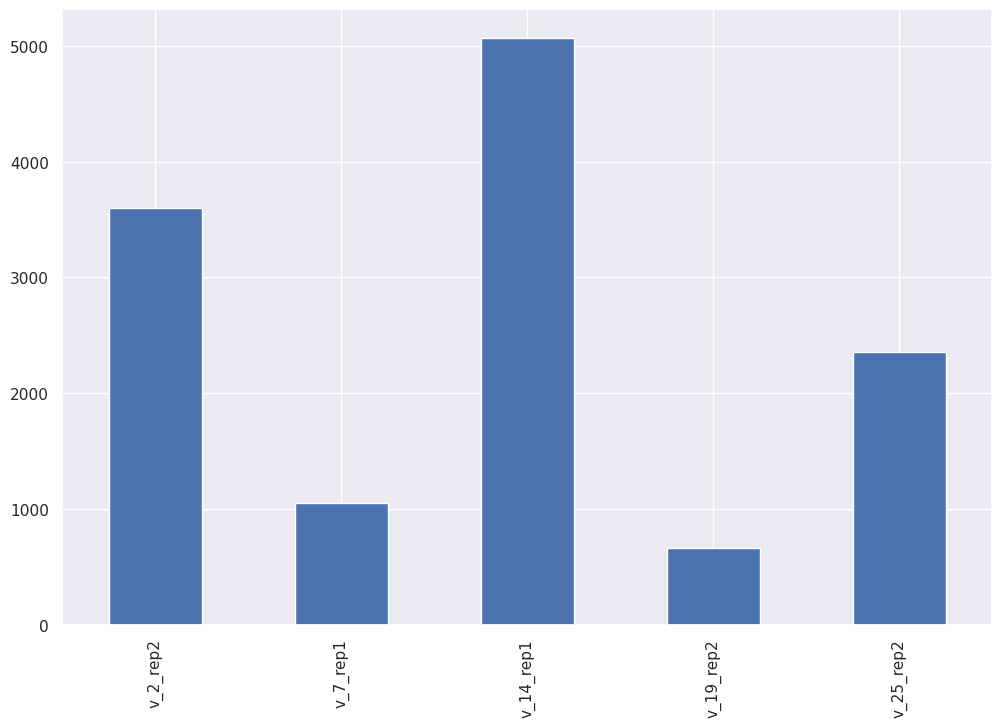

In [63]:
# first_half.sum(axis="rows").plot.bar()
second_half.sum(axis="rows").plot.bar()

<AxesSubplot: xlabel='time point', ylabel='jaccard'>

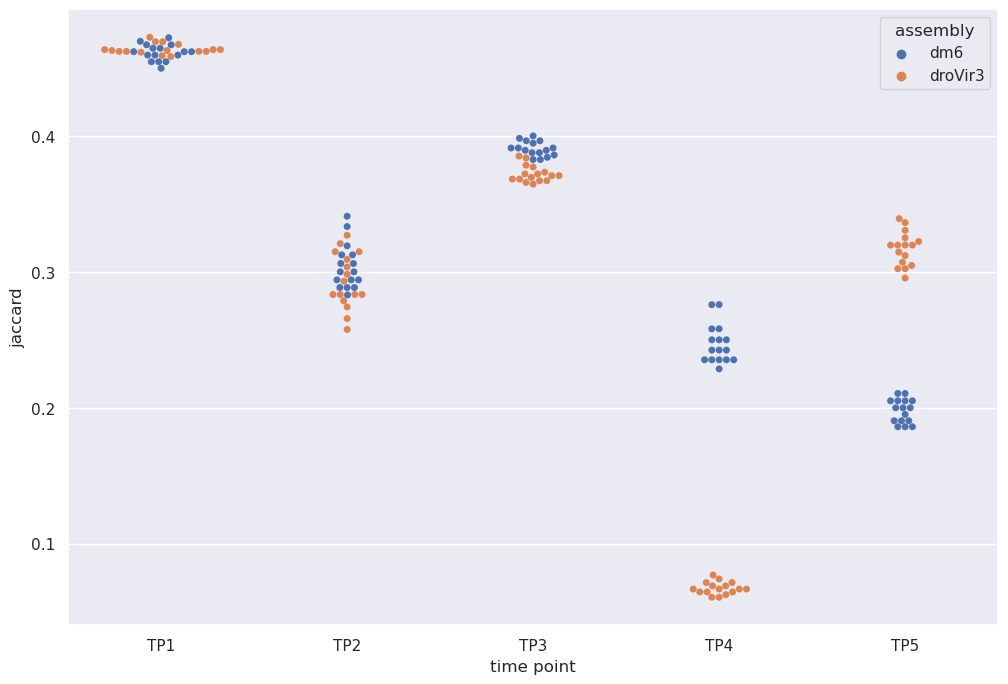

In [58]:
sns.swarmplot(data=df, x="time point", y="jaccard", hue="assembly")

<AxesSubplot: >

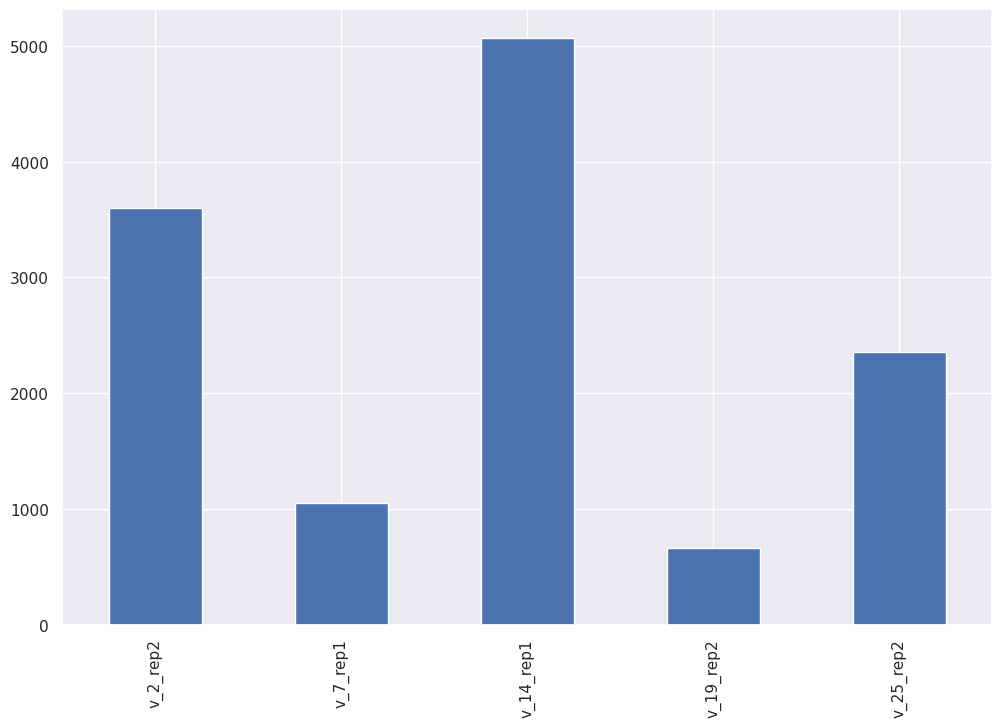

In [60]:
second_half.sum(axis="rows").plot.bar()

In [61]:
assembly

'droVir3'